In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import os
from glob import iglob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import math
from collections import defaultdict

C:\Users\prudha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### These functions are directly used from the lessons

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if(file.endswith('.png')):
            # should be done for png as png loads a float image with 0-1 range
            image = (image * 255).astype(np.uint8)
            
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


#### Load all the images from the extracted zip dataset

In [3]:
cars = []
not_cars = []

car_images = 'vehicles/vehicles/**/*.png'
noncar_images = 'non-vehicles/non-vehicles/**/*.png'

for file in iglob(car_images, recursive=True):
    cars.append(file)

for file in iglob(noncar_images, recursive=True):
    not_cars.append(file)

print(len(cars), len(not_cars))

8792 8968


#### Set the parameters for the rest of the code below here.

I used a combination of HOG, spatial and color features. I tuned the params by exclusively turning on the feature(like only spatial or color feature) and then tuning those parameters. Also for HOG features I used the parameters which were tuned during lessons and it worked pretty well

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

### Train in the cell below

In [29]:
# def train():
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# svc = SVC(kernel = 'rbf')
# svc = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5, max_features = 'auto')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6252
14.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


### All the functions here relating to heat maps are directly taken from the lessons. Most of the changes regarding removing false positives from the image, I've worked a lot on that.

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def area(bbox):
    return abs((bbox[0][0] - bbox[1][0]) * (bbox[0][1] - bbox[1][1]))

bboxes = []
def draw_labeled_bboxes(img, labels):
    maxArea = defaultdict(lambda: ((0,0),(0,0)))
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 8)
        
        for (ind,(box, count)) in enumerate(bboxes):
            mid = [(box[0][0] + box[1][0])/2, (box[0][1] + box[1][1])/2]
            bmid = [(bbox[0][0] + bbox[1][0])/2, (bbox[0][1] + bbox[1][1])/2]
            print(mid, bmid)
            if abs(mid[0] - bmid[0]) + abs(mid[1] - bmid[1]) < 300:
                if area(bbox) > area(maxArea[ind]):
                    maxArea[ind] = bbox
                bboxes[ind][1] += 1
                break
        else:
            maxArea[len(bboxes)] = bbox    
            bboxes.append([bbox,1])
    
    for (ind,(box, count)) in enumerate(bboxes):
        if area(maxArea[ind]) is 0 and bboxes[ind][1] >= 2.0:
            bboxes[ind][1] -= 2.
    
    print(bboxes)
    for (ind, (bbox, count)) in enumerate(bboxes):
        fbox = maxArea[ind] if area(maxArea[ind]) > area(bbox) else bbox
        if (area(maxArea[ind]) > bboxes[ind][1]) or (area(maxArea[ind]) > 2500):
            bboxes[ind][0] = maxArea[ind]
#         area check for noise reduction if any
        if (count > 15) and area(fbox) > 1500:
            cv2.rectangle(img, fbox[0], fbox[1], (255,0,0), 8)
    # Return the image
    return img



def draw(image):
    image = np.array(image)
    draw_image = np.copy(image)
    
    if not hasattr(draw, "windows"):
        draw.windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
        draw.windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(32, 32), xy_overlap=(0.7, 0.7))
    
    hot_windows = search_windows(image, draw.windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
#     return window_img
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
from sklearn.externals import joblib
def loadclf(path):
    return joblib.load(path)

def saveclf(clf, path):
    joblib.dump(clf, path)
    
def savescaler(scaler,path):
    joblib.dump(scaler, path)
def loadscaler(path):
    return joblib.load(path)

[805.0, 441.0] [1105.0, 447.0]
[1206.5, 442.5] [1105.0, 447.0]
[805.0, 441.0] [886.5, 451.5]
[805.0, 441.0] [1199.0, 442.5]
[1206.5, 442.5] [1199.0, 442.5]
[805.0, 441.0] [96.5, 452.5]
[1206.5, 442.5] [96.5, 452.5]
[33.5, 433.5] [96.5, 452.5]
[805.0, 441.0] [1257.5, 465.0]
[1206.5, 442.5] [1257.5, 465.0]
[[((760, 400), (850, 482)), 530.0], [((1140, 400), (1273, 485)), 2081.0], [((18, 418), (49, 449)), 191.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]
[[((836, 409), (937, 494)), 528.0], [((1064, 400), (1146, 494)), 2079.0], [((81, 438), (112, 467)), 189.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]
[886.5, 451.5] [924.5

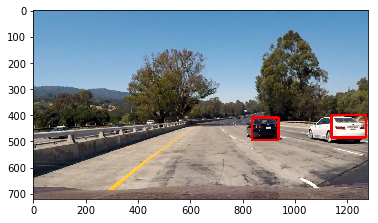

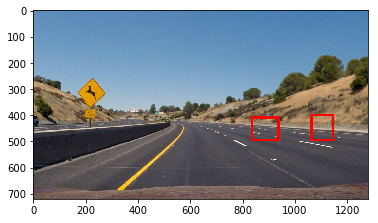

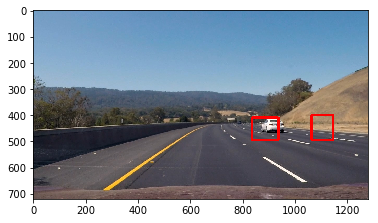

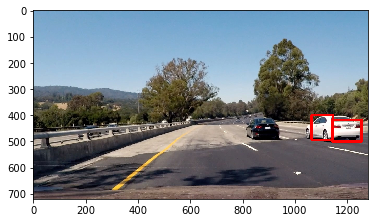

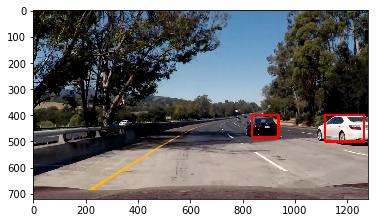

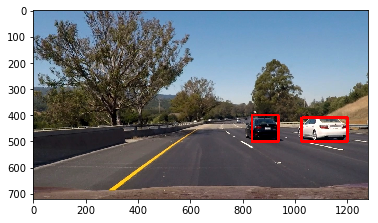

In [27]:
for file in iglob('test_images/*.jpg'):
    img = mpimg.imread(file)
    img = np.array(img)
    plt.figure()
    plt.imshow(draw(img))

In [ ]:
saveclf(svc, 'model.pkl')
savescaler(X_scaler, "scaler.pkl")

In [6]:
svc = loadclf('model.pkl')
X_scaler = loadscaler("scaler.pkl")

In [25]:
from moviepy.editor import VideoFileClip, CompositeVideoClip
from IPython.display import HTML

output = 'out.mp4'
clip = VideoFileClip("project_video.mp4")
detected   = clip.fl_image(draw)
detected.write_videofile(output, audio=False)

[]
[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4



  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

[]



  0%|                                                                               | 1/1261 [00:21<7:40:57, 21.95s/it]

[]



  0%|▏                                                                              | 2/1261 [00:44<7:44:15, 22.13s/it]

[]



  0%|▏                                                                              | 3/1261 [01:07<7:52:09, 22.52s/it]

[[((0, 419), (63, 463)), 1]]



  0%|▎                                                                              | 4/1261 [01:31<7:55:45, 22.71s/it]

[31.5, 441.0] [1181.0, 478.5]
[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  0%|▎                                                                              | 5/1261 [01:54<8:02:55, 23.07s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  0%|▍                                                                              | 6/1261 [02:18<8:06:14, 23.25s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▍                                                                              | 7/1261 [02:43<8:17:07, 23.79s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▌                                                                              | 8/1261 [03:06<8:10:16, 23.48s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▌                                                                              | 9/1261 [03:28<8:02:56, 23.14s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▌                                                                             | 10/1261 [03:51<8:00:00, 23.02s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▋                                                                             | 11/1261 [04:14<8:00:30, 23.06s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1]]



  1%|▋                                                                             | 12/1261 [04:37<7:59:49, 23.05s/it]

[31.5, 441.0] [753.5, 631.5]
[1181.0, 478.5] [753.5, 631.5]
[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|▊                                                                             | 13/1261 [05:01<8:05:45, 23.35s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|▊                                                                             | 14/1261 [05:23<7:55:13, 22.87s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|▉                                                                             | 15/1261 [05:43<7:39:44, 22.14s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|▉                                                                             | 16/1261 [06:04<7:28:21, 21.61s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|█                                                                             | 17/1261 [06:25<7:24:16, 21.43s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  1%|█                                                                             | 18/1261 [06:46<7:21:26, 21.31s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  2%|█▏                                                                            | 19/1261 [07:07<7:18:05, 21.16s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  2%|█▏                                                                            | 20/1261 [07:27<7:14:07, 20.99s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  2%|█▎                                                                            | 21/1261 [07:48<7:13:02, 20.95s/it]

[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 1], [((747, 616), (760, 647)), 1]]



  2%|█▎                                                                            | 22/1261 [08:10<7:20:44, 21.34s/it]

[31.5, 441.0] [1248.5, 627.0]
[1181.0, 478.5] [1248.5, 627.0]
[[((0, 419), (63, 463)), 1], [((1170, 463), (1192, 494)), 2], [((747, 616), (760, 647)), 1]]



  2%|█▍                                                                            | 23/1261 [08:31<7:14:03, 21.04s/it]

[[((0, 419), (63, 463)), 1], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▍                                                                            | 24/1261 [08:51<7:08:54, 20.80s/it]

[[((0, 419), (63, 463)), 1], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▌                                                                            | 25/1261 [09:11<7:06:26, 20.70s/it]

[[((0, 419), (63, 463)), 1], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▌                                                                            | 26/1261 [09:32<7:05:10, 20.66s/it]

[31.5, 441.0] [159.5, 501.0]
[[((0, 419), (63, 463)), 2], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▋                                                                            | 27/1261 [09:53<7:03:59, 20.62s/it]

[[((144, 490), (175, 512)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▋                                                                            | 28/1261 [10:13<7:02:03, 20.54s/it]

[[((144, 490), (175, 512)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▊                                                                            | 29/1261 [10:33<7:00:45, 20.49s/it]

[[((144, 490), (175, 512)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▊                                                                            | 30/1261 [10:55<7:11:11, 21.02s/it]

[[((144, 490), (175, 512)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  2%|█▉                                                                            | 31/1261 [11:17<7:11:24, 21.04s/it]

[159.5, 501.0] [164.0, 460.5]
[[((144, 490), (175, 512)), 1.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|█▉                                                                            | 32/1261 [11:37<7:06:13, 20.81s/it]

[164.0, 460.5] [182.0, 514.5]
[[((153, 445), (175, 476)), 2.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██                                                                            | 33/1261 [11:57<7:02:21, 20.64s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██                                                                            | 34/1261 [12:17<7:00:15, 20.55s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▏                                                                           | 35/1261 [12:38<6:58:27, 20.48s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▏                                                                           | 36/1261 [12:58<6:57:37, 20.46s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▎                                                                           | 37/1261 [13:18<6:56:20, 20.41s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▎                                                                           | 38/1261 [13:39<6:54:46, 20.35s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▍                                                                           | 39/1261 [14:01<7:07:22, 20.98s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▍                                                                           | 40/1261 [14:21<7:02:24, 20.76s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 1]]



  3%|██▌                                                                           | 41/1261 [14:42<6:58:58, 20.61s/it]

[182.0, 514.5] [888.5, 645.0]
[1248.5, 627.0] [888.5, 645.0]
[753.5, 631.5] [888.5, 645.0]
[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((747, 616), (760, 647)), 2]]



  3%|██▌                                                                           | 42/1261 [15:02<6:56:31, 20.50s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  3%|██▋                                                                           | 43/1261 [15:22<6:55:02, 20.45s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  3%|██▋                                                                           | 44/1261 [15:43<6:58:32, 20.63s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|██▊                                                                           | 45/1261 [16:04<6:57:25, 20.60s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|██▊                                                                           | 46/1261 [16:24<6:55:44, 20.53s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|██▉                                                                           | 47/1261 [16:44<6:54:01, 20.46s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|██▉                                                                           | 48/1261 [17:07<7:06:55, 21.12s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|███                                                                           | 49/1261 [17:28<7:02:18, 20.91s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0]]



  4%|███                                                                           | 50/1261 [17:48<6:58:31, 20.74s/it]

[182.0, 514.5] [470.0, 582.0]
[1248.5, 627.0] [470.0, 582.0]
[888.5, 645.0] [470.0, 582.0]
[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▏                                                                          | 51/1261 [18:08<6:57:07, 20.68s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▏                                                                          | 52/1261 [18:29<6:54:20, 20.56s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▎                                                                          | 53/1261 [18:49<6:52:22, 20.48s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▎                                                                          | 54/1261 [19:09<6:50:44, 20.42s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▍                                                                          | 55/1261 [19:30<6:50:11, 20.41s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  4%|███▍                                                                          | 56/1261 [19:51<6:53:34, 20.59s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▌                                                                          | 57/1261 [20:13<7:02:31, 21.06s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▌                                                                          | 58/1261 [20:33<6:57:16, 20.81s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▋                                                                          | 59/1261 [20:53<6:53:52, 20.66s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▋                                                                          | 60/1261 [21:14<6:53:18, 20.65s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▊                                                                          | 61/1261 [21:34<6:50:53, 20.54s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▊                                                                          | 62/1261 [21:55<6:48:48, 20.46s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▉                                                                          | 63/1261 [22:15<6:47:10, 20.39s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|███▉                                                                          | 64/1261 [22:35<6:46:30, 20.38s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|████                                                                          | 65/1261 [22:57<6:57:55, 20.97s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|████                                                                          | 66/1261 [23:19<6:58:43, 21.02s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|████▏                                                                         | 67/1261 [23:39<6:54:15, 20.82s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|████▏                                                                         | 68/1261 [23:59<6:51:08, 20.68s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  5%|████▎                                                                         | 69/1261 [24:20<6:48:32, 20.56s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▎                                                                         | 70/1261 [24:40<6:46:49, 20.50s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▍                                                                         | 71/1261 [25:00<6:45:13, 20.43s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▍                                                                         | 72/1261 [25:21<6:45:55, 20.48s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▌                                                                         | 73/1261 [25:41<6:45:58, 20.50s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▌                                                                         | 74/1261 [26:03<6:49:27, 20.70s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▋                                                                         | 75/1261 [26:24<6:56:31, 21.07s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▋                                                                         | 76/1261 [26:46<6:56:46, 21.10s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▊                                                                         | 77/1261 [27:07<6:56:31, 21.11s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▊                                                                         | 78/1261 [27:27<6:51:57, 20.89s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▉                                                                         | 79/1261 [27:48<6:48:43, 20.75s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|████▉                                                                         | 80/1261 [28:08<6:46:10, 20.64s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  6%|█████                                                                         | 81/1261 [28:28<6:43:55, 20.54s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████                                                                         | 82/1261 [28:49<6:45:57, 20.66s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▏                                                                        | 83/1261 [29:11<6:53:50, 21.08s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▏                                                                        | 84/1261 [29:32<6:49:24, 20.87s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▎                                                                        | 85/1261 [29:52<6:45:54, 20.71s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▎                                                                        | 86/1261 [30:12<6:42:59, 20.58s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▍                                                                        | 87/1261 [30:33<6:41:48, 20.53s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▍                                                                        | 88/1261 [30:53<6:40:37, 20.49s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▌                                                                        | 89/1261 [31:14<6:40:44, 20.52s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▌                                                                        | 90/1261 [31:35<6:44:22, 20.72s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▋                                                                        | 91/1261 [31:59<7:03:59, 21.74s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▋                                                                        | 92/1261 [32:20<6:58:56, 21.50s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▊                                                                        | 93/1261 [32:40<6:51:10, 21.12s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  7%|█████▊                                                                        | 94/1261 [33:01<6:46:53, 20.92s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|█████▉                                                                        | 95/1261 [33:21<6:43:09, 20.75s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|█████▉                                                                        | 96/1261 [33:41<6:39:42, 20.59s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████                                                                        | 97/1261 [34:01<6:37:53, 20.51s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████                                                                        | 98/1261 [34:22<6:37:38, 20.51s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████                                                                        | 99/1261 [34:42<6:36:34, 20.48s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████                                                                       | 100/1261 [35:05<6:49:05, 21.14s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████▏                                                                      | 101/1261 [35:26<6:44:38, 20.93s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████▏                                                                      | 102/1261 [35:46<6:41:42, 20.80s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████▎                                                                      | 103/1261 [36:06<6:39:14, 20.69s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████▎                                                                      | 104/1261 [36:29<6:47:11, 21.12s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1]]



  8%|██████▍                                                                      | 105/1261 [36:52<7:01:18, 21.87s/it]

[182.0, 514.5] [1095.5, 478.5]
[1248.5, 627.0] [1095.5, 478.5]
[888.5, 645.0] [1095.5, 478.5]
[470.0, 582.0] [1095.5, 478.5]
[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 1]]



  8%|██████▍                                                                      | 106/1261 [37:13<6:56:21, 21.63s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 1]]



  8%|██████▌                                                                      | 107/1261 [37:34<6:49:38, 21.30s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 1]]



  9%|██████▌                                                                      | 108/1261 [37:57<7:00:02, 21.86s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 1]]



  9%|██████▋                                                                      | 109/1261 [38:18<6:54:50, 21.61s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 1]]



  9%|██████▋                                                                      | 110/1261 [38:40<6:54:13, 21.59s/it]

[182.0, 514.5] [1046.0, 460.5]
[1248.5, 627.0] [1046.0, 460.5]
[888.5, 645.0] [1046.0, 460.5]
[470.0, 582.0] [1046.0, 460.5]
[1095.5, 478.5] [1046.0, 460.5]
[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1080, 463), (1111, 494)), 2]]



  9%|██████▊                                                                      | 111/1261 [39:01<6:50:34, 21.42s/it]

[[((171, 499), (193, 530)), 0.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|██████▊                                                                      | 112/1261 [39:21<6:45:00, 21.15s/it]

[182.0, 514.5] [141.5, 433.5]
[[((171, 499), (193, 530)), 1.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|██████▉                                                                      | 113/1261 [39:41<6:40:38, 20.94s/it]

[141.5, 433.5] [128.0, 433.5]
[[((135, 418), (148, 449)), 2.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|██████▉                                                                      | 114/1261 [40:02<6:37:41, 20.80s/it]

[128.0, 433.5] [114.5, 433.5]
[[((126, 418), (130, 449)), 3.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|███████                                                                      | 115/1261 [40:23<6:35:56, 20.73s/it]

[114.5, 433.5] [96.5, 433.5]
[[((99, 418), (130, 449)), 4.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|███████                                                                      | 116/1261 [40:43<6:34:36, 20.68s/it]

[96.5, 433.5] [78.5, 433.5]
[[((81, 418), (112, 449)), 5.0], [((1233, 616), (1264, 638)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|███████▏                                                                     | 117/1261 [41:06<6:47:26, 21.37s/it]

[78.5, 433.5] [56.0, 433.5]
[78.5, 433.5] [1244.0, 478.5]
[1248.5, 627.0] [1244.0, 478.5]
[[((63, 418), (94, 449)), 6.0], [((1233, 616), (1264, 638)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|███████▏                                                                     | 118/1261 [41:27<6:42:00, 21.10s/it]

[56.0, 433.5] [38.0, 433.5]
[[((36, 418), (76, 449)), 7.0], [((1233, 472), (1255, 485)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



  9%|███████▎                                                                     | 119/1261 [41:47<6:38:16, 20.93s/it]

[[((18, 418), (58, 449)), 5.0], [((1233, 472), (1255, 485)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▎                                                                     | 120/1261 [42:08<6:36:39, 20.86s/it]

[[((18, 418), (58, 449)), 3.0], [((1233, 472), (1255, 485)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▍                                                                     | 121/1261 [42:28<6:35:26, 20.81s/it]

[38.0, 433.5] [132.5, 433.5]
[38.0, 433.5] [290.0, 433.5]
[[((18, 418), (58, 449)), 5.0], [((1233, 472), (1255, 485)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▍                                                                     | 122/1261 [42:49<6:32:40, 20.69s/it]

[290.0, 433.5] [1244.0, 483.0]
[1244.0, 478.5] [1244.0, 483.0]
[[((279, 418), (301, 449)), 3.0], [((1233, 472), (1255, 485)), 2.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▌                                                                     | 123/1261 [43:09<6:31:37, 20.65s/it]

[290.0, 433.5] [272.0, 433.5]
[290.0, 433.5] [1221.5, 483.0]
[1244.0, 483.0] [1221.5, 483.0]
[[((279, 418), (301, 449)), 4.0], [((1242, 472), (1246, 494)), 3.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▌                                                                     | 124/1261 [43:30<6:28:49, 20.52s/it]

[272.0, 433.5] [263.0, 433.5]
[[((261, 418), (283, 449)), 5.0], [((1206, 472), (1237, 494)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▋                                                                     | 125/1261 [43:50<6:30:16, 20.61s/it]

[263.0, 433.5] [254.0, 433.5]
[[((252, 418), (274, 449)), 6.0], [((1206, 472), (1237, 494)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▋                                                                     | 126/1261 [44:13<6:38:43, 21.08s/it]

[254.0, 433.5] [240.5, 433.5]
[254.0, 433.5] [45.0, 438.5]
[254.0, 433.5] [1244.0, 492.0]
[1221.5, 483.0] [1244.0, 492.0]
[[((234, 418), (274, 449)), 8.0], [((1206, 472), (1237, 494)), 2.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▊                                                                     | 127/1261 [44:33<6:34:50, 20.89s/it]

[45.0, 438.5] [231.5, 433.5]
[45.0, 438.5] [24.5, 438.0]
[[((27, 419), (63, 458)), 10.0], [((1233, 481), (1255, 503)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▊                                                                     | 128/1261 [44:56<6:45:01, 21.45s/it]

[231.5, 433.5] [222.5, 433.5]
[[((216, 418), (247, 449)), 11.0], [((1233, 481), (1255, 503)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▉                                                                     | 129/1261 [45:17<6:43:03, 21.36s/it]

[222.5, 433.5] [195.5, 433.5]
[222.5, 433.5] [1212.5, 496.5]
[1244.0, 492.0] [1212.5, 496.5]
[[((207, 418), (238, 449)), 12.0], [((1233, 481), (1255, 503)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▉                                                                     | 130/1261 [45:37<6:37:37, 21.09s/it]

[195.5, 433.5] [188.5, 433.5]
[195.5, 433.5] [1217.0, 487.5]
[1212.5, 496.5] [1217.0, 487.5]
[[((180, 418), (211, 449)), 13.0], [((1197, 481), (1228, 512)), 2.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|███████▉                                                                     | 131/1261 [45:58<6:33:19, 20.88s/it]

[188.5, 433.5] [177.0, 438.0]
[188.5, 433.5] [303.5, 442.5]
[[((162, 418), (215, 449)), 15.0], [((1215, 472), (1219, 503)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 10%|████████                                                                     | 132/1261 [46:18<6:30:05, 20.73s/it]

[177.0, 438.0] [163.0, 433.5]
[[((152, 418), (202, 458)), 16.0], [((1215, 472), (1219, 503)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████                                                                     | 133/1261 [46:39<6:28:04, 20.64s/it]

[163.0, 433.5] [123.5, 433.5]
[163.0, 433.5] [146.0, 433.5]
[163.0, 433.5] [281.0, 442.5]
[[((133, 418), (193, 449)), 19.0], [((1215, 472), (1219, 503)), 0.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▏                                                                    | 134/1261 [47:02<6:43:19, 21.47s/it]

[123.5, 433.5] [141.5, 433.5]
[123.5, 433.5] [272.0, 442.5]
[123.5, 433.5] [1221.5, 483.0]
[1217.0, 487.5] [1221.5, 483.0]
[[((108, 418), (139, 449)), 21.0], [((1215, 472), (1219, 503)), 1.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▏                                                                    | 135/1261 [47:23<6:37:34, 21.19s/it]

[141.5, 433.5] [101.0, 438.0]
[141.5, 433.5] [1212.5, 483.0]
[1221.5, 483.0] [1212.5, 483.0]
[141.5, 433.5] [1253.0, 505.5]
[1221.5, 483.0] [1253.0, 505.5]
[[((126, 418), (157, 449)), 22.0], [((1206, 472), (1237, 494)), 3.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▎                                                                    | 136/1261 [47:44<6:37:36, 21.21s/it]

[101.0, 438.0] [74.0, 431.5]
[101.0, 438.0] [237.0, 442.5]
[101.0, 438.0] [1199.0, 478.5]
[1212.5, 483.0] [1199.0, 478.5]
[[((72, 418), (130, 458)), 24.0], [((1197, 472), (1228, 494)), 4.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▎                                                                    | 137/1261 [48:04<6:32:54, 20.97s/it]

[74.0, 431.5] [68.0, 433.5]
[74.0, 431.5] [33.5, 442.5]
[74.0, 431.5] [221.5, 442.5]
[74.0, 431.5] [1253.0, 514.5]
[1199.0, 478.5] [1253.0, 514.5]
[[((36, 400), (112, 463)), 27.0], [((1197, 463), (1201, 494)), 5.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▍                                                                    | 138/1261 [48:25<6:29:43, 20.82s/it]

[221.5, 442.5] [182.0, 442.5]
[221.5, 442.5] [213.5, 442.5]
[221.5, 442.5] [1257.5, 452.5]
[1253.0, 514.5] [1257.5, 452.5]
[221.5, 442.5] [1222.0, 491.0]
[1253.0, 514.5] [1222.0, 491.0]
[221.5, 442.5] [1257.5, 500.0]
[1253.0, 514.5] [1257.5, 500.0]
[[((190, 427), (253, 458)), 29.0], [((1242, 499), (1264, 530)), 8.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▍                                                                    | 139/1261 [48:45<6:27:14, 20.71s/it]

[213.5, 442.5] [173.0, 450.5]
[213.5, 442.5] [1257.5, 452.5]
[1257.5, 452.5] [1257.5, 452.5]
[213.5, 442.5] [1203.5, 482.0]
[1257.5, 452.5] [1203.5, 482.0]
[[((198, 427), (229, 458)), 30.0], [((1242, 438), (1273, 467)), 10.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▌                                                                    | 140/1261 [49:06<6:25:47, 20.65s/it]

[173.0, 450.5] [160.5, 442.5]
[173.0, 450.5] [122.0, 451.5]
[173.0, 450.5] [1257.5, 452.5]
[1203.5, 482.0] [1257.5, 452.5]
[173.0, 450.5] [1190.0, 478.5]
[1203.5, 482.0] [1190.0, 478.5]
[173.0, 450.5] [1217.5, 478.5]
[1203.5, 482.0] [1217.5, 478.5]
[[((135, 419), (211, 482)), 32.0], [((1188, 463), (1219, 501)), 13.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▌                                                                    | 141/1261 [49:28<6:32:10, 21.01s/it]

[160.5, 442.5] [96.5, 450.5]
[160.5, 442.5] [1248.5, 451.5]
[1257.5, 452.5] [1248.5, 451.5]
[160.5, 442.5] [1212.5, 465.0]
[1257.5, 452.5] [1212.5, 465.0]
[[((144, 427), (177, 458)), 33.0], [((1242, 438), (1273, 467)), 15.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▋                                                                    | 142/1261 [49:49<6:34:06, 21.13s/it]

[96.5, 450.5] [38.0, 451.5]
[96.5, 450.5] [57.5, 451.5]
[96.5, 450.5] [1248.5, 456.0]
[1248.5, 451.5] [1248.5, 456.0]
[[((54, 419), (139, 482)), 35.0], [((1233, 436), (1264, 467)), 16.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▋                                                                    | 143/1261 [50:12<6:45:43, 21.77s/it]

[38.0, 451.5] [42.5, 442.5]
[38.0, 451.5] [1248.5, 451.5]
[1248.5, 456.0] [1248.5, 451.5]
[38.0, 451.5] [1194.5, 483.0]
[1248.5, 456.0] [1194.5, 483.0]
[38.0, 451.5] [1239.5, 474.0]
[1248.5, 456.0] [1239.5, 474.0]
[38.0, 451.5] [1185.5, 501.0]
[1248.5, 456.0] [1185.5, 501.0]
[[((27, 436), (49, 467)), 36.0], [((1233, 445), (1264, 467)), 20.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▊                                                                    | 144/1261 [50:33<6:37:19, 21.34s/it]

[42.5, 442.5] [1244.0, 456.0]
[1248.5, 451.5] [1244.0, 456.0]
[42.5, 442.5] [1181.5, 478.5]
[1248.5, 451.5] [1181.5, 478.5]
[[((27, 427), (58, 458)), 34.0], [((1233, 436), (1264, 467)), 22.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 11%|████████▊                                                                    | 145/1261 [50:53<6:33:24, 21.15s/it]

[42.5, 442.5] [1235.0, 469.5]
[1244.0, 456.0] [1235.0, 469.5]
[42.5, 442.5] [1203.5, 478.5]
[1244.0, 456.0] [1203.5, 478.5]
[[((27, 427), (58, 458)), 32.0], [((1224, 436), (1264, 476)), 24.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|████████▉                                                                    | 146/1261 [51:14<6:31:06, 21.05s/it]

[42.5, 442.5] [1230.5, 469.5]
[1235.0, 469.5] [1230.5, 469.5]
[42.5, 442.5] [1199.0, 478.5]
[1235.0, 469.5] [1199.0, 478.5]
[[((27, 427), (58, 458)), 30.0], [((1215, 438), (1255, 501)), 26.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|████████▉                                                                    | 147/1261 [51:35<6:27:39, 20.88s/it]

[42.5, 442.5] [1230.5, 451.5]
[1230.5, 469.5] [1230.5, 451.5]
[42.5, 442.5] [1185.5, 478.5]
[1230.5, 469.5] [1185.5, 478.5]
[42.5, 442.5] [1199.0, 465.0]
[1230.5, 469.5] [1199.0, 465.0]
[[((27, 427), (58, 458)), 28.0], [((1206, 438), (1255, 501)), 29.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████                                                                    | 148/1261 [51:55<6:25:34, 20.79s/it]

[42.5, 442.5] [1230.5, 456.0]
[1230.5, 451.5] [1230.5, 456.0]
[42.5, 442.5] [1185.5, 478.5]
[1230.5, 451.5] [1185.5, 478.5]
[[((27, 427), (58, 458)), 26.0], [((1215, 436), (1246, 467)), 31.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████                                                                    | 149/1261 [52:16<6:24:28, 20.75s/it]

[42.5, 442.5] [1235.0, 451.5]
[1185.5, 478.5] [1235.0, 451.5]
[42.5, 442.5] [1181.0, 478.5]
[1185.5, 478.5] [1181.0, 478.5]
[[((27, 427), (58, 458)), 24.0], [((1170, 463), (1201, 494)), 33.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▏                                                                   | 150/1261 [52:36<6:22:41, 20.67s/it]

[42.5, 442.5] [1230.5, 451.5]
[1235.0, 451.5] [1230.5, 451.5]
[42.5, 442.5] [1221.5, 474.0]
[1235.0, 451.5] [1221.5, 474.0]
[[((27, 427), (58, 458)), 22.0], [((1224, 436), (1246, 467)), 35.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▏                                                                   | 151/1261 [52:59<6:35:56, 21.40s/it]

[42.5, 442.5] [1221.5, 451.5]
[1230.5, 451.5] [1221.5, 451.5]
[42.5, 442.5] [1176.5, 483.0]
[1230.5, 451.5] [1176.5, 483.0]
[[((27, 427), (58, 458)), 20.0], [((1215, 436), (1246, 467)), 37.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▎                                                                   | 152/1261 [53:20<6:30:09, 21.11s/it]

[42.5, 442.5] [1221.5, 456.0]
[1221.5, 451.5] [1221.5, 456.0]
[42.5, 442.5] [1190.0, 483.0]
[1221.5, 451.5] [1190.0, 483.0]
[42.5, 442.5] [1212.5, 474.0]
[1221.5, 451.5] [1212.5, 474.0]
[[((27, 427), (58, 458)), 18.0], [((1206, 436), (1237, 467)), 40.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▎                                                                   | 153/1261 [53:40<6:26:20, 20.92s/it]

[42.5, 442.5] [1158.5, 469.5]
[1221.5, 456.0] [1158.5, 469.5]
[[((27, 427), (58, 458)), 16.0], [((1206, 445), (1237, 467)), 41.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▍                                                                   | 154/1261 [54:01<6:23:29, 20.79s/it]

[42.5, 442.5] [1212.5, 456.0]
[1158.5, 469.5] [1212.5, 456.0]
[42.5, 442.5] [1167.5, 482.0]
[1158.5, 469.5] [1167.5, 482.0]
[[((27, 427), (58, 458)), 14.0], [((1152, 463), (1165, 476)), 43.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▍                                                                   | 155/1261 [54:21<6:21:17, 20.69s/it]

[42.5, 442.5] [1212.5, 447.0]
[1212.5, 456.0] [1212.5, 447.0]
[42.5, 442.5] [1257.5, 442.5]
[1212.5, 456.0] [1257.5, 442.5]
[42.5, 442.5] [1167.5, 478.5]
[1212.5, 456.0] [1167.5, 478.5]
[42.5, 442.5] [1235.0, 505.5]
[1212.5, 456.0] [1235.0, 505.5]
[[((27, 427), (58, 458)), 12.0], [((1197, 436), (1228, 476)), 47.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▌                                                                   | 156/1261 [54:42<6:20:33, 20.66s/it]

[42.5, 442.5] [1253.0, 442.5]
[1212.5, 447.0] [1253.0, 442.5]
[42.5, 442.5] [1235.0, 505.5]
[1212.5, 447.0] [1235.0, 505.5]
[[((27, 427), (58, 458)), 10.0], [((1197, 427), (1228, 467)), 49.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 12%|█████████▌                                                                   | 157/1261 [55:02<6:18:37, 20.58s/it]

[42.5, 442.5] [1235.0, 438.0]
[1235.0, 505.5] [1235.0, 438.0]
[42.5, 442.5] [1158.5, 478.5]
[1235.0, 505.5] [1158.5, 478.5]
[42.5, 442.5] [1248.5, 481.5]
[1235.0, 505.5] [1248.5, 481.5]
[42.5, 442.5] [1248.5, 501.0]
[1235.0, 505.5] [1248.5, 501.0]
[[((27, 427), (58, 458)), 8.0], [((1206, 490), (1264, 521)), 53.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▋                                                                   | 158/1261 [55:23<6:17:37, 20.54s/it]

[42.5, 442.5] [1225.5, 464.5]
[1235.0, 438.0] [1225.5, 464.5]
[42.5, 442.5] [1158.5, 483.0]
[1235.0, 438.0] [1158.5, 483.0]
[[((27, 427), (58, 458)), 6.0], [((1197, 409), (1273, 467)), 55.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▋                                                                   | 159/1261 [55:43<6:15:56, 20.47s/it]

[42.5, 442.5] [1220.0, 441.0]
[1225.5, 464.5] [1220.0, 441.0]
[[((27, 427), (58, 458)), 4.0], [((1178, 409), (1273, 520)), 56.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▊                                                                   | 160/1261 [56:04<6:18:43, 20.64s/it]

[42.5, 442.5] [1229.0, 465.0]
[1220.0, 441.0] [1229.0, 465.0]
[42.5, 442.5] [1162.0, 478.5]
[1220.0, 441.0] [1162.0, 478.5]
[[((27, 427), (58, 458)), 2.0], [((1161, 400), (1279, 482)), 58.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▊                                                                   | 161/1261 [56:25<6:19:09, 20.68s/it]

[42.5, 442.5] [1221.5, 460.5]
[1229.0, 465.0] [1221.5, 460.5]
[42.5, 442.5] [1149.5, 487.5]
[1229.0, 465.0] [1149.5, 487.5]
[[((27, 427), (58, 458)), 0.0], [((1179, 409), (1279, 521)), 60.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▉                                                                   | 162/1261 [56:48<6:30:18, 21.31s/it]

[42.5, 442.5] [1239.5, 431.5]
[1221.5, 460.5] [1239.5, 431.5]
[42.5, 442.5] [1194.5, 445.0]
[1221.5, 460.5] [1194.5, 445.0]
[42.5, 442.5] [1208.0, 505.5]
[1221.5, 460.5] [1208.0, 505.5]
[42.5, 442.5] [1226.0, 505.5]
[1221.5, 460.5] [1226.0, 505.5]
[[((27, 427), (58, 458)), 0.0], [((1179, 400), (1264, 521)), 64.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|█████████▉                                                                   | 163/1261 [57:08<6:26:34, 21.12s/it]

[42.5, 442.5] [1219.5, 433.5]
[1239.5, 431.5] [1219.5, 433.5]
[42.5, 442.5] [1237.5, 496.5]
[1239.5, 431.5] [1237.5, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1215, 400), (1264, 463)), 66.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████                                                                   | 164/1261 [57:29<6:23:20, 20.97s/it]

[42.5, 442.5] [1219.0, 445.5]
[1219.5, 433.5] [1219.0, 445.5]
[42.5, 442.5] [1223.5, 505.5]
[1219.5, 433.5] [1223.5, 505.5]
[[((27, 427), (58, 458)), 0.0], [((1179, 400), (1260, 467)), 68.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████                                                                   | 165/1261 [57:49<6:19:27, 20.77s/it]

[42.5, 442.5] [1185.5, 460.5]
[1219.0, 445.5] [1185.5, 460.5]
[[((27, 427), (58, 458)), 0.0], [((1178, 409), (1260, 482)), 69.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████▏                                                                  | 166/1261 [58:10<6:17:59, 20.71s/it]

[42.5, 442.5] [1210.5, 441.0]
[1185.5, 460.5] [1210.5, 441.0]
[42.5, 442.5] [1148.0, 486.5]
[1185.5, 460.5] [1148.0, 486.5]
[42.5, 442.5] [1190.0, 505.5]
[1185.5, 460.5] [1190.0, 505.5]
[[((27, 427), (58, 458)), 0.0], [((1098, 400), (1273, 521)), 72.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████▏                                                                  | 167/1261 [58:30<6:15:57, 20.62s/it]

[42.5, 442.5] [1207.0, 460.0]
[1210.5, 441.0] [1207.0, 460.0]
[42.5, 442.5] [1143.5, 469.5]
[1210.5, 441.0] [1143.5, 469.5]
[42.5, 442.5] [1118.0, 474.0]
[1210.5, 441.0] [1118.0, 474.0]
[[((27, 427), (58, 458)), 0.0], [((1161, 400), (1260, 482)), 75.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████▎                                                                  | 168/1261 [58:51<6:19:03, 20.81s/it]

[42.5, 442.5] [1212.5, 447.0]
[1207.0, 460.0] [1212.5, 447.0]
[42.5, 442.5] [1131.5, 478.5]
[1207.0, 460.0] [1131.5, 478.5]
[42.5, 442.5] [1212.5, 481.5]
[1207.0, 460.0] [1212.5, 481.5]
[42.5, 442.5] [1217.0, 505.5]
[1207.0, 460.0] [1217.0, 505.5]
[42.5, 442.5] [1235.0, 501.0]
[1207.0, 460.0] [1235.0, 501.0]
[[((27, 427), (58, 458)), 0.0], [((1159, 400), (1255, 520)), 80.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████▎                                                                  | 169/1261 [59:14<6:25:48, 21.20s/it]

[42.5, 442.5] [1208.0, 431.5]
[1212.5, 447.0] [1208.0, 431.5]
[42.5, 442.5] [1131.5, 474.0]
[1212.5, 447.0] [1131.5, 474.0]
[42.5, 442.5] [1244.0, 483.0]
[1212.5, 447.0] [1244.0, 483.0]
[42.5, 442.5] [1226.0, 487.5]
[1212.5, 447.0] [1226.0, 487.5]
[[((27, 427), (58, 458)), 0.0], [((1161, 400), (1264, 494)), 84.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 13%|██████████▍                                                                  | 170/1261 [59:35<6:25:35, 21.21s/it]

[42.5, 442.5] [1196.5, 433.5]
[1208.0, 431.5] [1196.5, 433.5]
[42.5, 442.5] [1221.5, 505.5]
[1208.0, 431.5] [1221.5, 505.5]
[[((27, 427), (58, 458)), 0.0], [((1161, 400), (1255, 463)), 86.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▍                                                                  | 171/1261 [59:55<6:21:12, 20.98s/it]

[42.5, 442.5] [1167.5, 445.0]
[1196.5, 433.5] [1167.5, 445.0]
[42.5, 442.5] [1208.0, 442.5]
[1196.5, 433.5] [1208.0, 442.5]
[42.5, 442.5] [1232.5, 463.0]
[1196.5, 433.5] [1232.5, 463.0]
[42.5, 442.5] [1203.5, 496.5]
[1196.5, 433.5] [1203.5, 496.5]
[42.5, 442.5] [1226.0, 492.0]
[1196.5, 433.5] [1226.0, 492.0]
[[((27, 427), (58, 458)), 0.0], [((1152, 400), (1241, 467)), 91.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▏                                                                | 172/1261 [1:00:16<6:17:35, 20.80s/it]

[42.5, 442.5] [1190.5, 447.0]
[1208.0, 442.5] [1190.5, 447.0]
[42.5, 442.5] [1122.5, 478.5]
[1208.0, 442.5] [1122.5, 478.5]
[42.5, 442.5] [1162.0, 487.5]
[1208.0, 442.5] [1162.0, 487.5]
[42.5, 442.5] [1205.0, 492.0]
[1208.0, 442.5] [1205.0, 492.0]
[42.5, 442.5] [1235.0, 487.5]
[1208.0, 442.5] [1235.0, 487.5]
[[((27, 427), (58, 458)), 0.0], [((1188, 427), (1228, 458)), 96.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▎                                                                | 173/1261 [1:00:36<6:14:46, 20.67s/it]

[42.5, 442.5] [1196.5, 465.0]
[1190.5, 447.0] [1196.5, 465.0]
[42.5, 442.5] [1129.5, 478.5]
[1190.5, 447.0] [1129.5, 478.5]
[[((27, 427), (58, 458)), 0.0], [((1159, 427), (1222, 467)), 98.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▎                                                                | 174/1261 [1:00:56<6:13:18, 20.61s/it]

[42.5, 442.5] [1199.0, 464.5]
[1196.5, 465.0] [1199.0, 464.5]
[[((27, 427), (58, 458)), 0.0], [((1152, 409), (1241, 521)), 99.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▍                                                                | 175/1261 [1:01:17<6:14:06, 20.67s/it]

[42.5, 442.5] [1202.5, 456.0]
[1199.0, 464.5] [1202.5, 456.0]
[[((27, 427), (58, 458)), 0.0], [((1152, 409), (1246, 520)), 100.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▍                                                                | 176/1261 [1:01:38<6:11:49, 20.56s/it]

[42.5, 442.5] [1167.5, 456.0]
[1202.5, 456.0] [1167.5, 456.0]
[42.5, 442.5] [1077.5, 478.5]
[1202.5, 456.0] [1077.5, 478.5]
[[((27, 427), (58, 458)), 0.0], [((1159, 400), (1246, 512)), 102.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▌                                                                | 177/1261 [1:02:00<6:22:52, 21.19s/it]

[42.5, 442.5] [1190.0, 447.0]
[1167.5, 456.0] [1190.0, 447.0]
[42.5, 442.5] [1100.0, 469.5]
[1167.5, 456.0] [1100.0, 469.5]
[42.5, 442.5] [1127.0, 478.5]
[1167.5, 456.0] [1127.0, 478.5]
[42.5, 442.5] [1148.0, 486.5]
[1167.5, 456.0] [1148.0, 486.5]
[[((27, 427), (58, 458)), 0.0], [((1098, 400), (1237, 512)), 106.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▌                                                                | 178/1261 [1:02:21<6:19:26, 21.02s/it]

[42.5, 442.5] [1185.5, 433.5]
[1190.0, 447.0] [1185.5, 433.5]
[42.5, 442.5] [1086.5, 469.5]
[1190.0, 447.0] [1086.5, 469.5]
[42.5, 442.5] [1122.5, 456.0]
[1190.0, 447.0] [1122.5, 456.0]
[42.5, 442.5] [1161.5, 492.0]
[1190.0, 447.0] [1161.5, 492.0]
[[((27, 427), (58, 458)), 0.0], [((1143, 400), (1237, 494)), 110.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▋                                                                | 179/1261 [1:02:41<6:16:58, 20.90s/it]

[42.5, 442.5] [1178.0, 433.5]
[1185.5, 433.5] [1178.0, 433.5]
[42.5, 442.5] [1237.0, 449.5]
[1185.5, 433.5] [1237.0, 449.5]
[42.5, 442.5] [1086.5, 478.5]
[1185.5, 433.5] [1086.5, 478.5]
[42.5, 442.5] [1166.0, 492.0]
[1185.5, 433.5] [1166.0, 492.0]
[[((27, 427), (58, 458)), 0.0], [((1134, 400), (1237, 467)), 114.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▋                                                                | 180/1261 [1:03:02<6:13:19, 20.72s/it]

[42.5, 442.5] [1181.0, 433.5]
[1178.0, 433.5] [1181.0, 433.5]
[42.5, 442.5] [1131.5, 496.5]
[1178.0, 433.5] [1131.5, 496.5]
[42.5, 442.5] [1163.0, 496.5]
[1178.0, 433.5] [1163.0, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1134, 400), (1222, 467)), 117.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▊                                                                | 181/1261 [1:03:22<6:12:06, 20.67s/it]

[42.5, 442.5] [1181.0, 456.0]
[1181.0, 433.5] [1181.0, 456.0]
[[((27, 427), (58, 458)), 0.0], [((1134, 400), (1228, 467)), 118.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 14%|██████████▊                                                                | 182/1261 [1:03:43<6:14:10, 20.81s/it]

[42.5, 442.5] [1181.0, 460.0]
[1181.0, 456.0] [1181.0, 460.0]
[[((27, 427), (58, 458)), 0.0], [((1140, 400), (1222, 512)), 119.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|██████████▉                                                                | 183/1261 [1:04:04<6:10:52, 20.64s/it]

[42.5, 442.5] [1178.0, 456.0]
[1181.0, 460.0] [1178.0, 456.0]
[42.5, 442.5] [1257.5, 438.0]
[1181.0, 460.0] [1257.5, 438.0]
[42.5, 442.5] [1095.5, 483.0]
[1181.0, 460.0] [1095.5, 483.0]
[[((27, 427), (58, 458)), 0.0], [((1140, 400), (1222, 520)), 122.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|██████████▉                                                                | 184/1261 [1:04:24<6:08:49, 20.55s/it]

[42.5, 442.5] [1181.0, 447.0]
[1178.0, 456.0] [1181.0, 447.0]
[42.5, 442.5] [1131.5, 451.5]
[1178.0, 456.0] [1131.5, 451.5]
[42.5, 442.5] [1104.5, 469.5]
[1178.0, 456.0] [1104.5, 469.5]
[42.5, 442.5] [1149.5, 496.5]
[1178.0, 456.0] [1149.5, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1134, 400), (1222, 512)), 126.0], [((873, 634), (904, 656)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████                                                                | 185/1261 [1:04:44<6:06:29, 20.44s/it]

[42.5, 442.5] [1167.5, 438.0]
[1181.0, 447.0] [1167.5, 438.0]
[42.5, 442.5] [1190.0, 465.0]
[1181.0, 447.0] [1190.0, 465.0]
[42.5, 442.5] [1176.5, 492.0]
[1181.0, 447.0] [1176.5, 492.0]
[42.5, 442.5] [753.5, 514.5]
[1181.0, 447.0] [753.5, 514.5]
[888.5, 645.0] [753.5, 514.5]
[42.5, 442.5] [879.5, 622.5]
[1181.0, 447.0] [879.5, 622.5]
[888.5, 645.0] [879.5, 622.5]
[[((27, 427), (58, 458)), 0.0], [((1140, 400), (1222, 494)), 129.0], [((873, 634), (904, 656)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████                                                                | 186/1261 [1:05:07<6:17:03, 21.05s/it]

[42.5, 442.5] [1175.0, 433.5]
[1167.5, 438.0] [1175.0, 433.5]
[42.5, 442.5] [1172.0, 496.5]
[1167.5, 438.0] [1172.0, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1125, 409), (1210, 467)), 131.0], [((738, 499), (769, 530)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████                                                                | 187/1261 [1:05:27<6:13:19, 20.86s/it]

[42.5, 442.5] [1164.0, 442.5]
[1175.0, 433.5] [1164.0, 442.5]
[42.5, 442.5] [1257.5, 462.0]
[1175.0, 433.5] [1257.5, 462.0]
[42.5, 442.5] [1217.5, 487.5]
[1175.0, 433.5] [1217.5, 487.5]
[42.5, 442.5] [1158.5, 496.5]
[1175.0, 433.5] [1158.5, 496.5]
[42.5, 442.5] [1190.0, 496.5]
[1175.0, 433.5] [1190.0, 496.5]
[42.5, 442.5] [1248.5, 509.5]
[1175.0, 433.5] [1248.5, 509.5]
[[((27, 427), (58, 458)), 0.0], [((1140, 400), (1210, 467)), 137.0], [((738, 499), (769, 530)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▏                                                               | 188/1261 [1:05:48<6:11:41, 20.78s/it]

[42.5, 442.5] [1185.5, 460.0]
[1164.0, 442.5] [1185.5, 460.0]
[42.5, 442.5] [1257.5, 462.0]
[1164.0, 442.5] [1257.5, 462.0]
[42.5, 442.5] [1131.5, 474.0]
[1164.0, 442.5] [1131.5, 474.0]
[42.5, 442.5] [1149.5, 496.5]
[1164.0, 442.5] [1149.5, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1125, 409), (1203, 476)), 141.0], [((738, 499), (769, 530)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▏                                                               | 189/1261 [1:06:08<6:08:54, 20.65s/it]

[42.5, 442.5] [1163.0, 460.0]
[1185.5, 460.0] [1163.0, 460.0]
[42.5, 442.5] [1109.0, 478.5]
[1185.5, 460.0] [1109.0, 478.5]
[[((27, 427), (58, 458)), 0.0], [((1125, 400), (1246, 520)), 143.0], [((738, 499), (769, 530)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▎                                                               | 190/1261 [1:06:28<6:07:04, 20.56s/it]

[42.5, 442.5] [1162.0, 460.0]
[1163.0, 460.0] [1162.0, 460.0]
[42.5, 442.5] [1248.5, 451.5]
[1163.0, 460.0] [1248.5, 451.5]
[42.5, 442.5] [1106.5, 486.5]
[1163.0, 460.0] [1106.5, 486.5]
[[((27, 427), (58, 458)), 0.0], [((1116, 400), (1210, 520)), 146.0], [((738, 499), (769, 530)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▎                                                               | 191/1261 [1:06:49<6:06:04, 20.53s/it]

[42.5, 442.5] [1156.0, 464.5]
[1162.0, 460.0] [1156.0, 464.5]
[42.5, 442.5] [1253.0, 456.0]
[1162.0, 460.0] [1253.0, 456.0]
[42.5, 442.5] [582.5, 469.5]
[1162.0, 460.0] [582.5, 469.5]
[753.5, 514.5] [582.5, 469.5]
[[((27, 427), (58, 458)), 0.0], [((1121, 400), (1203, 520)), 148.0], [((738, 499), (769, 530)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▍                                                               | 192/1261 [1:07:10<6:06:58, 20.60s/it]

[42.5, 442.5] [1159.5, 433.5]
[1156.0, 464.5] [1159.5, 433.5]
[42.5, 442.5] [1248.5, 451.5]
[1156.0, 464.5] [1248.5, 451.5]
[42.5, 442.5] [1194.5, 483.0]
[1156.0, 464.5] [1194.5, 483.0]
[42.5, 442.5] [1145.0, 496.5]
[1156.0, 464.5] [1145.0, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1102, 409), (1210, 520)), 152.0], [((567, 454), (598, 485)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▍                                                               | 193/1261 [1:07:30<6:06:20, 20.58s/it]

[42.5, 442.5] [1162.0, 431.5]
[1159.5, 433.5] [1162.0, 431.5]
[42.5, 442.5] [1248.5, 447.0]
[1159.5, 433.5] [1248.5, 447.0]
[42.5, 442.5] [582.5, 479.0]
[1159.5, 433.5] [582.5, 479.0]
[582.5, 469.5] [582.5, 479.0]
[42.5, 442.5] [1163.0, 496.5]
[1159.5, 433.5] [1163.0, 496.5]
[42.5, 442.5] [1181.0, 487.5]
[1159.5, 433.5] [1181.0, 487.5]
[[((27, 427), (58, 458)), 0.0], [((1116, 400), (1203, 467)), 156.0], [((567, 454), (598, 485)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▌                                                               | 194/1261 [1:07:51<6:07:28, 20.66s/it]

[42.5, 442.5] [1159.5, 433.5]
[1162.0, 431.5] [1159.5, 433.5]
[42.5, 442.5] [1248.5, 447.0]
[1162.0, 431.5] [1248.5, 447.0]
[42.5, 442.5] [1097.0, 460.5]
[1162.0, 431.5] [1097.0, 460.5]
[42.5, 442.5] [582.5, 479.0]
[1162.0, 431.5] [582.5, 479.0]
[582.5, 479.0] [582.5, 479.0]
[[((27, 427), (58, 458)), 0.0], [((1121, 400), (1203, 463)), 159.0], [((551, 457), (614, 501)), 3.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 15%|███████████▌                                                               | 195/1261 [1:08:13<6:15:24, 21.13s/it]

[42.5, 442.5] [1159.5, 447.0]
[1159.5, 433.5] [1159.5, 447.0]
[42.5, 442.5] [1253.0, 440.5]
[1159.5, 433.5] [1253.0, 440.5]
[42.5, 442.5] [1158.5, 487.5]
[1159.5, 433.5] [1158.5, 487.5]
[[((27, 427), (58, 458)), 0.0], [((1116, 400), (1203, 467)), 162.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▋                                                               | 196/1261 [1:08:33<6:10:31, 20.87s/it]

[42.5, 442.5] [1150.5, 451.5]
[1159.5, 447.0] [1150.5, 451.5]
[42.5, 442.5] [1239.5, 442.5]
[1159.5, 447.0] [1239.5, 442.5]
[[((27, 427), (58, 458)), 0.0], [((1116, 400), (1203, 494)), 164.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▋                                                               | 197/1261 [1:08:54<6:07:11, 20.71s/it]

[42.5, 442.5] [1170.5, 451.5]
[1150.5, 451.5] [1170.5, 451.5]
[42.5, 442.5] [1244.0, 442.5]
[1150.5, 451.5] [1244.0, 442.5]
[42.5, 442.5] [1100.0, 474.0]
[1150.5, 451.5] [1100.0, 474.0]
[42.5, 442.5] [1125.0, 463.0]
[1150.5, 451.5] [1125.0, 463.0]
[[((27, 427), (58, 458)), 0.0], [((1098, 400), (1203, 503)), 168.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▊                                                               | 198/1261 [1:09:14<6:05:06, 20.61s/it]

[42.5, 442.5] [1155.0, 442.5]
[1170.5, 451.5] [1155.0, 442.5]
[42.5, 442.5] [1244.5, 442.5]
[1170.5, 451.5] [1244.5, 442.5]
[42.5, 442.5] [1145.0, 487.5]
[1170.5, 451.5] [1145.0, 487.5]
[42.5, 442.5] [1221.5, 505.0]
[1170.5, 451.5] [1221.5, 505.0]
[[((27, 427), (58, 458)), 0.0], [((1140, 400), (1201, 503)), 172.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▊                                                               | 199/1261 [1:09:35<6:03:46, 20.55s/it]

[42.5, 442.5] [1167.5, 415.5]
[1155.0, 442.5] [1167.5, 415.5]
[42.5, 442.5] [1248.5, 440.5]
[1155.0, 442.5] [1248.5, 440.5]
[42.5, 442.5] [1122.5, 445.0]
[1155.0, 442.5] [1122.5, 445.0]
[42.5, 442.5] [1185.5, 474.0]
[1155.0, 442.5] [1185.5, 474.0]
[42.5, 442.5] [1149.5, 487.5]
[1155.0, 442.5] [1149.5, 487.5]
[42.5, 442.5] [1217.0, 501.0]
[1155.0, 442.5] [1217.0, 501.0]
[[((27, 427), (58, 458)), 0.0], [((1107, 400), (1203, 485)), 178.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▉                                                               | 200/1261 [1:09:55<6:03:54, 20.58s/it]

[42.5, 442.5] [1154.0, 442.5]
[1248.5, 440.5] [1154.0, 442.5]
[42.5, 442.5] [1248.5, 440.5]
[1248.5, 440.5] [1248.5, 440.5]
[42.5, 442.5] [1102.0, 458.5]
[1248.5, 440.5] [1102.0, 458.5]
[[((27, 427), (58, 458)), 0.0], [((1224, 418), (1273, 463)), 181.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|███████████▉                                                               | 201/1261 [1:10:17<6:09:52, 20.94s/it]

[42.5, 442.5] [1147.0, 450.5]
[1154.0, 442.5] [1147.0, 450.5]
[42.5, 442.5] [1200.0, 431.5]
[1154.0, 442.5] [1200.0, 431.5]
[42.5, 442.5] [1239.5, 433.5]
[1154.0, 442.5] [1239.5, 433.5]
[[((27, 427), (58, 458)), 0.0], [((1107, 400), (1201, 485)), 184.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████                                                               | 202/1261 [1:10:39<6:14:19, 21.21s/it]

[42.5, 442.5] [1146.0, 451.5]
[1147.0, 450.5] [1146.0, 451.5]
[42.5, 442.5] [1235.0, 442.5]
[1147.0, 450.5] [1235.0, 442.5]
[42.5, 442.5] [1203.5, 519.0]
[1147.0, 450.5] [1203.5, 519.0]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1192, 501)), 187.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████                                                               | 203/1261 [1:11:03<6:32:05, 22.24s/it]

[42.5, 442.5] [1147.0, 451.5]
[1146.0, 451.5] [1147.0, 451.5]
[42.5, 442.5] [1239.5, 447.0]
[1146.0, 451.5] [1239.5, 447.0]
[[((27, 427), (58, 458)), 0.0], [((1089, 400), (1203, 503)), 189.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████▏                                                              | 204/1261 [1:11:25<6:28:33, 22.06s/it]

[42.5, 442.5] [1140.5, 451.5]
[1147.0, 451.5] [1140.5, 451.5]
[42.5, 442.5] [1230.5, 441.0]
[1147.0, 451.5] [1230.5, 441.0]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1192, 503)), 191.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████▏                                                              | 205/1261 [1:11:48<6:34:54, 22.44s/it]

[42.5, 442.5] [1143.0, 455.0]
[1140.5, 451.5] [1143.0, 455.0]
[42.5, 442.5] [1228.5, 447.0]
[1140.5, 451.5] [1228.5, 447.0]
[42.5, 442.5] [1212.5, 491.0]
[1140.5, 451.5] [1212.5, 491.0]
[[((27, 427), (58, 458)), 0.0], [((1089, 400), (1192, 503)), 194.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████▎                                                              | 206/1261 [1:12:12<6:41:06, 22.81s/it]

[42.5, 442.5] [1143.0, 456.0]
[1143.0, 455.0] [1143.0, 456.0]
[42.5, 442.5] [1228.5, 447.0]
[1143.0, 455.0] [1228.5, 447.0]
[[((27, 427), (58, 458)), 0.0], [((1102, 409), (1184, 501)), 196.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████▎                                                              | 207/1261 [1:12:34<6:36:11, 22.55s/it]

[42.5, 442.5] [1147.0, 456.0]
[1143.0, 456.0] [1147.0, 456.0]
[42.5, 442.5] [1235.0, 442.5]
[1143.0, 456.0] [1235.0, 442.5]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1184, 512)), 198.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 16%|████████████▎                                                              | 208/1261 [1:12:56<6:30:08, 22.23s/it]

[42.5, 442.5] [1138.0, 451.5]
[1147.0, 456.0] [1138.0, 451.5]
[42.5, 442.5] [1230.5, 451.5]
[1147.0, 456.0] [1230.5, 451.5]
[42.5, 442.5] [1251.0, 500.0]
[1147.0, 456.0] [1251.0, 500.0]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1192, 512)), 201.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▍                                                              | 209/1261 [1:13:16<6:20:15, 21.69s/it]

[42.5, 442.5] [1131.5, 450.5]
[1138.0, 451.5] [1131.5, 450.5]
[42.5, 442.5] [1228.5, 447.0]
[1138.0, 451.5] [1228.5, 447.0]
[42.5, 442.5] [1251.0, 495.5]
[1138.0, 451.5] [1251.0, 495.5]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1174, 503)), 204.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▍                                                              | 210/1261 [1:13:36<6:12:34, 21.27s/it]

[42.5, 442.5] [1142.5, 442.5]
[1131.5, 450.5] [1142.5, 442.5]
[42.5, 442.5] [1235.0, 445.0]
[1131.5, 450.5] [1235.0, 445.0]
[[((27, 427), (58, 458)), 0.0], [((1080, 400), (1183, 501)), 206.0], [((551, 457), (614, 501)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▌                                                              | 211/1261 [1:13:59<6:19:01, 21.66s/it]

[42.5, 442.5] [1228.5, 431.5]
[1142.5, 442.5] [1228.5, 431.5]
[42.5, 442.5] [1143.0, 451.5]
[1142.5, 442.5] [1143.0, 451.5]
[42.5, 442.5] [1106.5, 477.0]
[1142.5, 442.5] [1106.5, 477.0]
[42.5, 442.5] [681.5, 636.0]
[1142.5, 442.5] [681.5, 636.0]
[582.5, 479.0] [681.5, 636.0]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1183, 485)), 209.0], [((551, 457), (614, 501)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▌                                                              | 212/1261 [1:14:19<6:12:50, 21.33s/it]

[42.5, 442.5] [1140.5, 451.5]
[1143.0, 451.5] [1140.5, 451.5]
[42.5, 442.5] [1230.5, 440.5]
[1143.0, 451.5] [1230.5, 440.5]
[[((27, 427), (58, 458)), 0.0], [((1102, 418), (1184, 485)), 211.0], [((666, 625), (697, 647)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▋                                                              | 213/1261 [1:14:40<6:08:02, 21.07s/it]

[42.5, 442.5] [1143.0, 447.0]
[1140.5, 451.5] [1143.0, 447.0]
[42.5, 442.5] [1228.5, 431.5]
[1140.5, 451.5] [1228.5, 431.5]
[42.5, 442.5] [1050.5, 465.0]
[1140.5, 451.5] [1050.5, 465.0]
[42.5, 442.5] [551.0, 496.5]
[1140.5, 451.5] [551.0, 496.5]
[681.5, 636.0] [551.0, 496.5]
[[((27, 427), (58, 458)), 0.0], [((1098, 400), (1183, 503)), 214.0], [((666, 625), (697, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▋                                                              | 214/1261 [1:15:01<6:05:33, 20.95s/it]

[42.5, 442.5] [1171.5, 451.5]
[1143.0, 447.0] [1171.5, 451.5]
[[((27, 427), (58, 458)), 0.0], [((1102, 400), (1184, 494)), 215.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▊                                                              | 215/1261 [1:15:21<6:01:43, 20.75s/it]

[42.5, 442.5] [1140.5, 431.5]
[1171.5, 451.5] [1140.5, 431.5]
[42.5, 442.5] [1181.0, 431.5]
[1171.5, 451.5] [1181.0, 431.5]
[42.5, 442.5] [1228.5, 431.5]
[1171.5, 451.5] [1228.5, 431.5]
[[((27, 427), (58, 458)), 0.0], [((1083, 400), (1260, 503)), 218.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▊                                                              | 216/1261 [1:15:41<5:59:43, 20.65s/it]

[42.5, 442.5] [1224.0, 438.0]
[1228.5, 431.5] [1224.0, 438.0]
[42.5, 442.5] [1127.0, 433.5]
[1228.5, 431.5] [1127.0, 433.5]
[42.5, 442.5] [1131.5, 487.5]
[1228.5, 431.5] [1131.5, 487.5]
[42.5, 442.5] [168.5, 487.5]
[42.5, 442.5] [1246.5, 495.5]
[1228.5, 431.5] [1246.5, 495.5]
[[((27, 427), (58, 458)), 1.0], [((1197, 400), (1260, 463)), 222.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▉                                                              | 217/1261 [1:16:02<5:58:25, 20.60s/it]

[168.5, 487.5] [1127.0, 451.5]
[1224.0, 438.0] [1127.0, 451.5]
[168.5, 487.5] [1181.0, 431.5]
[1224.0, 438.0] [1181.0, 431.5]
[168.5, 487.5] [1228.5, 431.5]
[1224.0, 438.0] [1228.5, 431.5]
[[((153, 481), (184, 494)), 1.0], [((1188, 400), (1260, 476)), 225.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|████████████▉                                                              | 218/1261 [1:16:22<5:58:00, 20.60s/it]

[168.5, 487.5] [1133.0, 451.5]
[1127.0, 451.5] [1133.0, 451.5]
[168.5, 487.5] [1217.0, 447.0]
[1127.0, 451.5] [1217.0, 447.0]
[[((153, 481), (184, 494)), 1.0], [((1080, 400), (1174, 503)), 227.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|█████████████                                                              | 219/1261 [1:16:43<5:56:31, 20.53s/it]

[168.5, 487.5] [1131.5, 451.5]
[1133.0, 451.5] [1131.5, 451.5]
[168.5, 487.5] [1214.5, 431.5]
[1133.0, 451.5] [1214.5, 431.5]
[[((153, 481), (184, 494)), 1.0], [((1083, 400), (1183, 503)), 229.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 17%|█████████████                                                              | 220/1261 [1:17:05<6:06:41, 21.13s/it]

[168.5, 487.5] [1131.5, 451.5]
[1131.5, 451.5] [1131.5, 451.5]
[168.5, 487.5] [1212.5, 442.5]
[1131.5, 451.5] [1212.5, 442.5]
[168.5, 487.5] [1083.5, 468.0]
[1131.5, 451.5] [1083.5, 468.0]
[[((153, 481), (184, 494)), 1.0], [((1089, 400), (1174, 503)), 232.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▏                                                             | 221/1261 [1:17:26<6:02:45, 20.93s/it]

[168.5, 487.5] [1131.5, 447.0]
[1131.5, 451.5] [1131.5, 447.0]
[168.5, 487.5] [1214.5, 447.0]
[1131.5, 451.5] [1214.5, 447.0]
[168.5, 487.5] [1106.0, 487.5]
[1131.5, 451.5] [1106.0, 487.5]
[[((153, 481), (184, 494)), 1.0], [((1089, 400), (1174, 503)), 235.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▏                                                             | 222/1261 [1:17:46<6:00:08, 20.80s/it]

[168.5, 487.5] [1124.0, 451.5]
[1131.5, 447.0] [1124.0, 451.5]
[168.5, 487.5] [1212.5, 442.5]
[1131.5, 447.0] [1212.5, 442.5]
[168.5, 487.5] [1253.0, 487.5]
[1131.5, 447.0] [1253.0, 487.5]
[[((153, 481), (184, 494)), 1.0], [((1089, 409), (1174, 485)), 238.0], [((540, 481), (562, 512)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▎                                                             | 223/1261 [1:18:07<5:57:41, 20.68s/it]

[168.5, 487.5] [1128.5, 456.0]
[1124.0, 451.5] [1128.5, 456.0]
[168.5, 487.5] [1209.5, 459.5]
[1124.0, 451.5] [1209.5, 459.5]
[168.5, 487.5] [1237.0, 491.0]
[1124.0, 451.5] [1237.0, 491.0]
[168.5, 487.5] [632.0, 618.0]
[1124.0, 451.5] [632.0, 618.0]
[551.0, 496.5] [632.0, 618.0]
[[((153, 481), (184, 494)), 1.0], [((1083, 400), (1165, 503)), 241.0], [((540, 481), (562, 512)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▎                                                             | 224/1261 [1:18:27<5:55:37, 20.58s/it]

[168.5, 487.5] [1118.0, 451.5]
[1128.5, 456.0] [1118.0, 451.5]
[168.5, 487.5] [1209.5, 447.0]
[1128.5, 456.0] [1209.5, 447.0]
[168.5, 487.5] [186.5, 442.5]
[[((153, 481), (184, 494)), 2.0], [((1083, 409), (1174, 503)), 243.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▍                                                             | 225/1261 [1:18:47<5:54:04, 20.51s/it]

[186.5, 442.5] [1118.0, 451.5]
[1118.0, 451.5] [1118.0, 451.5]
[186.5, 442.5] [1209.5, 438.0]
[1118.0, 451.5] [1209.5, 438.0]
[186.5, 442.5] [1041.5, 465.0]
[1118.0, 451.5] [1041.5, 465.0]
[186.5, 442.5] [1232.5, 495.5]
[1118.0, 451.5] [1232.5, 495.5]
[[((171, 427), (202, 458)), 0.0], [((1071, 400), (1165, 503)), 247.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▍                                                             | 226/1261 [1:19:08<5:53:07, 20.47s/it]

[186.5, 442.5] [1212.0, 447.0]
[1118.0, 451.5] [1212.0, 447.0]
[186.5, 442.5] [1118.0, 456.0]
[1118.0, 451.5] [1118.0, 456.0]
[[((171, 427), (202, 458)), 0.0], [((1071, 400), (1165, 503)), 249.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▌                                                             | 227/1261 [1:19:29<5:55:37, 20.64s/it]

[186.5, 442.5] [1219.0, 450.5]
[1118.0, 456.0] [1219.0, 450.5]
[186.5, 442.5] [1118.0, 456.0]
[1118.0, 456.0] [1118.0, 456.0]
[[((171, 427), (202, 458)), 0.0], [((1071, 409), (1165, 503)), 251.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▌                                                             | 228/1261 [1:19:50<5:58:17, 20.81s/it]

[186.5, 442.5] [1156.0, 451.5]
[1118.0, 456.0] [1156.0, 451.5]
[[((171, 427), (202, 458)), 0.0], [((1071, 409), (1165, 503)), 252.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▌                                                             | 229/1261 [1:20:12<6:06:35, 21.31s/it]

[186.5, 442.5] [1149.5, 451.5]
[1156.0, 451.5] [1149.5, 451.5]
[[((171, 427), (202, 458)), 0.0], [((1071, 400), (1241, 503)), 253.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▋                                                             | 230/1261 [1:20:33<6:01:19, 21.03s/it]

[186.5, 442.5] [1162.0, 460.0]
[1149.5, 451.5] [1162.0, 460.0]
[186.5, 442.5] [1251.0, 487.5]
[1149.5, 451.5] [1251.0, 487.5]
[[((171, 427), (202, 458)), 0.0], [((1071, 400), (1228, 503)), 255.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▋                                                             | 231/1261 [1:20:53<5:57:06, 20.80s/it]

[186.5, 442.5] [1114.5, 451.5]
[1162.0, 460.0] [1114.5, 451.5]
[186.5, 442.5] [1215.0, 431.5]
[1162.0, 460.0] [1215.0, 431.5]
[186.5, 442.5] [1251.0, 505.0]
[1162.0, 460.0] [1251.0, 505.0]
[[((171, 427), (202, 458)), 0.0], [((1064, 400), (1260, 520)), 258.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▊                                                             | 232/1261 [1:21:14<5:55:56, 20.75s/it]

[186.5, 442.5] [1110.0, 451.5]
[1114.5, 451.5] [1110.0, 451.5]
[186.5, 442.5] [1208.0, 442.5]
[1114.5, 451.5] [1208.0, 442.5]
[186.5, 442.5] [1246.5, 449.5]
[1114.5, 451.5] [1246.5, 449.5]
[186.5, 442.5] [1257.5, 501.0]
[1114.5, 451.5] [1257.5, 501.0]
[[((171, 427), (202, 458)), 0.0], [((1064, 400), (1165, 503)), 262.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 18%|█████████████▊                                                             | 233/1261 [1:21:34<5:54:06, 20.67s/it]

[186.5, 442.5] [1110.0, 451.5]
[1110.0, 451.5] [1110.0, 451.5]
[186.5, 442.5] [1215.0, 433.5]
[1110.0, 451.5] [1215.0, 433.5]
[186.5, 442.5] [1162.0, 441.0]
[1110.0, 451.5] [1162.0, 441.0]
[186.5, 442.5] [29.0, 442.5]
[186.5, 442.5] [182.0, 501.0]
[[((171, 427), (202, 458)), 2.0], [((1064, 400), (1156, 503)), 265.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|█████████████▉                                                             | 234/1261 [1:21:55<5:53:15, 20.64s/it]

[29.0, 442.5] [1110.0, 451.5]
[1110.0, 451.5] [1110.0, 451.5]
[29.0, 442.5] [1219.0, 431.5]
[1110.0, 451.5] [1219.0, 431.5]
[[((18, 427), (40, 458)), 0.0], [((1064, 400), (1156, 503)), 267.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|█████████████▉                                                             | 235/1261 [1:22:15<5:52:54, 20.64s/it]

[29.0, 442.5] [1113.5, 456.0]
[1110.0, 451.5] [1113.5, 456.0]
[29.0, 442.5] [312.5, 442.5]
[29.0, 442.5] [1194.5, 447.0]
[1110.0, 451.5] [1194.5, 447.0]
[29.0, 442.5] [1162.0, 450.5]
[1110.0, 451.5] [1162.0, 450.5]
[[((18, 427), (40, 458)), 1.0], [((1064, 400), (1156, 503)), 270.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████                                                             | 236/1261 [1:22:36<5:51:11, 20.56s/it]

[312.5, 442.5] [1110.0, 451.5]
[1113.5, 456.0] [1110.0, 451.5]
[312.5, 442.5] [1196.0, 456.0]
[1113.5, 456.0] [1196.0, 456.0]
[312.5, 442.5] [299.0, 442.5]
[[((297, 427), (328, 458)), 2.0], [((1071, 400), (1156, 512)), 272.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████                                                             | 237/1261 [1:22:58<6:00:19, 21.11s/it]

[299.0, 442.5] [1113.5, 447.0]
[1110.0, 451.5] [1113.5, 447.0]
[299.0, 442.5] [290.0, 438.5]
[299.0, 442.5] [1190.0, 447.0]
[1110.0, 451.5] [1190.0, 447.0]
[299.0, 442.5] [1218.5, 478.5]
[1110.0, 451.5] [1218.5, 478.5]
[299.0, 442.5] [1095.5, 487.5]
[1110.0, 451.5] [1095.5, 487.5]
[[((279, 427), (319, 458)), 3.0], [((1064, 400), (1156, 503)), 276.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▏                                                            | 238/1261 [1:23:19<5:58:45, 21.04s/it]

[290.0, 438.5] [1104.0, 456.0]
[1113.5, 447.0] [1104.0, 456.0]
[290.0, 438.5] [276.5, 442.5]
[290.0, 438.5] [1185.5, 447.0]
[1113.5, 447.0] [1185.5, 447.0]
[290.0, 438.5] [1218.5, 478.5]
[1113.5, 447.0] [1218.5, 478.5]
[290.0, 438.5] [1239.5, 487.5]
[1113.5, 447.0] [1239.5, 487.5]
[[((270, 419), (310, 458)), 4.0], [((1071, 400), (1156, 494)), 280.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▏                                                            | 239/1261 [1:23:39<5:55:05, 20.85s/it]

[276.5, 442.5] [1105.0, 451.5]
[1104.0, 456.0] [1105.0, 451.5]
[276.5, 442.5] [1200.0, 450.5]
[1104.0, 456.0] [1200.0, 450.5]
[276.5, 442.5] [262.5, 442.5]
[276.5, 442.5] [1248.5, 500.5]
[1104.0, 456.0] [1248.5, 500.5]
[[((261, 427), (292, 458)), 5.0], [((1062, 409), (1146, 503)), 283.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▎                                                            | 240/1261 [1:24:00<5:52:39, 20.72s/it]

[262.5, 442.5] [1105.0, 459.5]
[1105.0, 451.5] [1105.0, 459.5]
[262.5, 442.5] [236.0, 442.5]
[262.5, 442.5] [1190.0, 442.5]
[1105.0, 451.5] [1190.0, 442.5]
[262.5, 442.5] [1239.5, 496.5]
[1105.0, 451.5] [1239.5, 496.5]
[[((234, 427), (291, 458)), 6.0], [((1064, 400), (1146, 503)), 286.0], [((630, 607), (634, 629)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▎                                                            | 241/1261 [1:24:20<5:51:59, 20.71s/it]

[236.0, 442.5] [1105.0, 447.0]
[1105.0, 459.5] [1105.0, 447.0]
[236.0, 442.5] [1194.5, 442.5]
[1105.0, 459.5] [1194.5, 442.5]
[236.0, 442.5] [186.5, 492.0]
[236.0, 442.5] [1172.0, 564.0]
[1105.0, 459.5] [1172.0, 564.0]
[236.0, 442.5] [681.5, 636.0]
[1105.0, 459.5] [681.5, 636.0]
[632.0, 618.0] [681.5, 636.0]
[[((225, 427), (247, 458)), 7.0], [((1064, 418), (1146, 501)), 289.0], [((630, 607), (634, 629)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▍                                                            | 242/1261 [1:24:41<5:50:03, 20.61s/it]

[186.5, 492.0] [1099.5, 442.5]
[1105.0, 447.0] [1099.5, 442.5]
[186.5, 492.0] [182.0, 442.5]
[186.5, 492.0] [211.0, 442.5]
[186.5, 492.0] [1190.0, 442.5]
[1105.0, 447.0] [1190.0, 442.5]
[186.5, 492.0] [47.0, 451.5]
[186.5, 492.0] [168.5, 481.5]
[186.5, 492.0] [1226.0, 501.0]
[1105.0, 447.0] [1226.0, 501.0]
[[((171, 481), (202, 503)), 11.0], [((1064, 400), (1146, 494)), 292.0], [((666, 625), (697, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▍                                                            | 243/1261 [1:25:01<5:48:14, 20.53s/it]

[182.0, 442.5] [1100.0, 451.5]
[1099.5, 442.5] [1100.0, 451.5]
[182.0, 442.5] [1190.5, 433.5]
[1099.5, 442.5] [1190.5, 433.5]
[182.0, 442.5] [186.5, 450.5]
[[((162, 427), (202, 458)), 12.0], [((1053, 400), (1146, 485)), 294.0], [((666, 625), (697, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▌                                                            | 244/1261 [1:25:22<5:48:21, 20.55s/it]

[186.5, 450.5] [1131.5, 442.5]
[1100.0, 451.5] [1131.5, 442.5]
[186.5, 450.5] [128.5, 443.0]
[186.5, 450.5] [1019.0, 469.5]
[1100.0, 451.5] [1019.0, 469.5]
[[((135, 419), (238, 482)), 13.0], [((1053, 400), (1147, 503)), 296.0], [((666, 625), (697, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 19%|██████████████▌                                                            | 245/1261 [1:25:42<5:47:03, 20.50s/it]

[128.5, 443.0] [1105.5, 442.5]
[1131.5, 442.5] [1105.5, 442.5]
[128.5, 443.0] [91.5, 440.5]
[128.5, 443.0] [1182.0, 442.5]
[1131.5, 442.5] [1182.0, 442.5]
[128.5, 443.0] [193.0, 450.5]
[128.5, 443.0] [1200.0, 481.5]
[1131.5, 442.5] [1200.0, 481.5]
[128.5, 443.0] [1226.0, 496.5]
[1131.5, 442.5] [1226.0, 496.5]
[128.5, 443.0] [699.5, 559.5]
[1131.5, 442.5] [699.5, 559.5]
[681.5, 636.0] [699.5, 559.5]
[[((99, 419), (158, 467)), 15.0], [((1053, 400), (1210, 485)), 300.0], [((666, 625), (697, 647)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▋                                                            | 246/1261 [1:26:03<5:48:38, 20.61s/it]

[193.0, 450.5] [1100.0, 441.0]
[1105.5, 442.5] [1100.0, 441.0]
[193.0, 450.5] [1143.0, 431.5]
[1105.5, 442.5] [1143.0, 431.5]
[193.0, 450.5] [1182.0, 431.5]
[1105.5, 442.5] [1182.0, 431.5]
[193.0, 450.5] [96.5, 434.0]
[193.0, 450.5] [1228.5, 450.5]
[1105.5, 442.5] [1228.5, 450.5]
[193.0, 450.5] [1235.5, 496.5]
[1105.5, 442.5] [1235.5, 496.5]
[[((171, 419), (215, 482)), 16.0], [((1064, 400), (1147, 485)), 305.0], [((693, 553), (706, 566)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▋                                                            | 247/1261 [1:26:25<5:57:39, 21.16s/it]

[96.5, 434.0] [1100.0, 441.0]
[1100.0, 441.0] [1100.0, 441.0]
[96.5, 434.0] [1143.0, 431.5]
[1100.0, 441.0] [1143.0, 431.5]
[96.5, 434.0] [1177.5, 431.5]
[1100.0, 441.0] [1177.5, 431.5]
[96.5, 434.0] [1228.5, 450.5]
[1100.0, 441.0] [1228.5, 450.5]
[96.5, 434.0] [1235.5, 501.0]
[1100.0, 441.0] [1235.5, 501.0]
[[((81, 419), (112, 449)), 14.0], [((1062, 400), (1138, 482)), 310.0], [((693, 553), (706, 566)), 0.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▊                                                            | 248/1261 [1:26:47<5:58:36, 21.24s/it]

[96.5, 434.0] [1100.0, 451.5]
[1100.0, 441.0] [1100.0, 451.5]
[96.5, 434.0] [1181.0, 442.5]
[1100.0, 441.0] [1181.0, 442.5]
[96.5, 434.0] [74.0, 451.5]
[96.5, 434.0] [699.5, 631.5]
[1100.0, 441.0] [699.5, 631.5]
[699.5, 559.5] [699.5, 631.5]
[[((81, 419), (112, 449)), 15.0], [((1062, 400), (1138, 482)), 312.0], [((693, 553), (706, 566)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▊                                                            | 249/1261 [1:27:07<5:54:19, 21.01s/it]

[74.0, 451.5] [1091.5, 451.5]
[1100.0, 451.5] [1091.5, 451.5]
[74.0, 451.5] [1143.0, 431.5]
[1100.0, 451.5] [1143.0, 431.5]
[74.0, 451.5] [1182.0, 433.5]
[1100.0, 451.5] [1182.0, 433.5]
[74.0, 451.5] [38.0, 451.5]
[74.0, 451.5] [1217.0, 501.0]
[1100.0, 451.5] [1217.0, 501.0]
[[((63, 436), (85, 467)), 16.0], [((1062, 400), (1138, 503)), 316.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▊                                                            | 250/1261 [1:27:28<5:51:55, 20.89s/it]

[38.0, 451.5] [1091.5, 451.5]
[1091.5, 451.5] [1091.5, 451.5]
[38.0, 451.5] [1181.0, 442.5]
[1091.5, 451.5] [1181.0, 442.5]
[38.0, 451.5] [1208.0, 505.5]
[1091.5, 451.5] [1208.0, 505.5]
[[((27, 436), (49, 467)), 14.0], [((1045, 400), (1138, 503)), 319.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▉                                                            | 251/1261 [1:27:48<5:48:51, 20.72s/it]

[38.0, 451.5] [1101.0, 451.5]
[1091.5, 451.5] [1101.0, 451.5]
[38.0, 451.5] [1143.0, 431.5]
[1091.5, 451.5] [1143.0, 431.5]
[38.0, 451.5] [1182.0, 433.5]
[1091.5, 451.5] [1182.0, 433.5]
[[((27, 436), (49, 467)), 12.0], [((1045, 400), (1138, 503)), 322.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|██████████████▉                                                            | 252/1261 [1:28:09<5:46:05, 20.58s/it]

[38.0, 451.5] [1086.0, 451.5]
[1101.0, 451.5] [1086.0, 451.5]
[38.0, 451.5] [1176.5, 442.5]
[1101.0, 451.5] [1176.5, 442.5]
[[((27, 436), (49, 467)), 10.0], [((1064, 400), (1138, 503)), 324.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████                                                            | 253/1261 [1:28:29<5:44:39, 20.51s/it]

[38.0, 451.5] [1091.5, 451.5]
[1086.0, 451.5] [1091.5, 451.5]
[38.0, 451.5] [1176.5, 442.5]
[1086.0, 451.5] [1176.5, 442.5]
[38.0, 451.5] [1203.5, 505.5]
[1086.0, 451.5] [1203.5, 505.5]
[[((27, 436), (49, 467)), 8.0], [((1045, 400), (1127, 503)), 327.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████                                                            | 254/1261 [1:28:50<5:46:30, 20.65s/it]

[38.0, 451.5] [1091.5, 451.5]
[1091.5, 451.5] [1091.5, 451.5]
[38.0, 451.5] [1176.5, 442.5]
[1091.5, 451.5] [1176.5, 442.5]
[38.0, 451.5] [1208.0, 496.5]
[1091.5, 451.5] [1208.0, 496.5]
[[((27, 436), (49, 467)), 6.0], [((1045, 400), (1138, 503)), 330.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████▏                                                           | 255/1261 [1:29:12<5:54:19, 21.13s/it]

[38.0, 451.5] [1091.5, 451.5]
[1091.5, 451.5] [1091.5, 451.5]
[38.0, 451.5] [1175.5, 440.5]
[1091.5, 451.5] [1175.5, 440.5]
[38.0, 451.5] [1154.0, 447.0]
[1091.5, 451.5] [1154.0, 447.0]
[38.0, 451.5] [1244.0, 496.5]
[1091.5, 451.5] [1244.0, 496.5]
[[((27, 436), (49, 467)), 4.0], [((1045, 400), (1138, 503)), 334.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████▏                                                           | 256/1261 [1:29:32<5:49:53, 20.89s/it]

[38.0, 451.5] [1091.5, 451.5]
[1091.5, 451.5] [1091.5, 451.5]
[38.0, 451.5] [1172.0, 440.5]
[1091.5, 451.5] [1172.0, 440.5]
[38.0, 451.5] [1217.0, 501.0]
[1091.5, 451.5] [1217.0, 501.0]
[[((27, 436), (49, 467)), 2.0], [((1045, 400), (1138, 503)), 337.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████▎                                                           | 257/1261 [1:29:53<5:46:48, 20.73s/it]

[38.0, 451.5] [1082.5, 451.5]
[1091.5, 451.5] [1082.5, 451.5]
[38.0, 451.5] [1158.5, 442.5]
[1091.5, 451.5] [1158.5, 442.5]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1138, 503)), 339.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 20%|███████████████▎                                                           | 258/1261 [1:30:13<5:45:17, 20.66s/it]

[38.0, 451.5] [1100.5, 451.5]
[1082.5, 451.5] [1100.5, 451.5]
[38.0, 451.5] [1167.5, 442.5]
[1082.5, 451.5] [1167.5, 442.5]
[38.0, 451.5] [1014.5, 465.0]
[1082.5, 451.5] [1014.5, 465.0]
[38.0, 451.5] [1217.0, 483.0]
[1082.5, 451.5] [1217.0, 483.0]
[38.0, 451.5] [1217.0, 501.0]
[1082.5, 451.5] [1217.0, 501.0]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1120, 503)), 344.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▍                                                           | 259/1261 [1:30:34<5:42:55, 20.53s/it]

[38.0, 451.5] [1086.0, 451.5]
[1100.5, 451.5] [1086.0, 451.5]
[38.0, 451.5] [1167.5, 442.5]
[1100.5, 451.5] [1167.5, 442.5]
[38.0, 451.5] [1248.5, 465.0]
[1100.5, 451.5] [1248.5, 465.0]
[38.0, 451.5] [1126.0, 491.0]
[1100.5, 451.5] [1126.0, 491.0]
[38.0, 451.5] [1212.5, 505.5]
[1100.5, 451.5] [1212.5, 505.5]
[38.0, 451.5] [1235.0, 492.0]
[1100.5, 451.5] [1235.0, 492.0]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1156, 503)), 350.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▍                                                           | 260/1261 [1:30:54<5:41:57, 20.50s/it]

[38.0, 451.5] [1087.0, 451.5]
[1086.0, 451.5] [1087.0, 451.5]
[38.0, 451.5] [1172.0, 442.5]
[1086.0, 451.5] [1172.0, 442.5]
[38.0, 451.5] [1208.0, 501.0]
[1086.0, 451.5] [1208.0, 501.0]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1127, 503)), 353.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▌                                                           | 261/1261 [1:31:15<5:42:00, 20.52s/it]

[38.0, 451.5] [1086.0, 451.5]
[1087.0, 451.5] [1086.0, 451.5]
[38.0, 451.5] [1181.0, 442.5]
[1087.0, 451.5] [1181.0, 442.5]
[38.0, 451.5] [1014.5, 469.5]
[1087.0, 451.5] [1014.5, 469.5]
[38.0, 451.5] [1221.5, 496.5]
[1087.0, 451.5] [1221.5, 496.5]
[38.0, 451.5] [1239.5, 501.0]
[1087.0, 451.5] [1239.5, 501.0]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1129, 503)), 358.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▌                                                           | 262/1261 [1:31:35<5:41:03, 20.48s/it]

[38.0, 451.5] [1085.5, 451.5]
[1086.0, 451.5] [1085.5, 451.5]
[38.0, 451.5] [1192.0, 438.0]
[1086.0, 451.5] [1192.0, 438.0]
[38.0, 451.5] [1028.0, 460.5]
[1086.0, 451.5] [1028.0, 460.5]
[38.0, 451.5] [1248.5, 496.5]
[1086.0, 451.5] [1248.5, 496.5]
[[((27, 436), (49, 467)), 0.0], [((1045, 400), (1127, 503)), 362.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▋                                                           | 263/1261 [1:31:58<5:51:29, 21.13s/it]

[38.0, 451.5] [1131.5, 450.5]
[1085.5, 451.5] [1131.5, 450.5]
[38.0, 451.5] [1028.0, 460.5]
[1085.5, 451.5] [1028.0, 460.5]
[38.0, 451.5] [1248.5, 501.0]
[1085.5, 451.5] [1248.5, 501.0]
[[((27, 436), (49, 467)), 0.0], [((1044, 400), (1127, 503)), 365.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▋                                                           | 264/1261 [1:32:19<5:51:23, 21.15s/it]

[38.0, 451.5] [1133.0, 456.0]
[1131.5, 450.5] [1133.0, 456.0]
[[((27, 436), (49, 467)), 0.0], [((1044, 400), (1219, 501)), 366.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▊                                                           | 265/1261 [1:32:39<5:48:32, 21.00s/it]

[38.0, 451.5] [1152.5, 450.5]
[1133.0, 456.0] [1152.5, 450.5]
[[((27, 436), (49, 467)), 0.0], [((1044, 400), (1222, 512)), 367.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▊                                                           | 266/1261 [1:33:00<5:46:53, 20.92s/it]

[38.0, 451.5] [1086.5, 447.0]
[1152.5, 450.5] [1086.5, 447.0]
[38.0, 451.5] [1181.0, 456.0]
[1152.5, 450.5] [1181.0, 456.0]
[38.0, 451.5] [258.5, 447.0]
[38.0, 451.5] [1232.5, 451.5]
[1152.5, 450.5] [1232.5, 451.5]
[[((27, 436), (49, 467)), 1.0], [((1045, 400), (1260, 501)), 370.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▉                                                           | 267/1261 [1:33:21<5:44:20, 20.79s/it]

[258.5, 447.0] [1128.5, 447.0]
[1181.0, 456.0] [1128.5, 447.0]
[258.5, 447.0] [1232.5, 451.5]
[1181.0, 456.0] [1232.5, 451.5]
[[((243, 436), (274, 458)), 1.0], [((1140, 400), (1222, 512)), 372.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▉                                                           | 268/1261 [1:33:41<5:42:31, 20.70s/it]

[258.5, 447.0] [1140.5, 450.5]
[1128.5, 447.0] [1140.5, 450.5]
[258.5, 447.0] [1239.5, 505.5]
[1128.5, 447.0] [1239.5, 505.5]
[[((243, 436), (274, 458)), 1.0], [((1035, 400), (1222, 494)), 374.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|███████████████▉                                                           | 269/1261 [1:34:01<5:39:53, 20.56s/it]

[258.5, 447.0] [1073.0, 451.5]
[1140.5, 450.5] [1073.0, 451.5]
[258.5, 447.0] [1165.5, 433.5]
[1140.5, 450.5] [1165.5, 433.5]
[258.5, 447.0] [1218.5, 449.5]
[1140.5, 450.5] [1218.5, 449.5]
[258.5, 447.0] [1235.0, 451.5]
[1140.5, 450.5] [1235.0, 451.5]
[258.5, 447.0] [1181.5, 491.0]
[1140.5, 450.5] [1181.5, 491.0]
[258.5, 447.0] [1208.0, 496.5]
[1140.5, 450.5] [1208.0, 496.5]
[[((243, 436), (274, 458)), 1.0], [((1026, 400), (1255, 501)), 380.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|████████████████                                                           | 270/1261 [1:34:22<5:39:42, 20.57s/it]

[258.5, 447.0] [1078.0, 433.5]
[1073.0, 451.5] [1078.0, 433.5]
[258.5, 447.0] [1158.5, 447.0]
[1073.0, 451.5] [1158.5, 447.0]
[258.5, 447.0] [1121.5, 449.5]
[1073.0, 451.5] [1121.5, 449.5]
[258.5, 447.0] [1239.5, 496.5]
[1073.0, 451.5] [1239.5, 496.5]
[258.5, 447.0] [1199.0, 501.0]
[1073.0, 451.5] [1199.0, 501.0]
[[((243, 436), (274, 458)), 1.0], [((1035, 400), (1111, 503)), 385.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 21%|████████████████                                                           | 271/1261 [1:34:43<5:39:34, 20.58s/it]

[258.5, 447.0] [1092.0, 452.0]
[1078.0, 433.5] [1092.0, 452.0]
[258.5, 447.0] [1154.0, 447.0]
[1078.0, 433.5] [1154.0, 447.0]
[258.5, 447.0] [1126.0, 449.5]
[1078.0, 433.5] [1126.0, 449.5]
[258.5, 447.0] [1203.5, 496.5]
[1078.0, 433.5] [1203.5, 496.5]
[258.5, 447.0] [1239.5, 491.0]
[1078.0, 433.5] [1239.5, 491.0]
[[((243, 436), (274, 458)), 1.0], [((1045, 400), (1111, 467)), 390.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▏                                                          | 272/1261 [1:35:06<5:51:31, 21.33s/it]

[258.5, 447.0] [1091.0, 445.5]
[1092.0, 452.0] [1091.0, 445.5]
[258.5, 447.0] [1154.0, 447.0]
[1092.0, 452.0] [1154.0, 447.0]
[258.5, 447.0] [1208.0, 491.0]
[1092.0, 452.0] [1208.0, 491.0]
[258.5, 447.0] [1239.5, 491.0]
[1092.0, 452.0] [1239.5, 491.0]
[[((243, 436), (274, 458)), 1.0], [((1064, 419), (1120, 485)), 394.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▏                                                          | 273/1261 [1:35:26<5:47:22, 21.10s/it]

[258.5, 447.0] [1078.0, 441.0]
[1091.0, 445.5] [1078.0, 441.0]
[258.5, 447.0] [1154.0, 442.5]
[1091.0, 445.5] [1154.0, 442.5]
[258.5, 447.0] [1068.5, 477.0]
[1091.0, 445.5] [1068.5, 477.0]
[258.5, 447.0] [29.5, 495.5]
[[((243, 436), (274, 458)), 2.0], [((1071, 409), (1111, 482)), 397.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▎                                                          | 274/1261 [1:35:47<5:46:09, 21.04s/it]

[29.5, 495.5] [1082.5, 442.5]
[1078.0, 441.0] [1082.5, 442.5]
[29.5, 495.5] [1127.0, 429.0]
[1078.0, 441.0] [1127.0, 429.0]
[29.5, 495.5] [1154.0, 442.5]
[1078.0, 441.0] [1154.0, 442.5]
[29.5, 495.5] [60.5, 460.5]
[29.5, 495.5] [1226.0, 496.5]
[1078.0, 441.0] [1226.0, 496.5]
[[((19, 490), (40, 501)), 3.0], [((1045, 400), (1111, 482)), 401.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▎                                                          | 275/1261 [1:36:07<5:41:45, 20.80s/it]

[60.5, 460.5] [1082.5, 451.5]
[1082.5, 442.5] [1082.5, 451.5]
[60.5, 460.5] [1149.5, 447.0]
[1082.5, 442.5] [1149.5, 447.0]
[60.5, 460.5] [1203.5, 496.5]
[1082.5, 442.5] [1203.5, 496.5]
[60.5, 460.5] [1226.0, 496.5]
[1082.5, 442.5] [1226.0, 496.5]
[[((45, 445), (76, 476)), 1.0], [((1045, 400), (1120, 485)), 405.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▍                                                          | 276/1261 [1:36:28<5:42:14, 20.85s/it]

[60.5, 460.5] [1082.5, 456.0]
[1082.5, 451.5] [1082.5, 456.0]
[60.5, 460.5] [1154.0, 447.0]
[1082.5, 451.5] [1154.0, 447.0]
[60.5, 460.5] [1005.5, 465.0]
[1082.5, 451.5] [1005.5, 465.0]
[60.5, 460.5] [1212.5, 505.5]
[1082.5, 451.5] [1212.5, 505.5]
[[((45, 445), (76, 476)), 1.0], [((1045, 400), (1120, 503)), 409.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▍                                                          | 277/1261 [1:36:50<5:43:52, 20.97s/it]

[60.5, 460.5] [1076.5, 451.5]
[1082.5, 456.0] [1076.5, 451.5]
[60.5, 460.5] [1154.0, 447.0]
[1082.5, 456.0] [1154.0, 447.0]
[60.5, 460.5] [1194.5, 496.5]
[1082.5, 456.0] [1194.5, 496.5]
[60.5, 460.5] [1221.5, 483.0]
[1082.5, 456.0] [1221.5, 483.0]
[[((45, 445), (76, 476)), 1.0], [((1045, 409), (1120, 503)), 413.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▌                                                          | 278/1261 [1:37:10<5:41:50, 20.87s/it]

[60.5, 460.5] [1073.0, 451.5]
[1076.5, 451.5] [1073.0, 451.5]
[60.5, 460.5] [1149.5, 447.0]
[1076.5, 451.5] [1149.5, 447.0]
[60.5, 460.5] [1228.0, 448.0]
[1076.5, 451.5] [1228.0, 448.0]
[60.5, 460.5] [1194.5, 491.0]
[1076.5, 451.5] [1194.5, 491.0]
[[((45, 445), (76, 476)), 1.0], [((1045, 400), (1108, 503)), 417.0], [((684, 616), (715, 647)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▌                                                          | 279/1261 [1:37:31<5:39:39, 20.75s/it]

[60.5, 460.5] [1076.0, 451.5]
[1073.0, 451.5] [1076.0, 451.5]
[60.5, 460.5] [1147.5, 442.5]
[1073.0, 451.5] [1147.5, 442.5]
[60.5, 460.5] [1181.0, 450.5]
[1073.0, 451.5] [1181.0, 450.5]
[60.5, 460.5] [1217.0, 475.0]
[1073.0, 451.5] [1217.0, 475.0]
[60.5, 460.5] [1107.5, 481.5]
[1073.0, 451.5] [1107.5, 481.5]
[60.5, 460.5] [744.5, 613.5]
[1073.0, 451.5] [744.5, 613.5]
[699.5, 631.5] [744.5, 613.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1120, 503)), 422.0], [((684, 616), (715, 647)), 2.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▋                                                          | 280/1261 [1:37:52<5:44:07, 21.05s/it]

[60.5, 460.5] [1067.0, 451.5]
[1076.0, 451.5] [1067.0, 451.5]
[60.5, 460.5] [1145.0, 445.0]
[1076.0, 451.5] [1145.0, 445.0]
[60.5, 460.5] [1181.0, 450.5]
[1076.0, 451.5] [1181.0, 450.5]
[60.5, 460.5] [1209.5, 475.0]
[1076.0, 451.5] [1209.5, 475.0]
[60.5, 460.5] [749.0, 631.5]
[1076.0, 451.5] [749.0, 631.5]
[744.5, 613.5] [749.0, 631.5]
[[((45, 445), (76, 476)), 1.0], [((1044, 400), (1108, 503)), 426.0], [((729, 598), (760, 629)), 3.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▋                                                          | 281/1261 [1:38:15<5:49:45, 21.41s/it]

[60.5, 460.5] [1067.0, 451.5]
[1067.0, 451.5] [1067.0, 451.5]
[60.5, 460.5] [1164.0, 433.5]
[1067.0, 451.5] [1164.0, 433.5]
[60.5, 460.5] [1214.5, 477.5]
[1067.0, 451.5] [1214.5, 477.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1108, 503)), 429.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▊                                                          | 282/1261 [1:38:35<5:44:47, 21.13s/it]

[60.5, 460.5] [1114.5, 451.5]
[1067.0, 451.5] [1114.5, 451.5]
[60.5, 460.5] [1221.5, 448.0]
[1067.0, 451.5] [1221.5, 448.0]
[60.5, 460.5] [1203.5, 492.0]
[1067.0, 451.5] [1203.5, 492.0]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1108, 503)), 432.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 22%|████████████████▊                                                          | 283/1261 [1:38:55<5:40:34, 20.89s/it]

[60.5, 460.5] [1095.5, 451.5]
[1114.5, 451.5] [1095.5, 451.5]
[60.5, 460.5] [1203.0, 457.0]
[1114.5, 451.5] [1203.0, 457.0]
[60.5, 460.5] [1198.5, 496.5]
[1114.5, 451.5] [1198.5, 496.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1203, 503)), 435.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|████████████████▉                                                          | 284/1261 [1:39:16<5:38:07, 20.77s/it]

[60.5, 460.5] [1122.5, 456.0]
[1095.5, 451.5] [1122.5, 456.0]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1165, 503)), 436.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|████████████████▉                                                          | 285/1261 [1:39:36<5:36:11, 20.67s/it]

[60.5, 460.5] [1109.0, 450.5]
[1122.5, 456.0] [1109.0, 450.5]
[60.5, 460.5] [1190.5, 450.5]
[1122.5, 456.0] [1190.5, 450.5]
[60.5, 460.5] [1221.5, 452.5]
[1122.5, 456.0] [1221.5, 452.5]
[60.5, 460.5] [1207.5, 496.5]
[1122.5, 456.0] [1207.5, 496.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1219, 512)), 440.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████                                                          | 286/1261 [1:39:57<5:34:15, 20.57s/it]

[60.5, 460.5] [1109.0, 456.0]
[1109.0, 450.5] [1109.0, 456.0]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1192, 501)), 441.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████                                                          | 287/1261 [1:40:17<5:35:00, 20.64s/it]

[60.5, 460.5] [1095.5, 450.5]
[1109.0, 456.0] [1095.5, 450.5]
[60.5, 460.5] [1163.0, 495.5]
[1109.0, 456.0] [1163.0, 495.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1192, 512)), 443.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▏                                                         | 288/1261 [1:40:38<5:33:59, 20.60s/it]

[60.5, 460.5] [1095.5, 451.5]
[1095.5, 450.5] [1095.5, 451.5]
[60.5, 460.5] [1190.5, 450.5]
[1095.5, 450.5] [1190.5, 450.5]
[60.5, 460.5] [1221.5, 491.0]
[1095.5, 450.5] [1221.5, 491.0]
[60.5, 460.5] [1163.0, 495.5]
[1095.5, 450.5] [1163.0, 495.5]
[60.5, 460.5] [1185.0, 495.5]
[1095.5, 450.5] [1185.0, 495.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1165, 501)), 448.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▏                                                         | 289/1261 [1:41:01<5:43:45, 21.22s/it]

[60.5, 460.5] [1095.5, 451.5]
[1095.5, 451.5] [1095.5, 451.5]
[60.5, 460.5] [1209.5, 479.0]
[1095.5, 451.5] [1209.5, 479.0]
[60.5, 460.5] [1163.0, 495.5]
[1095.5, 451.5] [1163.0, 495.5]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1165, 503)), 451.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▏                                                         | 290/1261 [1:41:21<5:40:14, 21.02s/it]

[60.5, 460.5] [1133.5, 456.0]
[1095.5, 451.5] [1133.5, 456.0]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1165, 503)), 452.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▎                                                         | 291/1261 [1:41:42<5:36:31, 20.82s/it]

[60.5, 460.5] [1067.0, 451.5]
[1133.5, 456.0] [1067.0, 451.5]
[60.5, 460.5] [1178.5, 456.0]
[1133.5, 456.0] [1178.5, 456.0]
[[((45, 445), (76, 476)), 1.0], [((1026, 400), (1241, 512)), 454.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▎                                                         | 292/1261 [1:42:02<5:35:18, 20.76s/it]

[60.5, 460.5] [1127.0, 456.0]
[1178.5, 456.0] [1127.0, 456.0]
[60.5, 460.5] [87.5, 447.0]
[60.5, 460.5] [1226.0, 483.0]
[1178.5, 456.0] [1226.0, 483.0]
[[((45, 445), (76, 476)), 2.0], [((1116, 400), (1241, 512)), 456.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▍                                                         | 293/1261 [1:42:23<5:34:25, 20.73s/it]

[87.5, 447.0] [1067.0, 456.0]
[1127.0, 456.0] [1067.0, 456.0]
[87.5, 447.0] [1136.0, 447.0]
[1127.0, 456.0] [1136.0, 447.0]
[87.5, 447.0] [65.0, 451.5]
[87.5, 447.0] [1212.5, 460.5]
[1127.0, 456.0] [1212.5, 460.5]
[87.5, 447.0] [1176.5, 496.5]
[1127.0, 456.0] [1176.5, 496.5]
[87.5, 447.0] [1203.5, 483.0]
[1127.0, 456.0] [1203.5, 483.0]
[[((72, 436), (103, 458)), 3.0], [((1026, 400), (1228, 512)), 461.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▍                                                         | 294/1261 [1:42:43<5:33:10, 20.67s/it]

[65.0, 451.5] [1127.0, 456.0]
[1067.0, 456.0] [1127.0, 456.0]
[[((54, 436), (76, 467)), 1.0], [((1026, 409), (1108, 503)), 462.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▌                                                         | 295/1261 [1:43:04<5:31:34, 20.59s/it]

[65.0, 451.5] [1064.0, 451.5]
[1127.0, 456.0] [1064.0, 451.5]
[65.0, 451.5] [1107.5, 442.5]
[1127.0, 456.0] [1107.5, 442.5]
[65.0, 451.5] [1163.0, 464.0]
[1127.0, 456.0] [1163.0, 464.0]
[[((54, 436), (76, 467)), 1.0], [((1026, 400), (1228, 512)), 465.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 23%|█████████████████▌                                                         | 296/1261 [1:43:24<5:30:21, 20.54s/it]

[65.0, 451.5] [1169.0, 456.0]
[1064.0, 451.5] [1169.0, 456.0]
[65.0, 451.5] [1059.5, 456.0]
[1064.0, 451.5] [1059.5, 456.0]
[65.0, 451.5] [1102.0, 433.5]
[1064.0, 451.5] [1102.0, 433.5]
[65.0, 451.5] [1102.0, 458.5]
[1064.0, 451.5] [1102.0, 458.5]
[[((54, 436), (76, 467)), 1.0], [((1026, 400), (1102, 503)), 469.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▋                                                         | 297/1261 [1:43:45<5:29:51, 20.53s/it]

[65.0, 451.5] [1145.5, 438.0]
[1169.0, 456.0] [1145.5, 438.0]
[65.0, 451.5] [1059.5, 456.0]
[1169.0, 456.0] [1059.5, 456.0]
[65.0, 451.5] [1102.0, 433.5]
[1169.0, 456.0] [1102.0, 433.5]
[65.0, 451.5] [1102.0, 458.5]
[1169.0, 456.0] [1102.0, 458.5]
[65.0, 451.5] [1166.5, 491.0]
[1169.0, 456.0] [1166.5, 491.0]
[65.0, 451.5] [1194.5, 491.0]
[1169.0, 456.0] [1194.5, 491.0]
[[((54, 436), (76, 467)), 1.0], [((1116, 400), (1222, 512)), 475.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▋                                                         | 298/1261 [1:44:08<5:42:33, 21.34s/it]

[65.0, 451.5] [1105.0, 451.5]
[1059.5, 456.0] [1105.0, 451.5]
[65.0, 451.5] [1166.5, 491.0]
[1059.5, 456.0] [1166.5, 491.0]
[65.0, 451.5] [1209.5, 491.0]
[1059.5, 456.0] [1209.5, 491.0]
[[((54, 436), (76, 467)), 1.0], [((1026, 409), (1093, 503)), 478.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▊                                                         | 299/1261 [1:44:29<5:39:43, 21.19s/it]

[65.0, 451.5] [1143.0, 433.5]
[1105.0, 451.5] [1143.0, 433.5]
[65.0, 451.5] [1059.5, 455.0]
[1105.0, 451.5] [1059.5, 455.0]
[65.0, 451.5] [1203.5, 469.5]
[1105.0, 451.5] [1203.5, 469.5]
[[((54, 436), (76, 467)), 1.0], [((1026, 400), (1184, 503)), 481.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▊                                                         | 300/1261 [1:44:49<5:36:10, 20.99s/it]

[65.0, 451.5] [1057.5, 447.5]
[1059.5, 455.0] [1057.5, 447.5]
[65.0, 451.5] [1127.0, 447.0]
[1059.5, 455.0] [1127.0, 447.0]
[65.0, 451.5] [1203.5, 452.5]
[1059.5, 455.0] [1203.5, 452.5]
[65.0, 451.5] [1149.5, 496.5]
[1059.5, 455.0] [1149.5, 496.5]
[65.0, 451.5] [1190.5, 496.5]
[1059.5, 455.0] [1190.5, 496.5]
[[((54, 436), (76, 467)), 1.0], [((1026, 409), (1093, 501)), 486.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▉                                                         | 301/1261 [1:45:10<5:33:55, 20.87s/it]

[65.0, 451.5] [1086.5, 441.0]
[1057.5, 447.5] [1086.5, 441.0]
[65.0, 451.5] [1154.0, 496.5]
[1057.5, 447.5] [1154.0, 496.5]
[65.0, 451.5] [114.5, 501.0]
[[((54, 436), (76, 467)), 2.0], [((1026, 419), (1089, 476)), 488.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|█████████████████▉                                                         | 302/1261 [1:45:30<5:31:04, 20.71s/it]

[114.5, 501.0] [1086.0, 433.5]
[1086.5, 441.0] [1086.0, 433.5]
[114.5, 501.0] [1144.5, 481.5]
[1086.5, 441.0] [1144.5, 481.5]
[114.5, 501.0] [1172.0, 496.5]
[1086.5, 441.0] [1172.0, 496.5]
[114.5, 501.0] [1199.0, 496.5]
[1086.5, 441.0] [1199.0, 496.5]
[[((99, 490), (130, 512)), 0.0], [((1026, 400), (1147, 482)), 492.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████                                                         | 303/1261 [1:45:51<5:28:36, 20.58s/it]

[114.5, 501.0] [1086.0, 447.0]
[1086.0, 433.5] [1086.0, 447.0]
[[((99, 490), (130, 512)), 0.0], [((1026, 400), (1146, 467)), 493.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████                                                         | 304/1261 [1:46:11<5:27:08, 20.51s/it]

[114.5, 501.0] [1055.0, 447.0]
[1086.0, 447.0] [1055.0, 447.0]
[114.5, 501.0] [1122.0, 433.5]
[1086.0, 447.0] [1122.0, 433.5]
[114.5, 501.0] [1009.5, 477.0]
[1086.0, 447.0] [1009.5, 477.0]
[[((99, 490), (130, 512)), 0.0], [((1007, 400), (1165, 494)), 496.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████▏                                                        | 305/1261 [1:46:31<5:26:29, 20.49s/it]

[114.5, 501.0] [1076.5, 450.5]
[1055.0, 447.0] [1076.5, 450.5]
[114.5, 501.0] [137.0, 442.5]
[114.5, 501.0] [1194.5, 496.5]
[1055.0, 447.0] [1194.5, 496.5]
[[((99, 490), (130, 512)), 1.0], [((1017, 400), (1093, 494)), 498.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████▏                                                        | 306/1261 [1:46:53<5:30:26, 20.76s/it]

[137.0, 442.5] [1081.5, 450.5]
[1076.5, 450.5] [1081.5, 450.5]
[137.0, 442.5] [132.5, 442.5]
[[((126, 427), (148, 458)), 2.0], [((1007, 400), (1146, 501)), 499.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████▎                                                        | 307/1261 [1:47:15<5:37:17, 21.21s/it]

[132.5, 442.5] [1076.5, 450.5]
[1081.5, 450.5] [1076.5, 450.5]
[132.5, 442.5] [1190.0, 460.5]
[1081.5, 450.5] [1190.0, 460.5]
[[((117, 427), (148, 458)), 0.0], [((1017, 400), (1146, 501)), 501.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 24%|██████████████████▎                                                        | 308/1261 [1:47:35<5:32:54, 20.96s/it]

[132.5, 442.5] [1076.5, 450.5]
[1076.5, 450.5] [1076.5, 450.5]
[132.5, 442.5] [101.0, 442.5]
[132.5, 442.5] [1194.5, 460.5]
[1076.5, 450.5] [1194.5, 460.5]
[[((117, 427), (148, 458)), 1.0], [((1007, 400), (1146, 501)), 503.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▍                                                        | 309/1261 [1:47:56<5:29:50, 20.79s/it]

[101.0, 442.5] [1076.5, 450.5]
[1076.5, 450.5] [1076.5, 450.5]
[101.0, 442.5] [78.5, 447.0]
[101.0, 442.5] [1194.5, 460.5]
[1076.5, 450.5] [1194.5, 460.5]
[[((99, 427), (103, 458)), 2.0], [((1007, 400), (1146, 501)), 505.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 1], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▍                                                        | 310/1261 [1:48:16<5:28:34, 20.73s/it]

[78.5, 447.0] [1076.5, 455.0]
[1076.5, 450.5] [1076.5, 455.0]
[78.5, 447.0] [389.0, 442.5]
[1076.5, 450.5] [389.0, 442.5]
[749.0, 631.5] [389.0, 442.5]
[470.0, 582.0] [389.0, 442.5]
[78.5, 447.0] [38.0, 451.5]
[78.5, 447.0] [56.0, 447.0]
[78.5, 447.0] [1140.0, 491.0]
[1076.5, 450.5] [1140.0, 491.0]
[78.5, 447.0] [1163.0, 496.5]
[1076.5, 450.5] [1163.0, 496.5]
[78.5, 447.0] [1190.0, 496.5]
[1076.5, 450.5] [1190.0, 496.5]
[[((45, 427), (112, 467)), 4.0], [((1007, 400), (1146, 501)), 509.0], [((738, 625), (760, 638)), 1.0], [((459, 571), (481, 593)), 2], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▍                                                        | 311/1261 [1:48:37<5:26:37, 20.63s/it]

[38.0, 451.5] [1099.5, 460.5]
[1076.5, 455.0] [1099.5, 460.5]
[38.0, 451.5] [51.5, 447.0]
[38.0, 451.5] [1185.5, 460.5]
[1076.5, 455.0] [1185.5, 460.5]
[[((27, 436), (49, 467)), 5.0], [((1007, 409), (1146, 501)), 511.0], [((738, 625), (760, 638)), 1.0], [((378, 427), (400, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▌                                                        | 312/1261 [1:48:57<5:25:36, 20.59s/it]

[51.5, 447.0] [1105.0, 460.5]
[1099.5, 460.5] [1105.0, 460.5]
[51.5, 447.0] [24.5, 451.5]
[51.5, 447.0] [389.0, 451.5]
[1099.5, 460.5] [389.0, 451.5]
[749.0, 631.5] [389.0, 451.5]
[389.0, 442.5] [389.0, 451.5]
[[((36, 436), (67, 458)), 6.0], [((1007, 409), (1192, 512)), 512.0], [((738, 625), (760, 638)), 1.0], [((378, 427), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▌                                                        | 313/1261 [1:49:18<5:24:38, 20.55s/it]

[24.5, 451.5] [1090.5, 460.5]
[1105.0, 460.5] [1090.5, 460.5]
[24.5, 451.5] [1191.0, 491.0]
[1105.0, 460.5] [1191.0, 491.0]
[[((9, 436), (40, 467)), 4.0], [((1007, 409), (1203, 512)), 514.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▋                                                        | 314/1261 [1:49:38<5:23:24, 20.49s/it]

[24.5, 451.5] [1090.5, 456.0]
[1090.5, 460.5] [1090.5, 456.0]
[24.5, 451.5] [1200.0, 478.5]
[1090.5, 460.5] [1200.0, 478.5]
[[((9, 436), (40, 467)), 2.0], [((1007, 409), (1174, 512)), 516.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▋                                                        | 315/1261 [1:50:01<5:33:02, 21.12s/it]

[24.5, 451.5] [1068.0, 455.0]
[1090.5, 456.0] [1068.0, 455.0]
[24.5, 451.5] [65.0, 451.5]
[24.5, 451.5] [1157.0, 469.5]
[1090.5, 456.0] [1157.0, 469.5]
[24.5, 451.5] [1191.0, 448.0]
[1090.5, 456.0] [1191.0, 448.0]
[[((9, 436), (40, 467)), 3.0], [((1007, 400), (1174, 512)), 519.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▊                                                        | 316/1261 [1:50:21<5:29:05, 20.89s/it]

[65.0, 451.5] [1105.0, 455.0]
[1068.0, 455.0] [1105.0, 455.0]
[[((54, 436), (76, 467)), 1.0], [((1007, 409), (1129, 501)), 520.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▊                                                        | 317/1261 [1:50:41<5:26:16, 20.74s/it]

[65.0, 451.5] [1105.0, 455.0]
[1105.0, 455.0] [1105.0, 455.0]
[65.0, 451.5] [60.5, 451.5]
[[((54, 436), (76, 467)), 2.0], [((1007, 409), (1203, 501)), 521.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▉                                                        | 318/1261 [1:51:02<5:24:41, 20.66s/it]

[60.5, 451.5] [1105.0, 455.0]
[1105.0, 455.0] [1105.0, 455.0]
[[((45, 436), (76, 467)), 0.0], [((1007, 409), (1203, 501)), 522.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|██████████████████▉                                                        | 319/1261 [1:51:22<5:23:49, 20.63s/it]

[60.5, 451.5] [1105.0, 450.5]
[1105.0, 455.0] [1105.0, 450.5]
[[((45, 436), (76, 467)), 0.0], [((1007, 409), (1203, 501)), 523.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|███████████████████                                                        | 320/1261 [1:51:44<5:26:59, 20.85s/it]

[60.5, 451.5] [1104.0, 450.5]
[1105.0, 450.5] [1104.0, 450.5]
[[((45, 436), (76, 467)), 0.0], [((1007, 400), (1203, 501)), 524.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 25%|███████████████████                                                        | 321/1261 [1:52:04<5:25:13, 20.76s/it]

[60.5, 451.5] [1105.0, 455.0]
[1104.0, 450.5] [1105.0, 455.0]
[60.5, 451.5] [92.0, 505.5]
[[((45, 436), (76, 467)), 1.0], [((1007, 400), (1201, 501)), 525.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▏                                                       | 322/1261 [1:52:25<5:23:22, 20.66s/it]

[92.0, 505.5] [1086.0, 459.5]
[1105.0, 455.0] [1086.0, 459.5]
[92.0, 505.5] [1181.5, 481.5]
[1105.0, 455.0] [1181.5, 481.5]
[[((81, 490), (103, 521)), 1.0], [((1007, 409), (1203, 501)), 527.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▏                                                       | 323/1261 [1:52:45<5:22:04, 20.60s/it]

[92.0, 505.5] [1086.0, 459.5]
[1086.0, 459.5] [1086.0, 459.5]
[[((81, 490), (103, 521)), 1.0], [((1007, 418), (1165, 501)), 528.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▎                                                       | 324/1261 [1:53:08<5:31:39, 21.24s/it]

[92.0, 505.5] [1086.0, 456.0]
[1086.0, 459.5] [1086.0, 456.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 418), (1165, 501)), 529.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▎                                                       | 325/1261 [1:53:28<5:27:00, 20.96s/it]

[92.0, 505.5] [1086.0, 447.0]
[1086.0, 456.0] [1086.0, 447.0]
[92.0, 505.5] [1126.0, 481.5]
[1086.0, 456.0] [1126.0, 481.5]
[92.0, 505.5] [1145.0, 483.0]
[1086.0, 456.0] [1145.0, 483.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 418), (1165, 494)), 532.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▍                                                       | 326/1261 [1:53:49<5:24:50, 20.85s/it]

[92.0, 505.5] [1099.5, 456.0]
[1086.0, 447.0] [1099.5, 456.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 400), (1165, 494)), 533.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▍                                                       | 327/1261 [1:54:09<5:22:21, 20.71s/it]

[92.0, 505.5] [1082.0, 447.0]
[1099.5, 456.0] [1082.0, 447.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 400), (1192, 512)), 534.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▌                                                       | 328/1261 [1:54:30<5:23:24, 20.80s/it]

[92.0, 505.5] [1086.0, 450.5]
[1082.0, 447.0] [1086.0, 450.5]
[[((81, 490), (103, 521)), 1.0], [((999, 400), (1165, 494)), 535.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▌                                                       | 329/1261 [1:54:51<5:22:00, 20.73s/it]

[92.0, 505.5] [1038.5, 456.0]
[1086.0, 450.5] [1038.5, 456.0]
[92.0, 505.5] [1141.5, 460.0]
[1086.0, 450.5] [1141.5, 460.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 400), (1165, 501)), 537.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▋                                                       | 330/1261 [1:55:11<5:19:36, 20.60s/it]

[92.0, 505.5] [1063.5, 442.5]
[1141.5, 460.0] [1063.5, 442.5]
[[((81, 490), (103, 521)), 1.0], [((1080, 419), (1203, 501)), 538.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▋                                                       | 331/1261 [1:55:32<5:19:06, 20.59s/it]

[92.0, 505.5] [1067.0, 455.0]
[1063.5, 442.5] [1067.0, 455.0]
[[((81, 490), (103, 521)), 1.0], [((1007, 400), (1120, 485)), 539.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▋                                                       | 332/1261 [1:55:53<5:22:46, 20.85s/it]

[92.0, 505.5] [1067.0, 450.5]
[1067.0, 455.0] [1067.0, 450.5]
[[((81, 490), (103, 521)), 1.0], [((1007, 409), (1127, 501)), 540.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▊                                                       | 333/1261 [1:56:15<5:29:32, 21.31s/it]

[92.0, 505.5] [1072.5, 455.0]
[1067.0, 450.5] [1072.5, 455.0]
[92.0, 505.5] [1163.0, 460.5]
[1067.0, 450.5] [1163.0, 460.5]
[[((81, 490), (103, 521)), 1.0], [((1007, 400), (1127, 501)), 542.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 26%|███████████████████▊                                                       | 334/1261 [1:56:36<5:24:47, 21.02s/it]

[92.0, 505.5] [1086.0, 455.0]
[1072.5, 455.0] [1086.0, 455.0]
[92.0, 505.5] [107.5, 454.5]
[[((81, 490), (103, 521)), 2.0], [((1007, 409), (1138, 501)), 543.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|███████████████████▉                                                       | 335/1261 [1:56:56<5:21:00, 20.80s/it]

[107.5, 454.5] [1049.5, 455.0]
[1086.0, 455.0] [1049.5, 455.0]
[107.5, 454.5] [87.5, 447.0]
[107.5, 454.5] [1152.0, 469.5]
[1086.0, 455.0] [1152.0, 469.5]
[[((76, 427), (139, 482)), 3.0], [((1007, 409), (1165, 501)), 545.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|███████████████████▉                                                       | 336/1261 [1:57:17<5:18:59, 20.69s/it]

[87.5, 447.0] [1029.0, 459.5]
[1049.5, 455.0] [1029.0, 459.5]
[87.5, 447.0] [1095.5, 447.0]
[1049.5, 455.0] [1095.5, 447.0]
[87.5, 447.0] [1167.5, 452.5]
[1049.5, 455.0] [1167.5, 452.5]
[[((72, 436), (103, 458)), 1.0], [((988, 409), (1111, 501)), 548.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████                                                       | 337/1261 [1:57:37<5:18:24, 20.68s/it]

[87.5, 447.0] [1049.5, 459.5]
[1029.0, 459.5] [1049.5, 459.5]
[[((72, 436), (103, 458)), 1.0], [((988, 418), (1070, 501)), 549.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████                                                       | 338/1261 [1:57:58<5:17:01, 20.61s/it]

[87.5, 447.0] [1048.0, 450.5]
[1049.5, 459.5] [1048.0, 450.5]
[87.5, 447.0] [182.0, 505.5]
[[((72, 436), (103, 458)), 2.0], [((988, 418), (1111, 501)), 550.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▏                                                      | 339/1261 [1:58:18<5:15:34, 20.54s/it]

[182.0, 505.5] [1049.5, 455.0]
[1048.0, 450.5] [1049.5, 455.0]
[182.0, 505.5] [1144.5, 458.5]
[1048.0, 450.5] [1144.5, 458.5]
[[((171, 499), (193, 512)), 0.0], [((988, 400), (1108, 501)), 552.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▏                                                      | 340/1261 [1:58:39<5:15:13, 20.54s/it]

[182.0, 505.5] [1049.5, 447.0]
[1049.5, 455.0] [1049.5, 447.0]
[182.0, 505.5] [1144.5, 458.5]
[1049.5, 455.0] [1144.5, 458.5]
[182.0, 505.5] [1154.0, 478.5]
[1049.5, 455.0] [1154.0, 478.5]
[[((171, 499), (193, 512)), 0.0], [((988, 409), (1111, 501)), 555.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▎                                                      | 341/1261 [1:59:01<5:23:24, 21.09s/it]

[182.0, 505.5] [1058.5, 455.0]
[1049.5, 447.0] [1058.5, 455.0]
[182.0, 505.5] [1158.5, 451.5]
[1049.5, 447.0] [1158.5, 451.5]
[182.0, 505.5] [1167.5, 438.0]
[1049.5, 447.0] [1167.5, 438.0]
[182.0, 505.5] [1154.0, 478.5]
[1049.5, 447.0] [1154.0, 478.5]
[182.0, 505.5] [1136.0, 492.0]
[1049.5, 447.0] [1136.0, 492.0]
[[((171, 499), (193, 512)), 0.0], [((988, 400), (1111, 494)), 560.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▎                                                      | 342/1261 [1:59:21<5:20:25, 20.92s/it]

[182.0, 505.5] [1081.0, 459.5]
[1058.5, 455.0] [1081.0, 459.5]
[[((171, 499), (193, 512)), 0.0], [((988, 409), (1129, 501)), 561.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▍                                                      | 343/1261 [1:59:42<5:18:32, 20.82s/it]

[182.0, 505.5] [1081.0, 451.5]
[1081.0, 459.5] [1081.0, 451.5]
[[((171, 499), (193, 512)), 0.0], [((988, 418), (1174, 501)), 562.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▍                                                      | 344/1261 [2:00:02<5:15:57, 20.67s/it]

[182.0, 505.5] [1076.5, 456.0]
[1081.0, 451.5] [1076.5, 456.0]
[[((171, 499), (193, 512)), 0.0], [((988, 418), (1174, 485)), 563.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▌                                                      | 345/1261 [2:00:23<5:14:29, 20.60s/it]

[182.0, 505.5] [1076.5, 450.5]
[1076.5, 456.0] [1076.5, 450.5]
[[((171, 499), (193, 512)), 0.0], [((988, 400), (1165, 512)), 564.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 27%|████████████████████▌                                                      | 346/1261 [2:00:43<5:13:32, 20.56s/it]

[182.0, 505.5] [1076.5, 450.5]
[1076.5, 450.5] [1076.5, 450.5]
[[((171, 499), (193, 512)), 0.0], [((988, 400), (1165, 501)), 565.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▋                                                      | 347/1261 [2:01:04<5:11:54, 20.48s/it]

[182.0, 505.5] [1091.0, 455.0]
[1076.5, 450.5] [1091.0, 455.0]
[[((171, 499), (193, 512)), 0.0], [((988, 400), (1165, 501)), 566.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▋                                                      | 348/1261 [2:01:24<5:12:12, 20.52s/it]

[182.0, 505.5] [1076.5, 455.0]
[1091.0, 455.0] [1076.5, 455.0]
[[((171, 499), (193, 512)), 0.0], [((1008, 409), (1174, 501)), 567.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▊                                                      | 349/1261 [2:01:44<5:10:48, 20.45s/it]

[182.0, 505.5] [1082.0, 455.0]
[1076.5, 455.0] [1082.0, 455.0]
[[((171, 499), (193, 512)), 0.0], [((988, 409), (1165, 501)), 568.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▊                                                      | 350/1261 [2:02:07<5:22:00, 21.21s/it]

[182.0, 505.5] [1076.5, 455.0]
[1082.0, 455.0] [1076.5, 455.0]
[[((171, 499), (193, 512)), 0.0], [((990, 409), (1174, 501)), 569.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▉                                                      | 351/1261 [2:02:28<5:17:52, 20.96s/it]

[182.0, 505.5] [1067.0, 455.0]
[1076.5, 455.0] [1067.0, 455.0]
[[((171, 499), (193, 512)), 0.0], [((988, 409), (1165, 501)), 570.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▉                                                      | 352/1261 [2:02:48<5:15:32, 20.83s/it]

[182.0, 505.5] [1027.0, 459.5]
[1067.0, 455.0] [1027.0, 459.5]
[182.0, 505.5] [1095.5, 460.0]
[1067.0, 455.0] [1095.5, 460.0]
[[((171, 499), (193, 512)), 0.0], [((988, 409), (1146, 501)), 572.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|████████████████████▉                                                      | 353/1261 [2:03:09<5:12:47, 20.67s/it]

[182.0, 505.5] [1057.5, 455.0]
[1027.0, 459.5] [1057.5, 455.0]
[[((171, 499), (193, 512)), 0.0], [((988, 418), (1066, 501)), 573.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████                                                      | 354/1261 [2:03:29<5:11:02, 20.58s/it]

[182.0, 505.5] [1057.5, 455.0]
[1057.5, 455.0] [1057.5, 455.0]
[182.0, 505.5] [110.0, 460.5]
[[((171, 499), (193, 512)), 1.0], [((988, 409), (1127, 501)), 574.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████                                                      | 355/1261 [2:03:49<5:09:31, 20.50s/it]

[110.0, 460.5] [1057.5, 455.0]
[1057.5, 455.0] [1057.5, 455.0]
[110.0, 460.5] [65.0, 577.5]
[[((99, 445), (121, 476)), 2.0], [((988, 409), (1127, 501)), 575.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████▏                                                     | 356/1261 [2:04:10<5:08:27, 20.45s/it]

[65.0, 577.5] [1067.0, 455.0]
[1057.5, 455.0] [1067.0, 455.0]
[[((54, 562), (76, 593)), 0.0], [((988, 409), (1127, 501)), 576.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████▏                                                     | 357/1261 [2:04:30<5:08:15, 20.46s/it]

[65.0, 577.5] [1044.0, 451.5]
[1067.0, 455.0] [1044.0, 451.5]
[65.0, 577.5] [1114.5, 460.0]
[1067.0, 455.0] [1114.5, 460.0]
[[((54, 562), (76, 593)), 0.0], [((988, 409), (1146, 501)), 578.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████▎                                                     | 358/1261 [2:04:51<5:11:34, 20.70s/it]

[65.0, 577.5] [1072.5, 459.5]
[1044.0, 451.5] [1072.5, 459.5]
[[((54, 562), (76, 593)), 0.0], [((999, 418), (1089, 485)), 579.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 28%|█████████████████████▎                                                     | 359/1261 [2:05:14<5:18:48, 21.21s/it]

[65.0, 577.5] [1067.0, 459.5]
[1072.5, 459.5] [1067.0, 459.5]
[[((54, 562), (76, 593)), 0.0], [((999, 418), (1146, 501)), 580.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▍                                                     | 360/1261 [2:05:34<5:14:27, 20.94s/it]

[65.0, 577.5] [1014.5, 445.5]
[1067.0, 459.5] [1014.5, 445.5]
[65.0, 577.5] [1090.0, 450.5]
[1067.0, 459.5] [1090.0, 450.5]
[[((54, 562), (76, 593)), 0.0], [((988, 418), (1146, 501)), 582.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▍                                                     | 361/1261 [2:05:55<5:11:58, 20.80s/it]

[65.0, 577.5] [1038.5, 451.5]
[1014.5, 445.5] [1038.5, 451.5]
[65.0, 577.5] [1133.5, 469.5]
[1014.5, 445.5] [1133.5, 469.5]
[[((54, 562), (76, 593)), 0.0], [((981, 409), (1048, 482)), 584.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▌                                                     | 362/1261 [2:06:15<5:11:31, 20.79s/it]

[65.0, 577.5] [1023.5, 450.0]
[1038.5, 451.5] [1023.5, 450.0]
[65.0, 577.5] [1140.5, 487.5]
[1038.5, 451.5] [1140.5, 487.5]
[[((54, 562), (76, 593)), 0.0], [((988, 418), (1089, 485)), 586.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▌                                                     | 363/1261 [2:06:36<5:11:15, 20.80s/it]

[65.0, 577.5] [1023.5, 450.0]
[1023.5, 450.0] [1023.5, 450.0]
[65.0, 577.5] [1105.0, 469.5]
[1023.5, 450.0] [1105.0, 469.5]
[[((54, 562), (76, 593)), 0.0], [((981, 418), (1066, 482)), 588.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▋                                                     | 364/1261 [2:06:58<5:14:48, 21.06s/it]

[65.0, 577.5] [1068.5, 459.5]
[1023.5, 450.0] [1068.5, 459.5]
[65.0, 577.5] [20.0, 582.0]
[[((54, 562), (76, 593)), 1.0], [((972, 418), (1075, 482)), 589.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▋                                                     | 365/1261 [2:07:18<5:12:49, 20.95s/it]

[20.0, 582.0] [1010.0, 451.5]
[1068.5, 459.5] [1010.0, 451.5]
[20.0, 582.0] [1091.0, 460.0]
[1068.5, 459.5] [1091.0, 460.0]
[[((9, 571), (31, 593)), 1.0], [((981, 418), (1156, 501)), 591.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▊                                                     | 366/1261 [2:07:40<5:13:11, 21.00s/it]

[20.0, 582.0] [1057.5, 455.0]
[1091.0, 460.0] [1057.5, 455.0]
[20.0, 582.0] [173.0, 460.5]
[[((9, 571), (31, 593)), 2.0], [((1044, 419), (1138, 501)), 592.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▊                                                     | 367/1261 [2:08:03<5:21:51, 21.60s/it]

[173.0, 460.5] [1054.0, 459.5]
[1057.5, 455.0] [1054.0, 459.5]
[[((162, 445), (184, 476)), 0.0], [((988, 409), (1127, 501)), 593.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▉                                                     | 368/1261 [2:08:23<5:16:45, 21.28s/it]

[173.0, 460.5] [1048.0, 450.5]
[1054.0, 459.5] [1048.0, 450.5]
[173.0, 460.5] [254.0, 451.5]
[173.0, 460.5] [150.5, 460.5]
[[((162, 445), (184, 476)), 2.0], [((981, 418), (1127, 501)), 594.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|█████████████████████▉                                                     | 369/1261 [2:08:44<5:12:22, 21.01s/it]

[150.5, 460.5] [1048.0, 459.5]
[1048.0, 450.5] [1048.0, 459.5]
[150.5, 460.5] [128.0, 460.5]
[[((135, 445), (166, 476)), 3.0], [((969, 400), (1127, 501)), 595.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|██████████████████████                                                     | 370/1261 [2:09:04<5:08:26, 20.77s/it]

[128.0, 460.5] [1048.0, 459.5]
[1048.0, 459.5] [1048.0, 459.5]
[[((117, 445), (139, 476)), 1.0], [((969, 418), (1127, 501)), 596.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 29%|██████████████████████                                                     | 371/1261 [2:09:24<5:06:06, 20.64s/it]

[128.0, 460.5] [1000.5, 451.5]
[1048.0, 459.5] [1000.5, 451.5]
[128.0, 460.5] [972.5, 425.0]
[1048.0, 459.5] [972.5, 425.0]
[128.0, 460.5] [1081.0, 460.0]
[1048.0, 459.5] [1081.0, 460.0]
[[((117, 445), (139, 476)), 1.0], [((969, 418), (1127, 501)), 599.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▏                                                    | 372/1261 [2:09:44<5:04:53, 20.58s/it]

[128.0, 460.5] [1048.0, 460.0]
[1081.0, 460.0] [1048.0, 460.0]
[128.0, 460.5] [51.5, 582.0]
[[((117, 445), (139, 476)), 2.0], [((1035, 419), (1127, 501)), 600.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▏                                                    | 373/1261 [2:10:05<5:03:09, 20.48s/it]

[51.5, 582.0] [1048.0, 450.5]
[1048.0, 460.0] [1048.0, 450.5]
[[((45, 571), (58, 593)), 0.0], [((969, 419), (1127, 501)), 601.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▏                                                    | 374/1261 [2:10:25<5:02:26, 20.46s/it]

[51.5, 582.0] [1038.5, 450.5]
[1048.0, 450.5] [1038.5, 450.5]
[[((45, 571), (58, 593)), 0.0], [((969, 400), (1127, 501)), 602.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▎                                                    | 375/1261 [2:10:46<5:02:44, 20.50s/it]

[51.5, 582.0] [1049.0, 459.5]
[1038.5, 450.5] [1049.0, 459.5]
[[((45, 571), (58, 593)), 0.0], [((969, 400), (1108, 501)), 603.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▎                                                    | 376/1261 [2:11:08<5:11:03, 21.09s/it]

[51.5, 582.0] [1048.0, 459.5]
[1049.0, 459.5] [1048.0, 459.5]
[[((45, 571), (58, 593)), 0.0], [((969, 418), (1129, 501)), 604.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▍                                                    | 377/1261 [2:11:29<5:08:15, 20.92s/it]

[51.5, 582.0] [1054.5, 459.5]
[1048.0, 459.5] [1054.5, 459.5]
[[((45, 571), (58, 593)), 0.0], [((969, 418), (1127, 501)), 605.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▍                                                    | 378/1261 [2:11:49<5:05:14, 20.74s/it]

[51.5, 582.0] [1048.0, 459.5]
[1054.5, 459.5] [1048.0, 459.5]
[[((45, 571), (58, 593)), 0.0], [((963, 418), (1146, 501)), 606.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▌                                                    | 379/1261 [2:12:09<5:02:48, 20.60s/it]

[51.5, 582.0] [1035.5, 459.5]
[1048.0, 459.5] [1035.5, 459.5]
[51.5, 582.0] [84.5, 460.5]
[[((45, 571), (58, 593)), 1.0], [((969, 418), (1127, 501)), 607.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▌                                                    | 380/1261 [2:12:30<5:01:20, 20.52s/it]

[84.5, 460.5] [1038.5, 456.0]
[1035.5, 459.5] [1038.5, 456.0]
[[((57, 445), (112, 476)), 1.0], [((963, 418), (1108, 501)), 608.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▋                                                    | 381/1261 [2:12:50<5:00:57, 20.52s/it]

[84.5, 460.5] [1038.5, 456.0]
[1038.5, 456.0] [1038.5, 456.0]
[[((57, 445), (112, 476)), 1.0], [((969, 418), (1108, 494)), 609.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▋                                                    | 382/1261 [2:13:11<4:59:58, 20.48s/it]

[84.5, 460.5] [996.5, 450.0]
[1038.5, 456.0] [996.5, 450.0]
[84.5, 460.5] [1067.0, 460.0]
[1038.5, 456.0] [1067.0, 460.0]
[[((57, 445), (112, 476)), 1.0], [((969, 418), (1108, 494)), 611.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▊                                                    | 383/1261 [2:13:31<4:59:17, 20.45s/it]

[84.5, 460.5] [981.5, 450.0]
[1067.0, 460.0] [981.5, 450.0]
[84.5, 460.5] [1062.5, 450.5]
[1067.0, 460.0] [1062.5, 450.5]
[[((57, 445), (112, 476)), 1.0], [((1026, 419), (1108, 501)), 613.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 30%|██████████████████████▊                                                    | 384/1261 [2:13:52<5:01:46, 20.65s/it]

[84.5, 460.5] [983.5, 451.5]
[1062.5, 450.5] [983.5, 451.5]
[84.5, 460.5] [1062.5, 456.5]
[1062.5, 450.5] [1062.5, 456.5]
[[((57, 445), (112, 476)), 1.0], [((1017, 419), (1108, 482)), 615.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|██████████████████████▉                                                    | 385/1261 [2:14:14<5:08:25, 21.13s/it]

[84.5, 460.5] [1029.0, 451.5]
[1062.5, 456.5] [1029.0, 451.5]
[[((57, 445), (112, 476)), 1.0], [((1017, 419), (1108, 494)), 616.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|██████████████████████▉                                                    | 386/1261 [2:14:35<5:05:18, 20.94s/it]

[84.5, 460.5] [1028.0, 441.0]
[1029.0, 451.5] [1028.0, 441.0]
[[((57, 445), (112, 476)), 1.0], [((950, 418), (1108, 485)), 617.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████                                                    | 387/1261 [2:14:55<5:02:24, 20.76s/it]

[84.5, 460.5] [1019.5, 451.5]
[1028.0, 441.0] [1019.5, 451.5]
[[((57, 445), (112, 476)), 1.0], [((954, 400), (1102, 482)), 618.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████                                                    | 388/1261 [2:15:15<4:59:54, 20.61s/it]

[84.5, 460.5] [1031.0, 450.0]
[1019.5, 451.5] [1031.0, 450.0]
[[((57, 445), (112, 476)), 1.0], [((950, 418), (1089, 485)), 619.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▏                                                   | 389/1261 [2:15:36<4:58:46, 20.56s/it]

[84.5, 460.5] [1023.5, 438.5]
[1031.0, 450.0] [1023.5, 438.5]
[84.5, 460.5] [974.0, 459.0]
[1031.0, 450.0] [974.0, 459.0]
[84.5, 460.5] [1059.5, 460.5]
[1031.0, 450.0] [1059.5, 460.5]
[[((57, 445), (112, 476)), 1.0], [((954, 418), (1108, 482)), 622.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▏                                                   | 390/1261 [2:15:56<4:57:05, 20.47s/it]

[84.5, 460.5] [996.5, 450.5]
[974.0, 459.0] [996.5, 450.5]
[84.5, 460.5] [1055.0, 469.5]
[974.0, 459.0] [1055.0, 469.5]
[[((57, 445), (112, 476)), 1.0], [((954, 436), (994, 482)), 624.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▎                                                   | 391/1261 [2:16:17<4:57:16, 20.50s/it]

[84.5, 460.5] [991.0, 429.5]
[996.5, 450.5] [991.0, 429.5]
[84.5, 460.5] [1019.0, 454.5]
[996.5, 450.5] [1019.0, 454.5]
[84.5, 460.5] [969.5, 451.5]
[996.5, 450.5] [969.5, 451.5]
[[((57, 445), (112, 476)), 1.0], [((945, 419), (1048, 482)), 627.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▎                                                   | 392/1261 [2:16:37<4:56:31, 20.47s/it]

[84.5, 460.5] [1002.5, 450.0]
[1019.0, 454.5] [1002.5, 450.0]
[[((57, 445), (112, 476)), 1.0], [((990, 427), (1048, 482)), 628.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▎                                                   | 393/1261 [2:17:00<5:06:16, 21.17s/it]

[84.5, 460.5] [1000.5, 445.5]
[1002.5, 450.0] [1000.5, 445.5]
[[((57, 445), (112, 476)), 1.0], [((954, 418), (1051, 482)), 629.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▍                                                   | 394/1261 [2:17:20<5:02:41, 20.95s/it]

[84.5, 460.5] [1010.0, 441.0]
[1000.5, 445.5] [1010.0, 441.0]
[84.5, 460.5] [1001.0, 429.0]
[1000.5, 445.5] [1001.0, 429.0]
[[((57, 445), (112, 476)), 1.0], [((931, 409), (1070, 482)), 631.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▍                                                   | 395/1261 [2:17:41<5:01:41, 20.90s/it]

[84.5, 460.5] [1012.0, 447.0]
[1010.0, 441.0] [1012.0, 447.0]
[[((57, 445), (112, 476)), 1.0], [((931, 400), (1089, 482)), 632.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▌                                                   | 396/1261 [2:18:01<4:58:37, 20.71s/it]

[84.5, 460.5] [1000.5, 441.0]
[1012.0, 447.0] [1000.5, 441.0]
[[((57, 445), (112, 476)), 1.0], [((931, 400), (1093, 494)), 633.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 31%|███████████████████████▌                                                   | 397/1261 [2:18:22<4:56:12, 20.57s/it]

[84.5, 460.5] [965.0, 450.0]
[1000.5, 441.0] [965.0, 450.0]
[84.5, 460.5] [1019.5, 450.5]
[1000.5, 441.0] [1019.5, 450.5]
[84.5, 460.5] [1061.5, 460.5]
[1000.5, 441.0] [1061.5, 460.5]
[[((57, 445), (112, 476)), 1.0], [((931, 400), (1070, 482)), 636.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▋                                                   | 398/1261 [2:18:43<5:01:07, 20.94s/it]

[84.5, 460.5] [984.0, 445.5]
[965.0, 450.0] [984.0, 445.5]
[84.5, 460.5] [1061.5, 460.5]
[965.0, 450.0] [1061.5, 460.5]
[[((57, 445), (112, 476)), 1.0], [((936, 418), (994, 482)), 638.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▋                                                   | 399/1261 [2:19:05<5:04:40, 21.21s/it]

[84.5, 460.5] [988.5, 445.5]
[984.0, 445.5] [988.5, 445.5]
[[((57, 445), (112, 476)), 1.0], [((936, 409), (1032, 482)), 639.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▊                                                   | 400/1261 [2:19:27<5:06:46, 21.38s/it]

[84.5, 460.5] [984.0, 441.0]
[988.5, 445.5] [984.0, 441.0]
[[((57, 445), (112, 476)), 1.0], [((945, 409), (1032, 482)), 640.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▊                                                   | 401/1261 [2:19:48<5:06:05, 21.36s/it]

[84.5, 460.5] [978.5, 445.5]
[984.0, 441.0] [978.5, 445.5]
[[((57, 445), (112, 476)), 1.0], [((936, 400), (1032, 482)), 641.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▉                                                   | 402/1261 [2:20:11<5:10:19, 21.68s/it]

[84.5, 460.5] [984.0, 445.5]
[978.5, 445.5] [984.0, 445.5]
[84.5, 460.5] [1057.0, 468.0]
[978.5, 445.5] [1057.0, 468.0]
[84.5, 460.5] [51.5, 577.5]
[[((57, 445), (112, 476)), 2.0], [((936, 409), (1021, 482)), 643.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|███████████████████████▉                                                   | 403/1261 [2:20:31<5:03:31, 21.23s/it]

[51.5, 577.5] [965.0, 442.5]
[984.0, 445.5] [965.0, 442.5]
[[((45, 562), (58, 593)), 0.0], [((936, 409), (1032, 482)), 644.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████                                                   | 404/1261 [2:20:51<5:00:20, 21.03s/it]

[51.5, 577.5] [984.0, 450.0]
[965.0, 442.5] [984.0, 450.0]
[51.5, 577.5] [1057.0, 468.0]
[965.0, 442.5] [1057.0, 468.0]
[[((45, 562), (58, 593)), 0.0], [((936, 418), (994, 467)), 646.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████                                                   | 405/1261 [2:21:12<4:56:53, 20.81s/it]

[51.5, 577.5] [984.0, 450.0]
[984.0, 450.0] [984.0, 450.0]
[51.5, 577.5] [1059.5, 469.5]
[984.0, 450.0] [1059.5, 469.5]
[[((45, 562), (58, 593)), 0.0], [((936, 418), (1032, 482)), 648.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████▏                                                  | 406/1261 [2:21:32<4:56:03, 20.78s/it]

[51.5, 577.5] [981.5, 445.5]
[984.0, 450.0] [981.5, 445.5]
[51.5, 577.5] [1066.0, 468.0]
[984.0, 450.0] [1066.0, 468.0]
[[((45, 562), (58, 593)), 0.0], [((936, 418), (1032, 482)), 650.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████▏                                                  | 407/1261 [2:21:53<4:54:09, 20.67s/it]

[51.5, 577.5] [991.0, 445.5]
[981.5, 445.5] [991.0, 445.5]
[[((45, 562), (58, 593)), 0.0], [((931, 409), (1032, 482)), 651.0], [((738, 625), (760, 638)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████▎                                                  | 408/1261 [2:22:13<4:53:00, 20.61s/it]

[51.5, 577.5] [989.0, 450.5]
[991.0, 445.5] [989.0, 450.5]
[51.5, 577.5] [803.0, 595.5]
[991.0, 445.5] [803.0, 595.5]
[749.0, 631.5] [803.0, 595.5]
[[((45, 562), (58, 593)), 0.0], [((931, 409), (1051, 482)), 652.0], [((738, 625), (760, 638)), 2.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 32%|████████████████████████▎                                                  | 409/1261 [2:22:34<4:51:50, 20.55s/it]

[51.5, 577.5] [996.5, 450.5]
[989.0, 450.5] [996.5, 450.5]
[[((45, 562), (58, 593)), 0.0], [((927, 419), (1051, 482)), 653.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▍                                                  | 410/1261 [2:22:56<4:57:49, 21.00s/it]

[51.5, 577.5] [1023.5, 450.5]
[996.5, 450.5] [1023.5, 450.5]
[51.5, 577.5] [951.5, 433.5]
[996.5, 450.5] [951.5, 433.5]
[51.5, 577.5] [969.5, 438.0]
[996.5, 450.5] [969.5, 438.0]
[51.5, 577.5] [942.5, 460.5]
[996.5, 450.5] [942.5, 460.5]
[51.5, 577.5] [965.0, 456.0]
[996.5, 450.5] [965.0, 456.0]
[[((45, 562), (58, 593)), 0.0], [((927, 419), (1066, 482)), 658.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▍                                                  | 411/1261 [2:23:17<4:57:58, 21.03s/it]

[51.5, 577.5] [1027.0, 450.5]
[1023.5, 450.5] [1027.0, 450.5]
[51.5, 577.5] [951.5, 433.5]
[1023.5, 450.5] [951.5, 433.5]
[51.5, 577.5] [942.5, 451.5]
[1023.5, 450.5] [942.5, 451.5]
[51.5, 577.5] [74.0, 577.5]
[[((45, 562), (58, 593)), 1.0], [((981, 419), (1066, 482)), 661.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▌                                                  | 412/1261 [2:23:38<4:59:03, 21.13s/it]

[74.0, 577.5] [965.0, 443.0]
[1027.0, 450.5] [965.0, 443.0]
[74.0, 577.5] [1000.5, 450.5]
[1027.0, 450.5] [1000.5, 450.5]
[74.0, 577.5] [1043.0, 468.0]
[1027.0, 450.5] [1043.0, 468.0]
[[((63, 562), (85, 593)), 1.0], [((988, 419), (1066, 482)), 664.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▌                                                  | 413/1261 [2:23:59<4:54:42, 20.85s/it]

[74.0, 577.5] [951.5, 447.5]
[965.0, 443.0] [951.5, 447.5]
[74.0, 577.5] [1000.5, 450.5]
[965.0, 443.0] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((945, 419), (985, 467)), 666.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▌                                                  | 414/1261 [2:24:19<4:52:27, 20.72s/it]

[74.0, 577.5] [970.0, 450.0]
[951.5, 447.5] [970.0, 450.0]
[[((63, 562), (85, 593)), 1.0], [((927, 419), (976, 476)), 667.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▋                                                  | 415/1261 [2:24:39<4:50:23, 20.59s/it]

[74.0, 577.5] [965.5, 445.5]
[970.0, 450.0] [965.5, 445.5]
[74.0, 577.5] [1032.5, 460.5]
[970.0, 450.0] [1032.5, 460.5]
[[((63, 562), (85, 593)), 1.0], [((927, 418), (1013, 482)), 669.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▋                                                  | 416/1261 [2:25:00<4:48:47, 20.51s/it]

[74.0, 577.5] [970.0, 450.5]
[965.5, 445.5] [970.0, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 409), (1013, 482)), 670.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▊                                                  | 417/1261 [2:25:20<4:47:25, 20.43s/it]

[74.0, 577.5] [981.5, 450.5]
[970.0, 450.5] [981.5, 450.5]
[74.0, 577.5] [1047.5, 468.0]
[970.0, 450.5] [1047.5, 468.0]
[[((63, 562), (85, 593)), 1.0], [((927, 419), (1013, 482)), 672.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▊                                                  | 418/1261 [2:25:40<4:46:54, 20.42s/it]

[74.0, 577.5] [987.5, 450.5]
[981.5, 450.5] [987.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((950, 419), (1013, 482)), 673.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▉                                                  | 419/1261 [2:26:03<4:55:25, 21.05s/it]

[74.0, 577.5] [965.5, 450.5]
[987.5, 450.5] [965.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((936, 419), (1039, 482)), 674.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|████████████████████████▉                                                  | 420/1261 [2:26:23<4:52:00, 20.83s/it]

[74.0, 577.5] [946.5, 450.5]
[965.5, 450.5] [946.5, 450.5]
[74.0, 577.5] [1000.5, 450.5]
[965.5, 450.5] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 419), (1013, 482)), 676.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|█████████████████████████                                                  | 421/1261 [2:26:44<4:50:57, 20.78s/it]

[74.0, 577.5] [946.5, 450.5]
[946.5, 450.5] [946.5, 450.5]
[74.0, 577.5] [1000.5, 450.5]
[946.5, 450.5] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 419), (975, 482)), 678.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 33%|█████████████████████████                                                  | 422/1261 [2:27:04<4:48:54, 20.66s/it]

[74.0, 577.5] [946.5, 450.5]
[946.5, 450.5] [946.5, 450.5]
[74.0, 577.5] [1000.5, 450.5]
[946.5, 450.5] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 419), (975, 482)), 680.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▏                                                 | 423/1261 [2:27:24<4:46:55, 20.54s/it]

[74.0, 577.5] [951.5, 450.0]
[946.5, 450.5] [951.5, 450.0]
[74.0, 577.5] [1013.5, 450.5]
[946.5, 450.5] [1013.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 419), (975, 482)), 682.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▏                                                 | 424/1261 [2:27:45<4:45:46, 20.49s/it]

[74.0, 577.5] [951.5, 450.0]
[951.5, 450.0] [951.5, 450.0]
[74.0, 577.5] [1000.5, 450.5]
[951.5, 450.0] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 418), (985, 482)), 684.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▎                                                 | 425/1261 [2:28:05<4:44:19, 20.41s/it]

[74.0, 577.5] [946.5, 450.5]
[951.5, 450.0] [946.5, 450.5]
[74.0, 577.5] [1009.0, 450.5]
[951.5, 450.0] [1009.0, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 418), (985, 482)), 686.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▎                                                 | 426/1261 [2:28:25<4:43:56, 20.40s/it]

[74.0, 577.5] [951.5, 424.5]
[946.5, 450.5] [951.5, 424.5]
[74.0, 577.5] [1001.0, 450.5]
[946.5, 450.5] [1001.0, 450.5]
[[((63, 562), (85, 593)), 1.0], [((918, 419), (975, 482)), 688.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▍                                                 | 427/1261 [2:28:46<4:44:25, 20.46s/it]

[74.0, 577.5] [951.5, 438.0]
[1001.0, 450.5] [951.5, 438.0]
[74.0, 577.5] [1000.5, 450.5]
[1001.0, 450.5] [1000.5, 450.5]
[[((63, 562), (85, 593)), 1.0], [((972, 419), (1030, 482)), 690.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▍                                                 | 428/1261 [2:29:08<4:52:19, 21.06s/it]

[74.0, 577.5] [951.5, 442.5]
[951.5, 438.0] [951.5, 442.5]
[74.0, 577.5] [991.0, 434.0]
[951.5, 438.0] [991.0, 434.0]
[74.0, 577.5] [1032.5, 468.0]
[951.5, 438.0] [1032.5, 468.0]
[[((63, 562), (85, 593)), 1.0], [((918, 409), (985, 467)), 693.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▌                                                 | 429/1261 [2:29:29<4:49:04, 20.85s/it]

[74.0, 577.5] [951.5, 442.5]
[951.5, 442.5] [951.5, 442.5]
[74.0, 577.5] [991.0, 434.0]
[951.5, 442.5] [991.0, 434.0]
[74.0, 577.5] [1034.0, 469.5]
[951.5, 442.5] [1034.0, 469.5]
[[((63, 562), (85, 593)), 1.0], [((918, 409), (985, 476)), 696.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▌                                                 | 430/1261 [2:29:49<4:47:55, 20.79s/it]

[74.0, 577.5] [965.5, 445.5]
[951.5, 442.5] [965.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((918, 418), (985, 467)), 697.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▋                                                 | 431/1261 [2:30:09<4:44:43, 20.58s/it]

[74.0, 577.5] [979.5, 445.5]
[965.5, 445.5] [979.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((918, 409), (1013, 482)), 698.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▋                                                 | 432/1261 [2:30:30<4:42:45, 20.47s/it]

[74.0, 577.5] [972.0, 441.0]
[979.5, 445.5] [972.0, 441.0]
[[((63, 562), (85, 593)), 1.0], [((927, 409), (1032, 482)), 699.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▊                                                 | 433/1261 [2:30:50<4:42:03, 20.44s/it]

[74.0, 577.5] [985.0, 441.0]
[972.0, 441.0] [985.0, 441.0]
[[((63, 562), (85, 593)), 1.0], [((912, 400), (1032, 482)), 700.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▊                                                 | 434/1261 [2:31:10<4:40:30, 20.35s/it]

[74.0, 577.5] [989.0, 445.5]
[985.0, 441.0] [989.0, 445.5]
[[((63, 562), (85, 593)), 1.0], [((931, 400), (1039, 482)), 701.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 34%|█████████████████████████▊                                                 | 435/1261 [2:31:31<4:40:23, 20.37s/it]

[74.0, 577.5] [984.5, 445.5]
[989.0, 445.5] [984.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((927, 409), (1051, 482)), 702.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|█████████████████████████▉                                                 | 436/1261 [2:31:52<4:43:29, 20.62s/it]

[74.0, 577.5] [972.0, 450.0]
[984.5, 445.5] [972.0, 450.0]
[74.0, 577.5] [1037.0, 460.5]
[984.5, 445.5] [1037.0, 460.5]
[[((63, 562), (85, 593)), 1.0], [((918, 409), (1051, 482)), 704.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|█████████████████████████▉                                                 | 437/1261 [2:32:14<4:49:28, 21.08s/it]

[74.0, 577.5] [953.0, 445.5]
[972.0, 450.0] [953.0, 445.5]
[[((63, 562), (85, 593)), 1.0], [((912, 418), (1032, 482)), 705.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████                                                 | 438/1261 [2:32:34<4:46:01, 20.85s/it]

[74.0, 577.5] [966.5, 450.0]
[953.0, 445.5] [966.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((912, 409), (994, 482)), 706.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████                                                 | 439/1261 [2:32:55<4:43:19, 20.68s/it]

[74.0, 577.5] [981.5, 447.0]
[966.5, 450.0] [981.5, 447.0]
[[((63, 562), (85, 593)), 1.0], [((912, 418), (1021, 482)), 707.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▏                                                | 440/1261 [2:33:15<4:41:24, 20.57s/it]

[74.0, 577.5] [981.5, 450.0]
[981.5, 447.0] [981.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((912, 409), (1051, 485)), 708.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▏                                                | 441/1261 [2:33:35<4:39:25, 20.45s/it]

[74.0, 577.5] [966.5, 450.0]
[981.5, 450.0] [966.5, 450.0]
[74.0, 577.5] [1029.0, 468.0]
[981.5, 450.0] [1029.0, 468.0]
[[((63, 562), (85, 593)), 1.0], [((912, 418), (1051, 482)), 710.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▎                                                | 442/1261 [2:33:55<4:38:55, 20.43s/it]

[74.0, 577.5] [979.5, 441.0]
[966.5, 450.0] [979.5, 441.0]
[[((63, 562), (85, 593)), 1.0], [((912, 418), (1021, 482)), 711.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▎                                                | 443/1261 [2:34:16<4:38:02, 20.39s/it]

[74.0, 577.5] [966.5, 445.5]
[979.5, 441.0] [966.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((927, 400), (1032, 482)), 712.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▍                                                | 444/1261 [2:34:36<4:38:00, 20.42s/it]

[74.0, 577.5] [970.5, 441.0]
[966.5, 445.5] [970.5, 441.0]
[[((63, 562), (85, 593)), 1.0], [((912, 409), (1021, 482)), 713.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▍                                                | 445/1261 [2:34:59<4:45:46, 21.01s/it]

[74.0, 577.5] [970.5, 445.5]
[970.5, 441.0] [970.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((909, 400), (1032, 482)), 714.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▌                                                | 446/1261 [2:35:19<4:44:03, 20.91s/it]

[74.0, 577.5] [970.5, 450.0]
[970.5, 445.5] [970.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 409), (1032, 482)), 715.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 35%|██████████████████████████▌                                                | 447/1261 [2:35:40<4:41:44, 20.77s/it]

[74.0, 577.5] [951.5, 450.0]
[970.5, 450.0] [951.5, 450.0]
[74.0, 577.5] [1014.5, 451.5]
[970.5, 450.0] [1014.5, 451.5]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (1032, 482)), 717.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▋                                                | 448/1261 [2:36:00<4:39:09, 20.60s/it]

[74.0, 577.5] [951.5, 450.0]
[951.5, 450.0] [951.5, 450.0]
[74.0, 577.5] [1020.0, 468.0]
[951.5, 450.0] [1020.0, 468.0]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (994, 482)), 719.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▋                                                | 449/1261 [2:36:20<4:38:37, 20.59s/it]

[74.0, 577.5] [969.5, 450.0]
[951.5, 450.0] [969.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (994, 482)), 720.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▊                                                | 450/1261 [2:36:42<4:40:33, 20.76s/it]

[74.0, 577.5] [960.5, 450.0]
[969.5, 450.0] [960.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (1030, 482)), 721.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▊                                                | 451/1261 [2:37:02<4:39:50, 20.73s/it]

[74.0, 577.5] [960.5, 450.0]
[960.5, 450.0] [960.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (1012, 482)), 722.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▉                                                | 452/1261 [2:37:23<4:38:09, 20.63s/it]

[74.0, 577.5] [960.5, 445.5]
[960.5, 450.0] [960.5, 445.5]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (1012, 482)), 723.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|██████████████████████████▉                                                | 453/1261 [2:37:43<4:38:18, 20.67s/it]

[74.0, 577.5] [960.5, 450.0]
[960.5, 445.5] [960.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 409), (1012, 482)), 724.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████                                                | 454/1261 [2:38:06<4:47:11, 21.35s/it]

[74.0, 577.5] [951.5, 450.0]
[960.5, 450.0] [951.5, 450.0]
[[((63, 562), (85, 593)), 1.0], [((909, 418), (1012, 482)), 725.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████                                                | 455/1261 [2:38:27<4:42:31, 21.03s/it]

[74.0, 577.5] [960.5, 450.0]
[951.5, 450.0] [960.5, 450.0]
[74.0, 577.5] [1029.0, 468.0]
[951.5, 450.0] [1029.0, 468.0]
[74.0, 577.5] [168.5, 622.5]
[[((63, 562), (85, 593)), 2.0], [((909, 418), (994, 482)), 727.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████                                                | 456/1261 [2:38:47<4:39:24, 20.83s/it]

[168.5, 622.5] [970.5, 450.0]
[960.5, 450.0] [970.5, 450.0]
[[((153, 607), (184, 638)), 0.0], [((909, 418), (1012, 482)), 728.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████▏                                               | 457/1261 [2:39:07<4:36:40, 20.65s/it]

[168.5, 622.5] [938.0, 447.5]
[970.5, 450.0] [938.0, 447.5]
[168.5, 622.5] [1000.5, 450.5]
[970.5, 450.0] [1000.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 418), (1032, 482)), 730.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████▏                                               | 458/1261 [2:39:29<4:38:56, 20.84s/it]

[168.5, 622.5] [961.0, 450.5]
[1000.5, 450.5] [961.0, 450.5]
[[((153, 607), (184, 638)), 0.0], [((969, 419), (1032, 482)), 731.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████▎                                               | 459/1261 [2:39:49<4:38:41, 20.85s/it]

[168.5, 622.5] [938.0, 447.5]
[961.0, 450.5] [938.0, 447.5]
[168.5, 622.5] [990.5, 450.5]
[961.0, 450.5] [990.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (1013, 482)), 733.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 36%|███████████████████████████▎                                               | 460/1261 [2:40:10<4:36:25, 20.71s/it]

[168.5, 622.5] [933.5, 447.5]
[938.0, 447.5] [933.5, 447.5]
[168.5, 622.5] [990.5, 450.5]
[938.0, 447.5] [990.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (967, 476)), 735.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▍                                               | 461/1261 [2:40:30<4:35:20, 20.65s/it]

[168.5, 622.5] [961.0, 445.5]
[933.5, 447.5] [961.0, 445.5]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (958, 476)), 736.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▍                                               | 462/1261 [2:40:51<4:36:14, 20.74s/it]

[168.5, 622.5] [961.0, 450.5]
[961.0, 445.5] [961.0, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 409), (1013, 482)), 737.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▌                                               | 463/1261 [2:41:13<4:41:09, 21.14s/it]

[168.5, 622.5] [929.0, 447.0]
[961.0, 450.5] [929.0, 447.0]
[168.5, 622.5] [999.5, 450.5]
[961.0, 450.5] [999.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (1013, 482)), 739.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▌                                               | 464/1261 [2:41:34<4:37:54, 20.92s/it]

[168.5, 622.5] [940.0, 429.5]
[999.5, 450.5] [940.0, 429.5]
[168.5, 622.5] [993.0, 450.5]
[999.5, 450.5] [993.0, 450.5]
[168.5, 622.5] [935.5, 460.5]
[999.5, 450.5] [935.5, 460.5]
[[((153, 607), (184, 638)), 0.0], [((969, 419), (1030, 482)), 742.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▋                                               | 465/1261 [2:41:54<4:35:33, 20.77s/it]

[168.5, 622.5] [974.5, 441.0]
[993.0, 450.5] [974.5, 441.0]
[168.5, 622.5] [924.5, 456.0]
[993.0, 450.5] [924.5, 456.0]
[168.5, 622.5] [1024.5, 468.0]
[993.0, 450.5] [1024.5, 468.0]
[[((153, 607), (184, 638)), 0.0], [((954, 419), (1032, 482)), 745.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▋                                               | 466/1261 [2:42:15<4:33:30, 20.64s/it]

[168.5, 622.5] [981.5, 450.5]
[974.5, 441.0] [981.5, 450.5]
[168.5, 622.5] [924.5, 456.0]
[974.5, 441.0] [924.5, 456.0]
[[((153, 607), (184, 638)), 0.0], [((936, 400), (1013, 482)), 747.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▊                                               | 467/1261 [2:42:35<4:32:13, 20.57s/it]

[168.5, 622.5] [961.0, 450.5]
[981.5, 450.5] [961.0, 450.5]
[[((153, 607), (184, 638)), 0.0], [((950, 419), (1013, 482)), 748.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▊                                               | 468/1261 [2:42:55<4:31:44, 20.56s/it]

[168.5, 622.5] [961.0, 450.5]
[961.0, 450.5] [961.0, 450.5]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (1013, 482)), 749.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▉                                               | 469/1261 [2:43:16<4:30:30, 20.49s/it]

[168.5, 622.5] [965.5, 450.5]
[961.0, 450.5] [965.5, 450.5]
[168.5, 622.5] [1024.5, 468.0]
[961.0, 450.5] [1024.5, 468.0]
[[((153, 607), (184, 638)), 0.0], [((909, 419), (1013, 482)), 751.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|███████████████████████████▉                                               | 470/1261 [2:43:36<4:28:59, 20.40s/it]

[168.5, 622.5] [965.5, 450.0]
[965.5, 450.5] [965.5, 450.0]
[[((153, 607), (184, 638)), 0.0], [((918, 419), (1013, 482)), 752.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|████████████████████████████                                               | 471/1261 [2:43:59<4:37:19, 21.06s/it]

[168.5, 622.5] [965.5, 450.0]
[965.5, 450.0] [965.5, 450.0]
[[((153, 607), (184, 638)), 0.0], [((918, 418), (1013, 482)), 753.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 37%|████████████████████████████                                               | 472/1261 [2:44:19<4:36:12, 21.00s/it]

[168.5, 622.5] [980.5, 450.5]
[965.5, 450.0] [980.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((918, 418), (1013, 482)), 754.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▏                                              | 473/1261 [2:44:40<4:34:41, 20.92s/it]

[168.5, 622.5] [969.5, 445.5]
[980.5, 450.5] [969.5, 445.5]
[[((153, 607), (184, 638)), 0.0], [((931, 419), (1030, 482)), 755.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▏                                              | 474/1261 [2:45:01<4:34:47, 20.95s/it]

[168.5, 622.5] [961.0, 445.5]
[969.5, 445.5] [961.0, 445.5]
[[((153, 607), (184, 638)), 0.0], [((909, 409), (1030, 482)), 756.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▎                                              | 475/1261 [2:45:24<4:42:47, 21.59s/it]

[168.5, 622.5] [975.0, 441.0]
[961.0, 445.5] [975.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 409), (1013, 482)), 757.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▎                                              | 476/1261 [2:45:46<4:41:15, 21.50s/it]

[168.5, 622.5] [961.0, 450.0]
[975.0, 441.0] [961.0, 450.0]
[[((153, 607), (184, 638)), 0.0], [((918, 400), (1032, 482)), 758.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▎                                              | 477/1261 [2:46:06<4:36:33, 21.16s/it]

[168.5, 622.5] [965.0, 441.0]
[961.0, 450.0] [965.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 418), (1013, 482)), 759.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▍                                              | 478/1261 [2:46:27<4:33:53, 20.99s/it]

[168.5, 622.5] [961.0, 441.0]
[965.0, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1021, 482)), 760.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▍                                              | 479/1261 [2:46:47<4:32:53, 20.94s/it]

[168.5, 622.5] [956.5, 441.0]
[961.0, 441.0] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 761.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▌                                              | 480/1261 [2:47:10<4:41:13, 21.60s/it]

[168.5, 622.5] [956.5, 441.0]
[956.5, 441.0] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 762.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▌                                              | 481/1261 [2:47:31<4:36:34, 21.27s/it]

[168.5, 622.5] [947.0, 445.5]
[956.5, 441.0] [947.0, 445.5]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 763.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▋                                              | 482/1261 [2:47:52<4:33:56, 21.10s/it]

[168.5, 622.5] [929.0, 438.0]
[947.0, 445.5] [929.0, 438.0]
[168.5, 622.5] [981.5, 450.5]
[947.0, 445.5] [981.5, 450.5]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (994, 482)), 765.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▋                                              | 483/1261 [2:48:12<4:30:54, 20.89s/it]

[168.5, 622.5] [956.5, 445.5]
[929.0, 438.0] [956.5, 445.5]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (958, 467)), 766.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▊                                              | 484/1261 [2:48:32<4:28:12, 20.71s/it]

[168.5, 622.5] [966.0, 441.0]
[956.5, 445.5] [966.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (1013, 482)), 767.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 38%|████████████████████████████▊                                              | 485/1261 [2:48:53<4:25:46, 20.55s/it]

[168.5, 622.5] [965.0, 445.5]
[966.0, 441.0] [965.0, 445.5]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1032, 482)), 768.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|████████████████████████████▉                                              | 486/1261 [2:49:13<4:23:43, 20.42s/it]

[168.5, 622.5] [956.5, 441.0]
[965.0, 445.5] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 409), (1021, 482)), 769.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|████████████████████████████▉                                              | 487/1261 [2:49:33<4:22:53, 20.38s/it]

[168.5, 622.5] [962.5, 441.0]
[956.5, 441.0] [962.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 770.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████                                              | 488/1261 [2:49:54<4:26:58, 20.72s/it]

[168.5, 622.5] [961.0, 441.0]
[962.5, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((912, 400), (1013, 482)), 771.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████                                              | 489/1261 [2:50:16<4:29:03, 20.91s/it]

[168.5, 622.5] [953.0, 441.0]
[961.0, 441.0] [953.0, 441.0]
[168.5, 622.5] [1203.5, 451.5]
[961.0, 441.0] [1203.5, 451.5]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 773.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▏                                             | 490/1261 [2:50:36<4:26:29, 20.74s/it]

[168.5, 622.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[168.5, 622.5] [1223.5, 460.5]
[953.0, 441.0] [1223.5, 460.5]
[[((153, 607), (184, 638)), 0.0], [((912, 400), (994, 482)), 775.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▏                                             | 491/1261 [2:50:56<4:24:20, 20.60s/it]

[168.5, 622.5] [961.0, 441.0]
[953.0, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((912, 400), (994, 482)), 776.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▎                                             | 492/1261 [2:51:17<4:23:01, 20.52s/it]

[168.5, 622.5] [961.0, 441.0]
[961.0, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 777.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▎                                             | 493/1261 [2:51:37<4:21:50, 20.46s/it]

[168.5, 622.5] [961.0, 441.0]
[961.0, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 778.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▍                                             | 494/1261 [2:51:58<4:21:20, 20.44s/it]

[168.5, 622.5] [961.0, 441.0]
[961.0, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 779.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▍                                             | 495/1261 [2:52:18<4:20:52, 20.43s/it]

[168.5, 622.5] [965.0, 441.0]
[961.0, 441.0] [965.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 780.0], [((792, 589), (814, 602)), 0.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▌                                             | 496/1261 [2:52:38<4:19:31, 20.36s/it]

[168.5, 622.5] [965.0, 441.0]
[965.0, 441.0] [965.0, 441.0]
[168.5, 622.5] [753.5, 600.0]
[965.0, 441.0] [753.5, 600.0]
[803.0, 595.5] [753.5, 600.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1021, 482)), 781.0], [((792, 589), (814, 602)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▌                                             | 497/1261 [2:53:01<4:30:34, 21.25s/it]

[168.5, 622.5] [947.0, 436.0]
[965.0, 441.0] [947.0, 436.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1021, 482)), 782.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 39%|█████████████████████████████▌                                             | 498/1261 [2:53:22<4:26:01, 20.92s/it]

[168.5, 622.5] [970.5, 441.0]
[947.0, 436.0] [970.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (994, 463)), 783.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▋                                             | 499/1261 [2:53:42<4:23:17, 20.73s/it]

[168.5, 622.5] [961.0, 441.0]
[970.5, 441.0] [961.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1032, 482)), 784.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▋                                             | 500/1261 [2:54:02<4:20:55, 20.57s/it]

[168.5, 622.5] [956.5, 441.0]
[961.0, 441.0] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((909, 400), (1013, 482)), 785.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▊                                             | 501/1261 [2:54:22<4:19:17, 20.47s/it]

[168.5, 622.5] [956.5, 441.0]
[956.5, 441.0] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 786.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▊                                             | 502/1261 [2:54:43<4:18:03, 20.40s/it]

[168.5, 622.5] [956.5, 441.0]
[956.5, 441.0] [956.5, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 787.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▉                                             | 503/1261 [2:55:03<4:17:33, 20.39s/it]

[168.5, 622.5] [953.0, 441.0]
[956.5, 441.0] [953.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((900, 400), (1013, 482)), 788.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|█████████████████████████████▉                                             | 504/1261 [2:55:23<4:16:58, 20.37s/it]

[168.5, 622.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 482)), 789.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████                                             | 505/1261 [2:55:45<4:20:38, 20.69s/it]

[168.5, 622.5] [953.0, 433.5]
[953.0, 441.0] [953.0, 433.5]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 482)), 790.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████                                             | 506/1261 [2:56:06<4:21:43, 20.80s/it]

[168.5, 622.5] [953.0, 433.5]
[953.0, 433.5] [953.0, 433.5]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 467)), 791.0], [((738, 589), (769, 611)), 1.0], [((378, 445), (400, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████▏                                            | 507/1261 [2:56:26<4:20:47, 20.75s/it]

[168.5, 622.5] [953.0, 441.0]
[953.0, 433.5] [953.0, 441.0]
[168.5, 622.5] [551.0, 442.5]
[953.0, 433.5] [551.0, 442.5]
[753.5, 600.0] [551.0, 442.5]
[389.0, 451.5] [551.0, 442.5]
[168.5, 622.5] [708.5, 555.0]
[953.0, 433.5] [708.5, 555.0]
[753.5, 600.0] [708.5, 555.0]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 467)), 792.0], [((738, 589), (769, 611)), 2.0], [((378, 445), (400, 458)), 2.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████▏                                            | 508/1261 [2:56:49<4:28:41, 21.41s/it]

[168.5, 622.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 482)), 793.0], [((693, 544), (724, 566)), 0.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████▎                                            | 509/1261 [2:57:10<4:24:54, 21.14s/it]

[168.5, 622.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 482)), 794.0], [((693, 544), (724, 566)), 0.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 40%|██████████████████████████████▎                                            | 510/1261 [2:57:30<4:21:16, 20.87s/it]

[168.5, 622.5] [915.5, 438.0]
[953.0, 441.0] [915.5, 438.0]
[168.5, 622.5] [981.5, 443.0]
[953.0, 441.0] [981.5, 443.0]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (1013, 482)), 796.0], [((693, 544), (724, 566)), 0.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▍                                            | 511/1261 [2:57:51<4:19:44, 20.78s/it]

[168.5, 622.5] [943.5, 433.5]
[981.5, 443.0] [943.5, 433.5]
[[((153, 607), (184, 638)), 0.0], [((950, 419), (1013, 467)), 797.0], [((693, 544), (724, 566)), 0.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▍                                            | 512/1261 [2:58:11<4:16:58, 20.59s/it]

[168.5, 622.5] [951.5, 445.5]
[943.5, 433.5] [951.5, 445.5]
[[((153, 607), (184, 638)), 0.0], [((893, 400), (994, 467)), 798.0], [((693, 544), (724, 566)), 0.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▌                                            | 513/1261 [2:58:31<4:14:36, 20.42s/it]

[168.5, 622.5] [951.5, 436.0]
[951.5, 445.5] [951.5, 436.0]
[168.5, 622.5] [762.5, 622.5]
[951.5, 445.5] [762.5, 622.5]
[708.5, 555.0] [762.5, 622.5]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (1003, 482)), 799.0], [((693, 544), (724, 566)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▌                                            | 514/1261 [2:58:52<4:16:43, 20.62s/it]

[168.5, 622.5] [947.0, 445.5]
[951.5, 436.0] [947.0, 445.5]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (1003, 463)), 800.0], [((747, 616), (778, 629)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▋                                            | 515/1261 [2:59:14<4:20:48, 20.98s/it]

[168.5, 622.5] [942.5, 433.5]
[947.0, 445.5] [942.5, 433.5]
[168.5, 622.5] [906.5, 640.5]
[947.0, 445.5] [906.5, 640.5]
[[((153, 607), (184, 638)), 0.0], [((900, 409), (994, 482)), 802.0], [((747, 616), (778, 629)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▋                                            | 516/1261 [2:59:35<4:21:03, 21.02s/it]

[168.5, 622.5] [967.0, 431.5]
[942.5, 433.5] [967.0, 431.5]
[168.5, 622.5] [907.5, 442.5]
[942.5, 433.5] [907.5, 442.5]
[[((153, 607), (184, 638)), 0.0], [((891, 400), (994, 467)), 804.0], [((747, 616), (778, 629)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▋                                            | 517/1261 [2:59:55<4:18:01, 20.81s/it]

[168.5, 622.5] [942.5, 436.0]
[967.0, 431.5] [942.5, 436.0]
[[((153, 607), (184, 638)), 0.0], [((931, 400), (1003, 463)), 805.0], [((747, 616), (778, 629)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▊                                            | 518/1261 [3:00:15<4:14:35, 20.56s/it]

[168.5, 622.5] [981.5, 433.5]
[942.5, 436.0] [981.5, 433.5]
[168.5, 622.5] [915.5, 433.5]
[942.5, 436.0] [915.5, 433.5]
[168.5, 622.5] [695.0, 573.0]
[942.5, 436.0] [695.0, 573.0]
[762.5, 622.5] [695.0, 573.0]
[[((153, 607), (184, 638)), 0.0], [((891, 409), (994, 463)), 807.0], [((747, 616), (778, 629)), 2.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▊                                            | 519/1261 [3:00:35<4:12:43, 20.44s/it]

[168.5, 622.5] [981.5, 431.5]
[981.5, 433.5] [981.5, 431.5]
[168.5, 622.5] [749.0, 609.0]
[981.5, 433.5] [749.0, 609.0]
[695.0, 573.0] [749.0, 609.0]
[[((153, 607), (184, 638)), 0.0], [((950, 400), (1013, 467)), 808.0], [((693, 562), (697, 584)), 3.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▉                                            | 520/1261 [3:00:56<4:11:53, 20.40s/it]

[168.5, 622.5] [981.5, 431.5]
[981.5, 431.5] [981.5, 431.5]
[168.5, 622.5] [906.5, 438.0]
[981.5, 431.5] [906.5, 438.0]
[168.5, 622.5] [213.5, 501.0]
[[((153, 607), (184, 638)), 1.0], [((950, 400), (1013, 463)), 810.0], [((738, 598), (760, 620)), 1.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|██████████████████████████████▉                                            | 521/1261 [3:01:16<4:11:00, 20.35s/it]

[213.5, 501.0] [981.5, 431.5]
[981.5, 431.5] [981.5, 431.5]
[213.5, 501.0] [906.5, 438.0]
[981.5, 431.5] [906.5, 438.0]
[213.5, 501.0] [600.5, 622.5]
[981.5, 431.5] [600.5, 622.5]
[749.0, 609.0] [600.5, 622.5]
[[((198, 490), (229, 512)), 1.0], [((950, 400), (1013, 463)), 812.0], [((738, 598), (760, 620)), 2.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|███████████████████████████████                                            | 522/1261 [3:01:36<4:10:42, 20.36s/it]

[213.5, 501.0] [981.5, 431.5]
[981.5, 431.5] [981.5, 431.5]
[213.5, 501.0] [906.5, 447.0]
[981.5, 431.5] [906.5, 447.0]
[213.5, 501.0] [515.0, 460.5]
[981.5, 431.5] [515.0, 460.5]
[600.5, 622.5] [515.0, 460.5]
[213.5, 501.0] [789.5, 627.0]
[981.5, 431.5] [789.5, 627.0]
[600.5, 622.5] [789.5, 627.0]
[213.5, 501.0] [744.5, 627.0]
[981.5, 431.5] [744.5, 627.0]
[600.5, 622.5] [744.5, 627.0]
[[((198, 490), (229, 512)), 1.0], [((950, 400), (1013, 463)), 814.0], [((585, 616), (616, 629)), 5.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 41%|███████████████████████████████                                            | 523/1261 [3:01:59<4:18:43, 21.03s/it]

[213.5, 501.0] [952.0, 441.0]
[981.5, 431.5] [952.0, 441.0]
[213.5, 501.0] [753.5, 622.5]
[981.5, 431.5] [753.5, 622.5]
[789.5, 627.0] [753.5, 622.5]
[[((198, 490), (229, 512)), 1.0], [((950, 400), (1013, 463)), 815.0], [((774, 607), (805, 647)), 6.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▏                                           | 524/1261 [3:02:19<4:16:22, 20.87s/it]

[213.5, 501.0] [952.0, 441.0]
[952.0, 441.0] [952.0, 441.0]
[[((198, 490), (229, 512)), 1.0], [((891, 400), (1013, 482)), 816.0], [((729, 598), (778, 647)), 4.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▏                                           | 525/1261 [3:02:39<4:13:34, 20.67s/it]

[213.5, 501.0] [942.5, 441.0]
[952.0, 441.0] [942.5, 441.0]
[213.5, 501.0] [150.5, 496.5]
[213.5, 501.0] [231.5, 492.0]
[[((198, 490), (229, 512)), 3.0], [((891, 400), (1013, 482)), 817.0], [((729, 598), (778, 647)), 2.0], [((540, 427), (562, 458)), 0.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▎                                           | 526/1261 [3:03:00<4:12:15, 20.59s/it]

[150.5, 496.5] [942.5, 441.0]
[942.5, 441.0] [942.5, 441.0]
[150.5, 496.5] [497.0, 478.5]
[942.5, 441.0] [497.0, 478.5]
[753.5, 622.5] [497.0, 478.5]
[551.0, 442.5] [497.0, 478.5]
[150.5, 496.5] [411.5, 505.5]
[150.5, 496.5] [744.5, 541.5]
[942.5, 441.0] [744.5, 541.5]
[150.5, 496.5] [744.5, 564.0]
[942.5, 441.0] [744.5, 564.0]
[753.5, 622.5] [744.5, 564.0]
[150.5, 496.5] [780.5, 622.5]
[942.5, 441.0] [780.5, 622.5]
[753.5, 622.5] [780.5, 622.5]
[[((135, 481), (166, 512)), 4.0], [((891, 400), (994, 482)), 819.0], [((729, 598), (778, 647)), 4.0], [((540, 427), (562, 458)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▎                                           | 527/1261 [3:03:20<4:10:46, 20.50s/it]

[411.5, 505.5] [942.5, 441.0]
[942.5, 441.0] [942.5, 441.0]
[411.5, 505.5] [461.0, 465.0]
[411.5, 505.5] [749.0, 591.0]
[942.5, 441.0] [749.0, 591.0]
[780.5, 622.5] [749.0, 591.0]
[411.5, 505.5] [762.5, 627.0]
[942.5, 441.0] [762.5, 627.0]
[780.5, 622.5] [762.5, 627.0]
[411.5, 505.5] [807.5, 609.0]
[942.5, 441.0] [807.5, 609.0]
[780.5, 622.5] [807.5, 609.0]
[411.5, 505.5] [825.5, 618.0]
[942.5, 441.0] [825.5, 618.0]
[[((405, 499), (418, 512)), 5.0], [((891, 400), (994, 482)), 821.0], [((765, 598), (796, 647)), 7.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▍                                           | 528/1261 [3:03:40<4:07:41, 20.27s/it]

[461.0, 465.0] [952.0, 441.0]
[942.5, 441.0] [952.0, 441.0]
[461.0, 465.0] [497.0, 469.5]
[[((450, 454), (472, 476)), 6.0], [((891, 400), (994, 482)), 822.0], [((747, 607), (778, 647)), 5.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▍                                           | 529/1261 [3:04:00<4:05:17, 20.11s/it]

[497.0, 469.5] [947.0, 445.5]
[952.0, 441.0] [947.0, 445.5]
[497.0, 469.5] [564.5, 492.0]
[497.0, 469.5] [785.0, 631.5]
[952.0, 441.0] [785.0, 631.5]
[762.5, 627.0] [785.0, 631.5]
[[((495, 454), (499, 485)), 7.0], [((891, 400), (1013, 482)), 823.0], [((747, 607), (778, 647)), 6.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▌                                           | 530/1261 [3:04:20<4:04:52, 20.10s/it]

[564.5, 492.0] [951.5, 441.0]
[947.0, 445.5] [951.5, 441.0]
[564.5, 492.0] [474.5, 483.0]
[564.5, 492.0] [447.5, 501.0]
[564.5, 492.0] [465.5, 505.5]
[564.5, 492.0] [447.5, 519.0]
[564.5, 492.0] [798.5, 631.5]
[947.0, 445.5] [798.5, 631.5]
[785.0, 631.5] [798.5, 631.5]
[[((549, 481), (580, 503)), 11.0], [((900, 409), (994, 482)), 824.0], [((774, 616), (796, 647)), 7.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▌                                           | 531/1261 [3:04:40<4:04:56, 20.13s/it]

[447.5, 519.0] [951.5, 450.0]
[951.5, 441.0] [951.5, 450.0]
[447.5, 519.0] [470.0, 492.0]
[447.5, 519.0] [798.5, 622.5]
[951.5, 441.0] [798.5, 622.5]
[798.5, 631.5] [798.5, 622.5]
[[((441, 508), (454, 530)), 12.0], [((909, 400), (994, 482)), 825.0], [((783, 607), (814, 656)), 8.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▋                                           | 532/1261 [3:05:03<4:13:43, 20.88s/it]

[470.0, 492.0] [951.5, 450.0]
[951.5, 450.0] [951.5, 450.0]
[470.0, 492.0] [438.5, 501.0]
[[((432, 463), (508, 521)), 13.0], [((909, 418), (994, 482)), 826.0], [((783, 607), (814, 638)), 6.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▋                                           | 533/1261 [3:05:23<4:11:25, 20.72s/it]

[438.5, 501.0] [951.5, 447.0]
[951.5, 450.0] [951.5, 447.0]
[438.5, 501.0] [447.5, 505.5]
[438.5, 501.0] [290.0, 568.5]
[[((432, 490), (445, 512)), 15.0], [((909, 418), (994, 482)), 827.0], [((783, 607), (814, 638)), 4.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▊                                           | 534/1261 [3:05:43<4:08:51, 20.54s/it]

[447.5, 505.5] [942.0, 447.0]
[951.5, 447.0] [942.0, 447.0]
[447.5, 505.5] [447.5, 505.5]
[447.5, 505.5] [290.0, 577.5]
[447.5, 505.5] [330.5, 586.5]
[[((441, 499), (454, 512)), 18.0], [((909, 418), (994, 476)), 828.0], [((783, 607), (814, 638)), 2.0], [((477, 463), (517, 494)), 1.0], [((1035, 445), (1057, 476)), 0.0]]



 42%|███████████████████████████████▊                                           | 535/1261 [3:06:03<4:06:27, 20.37s/it]

[290.0, 577.5] [956.0, 441.0]
[942.0, 447.0] [956.0, 441.0]
[290.0, 577.5] [501.5, 478.5]
[942.0, 447.0] [501.5, 478.5]
[798.5, 622.5] [501.5, 478.5]
[497.0, 478.5] [501.5, 478.5]
[290.0, 577.5] [744.5, 510.0]
[942.0, 447.0] [744.5, 510.0]
[290.0, 577.5] [155.0, 604.5]
[290.0, 577.5] [65.0, 609.0]
[[((270, 553), (310, 602)), 20.0], [((909, 418), (975, 476)), 830.0], [((783, 607), (814, 638)), 0.0], [((477, 463), (517, 494)), 2.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|███████████████████████████████▉                                           | 536/1261 [3:06:23<4:04:44, 20.25s/it]

[155.0, 604.5] [953.0, 431.5]
[956.0, 441.0] [953.0, 431.5]
[155.0, 604.5] [366.5, 532.5]
[155.0, 604.5] [402.5, 532.5]
[956.0, 441.0] [402.5, 532.5]
[798.5, 622.5] [402.5, 532.5]
[501.5, 478.5] [402.5, 532.5]
[155.0, 604.5] [749.0, 528.0]
[956.0, 441.0] [749.0, 528.0]
[155.0, 604.5] [744.5, 550.5]
[956.0, 441.0] [744.5, 550.5]
[798.5, 622.5] [744.5, 550.5]
[155.0, 604.5] [47.0, 645.0]
[155.0, 604.5] [141.5, 649.5]
[155.0, 604.5] [218.0, 649.5]
[[((99, 562), (211, 647)), 24.0], [((909, 400), (1003, 482)), 832.0], [((783, 607), (814, 638)), 1.0], [((486, 463), (517, 494)), 3.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|███████████████████████████████▉                                           | 537/1261 [3:06:43<4:03:41, 20.20s/it]

[47.0, 645.0] [953.0, 441.0]
[953.0, 431.5] [953.0, 441.0]
[47.0, 645.0] [465.5, 496.5]
[953.0, 431.5] [465.5, 496.5]
[744.5, 550.5] [465.5, 496.5]
[402.5, 532.5] [465.5, 496.5]
[47.0, 645.0] [380.0, 546.0]
[953.0, 431.5] [380.0, 546.0]
[744.5, 550.5] [380.0, 546.0]
[402.5, 532.5] [380.0, 546.0]
[47.0, 645.0] [231.5, 586.5]
[47.0, 645.0] [866.0, 636.0]
[953.0, 431.5] [866.0, 636.0]
[47.0, 645.0] [888.5, 640.5]
[953.0, 431.5] [888.5, 640.5]
[47.0, 645.0] [150.5, 649.5]
[47.0, 645.0] [29.0, 654.0]
[47.0, 645.0] [209.0, 658.5]
[[((18, 625), (76, 665)), 28.0], [((912, 400), (994, 463)), 835.0], [((729, 544), (760, 557)), 1.0], [((387, 517), (418, 548)), 5.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|███████████████████████████████▉                                           | 538/1261 [3:07:03<4:03:42, 20.22s/it]

[231.5, 586.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[231.5, 586.5] [483.5, 496.5]
[953.0, 441.0] [483.5, 496.5]
[744.5, 550.5] [483.5, 496.5]
[465.5, 496.5] [483.5, 496.5]
[231.5, 586.5] [272.0, 577.5]
[231.5, 586.5] [245.0, 568.5]
[231.5, 586.5] [186.5, 591.0]
[231.5, 586.5] [218.0, 573.0]
[231.5, 586.5] [24.5, 649.5]
[[((216, 571), (247, 602)), 33.0], [((912, 400), (994, 482)), 836.0], [((729, 544), (760, 557)), 1.0], [((450, 481), (481, 512)), 6.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|████████████████████████████████                                           | 539/1261 [3:07:23<4:03:00, 20.19s/it]

[272.0, 577.5] [943.5, 441.0]
[953.0, 441.0] [943.5, 441.0]
[272.0, 577.5] [213.5, 577.5]
[272.0, 577.5] [335.0, 577.5]
[[((252, 553), (292, 602)), 35.0], [((912, 400), (994, 482)), 837.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 4.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|████████████████████████████████                                           | 540/1261 [3:07:43<4:01:35, 20.10s/it]

[335.0, 577.5] [920.0, 433.5]
[943.5, 441.0] [920.0, 433.5]
[335.0, 577.5] [456.5, 505.5]
[[((306, 553), (364, 602)), 36.0], [((893, 400), (994, 482)), 838.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 2.0], [((1035, 445), (1057, 476)), 0.0]]



 43%|████████████████████████████████▏                                          | 541/1261 [3:08:06<4:09:42, 20.81s/it]

[456.5, 505.5] [924.5, 438.0]
[920.0, 433.5] [924.5, 438.0]
[456.5, 505.5] [429.5, 519.0]
[456.5, 505.5] [222.5, 609.0]
[920.0, 433.5] [222.5, 609.0]
[744.5, 550.5] [222.5, 609.0]
[483.5, 496.5] [222.5, 609.0]
[1046.0, 460.5] [222.5, 609.0]
[456.5, 505.5] [213.5, 627.0]
[920.0, 433.5] [213.5, 627.0]
[744.5, 550.5] [213.5, 627.0]
[483.5, 496.5] [213.5, 627.0]
[1046.0, 460.5] [213.5, 627.0]
[222.5, 609.0] [213.5, 627.0]
[456.5, 505.5] [231.5, 627.0]
[920.0, 433.5] [231.5, 627.0]
[744.5, 550.5] [231.5, 627.0]
[483.5, 496.5] [231.5, 627.0]
[1046.0, 460.5] [231.5, 627.0]
[222.5, 609.0] [231.5, 627.0]
[456.5, 505.5] [78.5, 649.5]
[920.0, 433.5] [78.5, 649.5]
[744.5, 550.5] [78.5, 649.5]
[483.5, 496.5] [78.5, 649.5]
[1046.0, 460.5] [78.5, 649.5]
[222.5, 609.0] [78.5, 649.5]
[456.5, 505.5] [254.0, 645.0]
[920.0, 433.5] [254.0, 645.0]
[744.5, 550.5] [254.0, 645.0]
[483.5, 496.5] [254.0, 645.0]
[1046.0, 460.5] [254.0, 645.0]
[222.5, 609.0] [254.0, 645.0]
[456.5, 505.5] [272.0, 645.0]
[920.0, 433


 43%|████████████████████████████████▏                                          | 542/1261 [3:08:26<4:07:04, 20.62s/it]

[429.5, 519.0] [924.5, 431.5]
[924.5, 438.0] [924.5, 431.5]
[429.5, 519.0] [416.0, 523.5]
[429.5, 519.0] [137.0, 645.0]
[924.5, 438.0] [137.0, 645.0]
[744.5, 550.5] [137.0, 645.0]
[483.5, 496.5] [137.0, 645.0]
[1046.0, 460.5] [137.0, 645.0]
[78.5, 649.5] [137.0, 645.0]
[429.5, 519.0] [276.5, 636.0]
[429.5, 519.0] [258.5, 658.5]
[924.5, 438.0] [258.5, 658.5]
[744.5, 550.5] [258.5, 658.5]
[483.5, 496.5] [258.5, 658.5]
[1046.0, 460.5] [258.5, 658.5]
[78.5, 649.5] [258.5, 658.5]
[[((378, 499), (481, 539)), 39.0], [((900, 418), (949, 458)), 840.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((63, 634), (94, 665)), 8]]



 43%|████████████████████████████████▎                                          | 543/1261 [3:08:46<4:05:00, 20.47s/it]

[416.0, 523.5] [924.5, 431.5]
[924.5, 431.5] [924.5, 431.5]
[416.0, 523.5] [353.0, 541.5]
[416.0, 523.5] [402.5, 528.0]
[416.0, 523.5] [258.5, 577.5]
[416.0, 523.5] [60.5, 658.5]
[924.5, 431.5] [60.5, 658.5]
[744.5, 550.5] [60.5, 658.5]
[483.5, 496.5] [60.5, 658.5]
[1046.0, 460.5] [60.5, 658.5]
[137.0, 645.0] [60.5, 658.5]
[[((378, 508), (454, 539)), 42.0], [((891, 400), (958, 463)), 841.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((117, 625), (157, 665)), 9]]



 43%|████████████████████████████████▎                                          | 544/1261 [3:09:06<4:02:59, 20.33s/it]

[258.5, 577.5] [924.5, 431.5]
[924.5, 431.5] [924.5, 431.5]
[258.5, 577.5] [380.0, 541.5]
[258.5, 577.5] [366.5, 564.0]
[[((252, 562), (265, 593)), 44.0], [((893, 400), (956, 463)), 842.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 643), (76, 674)), 7.0]]



 43%|████████████████████████████████▍                                          | 545/1261 [3:09:26<4:01:52, 20.27s/it]

[380.0, 541.5] [924.5, 431.5]
[924.5, 431.5] [924.5, 431.5]
[380.0, 541.5] [983.0, 449.5]
[924.5, 431.5] [983.0, 449.5]
[380.0, 541.5] [357.5, 568.5]
[380.0, 541.5] [38.0, 582.0]
[924.5, 431.5] [38.0, 582.0]
[744.5, 550.5] [38.0, 582.0]
[483.5, 496.5] [38.0, 582.0]
[1046.0, 460.5] [38.0, 582.0]
[60.5, 658.5] [38.0, 582.0]
[380.0, 541.5] [254.0, 577.5]
[380.0, 541.5] [155.0, 586.5]
[380.0, 541.5] [177.5, 595.5]
[380.0, 541.5] [204.5, 595.5]
[[((360, 526), (400, 557)), 49.0], [((893, 400), (956, 463)), 844.0], [((729, 544), (760, 557)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 643), (76, 674)), 8.0]]



 43%|████████████████████████████████▍                                          | 546/1261 [3:09:46<4:00:54, 20.22s/it]

[357.5, 568.5] [924.5, 431.5]
[924.5, 431.5] [924.5, 431.5]
[357.5, 568.5] [753.5, 586.5]
[924.5, 431.5] [753.5, 586.5]
[744.5, 550.5] [753.5, 586.5]
[357.5, 568.5] [326.0, 582.0]
[[((342, 553), (373, 584)), 50.0], [((893, 400), (956, 463)), 845.0], [((729, 544), (760, 557)), 2.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 6.0]]



 43%|████████████████████████████████▌                                          | 547/1261 [3:10:06<3:59:57, 20.16s/it]

[326.0, 582.0] [925.5, 431.5]
[924.5, 431.5] [925.5, 431.5]
[326.0, 582.0] [141.5, 586.5]
[[((315, 580), (337, 584)), 51.0], [((893, 400), (956, 463)), 846.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 4.0]]



 43%|████████████████████████████████▌                                          | 548/1261 [3:10:26<3:59:18, 20.14s/it]

[141.5, 586.5] [924.5, 431.5]
[925.5, 431.5] [924.5, 431.5]
[[((126, 571), (157, 602)), 49.0], [((893, 400), (958, 463)), 847.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 2.0]]



 44%|████████████████████████████████▋                                          | 549/1261 [3:10:47<4:01:09, 20.32s/it]

[141.5, 586.5] [934.5, 431.5]
[924.5, 431.5] [934.5, 431.5]
[141.5, 586.5] [362.0, 528.0]
[141.5, 586.5] [60.5, 658.5]
[[((126, 571), (157, 602)), 51.0], [((893, 400), (956, 463)), 848.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|████████████████████████████████▋                                          | 550/1261 [3:11:09<4:07:30, 20.89s/it]

[60.5, 658.5] [962.5, 442.5]
[934.5, 431.5] [962.5, 442.5]
[60.5, 658.5] [65.0, 573.0]
[[((45, 643), (76, 674)), 52.0], [((893, 400), (976, 463)), 849.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|████████████████████████████████▊                                          | 551/1261 [3:11:30<4:05:40, 20.76s/it]

[65.0, 573.0] [925.5, 431.5]
[962.5, 442.5] [925.5, 431.5]
[65.0, 573.0] [983.0, 442.5]
[962.5, 442.5] [983.0, 442.5]
[[((63, 562), (67, 584)), 50.0], [((931, 418), (994, 467)), 851.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|████████████████████████████████▊                                          | 552/1261 [3:11:51<4:06:22, 20.85s/it]

[65.0, 573.0] [933.5, 431.5]
[925.5, 431.5] [933.5, 431.5]
[[((63, 562), (67, 584)), 48.0], [((893, 400), (958, 463)), 852.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|████████████████████████████████▉                                          | 553/1261 [3:12:11<4:03:48, 20.66s/it]

[65.0, 573.0] [942.0, 431.5]
[933.5, 431.5] [942.0, 431.5]
[[((63, 562), (67, 584)), 46.0], [((909, 400), (958, 463)), 853.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|████████████████████████████████▉                                          | 554/1261 [3:12:31<4:01:37, 20.50s/it]

[65.0, 573.0] [942.0, 431.5]
[942.0, 431.5] [942.0, 431.5]
[65.0, 573.0] [173.0, 433.5]
[[((63, 562), (67, 584)), 47.0], [((909, 400), (975, 463)), 854.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████                                          | 555/1261 [3:12:52<4:00:41, 20.46s/it]

[173.0, 433.5] [932.5, 431.5]
[942.0, 431.5] [932.5, 431.5]
[173.0, 433.5] [983.0, 442.5]
[942.0, 431.5] [983.0, 442.5]
[173.0, 433.5] [150.5, 649.5]
[[((162, 418), (184, 449)), 48.0], [((909, 400), (975, 463)), 856.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████                                          | 556/1261 [3:13:12<3:59:44, 20.40s/it]

[150.5, 649.5] [933.5, 429.0]
[932.5, 431.5] [933.5, 429.0]
[150.5, 649.5] [983.0, 442.5]
[932.5, 431.5] [983.0, 442.5]
[[((135, 634), (166, 665)), 46.0], [((909, 400), (956, 463)), 858.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████▏                                         | 557/1261 [3:13:32<3:58:25, 20.32s/it]

[150.5, 649.5] [942.0, 431.5]
[933.5, 429.0] [942.0, 431.5]
[[((135, 634), (166, 665)), 44.0], [((918, 409), (949, 449)), 859.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████▏                                         | 558/1261 [3:13:53<4:01:58, 20.65s/it]

[150.5, 649.5] [933.0, 431.5]
[942.0, 431.5] [933.0, 431.5]
[[((135, 634), (166, 665)), 42.0], [((909, 400), (975, 463)), 860.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████▏                                         | 559/1261 [3:14:15<4:04:35, 20.90s/it]

[150.5, 649.5] [942.0, 431.5]
[933.0, 431.5] [942.0, 431.5]
[[((135, 634), (166, 665)), 40.0], [((891, 400), (975, 463)), 861.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████▎                                         | 560/1261 [3:14:35<4:02:58, 20.80s/it]

[150.5, 649.5] [943.5, 431.5]
[942.0, 431.5] [943.5, 431.5]
[150.5, 649.5] [128.0, 433.5]
[[((135, 634), (166, 665)), 41.0], [((909, 400), (975, 463)), 862.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 44%|█████████████████████████████████▎                                         | 561/1261 [3:14:56<4:02:05, 20.75s/it]

[128.0, 433.5] [937.5, 431.5]
[943.5, 431.5] [937.5, 431.5]
[[((117, 418), (139, 449)), 39.0], [((912, 400), (975, 463)), 863.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▍                                         | 562/1261 [3:15:16<3:59:55, 20.59s/it]

[128.0, 433.5] [939.0, 431.5]
[937.5, 431.5] [939.0, 431.5]
[[((117, 418), (139, 449)), 37.0], [((900, 400), (975, 463)), 864.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▍                                         | 563/1261 [3:15:37<3:58:30, 20.50s/it]

[128.0, 433.5] [953.0, 433.5]
[939.0, 431.5] [953.0, 433.5]
[[((117, 418), (139, 449)), 35.0], [((893, 400), (985, 463)), 865.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▌                                         | 564/1261 [3:15:57<3:57:29, 20.44s/it]

[128.0, 433.5] [942.5, 431.5]
[953.0, 433.5] [942.5, 431.5]
[128.0, 433.5] [186.5, 465.0]
[[((117, 418), (139, 449)), 36.0], [((912, 400), (994, 467)), 866.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▌                                         | 565/1261 [3:16:17<3:56:21, 20.38s/it]

[186.5, 465.0] [933.0, 438.0]
[942.5, 431.5] [933.0, 438.0]
[[((171, 454), (202, 476)), 34.0], [((909, 400), (976, 463)), 867.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▋                                         | 566/1261 [3:16:37<3:55:39, 20.34s/it]

[186.5, 465.0] [933.0, 438.0]
[933.0, 438.0] [933.0, 438.0]
[[((171, 454), (202, 476)), 32.0], [((891, 409), (975, 467)), 868.0], [((738, 571), (769, 602)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▋                                         | 567/1261 [3:17:01<4:04:44, 21.16s/it]

[186.5, 465.0] [254.0, 433.5]
[186.5, 465.0] [933.0, 436.0]
[933.0, 438.0] [933.0, 436.0]
[186.5, 465.0] [636.5, 429.0]
[933.0, 438.0] [636.5, 429.0]
[753.5, 586.5] [636.5, 429.0]
[[((171, 454), (202, 476)), 33.0], [((891, 409), (975, 467)), 869.0], [((738, 571), (769, 602)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▊                                         | 568/1261 [3:17:21<4:01:33, 20.91s/it]

[254.0, 433.5] [933.0, 431.5]
[933.0, 436.0] [933.0, 431.5]
[[((234, 409), (274, 458)), 31.0], [((891, 409), (975, 463)), 870.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▊                                         | 569/1261 [3:17:41<3:58:40, 20.69s/it]

[254.0, 433.5] [933.5, 431.5]
[933.0, 431.5] [933.5, 431.5]
[[((234, 409), (274, 458)), 29.0], [((891, 400), (975, 463)), 871.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▉                                         | 570/1261 [3:18:01<3:56:18, 20.52s/it]

[254.0, 433.5] [951.5, 433.5]
[933.5, 431.5] [951.5, 433.5]
[[((234, 409), (274, 458)), 27.0], [((891, 400), (976, 463)), 872.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|█████████████████████████████████▉                                         | 571/1261 [3:18:21<3:53:34, 20.31s/it]

[254.0, 433.5] [951.5, 433.5]
[951.5, 433.5] [951.5, 433.5]
[[((234, 409), (274, 458)), 25.0], [((909, 400), (994, 467)), 873.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|██████████████████████████████████                                         | 572/1261 [3:18:41<3:51:27, 20.16s/it]

[254.0, 433.5] [942.5, 431.5]
[951.5, 433.5] [942.5, 431.5]
[254.0, 433.5] [636.5, 420.0]
[951.5, 433.5] [636.5, 420.0]
[636.5, 429.0] [636.5, 420.0]
[[((234, 409), (274, 458)), 23.0], [((909, 400), (994, 467)), 874.0], [((621, 418), (652, 440)), 2.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 45%|██████████████████████████████████                                         | 573/1261 [3:19:01<3:50:22, 20.09s/it]

[254.0, 433.5] [942.5, 431.5]
[942.5, 431.5] [942.5, 431.5]
[[((234, 409), (274, 458)), 21.0], [((891, 400), (994, 463)), 875.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▏                                        | 574/1261 [3:19:20<3:48:45, 19.98s/it]

[254.0, 433.5] [951.5, 431.5]
[942.5, 431.5] [951.5, 431.5]
[[((234, 409), (274, 458)), 19.0], [((891, 400), (994, 463)), 876.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▏                                        | 575/1261 [3:19:40<3:48:17, 19.97s/it]

[254.0, 433.5] [953.0, 433.5]
[951.5, 431.5] [953.0, 433.5]
[254.0, 433.5] [227.0, 442.5]
[[((234, 409), (274, 458)), 20.0], [((909, 400), (994, 463)), 877.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▎                                        | 576/1261 [3:20:03<3:56:31, 20.72s/it]

[227.0, 442.5] [944.0, 431.5]
[953.0, 433.5] [944.0, 431.5]
[227.0, 442.5] [96.5, 442.5]
[227.0, 442.5] [218.0, 451.5]
[[((216, 427), (238, 458)), 22.0], [((912, 400), (994, 467)), 878.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▎                                        | 577/1261 [3:20:23<3:54:07, 20.54s/it]

[96.5, 442.5] [933.5, 433.5]
[944.0, 431.5] [933.5, 433.5]
[[((81, 427), (112, 458)), 20.0], [((912, 400), (976, 463)), 879.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▍                                        | 578/1261 [3:20:43<3:52:05, 20.39s/it]

[96.5, 442.5] [942.5, 433.5]
[933.5, 433.5] [942.5, 433.5]
[96.5, 442.5] [222.5, 442.5]
[[((81, 427), (112, 458)), 21.0], [((891, 409), (976, 458)), 880.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 0.0]]



 46%|██████████████████████████████████▍                                        | 579/1261 [3:21:03<3:50:16, 20.26s/it]

[222.5, 442.5] [947.0, 433.5]
[942.5, 433.5] [947.0, 433.5]
[222.5, 442.5] [56.0, 586.5]
[942.5, 433.5] [56.0, 586.5]
[636.5, 420.0] [56.0, 586.5]
[483.5, 496.5] [56.0, 586.5]
[1046.0, 460.5] [56.0, 586.5]
[38.0, 582.0] [56.0, 586.5]
[[((207, 427), (238, 458)), 19.0], [((891, 400), (994, 467)), 881.0], [((621, 409), (652, 431)), 0.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((18, 562), (58, 602)), 1.0]]



 46%|██████████████████████████████████▍                                        | 580/1261 [3:21:23<3:48:42, 20.15s/it]

[222.5, 442.5] [951.5, 433.5]
[947.0, 433.5] [951.5, 433.5]
[222.5, 442.5] [636.5, 429.0]
[947.0, 433.5] [636.5, 429.0]
[636.5, 420.0] [636.5, 429.0]
[222.5, 442.5] [110.0, 460.5]
[222.5, 442.5] [87.5, 582.0]
[[((207, 427), (238, 458)), 21.0], [((909, 400), (985, 467)), 882.0], [((621, 409), (652, 431)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▌                                        | 581/1261 [3:21:43<3:49:12, 20.22s/it]

[87.5, 582.0] [951.5, 433.5]
[951.5, 433.5] [951.5, 433.5]
[[((72, 571), (103, 593)), 19.0], [((909, 400), (994, 467)), 883.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▌                                        | 582/1261 [3:22:03<3:48:38, 20.20s/it]

[87.5, 582.0] [951.5, 441.0]
[951.5, 433.5] [951.5, 441.0]
[87.5, 582.0] [51.5, 447.0]
[[((72, 571), (103, 593)), 20.0], [((909, 400), (994, 467)), 884.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▋                                        | 583/1261 [3:22:23<3:47:32, 20.14s/it]

[51.5, 447.0] [951.5, 431.5]
[951.5, 441.0] [951.5, 431.5]
[[((45, 436), (58, 458)), 18.0], [((909, 400), (994, 482)), 885.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▋                                        | 584/1261 [3:22:43<3:46:42, 20.09s/it]

[51.5, 447.0] [943.5, 431.5]
[951.5, 431.5] [943.5, 431.5]
[[((45, 436), (58, 458)), 16.0], [((909, 400), (994, 463)), 886.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▊                                        | 585/1261 [3:23:06<3:54:17, 20.79s/it]

[51.5, 447.0] [943.5, 431.5]
[943.5, 431.5] [943.5, 431.5]
[51.5, 447.0] [38.0, 451.5]
[51.5, 447.0] [51.5, 582.0]
[[((45, 436), (58, 458)), 18.0], [((912, 400), (975, 463)), 887.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 46%|██████████████████████████████████▊                                        | 586/1261 [3:23:26<3:51:16, 20.56s/it]

[38.0, 451.5] [926.0, 433.5]
[943.5, 431.5] [926.0, 433.5]
[38.0, 451.5] [42.5, 447.0]
[38.0, 451.5] [38.0, 591.0]
[[((27, 436), (49, 467)), 20.0], [((912, 400), (975, 463)), 888.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|██████████████████████████████████▉                                        | 587/1261 [3:23:46<3:49:51, 20.46s/it]

[[((27, 580), (49, 602)), 18.0], [((912, 400), (975, 463)), 886.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 0.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|██████████████████████████████████▉                                        | 588/1261 [3:24:06<3:47:45, 20.31s/it]

[38.0, 591.0] [943.5, 440.5]
[943.5, 431.5] [943.5, 440.5]
[38.0, 591.0] [288.0, 450.5]
[943.5, 431.5] [288.0, 450.5]
[636.5, 429.0] [288.0, 450.5]
[483.5, 496.5] [288.0, 450.5]
[[((27, 580), (49, 602)), 16.0], [((912, 400), (975, 463)), 887.0], [((621, 418), (652, 440)), 1.0], [((468, 481), (499, 512)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████                                        | 589/1261 [3:24:26<3:46:52, 20.26s/it]

[38.0, 591.0] [953.0, 431.5]
[943.5, 440.5] [953.0, 431.5]
[38.0, 591.0] [636.5, 420.0]
[943.5, 440.5] [636.5, 420.0]
[636.5, 429.0] [636.5, 420.0]
[38.0, 591.0] [42.5, 591.0]
[[((27, 580), (49, 602)), 17.0], [((912, 418), (975, 463)), 888.0], [((621, 418), (652, 440)), 2.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████                                        | 590/1261 [3:24:47<3:49:33, 20.53s/it]

[42.5, 591.0] [962.5, 431.5]
[953.0, 431.5] [962.5, 431.5]
[42.5, 591.0] [38.0, 591.0]
[42.5, 591.0] [56.0, 591.0]
[[((27, 580), (58, 602)), 19.0], [((912, 400), (994, 463)), 889.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▏                                       | 591/1261 [3:25:07<3:48:02, 20.42s/it]

[56.0, 591.0] [953.0, 431.5]
[962.5, 431.5] [953.0, 431.5]
[[((45, 580), (67, 602)), 17.0], [((931, 400), (994, 463)), 890.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▏                                       | 592/1261 [3:25:27<3:46:21, 20.30s/it]

[56.0, 591.0] [962.5, 433.5]
[953.0, 431.5] [962.5, 433.5]
[56.0, 591.0] [917.0, 442.5]
[953.0, 431.5] [917.0, 442.5]
[56.0, 591.0] [78.5, 586.5]
[[((45, 580), (67, 602)), 18.0], [((912, 400), (994, 463)), 892.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▎                                       | 593/1261 [3:25:48<3:46:15, 20.32s/it]

[78.5, 586.5] [953.0, 441.0]
[962.5, 433.5] [953.0, 441.0]
[78.5, 586.5] [105.5, 442.5]
[78.5, 586.5] [218.0, 442.5]
[[((63, 571), (94, 602)), 20.0], [((931, 400), (994, 467)), 893.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▎                                       | 594/1261 [3:26:08<3:46:41, 20.39s/it]

[105.5, 442.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((90, 427), (121, 458)), 18.0], [((912, 400), (994, 482)), 894.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▍                                       | 595/1261 [3:26:30<3:51:53, 20.89s/it]

[105.5, 442.5] [962.5, 438.0]
[953.0, 441.0] [962.5, 438.0]
[105.5, 442.5] [146.0, 429.0]
[105.5, 442.5] [173.0, 438.0]
[[((90, 427), (121, 458)), 20.0], [((912, 400), (994, 482)), 895.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▍                                       | 596/1261 [3:26:51<3:50:01, 20.75s/it]

[146.0, 429.0] [953.0, 441.0]
[962.5, 438.0] [953.0, 441.0]
[[((144, 418), (148, 440)), 18.0], [((931, 400), (994, 476)), 896.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▌                                       | 597/1261 [3:27:11<3:47:59, 20.60s/it]

[146.0, 429.0] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[146.0, 429.0] [150.5, 447.0]
[146.0, 429.0] [122.0, 451.5]
[146.0, 429.0] [42.5, 465.0]
[[((144, 418), (148, 440)), 21.0], [((912, 400), (994, 482)), 897.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 47%|███████████████████████████████████▌                                       | 598/1261 [3:27:32<3:47:59, 20.63s/it]

[150.5, 447.0] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((135, 427), (166, 467)), 19.0], [((912, 400), (994, 482)), 898.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▋                                       | 599/1261 [3:27:52<3:46:42, 20.55s/it]

[150.5, 447.0] [236.0, 415.5]
[150.5, 447.0] [962.5, 433.5]
[953.0, 441.0] [962.5, 433.5]
[150.5, 447.0] [114.5, 443.0]
[[((135, 427), (166, 467)), 21.0], [((912, 400), (994, 482)), 899.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▋                                       | 600/1261 [3:28:13<3:45:53, 20.50s/it]

[114.5, 443.0] [69.5, 451.5]
[[((90, 419), (139, 467)), 22.0], [((931, 400), (994, 467)), 897.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▋                                       | 601/1261 [3:28:32<3:43:02, 20.28s/it]

[69.5, 451.5] [953.0, 431.5]
[962.5, 433.5] [953.0, 431.5]
[69.5, 451.5] [105.5, 433.5]
[69.5, 451.5] [917.0, 442.5]
[962.5, 433.5] [917.0, 442.5]
[69.5, 451.5] [29.0, 451.5]
[69.5, 451.5] [51.5, 451.5]
[[((54, 436), (85, 467)), 25.0], [((931, 400), (994, 467)), 899.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▊                                       | 602/1261 [3:28:53<3:44:15, 20.42s/it]

[105.5, 433.5] [953.0, 431.5]
[953.0, 431.5] [953.0, 431.5]
[105.5, 433.5] [123.5, 442.5]
[105.5, 433.5] [917.0, 442.5]
[953.0, 431.5] [917.0, 442.5]
[105.5, 433.5] [20.0, 451.5]
[105.5, 433.5] [38.0, 451.5]
[105.5, 433.5] [56.0, 447.0]
[[((90, 418), (121, 449)), 29.0], [((931, 400), (975, 463)), 901.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▊                                       | 603/1261 [3:29:15<3:48:35, 20.84s/it]

[123.5, 442.5] [958.0, 431.5]
[953.0, 431.5] [958.0, 431.5]
[123.5, 442.5] [47.0, 447.0]
[123.5, 442.5] [917.0, 442.5]
[953.0, 431.5] [917.0, 442.5]
[[((108, 427), (139, 458)), 30.0], [((931, 400), (975, 463)), 903.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▉                                       | 604/1261 [3:29:35<3:44:52, 20.54s/it]

[47.0, 447.0] [47.0, 451.5]
[47.0, 447.0] [906.5, 447.0]
[958.0, 431.5] [906.5, 447.0]
[47.0, 447.0] [974.0, 451.5]
[958.0, 431.5] [974.0, 451.5]
[[((18, 427), (76, 467)), 31.0], [((931, 400), (985, 463)), 905.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|███████████████████████████████████▉                                       | 605/1261 [3:29:55<3:42:36, 20.36s/it]

[47.0, 451.5] [960.5, 442.5]
[974.0, 451.5] [960.5, 442.5]
[47.0, 451.5] [33.5, 451.5]
[47.0, 451.5] [195.5, 447.0]
[47.0, 451.5] [906.5, 447.0]
[974.0, 451.5] [906.5, 447.0]
[[((27, 436), (67, 467)), 33.0], [((954, 436), (994, 467)), 907.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████                                       | 606/1261 [3:30:15<3:40:43, 20.22s/it]

[33.5, 451.5] [969.5, 434.0]
[960.5, 442.5] [969.5, 434.0]
[33.5, 451.5] [42.5, 451.5]
[33.5, 451.5] [128.0, 447.0]
[[((18, 436), (49, 467)), 35.0], [((945, 427), (976, 458)), 908.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████                                       | 607/1261 [3:30:34<3:38:57, 20.09s/it]

[42.5, 451.5] [29.0, 451.5]
[42.5, 451.5] [969.5, 460.5]
[969.5, 434.0] [969.5, 460.5]
[[((18, 436), (67, 467)), 36.0], [((954, 419), (985, 449)), 909.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████▏                                      | 608/1261 [3:30:54<3:38:18, 20.06s/it]

[29.0, 451.5] [956.0, 438.5]
[969.5, 460.5] [956.0, 438.5]
[29.0, 451.5] [33.5, 447.0]
[[((0, 427), (58, 476)), 37.0], [((954, 445), (985, 476)), 910.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████▏                                      | 609/1261 [3:31:14<3:37:35, 20.02s/it]

[33.5, 447.0] [960.5, 434.0]
[956.0, 438.5] [960.5, 434.0]
[33.5, 447.0] [20.0, 447.0]
[33.5, 447.0] [150.5, 429.0]
[33.5, 447.0] [47.0, 442.5]
[33.5, 447.0] [65.0, 451.5]
[33.5, 447.0] [83.0, 447.0]
[[((9, 427), (58, 467)), 42.0], [((936, 419), (976, 458)), 911.0], [((621, 409), (652, 431)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████▎                                      | 610/1261 [3:31:34<3:37:01, 20.00s/it]

[20.0, 447.0] [375.5, 420.0]
[960.5, 434.0] [375.5, 420.0]
[636.5, 420.0] [375.5, 420.0]
[20.0, 447.0] [24.5, 438.0]
[[((0, 427), (40, 467)), 43.0], [((945, 419), (976, 449)), 909.0], [((621, 409), (652, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 48%|████████████████████████████████████▎                                      | 611/1261 [3:31:56<3:43:20, 20.62s/it]

[24.5, 438.0] [956.0, 438.5]
[960.5, 434.0] [956.0, 438.5]
[24.5, 438.0] [51.5, 442.5]
[24.5, 438.0] [83.0, 442.5]
[24.5, 438.0] [29.0, 586.5]
[[((9, 427), (40, 449)), 46.0], [((945, 419), (976, 449)), 910.0], [((360, 409), (391, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▍                                      | 612/1261 [3:32:17<3:43:14, 20.64s/it]

[51.5, 442.5] [947.0, 438.0]
[956.0, 438.5] [947.0, 438.0]
[[((36, 427), (67, 458)), 44.0], [((936, 419), (976, 458)), 911.0], [((360, 409), (391, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▍                                      | 613/1261 [3:32:37<3:40:12, 20.39s/it]

[51.5, 442.5] [946.5, 440.5]
[947.0, 438.0] [946.5, 440.5]
[51.5, 442.5] [29.0, 460.5]
[51.5, 442.5] [51.5, 465.0]
[51.5, 442.5] [15.5, 478.5]
[[((36, 427), (67, 458)), 47.0], [((918, 418), (976, 458)), 912.0], [((360, 409), (391, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▌                                      | 614/1261 [3:32:57<3:38:56, 20.30s/it]

[15.5, 478.5] [946.5, 440.5]
[946.5, 440.5] [946.5, 440.5]
[[((0, 472), (31, 485)), 45.0], [((918, 418), (975, 463)), 913.0], [((360, 409), (391, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▌                                      | 615/1261 [3:33:17<3:37:44, 20.22s/it]

[15.5, 478.5] [944.0, 445.5]
[946.5, 440.5] [944.0, 445.5]
[[((0, 472), (31, 485)), 43.0], [((918, 418), (975, 463)), 914.0], [((360, 409), (391, 431)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▋                                      | 616/1261 [3:33:37<3:36:07, 20.10s/it]

[15.5, 478.5] [948.5, 450.0]
[944.0, 445.5] [948.5, 450.0]
[15.5, 478.5] [326.0, 438.0]
[944.0, 445.5] [326.0, 438.0]
[375.5, 420.0] [326.0, 438.0]
[15.5, 478.5] [344.0, 451.5]
[944.0, 445.5] [344.0, 451.5]
[375.5, 420.0] [344.0, 451.5]
[15.5, 478.5] [51.5, 478.5]
[[((0, 472), (31, 485)), 44.0], [((912, 409), (976, 482)), 915.0], [((360, 409), (391, 431)), 3.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▋                                      | 617/1261 [3:33:57<3:36:08, 20.14s/it]

[51.5, 478.5] [944.0, 450.0]
[948.5, 450.0] [944.0, 450.0]
[51.5, 478.5] [33.5, 456.0]
[51.5, 478.5] [821.0, 573.0]
[948.5, 450.0] [821.0, 573.0]
[[((45, 472), (58, 485)), 45.0], [((912, 418), (985, 482)), 917.0], [((333, 436), (355, 467)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0]]



 49%|████████████████████████████████████▊                                      | 618/1261 [3:34:17<3:34:57, 20.06s/it]

[33.5, 456.0] [947.0, 450.0]
[944.0, 450.0] [947.0, 450.0]
[33.5, 456.0] [38.0, 577.5]
[33.5, 456.0] [848.0, 591.0]
[944.0, 450.0] [848.0, 591.0]
[33.5, 456.0] [762.5, 600.0]
[944.0, 450.0] [762.5, 600.0]
[344.0, 451.5] [762.5, 600.0]
[288.0, 450.5] [762.5, 600.0]
[1046.0, 460.5] [762.5, 600.0]
[56.0, 586.5] [762.5, 600.0]
[33.5, 456.0] [875.0, 600.0]
[944.0, 450.0] [875.0, 600.0]
[33.5, 456.0] [888.5, 618.0]
[944.0, 450.0] [888.5, 618.0]
[[((27, 454), (40, 458)), 46.0], [((912, 418), (976, 482)), 921.0], [((333, 436), (355, 467)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((747, 589), (778, 611)), 1]]



 49%|████████████████████████████████████▊                                      | 619/1261 [3:34:37<3:33:59, 20.00s/it]

[38.0, 577.5] [942.5, 450.5]
[947.0, 450.0] [942.5, 450.5]
[[((27, 562), (49, 593)), 44.0], [((909, 418), (985, 482)), 922.0], [((333, 436), (355, 467)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((747, 589), (778, 611)), 1]]



 49%|████████████████████████████████████▉                                      | 620/1261 [3:34:59<3:39:33, 20.55s/it]

[38.0, 577.5] [944.0, 450.0]
[942.5, 450.5] [944.0, 450.0]
[38.0, 577.5] [888.5, 640.5]
[942.5, 450.5] [888.5, 640.5]
[[((27, 562), (49, 593)), 42.0], [((909, 419), (976, 482)), 924.0], [((333, 436), (355, 467)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((747, 589), (778, 611)), 1]]



 49%|████████████████████████████████████▉                                      | 621/1261 [3:35:19<3:39:57, 20.62s/it]

[38.0, 577.5] [942.5, 441.0]
[944.0, 450.0] [942.5, 441.0]
[38.0, 577.5] [231.5, 447.0]
[944.0, 450.0] [231.5, 447.0]
[344.0, 451.5] [231.5, 447.0]
[38.0, 577.5] [744.5, 546.0]
[944.0, 450.0] [744.5, 546.0]
[38.0, 577.5] [744.5, 564.0]
[944.0, 450.0] [744.5, 564.0]
[344.0, 451.5] [744.5, 564.0]
[288.0, 450.5] [744.5, 564.0]
[1046.0, 460.5] [744.5, 564.0]
[56.0, 586.5] [744.5, 564.0]
[762.5, 600.0] [744.5, 564.0]
[[((27, 562), (49, 593)), 40.0], [((912, 418), (976, 482)), 926.0], [((333, 436), (355, 467)), 2.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((747, 589), (778, 611)), 2]]



 49%|████████████████████████████████████▉                                      | 622/1261 [3:35:39<3:37:41, 20.44s/it]

[38.0, 577.5] [942.5, 441.0]
[942.5, 441.0] [942.5, 441.0]
[38.0, 577.5] [182.0, 433.5]
[38.0, 577.5] [744.5, 532.5]
[942.5, 441.0] [744.5, 532.5]
[38.0, 577.5] [803.0, 582.0]
[942.5, 441.0] [803.0, 582.0]
[[((27, 562), (49, 593)), 41.0], [((909, 400), (976, 482)), 929.0], [((216, 418), (247, 476)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((729, 553), (760, 575)), 0.0]]



 49%|█████████████████████████████████████                                      | 623/1261 [3:35:59<3:36:11, 20.33s/it]

[182.0, 433.5] [942.0, 431.5]
[942.5, 441.0] [942.0, 431.5]
[[((162, 418), (202, 449)), 39.0], [((909, 400), (976, 482)), 930.0], [((216, 418), (247, 476)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 1.0], [((729, 553), (760, 575)), 0.0]]



 49%|█████████████████████████████████████                                      | 624/1261 [3:36:20<3:35:48, 20.33s/it]

[182.0, 433.5] [944.0, 450.0]
[942.0, 431.5] [944.0, 450.0]
[182.0, 433.5] [33.5, 442.5]
[182.0, 433.5] [78.5, 478.5]
[182.0, 433.5] [600.5, 505.5]
[942.0, 431.5] [600.5, 505.5]
[231.5, 447.0] [600.5, 505.5]
[288.0, 450.5] [600.5, 505.5]
[1046.0, 460.5] [600.5, 505.5]
[56.0, 586.5] [600.5, 505.5]
[744.5, 564.0] [600.5, 505.5]
[182.0, 433.5] [20.0, 586.5]
[942.0, 431.5] [20.0, 586.5]
[231.5, 447.0] [20.0, 586.5]
[288.0, 450.5] [20.0, 586.5]
[1046.0, 460.5] [20.0, 586.5]
[56.0, 586.5] [20.0, 586.5]
[182.0, 433.5] [74.0, 586.5]
[[((162, 418), (202, 449)), 42.0], [((909, 400), (975, 463)), 931.0], [((216, 418), (247, 476)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((45, 571), (67, 602)), 2.0], [((729, 553), (760, 575)), 1.0]]



 50%|█████████████████████████████████████▏                                     | 625/1261 [3:36:41<3:37:57, 20.56s/it]

[33.5, 442.5] [944.0, 450.0]
[944.0, 450.0] [944.0, 450.0]
[33.5, 442.5] [825.5, 573.0]
[944.0, 450.0] [825.5, 573.0]
[[((18, 427), (49, 458)), 40.0], [((912, 418), (976, 482)), 933.0], [((216, 418), (247, 476)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((585, 499), (616, 512)), 1.0]]



 50%|█████████████████████████████████████▏                                     | 626/1261 [3:37:01<3:37:17, 20.53s/it]

[33.5, 442.5] [944.0, 450.0]
[944.0, 450.0] [944.0, 450.0]
[33.5, 442.5] [861.5, 595.5]
[944.0, 450.0] [861.5, 595.5]
[33.5, 442.5] [744.5, 609.0]
[944.0, 450.0] [744.5, 609.0]
[231.5, 447.0] [744.5, 609.0]
[288.0, 450.5] [744.5, 609.0]
[1046.0, 460.5] [744.5, 609.0]
[20.0, 586.5] [744.5, 609.0]
[600.5, 505.5] [744.5, 609.0]
[[((18, 427), (49, 458)), 38.0], [((912, 418), (976, 482)), 935.0], [((216, 418), (247, 476)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((585, 499), (616, 512)), 2.0]]



 50%|█████████████████████████████████████▎                                     | 627/1261 [3:37:22<3:36:01, 20.44s/it]

[33.5, 442.5] [944.0, 450.5]
[944.0, 450.0] [944.0, 450.5]
[33.5, 442.5] [380.0, 478.5]
[944.0, 450.0] [380.0, 478.5]
[231.5, 447.0] [380.0, 478.5]
[33.5, 442.5] [888.5, 645.0]
[944.0, 450.0] [888.5, 645.0]
[[((18, 427), (49, 458)), 36.0], [((912, 418), (976, 482)), 937.0], [((216, 418), (247, 476)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (760, 620)), 0.0]]



 50%|█████████████████████████████████████▎                                     | 628/1261 [3:37:42<3:35:38, 20.44s/it]

[33.5, 442.5] [939.5, 440.5]
[944.0, 450.5] [939.5, 440.5]
[33.5, 442.5] [681.5, 564.0]
[944.0, 450.5] [681.5, 564.0]
[380.0, 478.5] [681.5, 564.0]
[288.0, 450.5] [681.5, 564.0]
[1046.0, 460.5] [681.5, 564.0]
[20.0, 586.5] [681.5, 564.0]
[744.5, 609.0] [681.5, 564.0]
[[((18, 427), (49, 458)), 34.0], [((912, 419), (976, 482)), 938.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (760, 620)), 1.0]]



 50%|█████████████████████████████████████▍                                     | 629/1261 [3:38:05<3:43:50, 21.25s/it]

[33.5, 442.5] [943.5, 440.5]
[939.5, 440.5] [943.5, 440.5]
[33.5, 442.5] [762.5, 546.0]
[939.5, 440.5] [762.5, 546.0]
[33.5, 442.5] [681.5, 564.0]
[939.5, 440.5] [681.5, 564.0]
[380.0, 478.5] [681.5, 564.0]
[288.0, 450.5] [681.5, 564.0]
[1046.0, 460.5] [681.5, 564.0]
[20.0, 586.5] [681.5, 564.0]
[681.5, 564.0] [681.5, 564.0]
[33.5, 442.5] [839.0, 672.0]
[939.5, 440.5] [839.0, 672.0]
[380.0, 478.5] [839.0, 672.0]
[288.0, 450.5] [839.0, 672.0]
[1046.0, 460.5] [839.0, 672.0]
[20.0, 586.5] [839.0, 672.0]
[681.5, 564.0] [839.0, 672.0]
[[((18, 427), (49, 458)), 32.0], [((912, 418), (967, 463)), 940.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 3.0]]



 50%|█████████████████████████████████████▍                                     | 630/1261 [3:38:25<3:38:53, 20.81s/it]

[33.5, 442.5] [938.0, 438.0]
[943.5, 440.5] [938.0, 438.0]
[[((18, 427), (49, 458)), 30.0], [((912, 418), (975, 463)), 941.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 1.0]]



 50%|█████████████████████████████████████▌                                     | 631/1261 [3:38:45<3:35:10, 20.49s/it]

[33.5, 442.5] [924.5, 438.0]
[938.0, 438.0] [924.5, 438.0]
[33.5, 442.5] [852.5, 582.0]
[938.0, 438.0] [852.5, 582.0]
[[((18, 427), (49, 458)), 28.0], [((909, 418), (967, 458)), 943.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 1.0]]



 50%|█████████████████████████████████████▌                                     | 632/1261 [3:39:05<3:33:00, 20.32s/it]

[33.5, 442.5] [921.5, 433.5]
[924.5, 438.0] [921.5, 433.5]
[[((18, 427), (49, 458)), 26.0], [((909, 418), (940, 458)), 944.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 1.0]]



 50%|█████████████████████████████████████▋                                     | 633/1261 [3:39:24<3:31:12, 20.18s/it]

[33.5, 442.5] [921.5, 434.0]
[924.5, 438.0] [921.5, 434.0]
[33.5, 442.5] [951.5, 434.0]
[924.5, 438.0] [951.5, 434.0]
[33.5, 442.5] [888.5, 622.5]
[924.5, 438.0] [888.5, 622.5]
[[((18, 427), (49, 458)), 24.0], [((909, 418), (940, 458)), 947.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 1.0]]



 50%|█████████████████████████████████████▋                                     | 634/1261 [3:39:44<3:30:07, 20.11s/it]

[33.5, 442.5] [939.5, 447.5]
[888.5, 622.5] [939.5, 447.5]
[33.5, 442.5] [182.0, 505.5]
[33.5, 442.5] [717.5, 555.0]
[888.5, 622.5] [717.5, 555.0]
[33.5, 442.5] [762.5, 564.0]
[888.5, 622.5] [762.5, 564.0]
[[((18, 427), (49, 458)), 25.0], [((873, 607), (904, 638)), 950.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 1.0]]



 50%|█████████████████████████████████████▊                                     | 635/1261 [3:40:04<3:29:38, 20.09s/it]

[182.0, 505.5] [935.0, 451.5]
[939.5, 447.5] [935.0, 451.5]
[182.0, 505.5] [762.5, 627.0]
[939.5, 447.5] [762.5, 627.0]
[380.0, 478.5] [762.5, 627.0]
[288.0, 450.5] [762.5, 627.0]
[1046.0, 460.5] [762.5, 627.0]
[20.0, 586.5] [762.5, 627.0]
[681.5, 564.0] [762.5, 627.0]
[[((171, 490), (193, 521)), 23.0], [((912, 419), (967, 476)), 951.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((666, 553), (697, 575)), 2.0]]



 50%|█████████████████████████████████████▊                                     | 636/1261 [3:40:24<3:28:31, 20.02s/it]

[182.0, 505.5] [924.5, 450.5]
[935.0, 451.5] [924.5, 450.5]
[182.0, 505.5] [137.0, 466.5]
[182.0, 505.5] [753.5, 618.0]
[935.0, 451.5] [753.5, 618.0]
[380.0, 478.5] [753.5, 618.0]
[288.0, 450.5] [753.5, 618.0]
[1046.0, 460.5] [753.5, 618.0]
[20.0, 586.5] [753.5, 618.0]
[762.5, 627.0] [753.5, 618.0]
[[((171, 490), (193, 521)), 24.0], [((912, 427), (958, 476)), 952.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((747, 616), (778, 638)), 3.0]]



 51%|█████████████████████████████████████▉                                     | 637/1261 [3:40:44<3:28:12, 20.02s/it]

[137.0, 466.5] [924.5, 450.5]
[924.5, 450.5] [924.5, 450.5]
[137.0, 466.5] [776.0, 586.5]
[924.5, 450.5] [776.0, 586.5]
[[((135, 457), (139, 476)), 22.0], [((891, 419), (958, 482)), 954.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|█████████████████████████████████████▉                                     | 638/1261 [3:41:07<3:35:51, 20.79s/it]

[137.0, 466.5] [929.0, 450.5]
[924.5, 450.5] [929.0, 450.5]
[137.0, 466.5] [65.0, 433.5]
[[((135, 457), (139, 476)), 23.0], [((891, 419), (958, 482)), 955.0], [((369, 463), (391, 494)), 1.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████                                     | 639/1261 [3:41:27<3:32:48, 20.53s/it]

[65.0, 433.5] [600.5, 429.0]
[929.0, 450.5] [600.5, 429.0]
[380.0, 478.5] [600.5, 429.0]
[65.0, 433.5] [930.0, 450.0]
[929.0, 450.5] [930.0, 450.0]
[65.0, 433.5] [812.0, 627.0]
[929.0, 450.5] [812.0, 627.0]
[[((54, 427), (76, 440)), 21.0], [((891, 419), (967, 482)), 957.0], [((369, 463), (391, 494)), 2.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████                                     | 640/1261 [3:41:47<3:30:49, 20.37s/it]

[65.0, 433.5] [930.0, 442.5]
[930.0, 450.0] [930.0, 442.5]
[65.0, 433.5] [114.5, 501.0]
[[((54, 427), (76, 440)), 22.0], [((893, 418), (967, 482)), 958.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████                                     | 641/1261 [3:42:07<3:29:43, 20.30s/it]

[114.5, 501.0] [930.0, 445.5]
[930.0, 442.5] [930.0, 445.5]
[114.5, 501.0] [240.5, 505.5]
[114.5, 501.0] [362.0, 523.5]
[114.5, 501.0] [789.5, 550.5]
[930.0, 442.5] [789.5, 550.5]
[114.5, 501.0] [1194.5, 586.5]
[930.0, 442.5] [1194.5, 586.5]
[600.5, 429.0] [1194.5, 586.5]
[288.0, 450.5] [1194.5, 586.5]
[1046.0, 460.5] [1194.5, 586.5]
[[((99, 490), (130, 512)), 24.0], [((893, 418), (967, 467)), 960.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1035, 445), (1057, 476)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▏                                    | 642/1261 [3:42:27<3:28:22, 20.20s/it]

[240.5, 505.5] [930.0, 450.0]
[930.0, 445.5] [930.0, 450.0]
[240.5, 505.5] [339.5, 532.5]
[[((225, 490), (256, 521)), 25.0], [((893, 409), (967, 482)), 961.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▏                                    | 643/1261 [3:42:47<3:26:51, 20.08s/it]

[339.5, 532.5] [925.5, 450.0]
[930.0, 450.0] [925.5, 450.0]
[[((333, 517), (346, 548)), 23.0], [((893, 418), (967, 482)), 962.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▎                                    | 644/1261 [3:43:07<3:26:02, 20.04s/it]

[339.5, 532.5] [924.5, 450.0]
[925.5, 450.0] [924.5, 450.0]
[339.5, 532.5] [137.0, 577.5]
[[((333, 517), (346, 548)), 24.0], [((893, 418), (958, 482)), 963.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▎                                    | 645/1261 [3:43:27<3:26:05, 20.07s/it]

[137.0, 577.5] [925.5, 440.5]
[924.5, 450.0] [925.5, 440.5]
[137.0, 577.5] [123.5, 582.0]
[137.0, 577.5] [141.5, 586.5]
[137.0, 577.5] [285.5, 582.0]
[137.0, 577.5] [47.0, 582.0]
[137.0, 577.5] [65.0, 595.5]
[[((126, 562), (148, 593)), 29.0], [((891, 418), (958, 482)), 964.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▍                                    | 646/1261 [3:43:48<3:28:45, 20.37s/it]

[285.5, 582.0] [925.5, 450.0]
[925.5, 440.5] [925.5, 450.0]
[[((270, 571), (301, 593)), 27.0], [((893, 418), (958, 463)), 965.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▍                                    | 647/1261 [3:44:10<3:34:53, 21.00s/it]

[285.5, 582.0] [916.0, 450.0]
[925.5, 450.0] [916.0, 450.0]
[285.5, 582.0] [834.5, 568.5]
[925.5, 450.0] [834.5, 568.5]
[[((270, 571), (301, 593)), 25.0], [((893, 418), (958, 482)), 967.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▌                                    | 648/1261 [3:44:30<3:31:25, 20.69s/it]

[285.5, 582.0] [925.5, 450.0]
[916.0, 450.0] [925.5, 450.0]
[[((270, 571), (301, 593)), 23.0], [((874, 418), (958, 482)), 968.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 51%|██████████████████████████████████████▌                                    | 649/1261 [3:44:50<3:28:18, 20.42s/it]

[285.5, 582.0] [924.5, 450.0]
[925.5, 450.0] [924.5, 450.0]
[[((270, 571), (301, 593)), 21.0], [((893, 418), (958, 482)), 969.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 52%|██████████████████████████████████████▋                                    | 650/1261 [3:45:10<3:26:29, 20.28s/it]

[285.5, 582.0] [924.5, 450.0]
[924.5, 450.0] [924.5, 450.0]
[[((270, 571), (301, 593)), 19.0], [((893, 418), (956, 482)), 970.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 52%|██████████████████████████████████████▋                                    | 651/1261 [3:45:30<3:24:54, 20.15s/it]

[285.5, 582.0] [924.5, 450.0]
[924.5, 450.0] [924.5, 450.0]
[[((270, 571), (301, 593)), 17.0], [((893, 418), (956, 482)), 971.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 1.0]]



 52%|██████████████████████████████████████▊                                    | 652/1261 [3:45:50<3:24:31, 20.15s/it]

[285.5, 582.0] [923.5, 450.0]
[924.5, 450.0] [923.5, 450.0]
[285.5, 582.0] [744.5, 631.5]
[924.5, 450.0] [744.5, 631.5]
[600.5, 429.0] [744.5, 631.5]
[288.0, 450.5] [744.5, 631.5]
[1194.5, 586.5] [744.5, 631.5]
[20.0, 586.5] [744.5, 631.5]
[753.5, 618.0] [744.5, 631.5]
[[((270, 571), (301, 593)), 15.0], [((891, 418), (958, 482)), 972.0], [((585, 418), (616, 440)), 0.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 598), (778, 638)), 2.0]]



 52%|██████████████████████████████████████▊                                    | 653/1261 [3:46:10<3:23:34, 20.09s/it]

[285.5, 582.0] [924.5, 450.0]
[923.5, 450.0] [924.5, 450.0]
[285.5, 582.0] [681.5, 622.5]
[923.5, 450.0] [681.5, 622.5]
[600.5, 429.0] [681.5, 622.5]
[[((270, 571), (301, 593)), 13.0], [((891, 418), (956, 482)), 973.0], [((585, 418), (616, 440)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|██████████████████████████████████████▉                                    | 654/1261 [3:46:30<3:22:49, 20.05s/it]

[285.5, 582.0] [923.5, 450.0]
[924.5, 450.0] [923.5, 450.0]
[[((270, 571), (301, 593)), 11.0], [((891, 418), (958, 482)), 974.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|██████████████████████████████████████▉                                    | 655/1261 [3:46:51<3:24:12, 20.22s/it]

[285.5, 582.0] [920.0, 450.0]
[923.5, 450.0] [920.0, 450.0]
[[((270, 571), (301, 593)), 9.0], [((891, 418), (956, 482)), 975.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████                                    | 656/1261 [3:47:13<3:30:20, 20.86s/it]

[285.5, 582.0] [915.5, 450.0]
[920.0, 450.0] [915.5, 450.0]
[[((270, 571), (301, 593)), 7.0], [((882, 418), (958, 482)), 976.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████                                    | 657/1261 [3:47:33<3:27:03, 20.57s/it]

[285.5, 582.0] [924.5, 450.0]
[915.5, 450.0] [924.5, 450.0]
[285.5, 582.0] [87.5, 492.0]
[[((270, 571), (301, 593)), 8.0], [((873, 418), (958, 482)), 977.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████▏                                   | 658/1261 [3:47:53<3:25:31, 20.45s/it]

[87.5, 492.0] [911.0, 438.0]
[924.5, 450.0] [911.0, 438.0]
[[((72, 481), (103, 503)), 6.0], [((891, 418), (958, 482)), 978.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████▏                                   | 659/1261 [3:48:13<3:23:48, 20.31s/it]

[87.5, 492.0] [910.0, 442.5]
[911.0, 438.0] [910.0, 442.5]
[87.5, 492.0] [168.5, 496.5]
[[((72, 481), (103, 503)), 7.0], [((882, 418), (940, 458)), 979.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████▎                                   | 660/1261 [3:48:33<3:21:58, 20.16s/it]

[168.5, 496.5] [924.5, 442.5]
[910.0, 442.5] [924.5, 442.5]
[[((153, 481), (184, 512)), 5.0], [((864, 418), (956, 467)), 980.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████▎                                   | 661/1261 [3:48:53<3:21:17, 20.13s/it]

[168.5, 496.5] [923.5, 438.0]
[924.5, 442.5] [923.5, 438.0]
[168.5, 496.5] [978.5, 564.0]
[924.5, 442.5] [978.5, 564.0]
[[((153, 481), (184, 512)), 3.0], [((893, 418), (956, 467)), 982.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 1.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 52%|███████████████████████████████████████▎                                   | 662/1261 [3:49:13<3:20:05, 20.04s/it]

[168.5, 496.5] [555.5, 420.0]
[923.5, 438.0] [555.5, 420.0]
[681.5, 622.5] [555.5, 420.0]
[288.0, 450.5] [555.5, 420.0]
[168.5, 496.5] [924.5, 442.5]
[923.5, 438.0] [924.5, 442.5]
[168.5, 496.5] [150.5, 501.0]
[[((153, 481), (184, 512)), 4.0], [((891, 409), (956, 467)), 983.0], [((666, 616), (697, 629)), 1.0], [((266, 419), (310, 482)), 2.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▍                                   | 663/1261 [3:49:33<3:19:11, 19.99s/it]

[150.5, 501.0] [924.5, 438.0]
[924.5, 442.5] [924.5, 438.0]
[[((135, 490), (166, 512)), 2.0], [((893, 418), (956, 467)), 984.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▍                                   | 664/1261 [3:49:54<3:21:48, 20.28s/it]

[150.5, 501.0] [924.5, 438.0]
[924.5, 438.0] [924.5, 438.0]
[150.5, 501.0] [789.5, 627.0]
[924.5, 438.0] [789.5, 627.0]
[681.5, 622.5] [789.5, 627.0]
[[((135, 490), (166, 512)), 0.0], [((893, 409), (956, 467)), 985.0], [((666, 616), (697, 629)), 2.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▌                                   | 665/1261 [3:50:15<3:24:29, 20.59s/it]

[150.5, 501.0] [915.0, 441.0]
[924.5, 438.0] [915.0, 441.0]
[[((135, 490), (166, 512)), 0.0], [((893, 409), (956, 467)), 986.0], [((774, 625), (805, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▌                                   | 666/1261 [3:50:34<3:21:25, 20.31s/it]

[150.5, 501.0] [914.5, 450.0]
[915.0, 441.0] [914.5, 450.0]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (956, 482)), 987.0], [((774, 625), (805, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▋                                   | 667/1261 [3:50:54<3:19:59, 20.20s/it]

[150.5, 501.0] [915.0, 433.5]
[914.5, 450.0] [915.0, 433.5]
[[((135, 490), (166, 512)), 0.0], [((873, 418), (956, 482)), 988.0], [((774, 625), (805, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▋                                   | 668/1261 [3:51:14<3:18:59, 20.13s/it]

[150.5, 501.0] [911.5, 433.5]
[915.0, 433.5] [911.5, 433.5]
[150.5, 501.0] [677.0, 577.5]
[915.0, 433.5] [677.0, 577.5]
[789.5, 627.0] [677.0, 577.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (956, 467)), 989.0], [((774, 625), (805, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▊                                   | 669/1261 [3:51:35<3:19:03, 20.17s/it]

[150.5, 501.0] [915.0, 441.0]
[911.5, 433.5] [915.0, 441.0]
[150.5, 501.0] [681.5, 568.5]
[911.5, 433.5] [681.5, 568.5]
[677.0, 577.5] [681.5, 568.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 990.0], [((666, 562), (688, 593)), 2.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▊                                   | 670/1261 [3:51:55<3:18:00, 20.10s/it]

[150.5, 501.0] [907.0, 431.5]
[915.0, 441.0] [907.0, 431.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (956, 482)), 991.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▉                                   | 671/1261 [3:52:15<3:17:13, 20.06s/it]

[150.5, 501.0] [911.5, 433.5]
[907.0, 431.5] [911.5, 433.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (940, 463)), 992.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|███████████████████████████████████████▉                                   | 672/1261 [3:52:34<3:15:54, 19.96s/it]

[150.5, 501.0] [911.5, 433.5]
[911.5, 433.5] [911.5, 433.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 993.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|████████████████████████████████████████                                   | 673/1261 [3:52:56<3:20:39, 20.47s/it]

[150.5, 501.0] [911.5, 433.5]
[911.5, 433.5] [911.5, 433.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 994.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 53%|████████████████████████████████████████                                   | 674/1261 [3:53:17<3:20:35, 20.50s/it]

[150.5, 501.0] [911.5, 433.5]
[911.5, 433.5] [911.5, 433.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 995.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▏                                  | 675/1261 [3:53:36<3:18:03, 20.28s/it]

[150.5, 501.0] [907.0, 442.5]
[911.5, 433.5] [907.0, 442.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 996.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▏                                  | 676/1261 [3:53:56<3:16:38, 20.17s/it]

[150.5, 501.0] [907.0, 442.5]
[907.0, 442.5] [907.0, 442.5]
[150.5, 501.0] [744.5, 501.0]
[907.0, 442.5] [744.5, 501.0]
[150.5, 501.0] [744.5, 519.0]
[907.0, 442.5] [744.5, 519.0]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (940, 467)), 999.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▎                                  | 677/1261 [3:54:16<3:15:30, 20.09s/it]

[150.5, 501.0] [907.0, 442.5]
[907.0, 442.5] [907.0, 442.5]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (940, 467)), 1000.0], [((666, 553), (697, 584)), 0.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▎                                  | 678/1261 [3:54:36<3:15:08, 20.08s/it]

[150.5, 501.0] [911.5, 433.5]
[907.0, 442.5] [911.5, 433.5]
[150.5, 501.0] [668.0, 631.5]
[907.0, 442.5] [668.0, 631.5]
[681.5, 568.5] [668.0, 631.5]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (940, 467)), 1001.0], [((666, 553), (697, 584)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▍                                  | 679/1261 [3:54:56<3:14:12, 20.02s/it]

[150.5, 501.0] [907.0, 433.5]
[911.5, 433.5] [907.0, 433.5]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (949, 467)), 1002.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▍                                  | 680/1261 [3:55:16<3:13:44, 20.01s/it]

[150.5, 501.0] [911.5, 450.0]
[907.0, 433.5] [911.5, 450.0]
[150.5, 501.0] [834.5, 591.0]
[907.0, 433.5] [834.5, 591.0]
[[((135, 490), (166, 512)), 0.0], [((874, 400), (940, 467)), 1004.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▌                                  | 681/1261 [3:55:36<3:13:03, 19.97s/it]

[150.5, 501.0] [905.5, 442.5]
[911.5, 450.0] [905.5, 442.5]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (949, 482)), 1005.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▌                                  | 682/1261 [3:55:58<3:17:48, 20.50s/it]

[150.5, 501.0] [911.5, 442.5]
[905.5, 442.5] [911.5, 442.5]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (937, 467)), 1006.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▌                                  | 683/1261 [3:56:18<3:16:52, 20.44s/it]

[150.5, 501.0] [911.5, 442.5]
[911.5, 442.5] [911.5, 442.5]
[[((135, 490), (166, 512)), 0.0], [((874, 418), (949, 467)), 1007.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▋                                  | 684/1261 [3:56:38<3:14:45, 20.25s/it]

[150.5, 501.0] [905.5, 442.5]
[911.5, 442.5] [905.5, 442.5]
[150.5, 501.0] [101.0, 496.5]
[150.5, 501.0] [1203.5, 564.0]
[911.5, 442.5] [1203.5, 564.0]
[668.0, 631.5] [1203.5, 564.0]
[555.5, 420.0] [1203.5, 564.0]
[1194.5, 586.5] [1203.5, 564.0]
[150.5, 501.0] [1244.0, 631.5]
[911.5, 442.5] [1244.0, 631.5]
[668.0, 631.5] [1244.0, 631.5]
[555.5, 420.0] [1244.0, 631.5]
[1194.5, 586.5] [1244.0, 631.5]
[[((135, 490), (166, 512)), 1.0], [((874, 418), (949, 467)), 1008.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1179, 580), (1210, 593)), 3.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▋                                  | 685/1261 [3:56:58<3:14:09, 20.22s/it]

[101.0, 496.5] [907.0, 442.5]
[905.5, 442.5] [907.0, 442.5]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (937, 467)), 1009.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1188, 553), (1219, 575)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▊                                  | 686/1261 [3:57:18<3:13:21, 20.18s/it]

[101.0, 496.5] [905.5, 442.5]
[907.0, 442.5] [905.5, 442.5]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (940, 467)), 1010.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1188, 553), (1219, 575)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 54%|████████████████████████████████████████▊                                  | 687/1261 [3:57:38<3:13:21, 20.21s/it]

[101.0, 496.5] [905.5, 442.5]
[905.5, 442.5] [905.5, 442.5]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (937, 467)), 1011.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1188, 553), (1219, 575)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|████████████████████████████████████████▉                                  | 688/1261 [3:57:58<3:12:26, 20.15s/it]

[101.0, 496.5] [905.5, 442.5]
[905.5, 442.5] [905.5, 442.5]
[101.0, 496.5] [857.0, 586.5]
[905.5, 442.5] [857.0, 586.5]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (937, 467)), 1013.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1188, 553), (1219, 575)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|████████████████████████████████████████▉                                  | 689/1261 [3:58:18<3:12:00, 20.14s/it]

[101.0, 496.5] [907.0, 442.5]
[905.5, 442.5] [907.0, 442.5]
[101.0, 496.5] [1248.5, 494.0]
[905.5, 442.5] [1248.5, 494.0]
[668.0, 631.5] [1248.5, 494.0]
[555.5, 420.0] [1248.5, 494.0]
[1203.5, 564.0] [1248.5, 494.0]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (937, 467)), 1014.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1188, 553), (1219, 575)), 2.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████                                  | 690/1261 [3:58:38<3:10:46, 20.05s/it]

[101.0, 496.5] [897.5, 440.5]
[907.0, 442.5] [897.5, 440.5]
[[((90, 481), (112, 512)), 1.0], [((874, 418), (940, 467)), 1015.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 476), (1264, 512)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████                                  | 691/1261 [3:59:01<3:17:17, 20.77s/it]

[101.0, 496.5] [905.0, 438.0]
[897.5, 440.5] [905.0, 438.0]
[101.0, 496.5] [1230.5, 465.0]
[897.5, 440.5] [1230.5, 465.0]
[668.0, 631.5] [1230.5, 465.0]
[555.5, 420.0] [1230.5, 465.0]
[1248.5, 494.0] [1230.5, 465.0]
[101.0, 496.5] [1244.0, 483.0]
[897.5, 440.5] [1244.0, 483.0]
[668.0, 631.5] [1244.0, 483.0]
[555.5, 420.0] [1244.0, 483.0]
[1248.5, 494.0] [1244.0, 483.0]
[[((90, 481), (112, 512)), 1.0], [((873, 418), (922, 463)), 1016.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 476), (1264, 512)), 2.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▏                                 | 692/1261 [3:59:21<3:14:33, 20.52s/it]

[101.0, 496.5] [911.0, 438.0]
[905.0, 438.0] [911.0, 438.0]
[101.0, 496.5] [1257.5, 474.0]
[905.0, 438.0] [1257.5, 474.0]
[668.0, 631.5] [1257.5, 474.0]
[555.5, 420.0] [1257.5, 474.0]
[1230.5, 465.0] [1257.5, 474.0]
[[((90, 481), (112, 512)), 1.0], [((873, 409), (937, 467)), 1017.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1215, 454), (1246, 476)), 3.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▏                                 | 693/1261 [3:59:41<3:14:24, 20.54s/it]

[101.0, 496.5] [911.0, 438.0]
[911.0, 438.0] [911.0, 438.0]
[101.0, 496.5] [1226.0, 474.0]
[911.0, 438.0] [1226.0, 474.0]
[668.0, 631.5] [1226.0, 474.0]
[555.5, 420.0] [1226.0, 474.0]
[1257.5, 474.0] [1226.0, 474.0]
[101.0, 496.5] [1167.5, 604.5]
[911.0, 438.0] [1167.5, 604.5]
[668.0, 631.5] [1167.5, 604.5]
[555.5, 420.0] [1167.5, 604.5]
[1257.5, 474.0] [1167.5, 604.5]
[[((90, 481), (112, 512)), 1.0], [((873, 409), (949, 467)), 1018.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1242, 463), (1273, 485)), 5.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▎                                 | 694/1261 [4:00:01<3:12:39, 20.39s/it]

[101.0, 496.5] [906.5, 442.5]
[911.0, 438.0] [906.5, 442.5]
[101.0, 496.5] [1228.5, 482.5]
[911.0, 438.0] [1228.5, 482.5]
[668.0, 631.5] [1228.5, 482.5]
[555.5, 420.0] [1228.5, 482.5]
[1226.0, 474.0] [1228.5, 482.5]
[[((90, 481), (112, 512)), 1.0], [((873, 409), (949, 467)), 1019.0], [((666, 625), (670, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 454), (1255, 494)), 6.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▎                                 | 695/1261 [4:00:21<3:11:23, 20.29s/it]

[101.0, 496.5] [902.5, 438.0]
[906.5, 442.5] [902.5, 438.0]
[101.0, 496.5] [1212.5, 487.0]
[906.5, 442.5] [1212.5, 487.0]
[668.0, 631.5] [1212.5, 487.0]
[555.5, 420.0] [1212.5, 487.0]
[1228.5, 482.5] [1212.5, 487.0]
[101.0, 496.5] [1195.5, 537.0]
[906.5, 442.5] [1195.5, 537.0]
[668.0, 631.5] [1195.5, 537.0]
[555.5, 420.0] [1195.5, 537.0]
[1228.5, 482.5] [1195.5, 537.0]
[101.0, 496.5] [816.5, 582.0]
[906.5, 442.5] [816.5, 582.0]
[101.0, 496.5] [609.5, 636.0]
[906.5, 442.5] [609.5, 636.0]
[668.0, 631.5] [609.5, 636.0]
[[((90, 481), (112, 512)), 1.0], [((873, 418), (940, 467)), 1021.0], [((666, 625), (670, 638)), 2.0], [((540, 409), (571, 431)), 0.0], [((1178, 445), (1279, 520)), 8.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▍                                 | 696/1261 [4:00:42<3:12:05, 20.40s/it]

[101.0, 496.5] [905.5, 443.0]
[902.5, 438.0] [905.5, 443.0]
[101.0, 496.5] [1209.5, 482.5]
[902.5, 438.0] [1209.5, 482.5]
[609.5, 636.0] [1209.5, 482.5]
[555.5, 420.0] [1209.5, 482.5]
[1212.5, 487.0] [1209.5, 482.5]
[[((90, 481), (112, 512)), 1.0], [((874, 409), (931, 467)), 1022.0], [((594, 625), (625, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1170, 454), (1255, 520)), 9.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▍                                 | 697/1261 [4:01:02<3:10:31, 20.27s/it]

[101.0, 496.5] [900.5, 442.5]
[905.5, 443.0] [900.5, 442.5]
[101.0, 496.5] [1212.5, 479.5]
[905.5, 443.0] [1212.5, 479.5]
[609.5, 636.0] [1212.5, 479.5]
[555.5, 420.0] [1212.5, 479.5]
[1209.5, 482.5] [1212.5, 479.5]
[101.0, 496.5] [618.5, 627.0]
[905.5, 443.0] [618.5, 627.0]
[609.5, 636.0] [618.5, 627.0]
[[((90, 481), (112, 512)), 1.0], [((874, 419), (937, 467)), 1023.0], [((594, 625), (625, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1159, 445), (1260, 520)), 10.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▌                                 | 698/1261 [4:01:22<3:09:13, 20.17s/it]

[101.0, 496.5] [905.0, 442.5]
[900.5, 442.5] [905.0, 442.5]
[101.0, 496.5] [1215.5, 465.5]
[900.5, 442.5] [1215.5, 465.5]
[618.5, 627.0] [1215.5, 465.5]
[555.5, 420.0] [1215.5, 465.5]
[1212.5, 479.5] [1215.5, 465.5]
[101.0, 496.5] [213.5, 492.0]
[101.0, 496.5] [1244.0, 541.5]
[900.5, 442.5] [1244.0, 541.5]
[618.5, 627.0] [1244.0, 541.5]
[555.5, 420.0] [1244.0, 541.5]
[1212.5, 479.5] [1244.0, 541.5]
[101.0, 496.5] [677.0, 609.0]
[900.5, 442.5] [677.0, 609.0]
[618.5, 627.0] [677.0, 609.0]
[101.0, 496.5] [618.5, 622.5]
[900.5, 442.5] [618.5, 622.5]
[618.5, 627.0] [618.5, 622.5]
[[((90, 481), (112, 512)), 2.0], [((864, 418), (937, 467)), 1024.0], [((603, 607), (634, 647)), 3.0], [((540, 409), (571, 431)), 0.0], [((1161, 438), (1264, 521)), 12.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 55%|█████████████████████████████████████████▌                                 | 699/1261 [4:01:42<3:08:19, 20.11s/it]

[213.5, 492.0] [907.0, 442.5]
[905.0, 442.5] [907.0, 442.5]
[213.5, 492.0] [1193.0, 479.0]
[905.0, 442.5] [1193.0, 479.0]
[677.0, 609.0] [1193.0, 479.0]
[555.5, 420.0] [1193.0, 479.0]
[1215.5, 465.5] [1193.0, 479.0]
[213.5, 492.0] [699.5, 622.5]
[905.0, 442.5] [699.5, 622.5]
[677.0, 609.0] [699.5, 622.5]
[[((198, 481), (229, 503)), 0.0], [((873, 418), (937, 467)), 1025.0], [((666, 598), (688, 620)), 4.0], [((540, 409), (571, 431)), 0.0], [((1152, 419), (1279, 512)), 13.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 56%|█████████████████████████████████████████▋                                 | 700/1261 [4:02:05<3:15:17, 20.89s/it]

[213.5, 492.0] [907.0, 442.5]
[907.0, 442.5] [907.0, 442.5]
[213.5, 492.0] [1188.5, 482.5]
[907.0, 442.5] [1188.5, 482.5]
[699.5, 622.5] [1188.5, 482.5]
[555.5, 420.0] [1188.5, 482.5]
[1193.0, 479.0] [1188.5, 482.5]
[213.5, 492.0] [1257.5, 468.0]
[907.0, 442.5] [1257.5, 468.0]
[699.5, 622.5] [1257.5, 468.0]
[555.5, 420.0] [1257.5, 468.0]
[1193.0, 479.0] [1257.5, 468.0]
[[((198, 481), (229, 503)), 0.0], [((874, 418), (940, 467)), 1026.0], [((684, 616), (715, 629)), 2.0], [((540, 409), (571, 431)), 0.0], [((1140, 438), (1246, 520)), 15.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 56%|█████████████████████████████████████████▋                                 | 701/1261 [4:02:24<3:12:12, 20.59s/it]

[213.5, 492.0] [907.0, 442.5]
[907.0, 442.5] [907.0, 442.5]
[213.5, 492.0] [1200.0, 469.5]
[907.0, 442.5] [1200.0, 469.5]
[699.5, 622.5] [1200.0, 469.5]
[555.5, 420.0] [1200.0, 469.5]
[1188.5, 482.5] [1200.0, 469.5]
[213.5, 492.0] [681.5, 622.5]
[907.0, 442.5] [681.5, 622.5]
[699.5, 622.5] [681.5, 622.5]
[[((198, 481), (229, 503)), 0.0], [((874, 418), (940, 467)), 1027.0], [((684, 616), (715, 629)), 3.0], [((540, 409), (571, 431)), 0.0], [((1140, 445), (1237, 520)), 16.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 56%|█████████████████████████████████████████▊                                 | 702/1261 [4:02:45<3:10:39, 20.46s/it]

[213.5, 492.0] [905.5, 442.5]
[907.0, 442.5] [905.5, 442.5]
[213.5, 492.0] [1238.0, 460.0]
[907.0, 442.5] [1238.0, 460.0]
[681.5, 622.5] [1238.0, 460.0]
[555.5, 420.0] [1238.0, 460.0]
[1200.0, 469.5] [1238.0, 460.0]
[213.5, 492.0] [1156.5, 487.0]
[907.0, 442.5] [1156.5, 487.0]
[213.5, 492.0] [1086.5, 514.5]
[907.0, 442.5] [1086.5, 514.5]
[[((198, 481), (229, 503)), 0.0], [((874, 418), (940, 467)), 1030.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1121, 419), (1279, 520)), 17.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 56%|█████████████████████████████████████████▊                                 | 703/1261 [4:03:05<3:09:37, 20.39s/it]

[213.5, 492.0] [907.0, 442.5]
[1156.5, 487.0] [907.0, 442.5]
[213.5, 492.0] [1238.0, 479.0]
[1156.5, 487.0] [1238.0, 479.0]
[213.5, 492.0] [1149.5, 474.0]
[1156.5, 487.0] [1149.5, 474.0]
[[((198, 481), (229, 503)), 0.0], [((1121, 454), (1192, 520)), 1033.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 15.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0]]



 56%|█████████████████████████████████████████▊                                 | 704/1261 [4:03:25<3:08:12, 20.27s/it]

[213.5, 492.0] [907.0, 450.0]
[1238.0, 479.0] [907.0, 450.0]
[681.5, 622.5] [907.0, 450.0]
[555.5, 420.0] [907.0, 450.0]
[1238.0, 460.0] [907.0, 450.0]
[20.0, 586.5] [907.0, 450.0]
[744.5, 631.5] [907.0, 450.0]
[213.5, 492.0] [1188.0, 469.5]
[1238.0, 479.0] [1188.0, 469.5]
[213.5, 492.0] [1077.5, 505.5]
[1238.0, 479.0] [1077.5, 505.5]
[[((198, 481), (229, 503)), 0.0], [((1197, 438), (1279, 520)), 1035.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 13.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 482)), 1]]



 56%|█████████████████████████████████████████▉                                 | 705/1261 [4:03:45<3:06:58, 20.18s/it]

[213.5, 492.0] [1183.5, 460.0]
[1188.0, 469.5] [1183.5, 460.0]
[213.5, 492.0] [905.5, 450.0]
[1188.0, 469.5] [905.5, 450.0]
[681.5, 622.5] [905.5, 450.0]
[555.5, 420.0] [905.5, 450.0]
[1238.0, 460.0] [905.5, 450.0]
[20.0, 586.5] [905.5, 450.0]
[744.5, 631.5] [905.5, 450.0]
[907.0, 450.0] [905.5, 450.0]
[213.5, 492.0] [1176.5, 604.5]
[1188.0, 469.5] [1176.5, 604.5]
[[((198, 481), (229, 503)), 0.0], [((1116, 419), (1260, 520)), 1037.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 11.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 482)), 2]]



 56%|█████████████████████████████████████████▉                                 | 706/1261 [4:04:05<3:06:41, 20.18s/it]

[213.5, 492.0] [1219.0, 456.0]
[1183.5, 460.0] [1219.0, 456.0]
[213.5, 492.0] [905.5, 438.0]
[1183.5, 460.0] [905.5, 438.0]
[681.5, 622.5] [905.5, 438.0]
[555.5, 420.0] [905.5, 438.0]
[1238.0, 460.0] [905.5, 438.0]
[20.0, 586.5] [905.5, 438.0]
[744.5, 631.5] [905.5, 438.0]
[905.5, 450.0] [905.5, 438.0]
[213.5, 492.0] [1131.5, 478.5]
[1183.5, 460.0] [1131.5, 478.5]
[213.5, 492.0] [1232.5, 518.5]
[1183.5, 460.0] [1232.5, 518.5]
[[((198, 481), (229, 503)), 0.0], [((1107, 400), (1260, 520)), 1040.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 9.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (937, 482)), 3]]



 56%|██████████████████████████████████████████                                 | 707/1261 [4:04:25<3:06:02, 20.15s/it]

[213.5, 492.0] [1174.5, 460.0]
[1219.0, 456.0] [1174.5, 460.0]
[213.5, 492.0] [905.5, 442.5]
[1219.0, 456.0] [905.5, 442.5]
[681.5, 622.5] [905.5, 442.5]
[555.5, 420.0] [905.5, 442.5]
[1238.0, 460.0] [905.5, 442.5]
[20.0, 586.5] [905.5, 442.5]
[744.5, 631.5] [905.5, 442.5]
[905.5, 438.0] [905.5, 442.5]
[213.5, 492.0] [1257.5, 582.0]
[1219.0, 456.0] [1257.5, 582.0]
[[((198, 481), (229, 503)), 0.0], [((1178, 400), (1260, 512)), 1042.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 7.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 409), (937, 467)), 4]]



 56%|██████████████████████████████████████████                                 | 708/1261 [4:04:45<3:06:09, 20.20s/it]

[213.5, 492.0] [1200.0, 460.0]
[1174.5, 460.0] [1200.0, 460.0]
[213.5, 492.0] [905.5, 442.5]
[1174.5, 460.0] [905.5, 442.5]
[213.5, 492.0] [1118.0, 474.0]
[1174.5, 460.0] [1118.0, 474.0]
[[((198, 481), (229, 503)), 0.0], [((1089, 400), (1260, 520)), 1045.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 5.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (937, 467)), 2.0]]



 56%|██████████████████████████████████████████▏                                | 709/1261 [4:05:08<3:11:57, 20.87s/it]

[213.5, 492.0] [1200.0, 450.5]
[1200.0, 460.0] [1200.0, 450.5]
[213.5, 492.0] [907.0, 442.5]
[1200.0, 460.0] [907.0, 442.5]
[681.5, 622.5] [907.0, 442.5]
[555.5, 420.0] [907.0, 442.5]
[1238.0, 460.0] [907.0, 442.5]
[20.0, 586.5] [907.0, 442.5]
[744.5, 631.5] [907.0, 442.5]
[905.5, 442.5] [907.0, 442.5]
[213.5, 492.0] [1095.5, 469.5]
[1200.0, 460.0] [1095.5, 469.5]
[213.5, 492.0] [1127.0, 469.5]
[1200.0, 460.0] [1127.0, 469.5]
[213.5, 492.0] [1143.5, 469.5]
[1200.0, 460.0] [1143.5, 469.5]
[213.5, 492.0] [1230.5, 568.5]
[1200.0, 460.0] [1230.5, 568.5]
[[((198, 481), (229, 503)), 0.0], [((1159, 400), (1241, 520)), 1050.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 3.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (937, 467)), 3.0]]



 56%|██████████████████████████████████████████▏                                | 710/1261 [4:05:28<3:09:35, 20.64s/it]

[213.5, 492.0] [907.0, 442.5]
[1200.0, 450.5] [907.0, 442.5]
[681.5, 622.5] [907.0, 442.5]
[555.5, 420.0] [907.0, 442.5]
[1238.0, 460.0] [907.0, 442.5]
[20.0, 586.5] [907.0, 442.5]
[744.5, 631.5] [907.0, 442.5]
[907.0, 442.5] [907.0, 442.5]
[213.5, 492.0] [1171.5, 465.5]
[1200.0, 450.5] [1171.5, 465.5]
[213.5, 492.0] [1109.0, 465.0]
[1200.0, 450.5] [1109.0, 465.0]
[[((198, 481), (229, 503)), 0.0], [((1159, 400), (1241, 501)), 1052.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 4.0]]



 56%|██████████████████████████████████████████▎                                | 711/1261 [4:05:48<3:07:42, 20.48s/it]

[213.5, 492.0] [1178.0, 451.5]
[1171.5, 465.5] [1178.0, 451.5]
[213.5, 492.0] [905.5, 442.5]
[1171.5, 465.5] [905.5, 442.5]
[213.5, 492.0] [1100.0, 465.0]
[1171.5, 465.5] [1100.0, 465.0]
[213.5, 492.0] [1125.0, 469.5]
[1171.5, 465.5] [1125.0, 469.5]
[[((198, 481), (229, 503)), 0.0], [((1121, 419), (1222, 512)), 1056.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 2.0]]



 56%|██████████████████████████████████████████▎                                | 712/1261 [4:06:08<3:06:24, 20.37s/it]

[213.5, 492.0] [905.5, 438.0]
[1178.0, 451.5] [905.5, 438.0]
[213.5, 492.0] [1146.5, 460.0]
[1178.0, 451.5] [1146.5, 460.0]
[213.5, 492.0] [1028.0, 528.0]
[1178.0, 451.5] [1028.0, 528.0]
[[((198, 481), (229, 503)), 0.0], [((1134, 400), (1222, 503)), 1059.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▍                                | 713/1261 [4:06:29<3:06:46, 20.45s/it]

[213.5, 492.0] [907.0, 447.0]
[1146.5, 460.0] [907.0, 447.0]
[213.5, 492.0] [1142.0, 460.0]
[1146.5, 460.0] [1142.0, 460.0]
[[((198, 481), (229, 503)), 0.0], [((1071, 419), (1222, 501)), 1061.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▍                                | 714/1261 [4:06:50<3:08:02, 20.63s/it]

[213.5, 492.0] [907.0, 450.0]
[1142.0, 460.0] [907.0, 450.0]
[213.5, 492.0] [1132.5, 460.0]
[1142.0, 460.0] [1132.5, 460.0]
[[((198, 481), (229, 503)), 0.0], [((1062, 419), (1222, 501)), 1063.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▌                                | 715/1261 [4:07:10<3:07:23, 20.59s/it]

[213.5, 492.0] [1159.5, 451.5]
[1132.5, 460.0] [1159.5, 451.5]
[213.5, 492.0] [907.0, 450.0]
[1132.5, 460.0] [907.0, 450.0]
[213.5, 492.0] [1095.5, 474.0]
[1132.5, 460.0] [1095.5, 474.0]
[213.5, 492.0] [38.0, 577.5]
[[((198, 481), (229, 503)), 1.0], [((1062, 419), (1203, 501)), 1066.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▌                                | 716/1261 [4:07:30<3:05:15, 20.40s/it]

[38.0, 577.5] [1158.5, 455.0]
[1159.5, 451.5] [1158.5, 455.0]
[38.0, 577.5] [911.5, 450.0]
[1159.5, 451.5] [911.5, 450.0]
[38.0, 577.5] [1082.0, 465.0]
[1159.5, 451.5] [1082.0, 465.0]
[[((27, 562), (49, 593)), 1.0], [((1116, 400), (1203, 503)), 1069.0], [((666, 616), (697, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▋                                | 717/1261 [4:07:51<3:05:00, 20.41s/it]

[38.0, 577.5] [1122.5, 450.5]
[1158.5, 455.0] [1122.5, 450.5]
[38.0, 577.5] [905.5, 442.5]
[1158.5, 455.0] [905.5, 442.5]
[38.0, 577.5] [681.5, 496.5]
[1158.5, 455.0] [681.5, 496.5]
[681.5, 622.5] [681.5, 496.5]
[38.0, 577.5] [1257.5, 496.5]
[1158.5, 455.0] [1257.5, 496.5]
[38.0, 577.5] [677.0, 564.0]
[1158.5, 455.0] [677.0, 564.0]
[681.5, 622.5] [677.0, 564.0]
[[((27, 562), (49, 593)), 1.0], [((1116, 409), (1201, 501)), 1072.0], [((666, 616), (697, 629)), 3.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▋                                | 718/1261 [4:08:13<3:09:50, 20.98s/it]

[38.0, 577.5] [1113.5, 450.5]
[1122.5, 450.5] [1113.5, 450.5]
[38.0, 577.5] [905.5, 442.5]
[1122.5, 450.5] [905.5, 442.5]
[38.0, 577.5] [672.5, 492.0]
[1122.5, 450.5] [672.5, 492.0]
[681.5, 496.5] [672.5, 492.0]
[38.0, 577.5] [1248.5, 492.0]
[1122.5, 450.5] [1248.5, 492.0]
[[((27, 562), (49, 593)), 1.0], [((1062, 400), (1183, 501)), 1075.0], [((666, 481), (697, 512)), 4.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▊                                | 719/1261 [4:08:33<3:06:26, 20.64s/it]

[38.0, 577.5] [905.5, 440.5]
[1113.5, 450.5] [905.5, 440.5]
[38.0, 577.5] [1109.5, 456.0]
[1113.5, 450.5] [1109.5, 456.0]
[38.0, 577.5] [1237.5, 492.0]
[1113.5, 450.5] [1237.5, 492.0]
[38.0, 577.5] [1248.5, 573.0]
[1113.5, 450.5] [1248.5, 573.0]
[[((27, 562), (49, 593)), 1.0], [((1044, 400), (1183, 501)), 1079.0], [((648, 472), (697, 512)), 2.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▊                                | 720/1261 [4:08:53<3:04:09, 20.42s/it]

[38.0, 577.5] [898.0, 442.5]
[1109.5, 456.0] [898.0, 442.5]
[38.0, 577.5] [1073.0, 460.5]
[1109.5, 456.0] [1073.0, 460.5]
[38.0, 577.5] [1104.5, 465.0]
[1109.5, 456.0] [1104.5, 465.0]
[38.0, 577.5] [1230.5, 496.5]
[1109.5, 456.0] [1230.5, 496.5]
[38.0, 577.5] [1239.5, 568.5]
[1109.5, 456.0] [1239.5, 568.5]
[38.0, 577.5] [1253.0, 622.5]
[1109.5, 456.0] [1253.0, 622.5]
[672.5, 492.0] [1253.0, 622.5]
[555.5, 420.0] [1253.0, 622.5]
[1238.0, 460.0] [1253.0, 622.5]
[[((27, 562), (49, 593)), 1.0], [((1035, 418), (1184, 494)), 1084.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1197, 419), (1279, 501)), 2.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▉                                | 721/1261 [4:09:13<3:03:57, 20.44s/it]

[38.0, 577.5] [898.0, 436.0]
[898.0, 442.5] [898.0, 436.0]
[38.0, 577.5] [1239.5, 424.5]
[898.0, 442.5] [1239.5, 424.5]
[672.5, 492.0] [1239.5, 424.5]
[555.5, 420.0] [1239.5, 424.5]
[1253.0, 622.5] [1239.5, 424.5]
[38.0, 577.5] [1108.5, 464.0]
[898.0, 442.5] [1108.5, 464.0]
[38.0, 577.5] [1226.0, 492.0]
[898.0, 442.5] [1226.0, 492.0]
[672.5, 492.0] [1226.0, 492.0]
[555.5, 420.0] [1226.0, 492.0]
[1253.0, 622.5] [1226.0, 492.0]
[38.0, 577.5] [1032.5, 555.0]
[898.0, 442.5] [1032.5, 555.0]
[38.0, 577.5] [744.5, 573.0]
[898.0, 442.5] [744.5, 573.0]
[38.0, 577.5] [1238.0, 602.5]
[898.0, 442.5] [1238.0, 602.5]
[672.5, 492.0] [1238.0, 602.5]
[555.5, 420.0] [1238.0, 602.5]
[1253.0, 622.5] [1238.0, 602.5]
[[((27, 562), (49, 593)), 1.0], [((874, 418), (922, 467)), 1088.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 607), (1273, 638)), 5.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|██████████████████████████████████████████▉                                | 722/1261 [4:09:33<3:02:50, 20.35s/it]

[38.0, 577.5] [1118.0, 438.0]
[1108.5, 464.0] [1118.0, 438.0]
[38.0, 577.5] [1226.0, 415.5]
[1108.5, 464.0] [1226.0, 415.5]
[38.0, 577.5] [898.0, 440.5]
[1108.5, 464.0] [898.0, 440.5]
[38.0, 577.5] [1055.0, 469.5]
[1108.5, 464.0] [1055.0, 469.5]
[[((27, 562), (49, 593)), 1.0], [((1071, 427), (1146, 501)), 1092.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 3.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|███████████████████████████████████████████                                | 723/1261 [4:09:54<3:02:41, 20.37s/it]

[38.0, 577.5] [898.0, 440.5]
[1118.0, 438.0] [898.0, 440.5]
[38.0, 577.5] [1085.5, 456.5]
[1118.0, 438.0] [1085.5, 456.5]
[38.0, 577.5] [1121.5, 495.5]
[1118.0, 438.0] [1121.5, 495.5]
[38.0, 577.5] [1239.5, 613.5]
[1118.0, 438.0] [1239.5, 613.5]
[[((27, 562), (49, 593)), 1.0], [((1071, 400), (1165, 476)), 1096.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|███████████████████████████████████████████                                | 724/1261 [4:10:14<3:01:37, 20.29s/it]

[38.0, 577.5] [898.0, 440.5]
[1085.5, 456.5] [898.0, 440.5]
[38.0, 577.5] [1226.0, 424.5]
[1085.5, 456.5] [1226.0, 424.5]
[38.0, 577.5] [1228.5, 460.5]
[1085.5, 456.5] [1228.5, 460.5]
[38.0, 577.5] [1085.5, 468.5]
[1085.5, 456.5] [1085.5, 468.5]
[[((27, 562), (49, 593)), 1.0], [((1044, 419), (1127, 494)), 1100.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 57%|███████████████████████████████████████████                                | 725/1261 [4:10:34<3:00:49, 20.24s/it]

[38.0, 577.5] [898.0, 440.5]
[1085.5, 468.5] [898.0, 440.5]
[38.0, 577.5] [1091.0, 459.5]
[1085.5, 468.5] [1091.0, 459.5]
[38.0, 577.5] [1221.5, 475.5]
[1085.5, 468.5] [1221.5, 475.5]
[38.0, 577.5] [1109.0, 546.0]
[1085.5, 468.5] [1109.0, 546.0]
[38.0, 577.5] [1257.5, 559.5]
[1085.5, 468.5] [1257.5, 559.5]
[[((27, 562), (49, 593)), 1.0], [((1044, 436), (1127, 501)), 1105.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▏                               | 726/1261 [4:10:56<3:04:48, 20.73s/it]

[38.0, 577.5] [898.0, 440.5]
[1091.0, 459.5] [898.0, 440.5]
[38.0, 577.5] [1095.0, 460.0]
[1091.0, 459.5] [1095.0, 460.0]
[38.0, 577.5] [1248.5, 451.5]
[1091.0, 459.5] [1248.5, 451.5]
[38.0, 577.5] [1194.5, 478.5]
[1091.0, 459.5] [1194.5, 478.5]
[38.0, 577.5] [191.0, 510.0]
[38.0, 577.5] [1208.0, 559.5]
[1091.0, 459.5] [1208.0, 559.5]
[38.0, 577.5] [1235.0, 546.0]
[1091.0, 459.5] [1235.0, 546.0]
[38.0, 577.5] [1244.0, 604.5]
[1091.0, 459.5] [1244.0, 604.5]
[[((27, 562), (49, 593)), 2.0], [((1035, 418), (1147, 501)), 1112.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▏                               | 727/1261 [4:11:17<3:05:14, 20.81s/it]

[191.0, 510.0] [898.0, 440.5]
[1095.0, 460.0] [898.0, 440.5]
[191.0, 510.0] [1091.5, 450.0]
[1095.0, 460.0] [1091.5, 450.0]
[191.0, 510.0] [1239.5, 460.5]
[1095.0, 460.0] [1239.5, 460.5]
[191.0, 510.0] [1185.5, 483.0]
[1095.0, 460.0] [1185.5, 483.0]
[191.0, 510.0] [1248.5, 540.5]
[1095.0, 460.0] [1248.5, 540.5]
[[((180, 499), (202, 521)), 0.0], [((1044, 419), (1146, 501)), 1117.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▎                               | 728/1261 [4:11:37<3:02:53, 20.59s/it]

[191.0, 510.0] [905.5, 442.5]
[1091.5, 450.0] [905.5, 442.5]
[191.0, 510.0] [1091.5, 451.5]
[1091.5, 450.0] [1091.5, 451.5]
[191.0, 510.0] [1230.5, 460.5]
[1091.5, 450.0] [1230.5, 460.5]
[191.0, 510.0] [1176.5, 478.5]
[1091.5, 450.0] [1176.5, 478.5]
[191.0, 510.0] [1014.5, 501.0]
[1091.5, 450.0] [1014.5, 501.0]
[191.0, 510.0] [1194.5, 573.0]
[1091.5, 450.0] [1194.5, 573.0]
[191.0, 510.0] [1212.5, 591.0]
[1091.5, 450.0] [1212.5, 591.0]
[[((180, 499), (202, 521)), 0.0], [((1045, 418), (1138, 482)), 1124.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▎                               | 729/1261 [4:11:57<3:02:24, 20.57s/it]

[191.0, 510.0] [1217.0, 464.5]
[1091.5, 451.5] [1217.0, 464.5]
[191.0, 510.0] [893.5, 438.0]
[1091.5, 451.5] [893.5, 438.0]
[191.0, 510.0] [1063.0, 459.5]
[1091.5, 451.5] [1063.0, 459.5]
[191.0, 510.0] [1143.0, 469.5]
[1091.5, 451.5] [1143.0, 469.5]
[191.0, 510.0] [1214.0, 595.5]
[1091.5, 451.5] [1214.0, 595.5]
[[((180, 499), (202, 521)), 0.0], [((1045, 418), (1138, 485)), 1129.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▍                               | 730/1261 [4:12:18<3:01:18, 20.49s/it]

[191.0, 510.0] [1244.5, 433.5]
[1063.0, 459.5] [1244.5, 433.5]
[191.0, 510.0] [1203.5, 424.5]
[1063.0, 459.5] [1203.5, 424.5]
[191.0, 510.0] [907.0, 442.5]
[1063.0, 459.5] [907.0, 442.5]
[191.0, 510.0] [1096.5, 450.0]
[1063.0, 459.5] [1096.5, 450.0]
[191.0, 510.0] [1048.0, 469.5]
[1063.0, 459.5] [1048.0, 469.5]
[191.0, 510.0] [1136.0, 523.5]
[1063.0, 459.5] [1136.0, 523.5]
[191.0, 510.0] [1176.5, 568.0]
[1063.0, 459.5] [1176.5, 568.0]
[191.0, 510.0] [1226.0, 595.5]
[1063.0, 459.5] [1226.0, 595.5]
[[((180, 499), (202, 521)), 0.0], [((988, 418), (1138, 501)), 1137.0], [((648, 472), (697, 512)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▍                               | 731/1261 [4:12:38<2:59:36, 20.33s/it]

[191.0, 510.0] [1246.5, 424.5]
[1096.5, 450.0] [1246.5, 424.5]
[191.0, 510.0] [915.5, 442.5]
[1096.5, 450.0] [915.5, 442.5]
[191.0, 510.0] [1076.5, 450.0]
[1096.5, 450.0] [1076.5, 450.0]
[191.0, 510.0] [1230.5, 460.5]
[1096.5, 450.0] [1230.5, 460.5]
[191.0, 510.0] [1163.0, 478.5]
[1096.5, 450.0] [1163.0, 478.5]
[191.0, 510.0] [1201.0, 573.0]
[1096.5, 450.0] [1201.0, 573.0]
[191.0, 510.0] [672.5, 636.0]
[1096.5, 450.0] [672.5, 636.0]
[672.5, 492.0] [672.5, 636.0]
[[((180, 499), (202, 521)), 0.0], [((1064, 418), (1129, 482)), 1143.0], [((648, 472), (697, 512)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▌                               | 732/1261 [4:12:58<2:58:36, 20.26s/it]

[191.0, 510.0] [1196.0, 436.0]
[1076.5, 450.0] [1196.0, 436.0]
[191.0, 510.0] [1239.5, 424.5]
[1076.5, 450.0] [1239.5, 424.5]
[191.0, 510.0] [897.5, 433.5]
[1076.5, 450.0] [897.5, 433.5]
[191.0, 510.0] [1086.0, 459.5]
[1076.5, 450.0] [1086.0, 459.5]
[191.0, 510.0] [933.5, 445.0]
[1076.5, 450.0] [933.5, 445.0]
[191.0, 510.0] [1029.0, 469.5]
[1076.5, 450.0] [1029.0, 469.5]
[191.0, 510.0] [1242.0, 460.5]
[1076.5, 450.0] [1242.0, 460.5]
[191.0, 510.0] [1144.5, 478.5]
[1076.5, 450.0] [1144.5, 478.5]
[191.0, 510.0] [1167.5, 478.5]
[1076.5, 450.0] [1167.5, 478.5]
[191.0, 510.0] [1005.5, 500.0]
[1076.5, 450.0] [1005.5, 500.0]
[191.0, 510.0] [1167.5, 559.0]
[1076.5, 450.0] [1167.5, 559.0]
[191.0, 510.0] [825.5, 604.5]
[1076.5, 450.0] [825.5, 604.5]
[672.5, 636.0] [825.5, 604.5]
[[((180, 499), (202, 521)), 0.0], [((1026, 418), (1127, 482)), 1154.0], [((657, 625), (688, 647)), 2.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (76


 58%|███████████████████████████████████████████▌                               | 733/1261 [4:13:18<2:58:31, 20.29s/it]

[191.0, 510.0] [1181.0, 464.5]
[1086.0, 459.5] [1181.0, 464.5]
[191.0, 510.0] [920.0, 440.5]
[1086.0, 459.5] [920.0, 440.5]
[191.0, 510.0] [1073.0, 468.5]
[1086.0, 459.5] [1073.0, 468.5]
[191.0, 510.0] [672.5, 510.0]
[1086.0, 459.5] [672.5, 510.0]
[825.5, 604.5] [672.5, 510.0]
[191.0, 510.0] [1167.5, 564.0]
[1086.0, 459.5] [1167.5, 564.0]
[191.0, 510.0] [1158.5, 586.5]
[1086.0, 459.5] [1158.5, 586.5]
[[((180, 499), (202, 521)), 0.0], [((1045, 418), (1127, 501)), 1159.0], [((810, 589), (841, 620)), 3.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▋                               | 734/1261 [4:13:38<2:57:55, 20.26s/it]

[191.0, 510.0] [1212.0, 438.0]
[1181.0, 464.5] [1212.0, 438.0]
[191.0, 510.0] [915.5, 442.5]
[1181.0, 464.5] [915.5, 442.5]
[191.0, 510.0] [1068.5, 459.5]
[1181.0, 464.5] [1068.5, 459.5]
[191.0, 510.0] [659.0, 523.5]
[1181.0, 464.5] [659.0, 523.5]
[672.5, 510.0] [659.0, 523.5]
[191.0, 510.0] [1109.0, 577.5]
[1181.0, 464.5] [1109.0, 577.5]
[[((180, 499), (202, 521)), 0.0], [((1107, 409), (1255, 520)), 1163.0], [((657, 490), (688, 530)), 4.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▋                               | 735/1261 [4:14:01<3:03:46, 20.96s/it]

[191.0, 510.0] [919.0, 442.5]
[1068.5, 459.5] [919.0, 442.5]
[191.0, 510.0] [1205.5, 447.0]
[1068.5, 459.5] [1205.5, 447.0]
[191.0, 510.0] [1059.5, 450.5]
[1068.5, 459.5] [1059.5, 450.5]
[191.0, 510.0] [1145.0, 475.5]
[1068.5, 459.5] [1145.0, 475.5]
[191.0, 510.0] [65.0, 573.0]
[[((180, 499), (202, 521)), 1.0], [((1026, 418), (1111, 501)), 1167.0], [((648, 508), (670, 539)), 2.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▊                               | 736/1261 [4:14:21<3:01:02, 20.69s/it]

[65.0, 573.0] [915.5, 442.5]
[1059.5, 450.5] [915.5, 442.5]
[65.0, 573.0] [1109.5, 460.0]
[1059.5, 450.5] [1109.5, 460.0]
[65.0, 573.0] [1190.5, 441.0]
[1059.5, 450.5] [1190.5, 441.0]
[65.0, 573.0] [1010.0, 469.5]
[1059.5, 450.5] [1010.0, 469.5]
[65.0, 573.0] [1028.0, 468.0]
[1059.5, 450.5] [1028.0, 468.0]
[65.0, 573.0] [1195.5, 477.0]
[1059.5, 450.5] [1195.5, 477.0]
[65.0, 573.0] [1248.5, 492.0]
[1059.5, 450.5] [1248.5, 492.0]
[[((54, 562), (76, 584)), 1.0], [((1008, 419), (1111, 482)), 1174.0], [((648, 508), (670, 539)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 58%|███████████████████████████████████████████▊                               | 737/1261 [4:14:41<2:59:20, 20.53s/it]

[65.0, 573.0] [1181.0, 442.5]
[1109.5, 460.0] [1181.0, 442.5]
[65.0, 573.0] [924.5, 442.5]
[1109.5, 460.0] [924.5, 442.5]
[65.0, 573.0] [1073.5, 450.5]
[1109.5, 460.0] [1073.5, 450.5]
[65.0, 573.0] [1248.5, 451.5]
[1109.5, 460.0] [1248.5, 451.5]
[65.0, 573.0] [1143.0, 550.5]
[1109.5, 460.0] [1143.0, 550.5]
[65.0, 573.0] [1190.0, 573.0]
[1109.5, 460.0] [1190.0, 573.0]
[65.0, 573.0] [1244.0, 564.0]
[1109.5, 460.0] [1244.0, 564.0]
[65.0, 573.0] [1217.0, 573.0]
[1109.5, 460.0] [1217.0, 573.0]
[[((54, 562), (76, 584)), 1.0], [((1045, 419), (1174, 501)), 1182.0], [((648, 508), (670, 539)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|███████████████████████████████████████████▉                               | 738/1261 [4:15:02<2:58:25, 20.47s/it]

[65.0, 573.0] [1172.0, 447.0]
[1181.0, 442.5] [1172.0, 447.0]
[65.0, 573.0] [923.5, 438.0]
[1181.0, 442.5] [923.5, 438.0]
[65.0, 573.0] [1059.5, 454.5]
[1181.0, 442.5] [1059.5, 454.5]
[65.0, 573.0] [1237.0, 449.5]
[1181.0, 442.5] [1237.0, 449.5]
[65.0, 573.0] [1032.5, 465.0]
[1181.0, 442.5] [1032.5, 465.0]
[65.0, 573.0] [1095.5, 469.5]
[1181.0, 442.5] [1095.5, 469.5]
[[((54, 562), (76, 584)), 1.0], [((1134, 400), (1228, 485)), 1188.0], [((648, 508), (670, 539)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|███████████████████████████████████████████▉                               | 739/1261 [4:15:22<2:57:09, 20.36s/it]

[65.0, 573.0] [1183.5, 447.0]
[1172.0, 447.0] [1183.5, 447.0]
[65.0, 573.0] [924.5, 442.5]
[1172.0, 447.0] [924.5, 442.5]
[65.0, 573.0] [1228.5, 496.0]
[1172.0, 447.0] [1228.5, 496.0]
[65.0, 573.0] [1097.0, 509.5]
[1172.0, 447.0] [1097.0, 509.5]
[65.0, 573.0] [1140.5, 561.0]
[1172.0, 447.0] [1140.5, 561.0]
[65.0, 573.0] [1200.0, 536.0]
[1172.0, 447.0] [1200.0, 536.0]
[[((54, 562), (76, 584)), 1.0], [((1116, 400), (1228, 494)), 1194.0], [((648, 508), (670, 539)), 0.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████                               | 740/1261 [4:15:43<2:58:40, 20.58s/it]

[65.0, 573.0] [1143.0, 464.5]
[1183.5, 447.0] [1143.0, 464.5]
[65.0, 573.0] [924.5, 450.0]
[1183.5, 447.0] [924.5, 450.0]
[65.0, 573.0] [1242.0, 451.5]
[1183.5, 447.0] [1242.0, 451.5]
[65.0, 573.0] [1078.5, 443.5]
[1183.5, 447.0] [1078.5, 443.5]
[65.0, 573.0] [997.0, 469.5]
[1183.5, 447.0] [997.0, 469.5]
[65.0, 573.0] [1221.5, 487.5]
[1183.5, 447.0] [1221.5, 487.5]
[65.0, 573.0] [1131.5, 545.0]
[1183.5, 447.0] [1131.5, 545.0]
[65.0, 573.0] [1181.0, 577.5]
[1183.5, 447.0] [1181.0, 577.5]
[65.0, 573.0] [1102.0, 568.5]
[1183.5, 447.0] [1102.0, 568.5]
[65.0, 573.0] [636.5, 627.0]
[1183.5, 447.0] [636.5, 627.0]
[659.0, 523.5] [636.5, 627.0]
[[((54, 562), (76, 584)), 1.0], [((1107, 400), (1260, 494)), 1203.0], [((648, 508), (670, 539)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████                               | 741/1261 [4:16:03<2:57:04, 20.43s/it]

[65.0, 573.0] [1118.0, 493.0]
[1143.0, 464.5] [1118.0, 493.0]
[65.0, 573.0] [923.5, 442.5]
[1143.0, 464.5] [923.5, 442.5]
[65.0, 573.0] [1218.5, 449.5]
[1143.0, 464.5] [1218.5, 449.5]
[65.0, 573.0] [1235.0, 451.5]
[1143.0, 464.5] [1235.0, 451.5]
[65.0, 573.0] [1001.0, 469.5]
[1143.0, 464.5] [1001.0, 469.5]
[[((54, 562), (76, 584)), 1.0], [((1064, 409), (1222, 520)), 1208.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▏                              | 742/1261 [4:16:23<2:55:50, 20.33s/it]

[65.0, 573.0] [1127.5, 483.0]
[1118.0, 493.0] [1127.5, 483.0]
[65.0, 573.0] [924.5, 450.0]
[1118.0, 493.0] [924.5, 450.0]
[65.0, 573.0] [1230.5, 451.5]
[1118.0, 493.0] [1230.5, 451.5]
[65.0, 573.0] [987.5, 486.5]
[1118.0, 493.0] [987.5, 486.5]
[65.0, 573.0] [1235.5, 487.5]
[1118.0, 493.0] [1235.5, 487.5]
[[((54, 562), (76, 584)), 1.0], [((1026, 409), (1210, 577)), 1213.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▏                              | 743/1261 [4:16:43<2:55:31, 20.33s/it]

[65.0, 573.0] [1114.5, 465.0]
[1127.5, 483.0] [1114.5, 465.0]
[65.0, 573.0] [923.5, 442.5]
[1127.5, 483.0] [923.5, 442.5]
[65.0, 573.0] [1226.0, 451.5]
[1127.5, 483.0] [1226.0, 451.5]
[65.0, 573.0] [1120.0, 541.5]
[1127.5, 483.0] [1120.0, 541.5]
[[((54, 562), (76, 584)), 1.0], [((1045, 409), (1210, 557)), 1217.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▎                              | 744/1261 [4:17:07<3:03:19, 21.28s/it]

[65.0, 573.0] [1146.0, 460.0]
[1114.5, 465.0] [1146.0, 460.0]
[65.0, 573.0] [923.5, 450.0]
[1114.5, 465.0] [923.5, 450.0]
[65.0, 573.0] [1221.5, 478.0]
[1114.5, 465.0] [1221.5, 478.0]
[65.0, 573.0] [1011.5, 469.5]
[1114.5, 465.0] [1011.5, 469.5]
[65.0, 573.0] [1067.0, 469.5]
[1114.5, 465.0] [1067.0, 469.5]
[65.0, 573.0] [1078.5, 509.5]
[1114.5, 465.0] [1078.5, 509.5]
[65.0, 573.0] [1208.0, 559.5]
[1114.5, 465.0] [1208.0, 559.5]
[65.0, 573.0] [1073.0, 559.5]
[1114.5, 465.0] [1073.0, 559.5]
[65.0, 573.0] [1226.0, 564.0]
[1114.5, 465.0] [1226.0, 564.0]
[[((54, 562), (76, 584)), 1.0], [((1026, 400), (1203, 530)), 1226.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▎                              | 745/1261 [4:17:27<2:59:54, 20.92s/it]

[65.0, 573.0] [1095.5, 487.5]
[1146.0, 460.0] [1095.5, 487.5]
[65.0, 573.0] [923.5, 442.5]
[1146.0, 460.0] [923.5, 442.5]
[65.0, 573.0] [1242.5, 488.5]
[1146.0, 460.0] [1242.5, 488.5]
[65.0, 573.0] [1046.5, 537.0]
[1146.0, 460.0] [1046.5, 537.0]
[65.0, 573.0] [1083.5, 565.0]
[1146.0, 460.0] [1083.5, 565.0]
[[((54, 562), (76, 584)), 1.0], [((1089, 400), (1203, 520)), 1231.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▎                              | 746/1261 [4:17:47<2:57:19, 20.66s/it]

[65.0, 573.0] [1141.0, 478.5]
[1095.5, 487.5] [1141.0, 478.5]
[65.0, 573.0] [924.5, 442.5]
[1095.5, 487.5] [924.5, 442.5]
[65.0, 573.0] [1228.0, 514.0]
[1095.5, 487.5] [1228.0, 514.0]
[65.0, 573.0] [1190.0, 559.5]
[1095.5, 487.5] [1190.0, 559.5]
[65.0, 573.0] [1140.5, 568.5]
[1095.5, 487.5] [1140.5, 568.5]
[65.0, 573.0] [1172.0, 564.0]
[1095.5, 487.5] [1172.0, 564.0]
[[((54, 562), (76, 584)), 1.0], [((988, 400), (1203, 575)), 1237.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▍                              | 747/1261 [4:18:07<2:55:38, 20.50s/it]

[65.0, 573.0] [1143.0, 460.0]
[1141.0, 478.5] [1143.0, 460.0]
[65.0, 573.0] [924.5, 450.0]
[1141.0, 478.5] [924.5, 450.0]
[65.0, 573.0] [1014.0, 454.0]
[1141.0, 478.5] [1014.0, 454.0]
[65.0, 573.0] [1120.0, 532.5]
[1141.0, 478.5] [1120.0, 532.5]
[65.0, 573.0] [24.5, 568.5]
[[((54, 562), (76, 584)), 2.0], [((1045, 400), (1237, 557)), 1241.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▍                              | 748/1261 [4:18:27<2:53:55, 20.34s/it]

[24.5, 568.5] [1165.0, 460.0]
[1143.0, 460.0] [1165.0, 460.0]
[24.5, 568.5] [924.5, 442.5]
[1143.0, 460.0] [924.5, 442.5]
[24.5, 568.5] [1053.0, 450.5]
[1143.0, 460.0] [1053.0, 450.5]
[24.5, 568.5] [1105.0, 469.5]
[1143.0, 460.0] [1105.0, 469.5]
[24.5, 568.5] [1246.5, 496.5]
[1143.0, 460.0] [1246.5, 496.5]
[24.5, 568.5] [1078.0, 528.0]
[1143.0, 460.0] [1078.0, 528.0]
[[((9, 553), (40, 584)), 0.0], [((1026, 400), (1260, 520)), 1247.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▌                              | 749/1261 [4:18:47<2:53:09, 20.29s/it]

[24.5, 568.5] [923.5, 433.5]
[1165.0, 460.0] [923.5, 433.5]
[24.5, 568.5] [1152.5, 478.5]
[1165.0, 460.0] [1152.5, 478.5]
[24.5, 568.5] [1043.5, 441.0]
[1165.0, 460.0] [1043.5, 441.0]
[24.5, 568.5] [1067.0, 479.0]
[1165.0, 460.0] [1067.0, 479.0]
[24.5, 568.5] [1212.5, 537.0]
[1165.0, 460.0] [1212.5, 537.0]
[[((9, 553), (40, 584)), 0.0], [((1102, 400), (1228, 520)), 1252.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 59%|████████████████████████████████████████████▌                              | 750/1261 [4:19:07<2:52:33, 20.26s/it]

[24.5, 568.5] [1145.0, 433.5]
[1152.5, 478.5] [1145.0, 433.5]
[24.5, 568.5] [920.0, 442.5]
[1152.5, 478.5] [920.0, 442.5]
[24.5, 568.5] [1205.0, 451.5]
[1152.5, 478.5] [1205.0, 451.5]
[24.5, 568.5] [1048.0, 469.5]
[1152.5, 478.5] [1048.0, 469.5]
[24.5, 568.5] [1171.5, 460.0]
[1152.5, 478.5] [1171.5, 460.0]
[24.5, 568.5] [1239.5, 501.0]
[1152.5, 478.5] [1239.5, 501.0]
[24.5, 568.5] [1051.0, 509.5]
[1152.5, 478.5] [1051.0, 509.5]
[24.5, 568.5] [1209.5, 518.5]
[1152.5, 478.5] [1209.5, 518.5]
[24.5, 568.5] [1226.0, 519.0]
[1152.5, 478.5] [1226.0, 519.0]
[24.5, 568.5] [1212.5, 559.5]
[1152.5, 478.5] [1212.5, 559.5]
[[((9, 553), (40, 584)), 0.0], [((1045, 400), (1260, 557)), 1262.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▋                              | 751/1261 [4:19:28<2:52:18, 20.27s/it]

[24.5, 568.5] [1156.0, 460.0]
[1145.0, 433.5] [1156.0, 460.0]
[24.5, 568.5] [923.5, 442.5]
[1145.0, 433.5] [923.5, 442.5]
[24.5, 568.5] [1043.0, 434.0]
[1145.0, 433.5] [1043.0, 434.0]
[24.5, 568.5] [1113.5, 541.5]
[1145.0, 433.5] [1113.5, 541.5]
[24.5, 568.5] [1163.0, 559.5]
[1145.0, 433.5] [1163.0, 559.5]
[[((9, 553), (40, 584)), 0.0], [((1116, 409), (1174, 458)), 1267.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▋                              | 752/1261 [4:19:48<2:52:15, 20.31s/it]

[24.5, 568.5] [1138.0, 441.0]
[1156.0, 460.0] [1138.0, 441.0]
[24.5, 568.5] [924.5, 442.5]
[1156.0, 460.0] [924.5, 442.5]
[24.5, 568.5] [1199.0, 447.0]
[1156.0, 460.0] [1199.0, 447.0]
[24.5, 568.5] [1025.0, 461.5]
[1156.0, 460.0] [1025.0, 461.5]
[24.5, 568.5] [1080.0, 469.5]
[1156.0, 460.0] [1080.0, 469.5]
[24.5, 568.5] [1217.0, 483.0]
[1156.0, 460.0] [1217.0, 483.0]
[24.5, 568.5] [1109.0, 541.5]
[1156.0, 460.0] [1109.0, 541.5]
[[((9, 553), (40, 584)), 0.0], [((1102, 400), (1210, 520)), 1274.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▊                              | 753/1261 [4:20:10<2:56:24, 20.84s/it]

[24.5, 568.5] [1138.0, 441.0]
[1138.0, 441.0] [1138.0, 441.0]
[24.5, 568.5] [925.5, 450.0]
[1138.0, 441.0] [925.5, 450.0]
[24.5, 568.5] [1073.0, 506.5]
[1138.0, 441.0] [1073.0, 506.5]
[24.5, 568.5] [1257.5, 519.0]
[1138.0, 441.0] [1257.5, 519.0]
[[((9, 553), (40, 584)), 0.0], [((1102, 400), (1174, 482)), 1278.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▊                              | 754/1261 [4:20:30<2:54:03, 20.60s/it]

[24.5, 568.5] [1133.5, 433.5]
[1073.0, 506.5] [1133.5, 433.5]
[24.5, 568.5] [934.0, 450.0]
[1073.0, 506.5] [934.0, 450.0]
[24.5, 568.5] [1029.5, 454.5]
[1073.0, 506.5] [1029.5, 454.5]
[24.5, 568.5] [1190.0, 447.0]
[1073.0, 506.5] [1190.0, 447.0]
[24.5, 568.5] [1000.5, 479.0]
[1073.0, 506.5] [1000.5, 479.0]
[24.5, 568.5] [1086.5, 523.5]
[1073.0, 506.5] [1086.5, 523.5]
[24.5, 568.5] [1136.0, 559.5]
[1073.0, 506.5] [1136.0, 559.5]
[24.5, 568.5] [1176.5, 559.5]
[1073.0, 506.5] [1176.5, 559.5]
[[((9, 553), (40, 584)), 0.0], [((990, 438), (1156, 575)), 1286.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 1.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▉                              | 755/1261 [4:20:50<2:52:02, 20.40s/it]

[24.5, 568.5] [1133.5, 441.0]
[934.0, 450.0] [1133.5, 441.0]
[24.5, 568.5] [930.0, 450.0]
[934.0, 450.0] [930.0, 450.0]
[24.5, 568.5] [1190.0, 447.0]
[934.0, 450.0] [1190.0, 447.0]
[24.5, 568.5] [1005.5, 460.5]
[934.0, 450.0] [1005.5, 460.5]
[24.5, 568.5] [1038.5, 469.5]
[934.0, 450.0] [1038.5, 469.5]
[24.5, 568.5] [1086.5, 519.0]
[934.0, 450.0] [1086.5, 519.0]
[24.5, 568.5] [1237.0, 509.5]
[934.0, 450.0] [1237.0, 509.5]
[636.5, 627.0] [1237.0, 509.5]
[555.5, 420.0] [1237.0, 509.5]
[1238.0, 602.5] [1237.0, 509.5]
[[((9, 553), (40, 584)), 0.0], [((893, 418), (975, 482)), 1292.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1216, 571), (1260, 634)), 2.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|████████████████████████████████████████████▉                              | 756/1261 [4:21:10<2:51:00, 20.32s/it]

[24.5, 568.5] [1136.0, 433.5]
[1133.5, 441.0] [1136.0, 433.5]
[24.5, 568.5] [923.5, 442.5]
[1133.5, 441.0] [923.5, 442.5]
[24.5, 568.5] [1048.0, 469.5]
[1133.5, 441.0] [1048.0, 469.5]
[24.5, 568.5] [1185.5, 451.5]
[1133.5, 441.0] [1185.5, 451.5]
[24.5, 568.5] [1154.0, 463.0]
[1133.5, 441.0] [1154.0, 463.0]
[24.5, 568.5] [1172.0, 469.5]
[1133.5, 441.0] [1172.0, 469.5]
[24.5, 568.5] [1077.5, 523.5]
[1133.5, 441.0] [1077.5, 523.5]
[[((9, 553), (40, 584)), 0.0], [((1102, 400), (1165, 482)), 1299.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████                              | 757/1261 [4:21:30<2:49:35, 20.19s/it]

[24.5, 568.5] [1136.0, 436.0]
[1048.0, 469.5] [1136.0, 436.0]
[24.5, 568.5] [924.5, 442.5]
[1048.0, 469.5] [924.5, 442.5]
[24.5, 568.5] [1030.0, 450.5]
[1048.0, 469.5] [1030.0, 450.5]
[24.5, 568.5] [1181.0, 447.0]
[1048.0, 469.5] [1181.0, 447.0]
[24.5, 568.5] [1059.5, 526.5]
[1048.0, 469.5] [1059.5, 526.5]
[[((9, 553), (40, 584)), 0.0], [((1007, 438), (1089, 501)), 1304.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████                              | 758/1261 [4:21:50<2:49:42, 20.24s/it]

[24.5, 568.5] [1131.5, 433.5]
[1030.0, 450.5] [1131.5, 433.5]
[24.5, 568.5] [924.5, 440.5]
[1030.0, 450.5] [924.5, 440.5]
[24.5, 568.5] [1057.5, 450.5]
[1030.0, 450.5] [1057.5, 450.5]
[24.5, 568.5] [1163.0, 442.5]
[1030.0, 450.5] [1163.0, 442.5]
[24.5, 568.5] [1181.0, 447.0]
[1030.0, 450.5] [1181.0, 447.0]
[24.5, 568.5] [1172.0, 465.0]
[1030.0, 450.5] [1172.0, 465.0]
[24.5, 568.5] [1212.5, 492.0]
[1030.0, 450.5] [1212.5, 492.0]
[24.5, 568.5] [1057.5, 517.0]
[1030.0, 450.5] [1057.5, 517.0]
[24.5, 568.5] [1100.0, 532.5]
[1030.0, 450.5] [1100.0, 532.5]
[24.5, 568.5] [1118.0, 546.0]
[1030.0, 450.5] [1118.0, 546.0]
[[((9, 553), (40, 584)), 0.0], [((990, 419), (1070, 482)), 1314.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████▏                             | 759/1261 [4:22:11<2:50:03, 20.33s/it]

[24.5, 568.5] [1131.5, 451.5]
[1131.5, 433.5] [1131.5, 451.5]
[24.5, 568.5] [923.5, 440.5]
[1131.5, 433.5] [923.5, 440.5]
[24.5, 568.5] [1029.0, 450.5]
[1131.5, 433.5] [1029.0, 450.5]
[24.5, 568.5] [1163.0, 442.5]
[1131.5, 433.5] [1163.0, 442.5]
[24.5, 568.5] [1061.5, 477.0]
[1131.5, 433.5] [1061.5, 477.0]
[24.5, 568.5] [1083.5, 477.0]
[1131.5, 433.5] [1083.5, 477.0]
[24.5, 568.5] [1203.5, 498.5]
[1131.5, 433.5] [1203.5, 498.5]
[24.5, 568.5] [1068.5, 499.0]
[1131.5, 433.5] [1068.5, 499.0]
[24.5, 568.5] [1118.0, 537.0]
[1131.5, 433.5] [1118.0, 537.0]
[[((9, 553), (40, 584)), 0.0], [((1098, 400), (1165, 467)), 1323.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████▏                             | 760/1261 [4:22:31<2:49:12, 20.26s/it]

[24.5, 568.5] [1085.5, 469.5]
[1131.5, 451.5] [1085.5, 469.5]
[24.5, 568.5] [929.0, 447.0]
[1131.5, 451.5] [929.0, 447.0]
[24.5, 568.5] [1127.0, 550.5]
[1131.5, 451.5] [1127.0, 550.5]
[24.5, 568.5] [1145.0, 550.5]
[1131.5, 451.5] [1145.0, 550.5]
[24.5, 568.5] [1068.5, 555.0]
[1131.5, 451.5] [1068.5, 555.0]
[[((9, 553), (40, 584)), 0.0], [((1089, 409), (1174, 494)), 1328.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████▎                             | 761/1261 [4:22:52<2:49:45, 20.37s/it]

[24.5, 568.5] [1091.0, 460.0]
[1085.5, 469.5] [1091.0, 460.0]
[24.5, 568.5] [923.5, 442.5]
[1085.5, 469.5] [923.5, 442.5]
[24.5, 568.5] [1203.5, 505.5]
[1085.5, 469.5] [1203.5, 505.5]
[[((9, 553), (40, 584)), 0.0], [((988, 400), (1183, 539)), 1331.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 60%|█████████████████████████████████████████████▎                             | 762/1261 [4:23:14<2:53:14, 20.83s/it]

[24.5, 568.5] [1095.0, 465.0]
[1091.0, 460.0] [1095.0, 465.0]
[24.5, 568.5] [929.0, 438.0]
[1091.0, 460.0] [929.0, 438.0]
[[((9, 553), (40, 584)), 0.0], [((999, 400), (1183, 520)), 1333.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▍                             | 763/1261 [4:23:34<2:50:36, 20.55s/it]

[24.5, 568.5] [1086.0, 469.5]
[1095.0, 465.0] [1086.0, 469.5]
[24.5, 568.5] [933.5, 442.5]
[1095.0, 465.0] [933.5, 442.5]
[24.5, 568.5] [1066.0, 425.0]
[1095.0, 465.0] [1066.0, 425.0]
[24.5, 568.5] [964.5, 463.0]
[1095.0, 465.0] [964.5, 463.0]
[24.5, 568.5] [983.0, 465.0]
[1095.0, 465.0] [983.0, 465.0]
[24.5, 568.5] [1181.0, 505.5]
[1095.0, 465.0] [1181.0, 505.5]
[[((9, 553), (40, 584)), 0.0], [((1007, 400), (1183, 530)), 1339.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▍                             | 764/1261 [4:23:54<2:48:57, 20.40s/it]

[24.5, 568.5] [1095.5, 478.5]
[1086.0, 469.5] [1095.5, 478.5]
[24.5, 568.5] [938.0, 442.5]
[1086.0, 469.5] [938.0, 442.5]
[24.5, 568.5] [906.5, 447.0]
[1086.0, 469.5] [906.5, 447.0]
[24.5, 568.5] [963.0, 495.5]
[1086.0, 469.5] [963.0, 495.5]
[24.5, 568.5] [1009.5, 514.0]
[1086.0, 469.5] [1009.5, 514.0]
[24.5, 568.5] [1066.0, 514.0]
[1086.0, 469.5] [1066.0, 514.0]
[[((9, 553), (40, 584)), 0.0], [((1007, 400), (1165, 539)), 1345.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▍                             | 765/1261 [4:24:13<2:47:29, 20.26s/it]

[24.5, 568.5] [1081.0, 469.5]
[1095.5, 478.5] [1081.0, 469.5]
[24.5, 568.5] [937.5, 438.0]
[1095.5, 478.5] [937.5, 438.0]
[24.5, 568.5] [1190.0, 501.0]
[1095.5, 478.5] [1190.0, 501.0]
[[((9, 553), (40, 584)), 0.0], [((981, 409), (1210, 548)), 1348.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▌                             | 766/1261 [4:24:33<2:46:22, 20.17s/it]

[24.5, 568.5] [1081.0, 460.0]
[1081.0, 469.5] [1081.0, 460.0]
[24.5, 568.5] [920.0, 438.0]
[1081.0, 469.5] [920.0, 438.0]
[24.5, 568.5] [972.0, 441.0]
[1081.0, 469.5] [972.0, 441.0]
[24.5, 568.5] [1172.0, 483.0]
[1081.0, 469.5] [1172.0, 483.0]
[24.5, 568.5] [1185.5, 501.0]
[1081.0, 469.5] [1185.5, 501.0]
[[((9, 553), (40, 584)), 0.0], [((988, 400), (1174, 539)), 1353.0], [((621, 616), (652, 638)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▌                             | 767/1261 [4:24:53<2:45:32, 20.11s/it]

[24.5, 568.5] [1032.5, 478.5]
[1081.0, 460.0] [1032.5, 478.5]
[24.5, 568.5] [888.5, 645.0]
[1081.0, 460.0] [888.5, 645.0]
[636.5, 627.0] [888.5, 645.0]
[[((9, 553), (40, 584)), 0.0], [((988, 400), (1174, 520)), 1354.0], [((621, 616), (652, 638)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▋                             | 768/1261 [4:25:14<2:45:54, 20.19s/it]

[24.5, 568.5] [911.0, 438.0]
[1032.5, 478.5] [911.0, 438.0]
[24.5, 568.5] [1076.5, 488.0]
[1032.5, 478.5] [1076.5, 488.0]
[24.5, 568.5] [1185.5, 501.0]
[1032.5, 478.5] [1185.5, 501.0]
[24.5, 568.5] [1121.5, 541.5]
[1032.5, 478.5] [1121.5, 541.5]
[[((9, 553), (40, 584)), 0.0], [((900, 409), (1165, 548)), 1358.0], [((873, 634), (904, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▋                             | 769/1261 [4:25:34<2:44:58, 20.12s/it]

[24.5, 568.5] [1076.5, 479.0]
[1076.5, 488.0] [1076.5, 479.0]
[24.5, 568.5] [924.5, 433.5]
[1076.5, 488.0] [924.5, 433.5]
[24.5, 568.5] [1140.5, 518.5]
[1076.5, 488.0] [1140.5, 518.5]
[24.5, 568.5] [1089.0, 541.5]
[1076.5, 488.0] [1089.0, 541.5]
[24.5, 568.5] [1118.0, 541.5]
[1076.5, 488.0] [1118.0, 541.5]
[24.5, 568.5] [1136.0, 537.0]
[1076.5, 488.0] [1136.0, 537.0]
[24.5, 568.5] [1154.0, 537.0]
[1076.5, 488.0] [1154.0, 537.0]
[24.5, 568.5] [861.5, 591.0]
[1076.5, 488.0] [861.5, 591.0]
[888.5, 645.0] [861.5, 591.0]
[[((9, 553), (40, 584)), 0.0], [((988, 418), (1165, 558)), 1365.0], [((873, 634), (904, 656)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▊                             | 770/1261 [4:25:55<2:48:05, 20.54s/it]

[24.5, 568.5] [1086.0, 479.0]
[1076.5, 479.0] [1086.0, 479.0]
[24.5, 568.5] [924.5, 433.5]
[1076.5, 479.0] [924.5, 433.5]
[24.5, 568.5] [947.0, 465.0]
[1076.5, 479.0] [947.0, 465.0]
[24.5, 568.5] [1158.5, 537.0]
[1076.5, 479.0] [1158.5, 537.0]
[[((9, 553), (40, 584)), 0.0], [((988, 400), (1165, 558)), 1369.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▊                             | 771/1261 [4:26:16<2:48:37, 20.65s/it]

[24.5, 568.5] [1046.0, 465.0]
[1086.0, 479.0] [1046.0, 465.0]
[24.5, 568.5] [1089.0, 541.5]
[1086.0, 479.0] [1089.0, 541.5]
[24.5, 568.5] [1118.0, 532.5]
[1086.0, 479.0] [1118.0, 532.5]
[24.5, 568.5] [1109.0, 550.5]
[1086.0, 479.0] [1109.0, 550.5]
[[((9, 553), (40, 584)), 0.0], [((969, 400), (1203, 558)), 1373.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▉                             | 772/1261 [4:26:36<2:46:43, 20.46s/it]

[24.5, 568.5] [1057.5, 483.5]
[1046.0, 465.0] [1057.5, 483.5]
[24.5, 568.5] [920.0, 447.0]
[1046.0, 465.0] [920.0, 447.0]
[24.5, 568.5] [1167.5, 500.5]
[1046.0, 465.0] [1167.5, 500.5]
[[((9, 553), (40, 584)), 0.0], [((900, 400), (1192, 530)), 1376.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|█████████████████████████████████████████████▉                             | 773/1261 [4:26:56<2:45:21, 20.33s/it]

[24.5, 568.5] [1059.5, 469.5]
[1057.5, 483.5] [1059.5, 469.5]
[24.5, 568.5] [929.0, 442.5]
[1057.5, 483.5] [929.0, 442.5]
[[((9, 553), (40, 584)), 0.0], [((950, 409), (1165, 558)), 1378.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|██████████████████████████████████████████████                             | 774/1261 [4:27:16<2:44:44, 20.30s/it]

[24.5, 568.5] [1064.0, 474.0]
[1059.5, 469.5] [1064.0, 474.0]
[24.5, 568.5] [924.5, 433.5]
[1059.5, 469.5] [924.5, 433.5]
[24.5, 568.5] [965.0, 447.0]
[1059.5, 469.5] [965.0, 447.0]
[24.5, 568.5] [935.5, 457.5]
[1059.5, 469.5] [935.5, 457.5]
[[((9, 553), (40, 584)), 0.0], [((963, 409), (1156, 530)), 1382.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 61%|██████████████████████████████████████████████                             | 775/1261 [4:27:36<2:43:29, 20.18s/it]

[24.5, 568.5] [1039.0, 460.5]
[1064.0, 474.0] [1039.0, 460.5]
[24.5, 568.5] [924.5, 433.5]
[1064.0, 474.0] [924.5, 433.5]
[24.5, 568.5] [965.0, 447.0]
[1064.0, 474.0] [965.0, 447.0]
[24.5, 568.5] [935.5, 457.5]
[1064.0, 474.0] [935.5, 457.5]
[[((9, 553), (40, 584)), 0.0], [((963, 400), (1165, 548)), 1386.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▏                            | 776/1261 [4:27:56<2:42:47, 20.14s/it]

[24.5, 568.5] [1039.0, 460.0]
[1039.0, 460.5] [1039.0, 460.0]
[24.5, 568.5] [920.0, 433.5]
[1039.0, 460.5] [920.0, 433.5]
[24.5, 568.5] [938.0, 433.5]
[1039.0, 460.5] [938.0, 433.5]
[24.5, 568.5] [1144.5, 481.5]
[1039.0, 460.5] [1144.5, 481.5]
[24.5, 568.5] [1154.0, 510.0]
[1039.0, 460.5] [1154.0, 510.0]
[[((9, 553), (40, 584)), 0.0], [((931, 400), (1147, 521)), 1391.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▏                            | 777/1261 [4:28:17<2:42:42, 20.17s/it]

[24.5, 568.5] [1028.0, 460.0]
[1039.0, 460.0] [1028.0, 460.0]
[24.5, 568.5] [1144.5, 481.5]
[1039.0, 460.0] [1144.5, 481.5]
[24.5, 568.5] [1131.5, 526.0]
[1039.0, 460.0] [1131.5, 526.0]
[24.5, 568.5] [1068.5, 518.5]
[1039.0, 460.0] [1068.5, 518.5]
[[((9, 553), (40, 584)), 0.0], [((931, 400), (1147, 520)), 1395.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▎                            | 778/1261 [4:28:36<2:41:37, 20.08s/it]

[24.5, 568.5] [1050.0, 460.0]
[1028.0, 460.0] [1050.0, 460.0]
[24.5, 568.5] [924.5, 433.5]
[1028.0, 460.0] [924.5, 433.5]
[24.5, 568.5] [935.5, 457.5]
[1028.0, 460.0] [935.5, 457.5]
[24.5, 568.5] [1113.5, 537.0]
[1028.0, 460.0] [1113.5, 537.0]
[[((9, 553), (40, 584)), 0.0], [((909, 400), (1147, 520)), 1399.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▎                            | 779/1261 [4:28:58<2:45:11, 20.56s/it]

[24.5, 568.5] [1057.5, 469.5]
[1050.0, 460.0] [1057.5, 469.5]
[24.5, 568.5] [924.5, 433.5]
[1050.0, 460.0] [924.5, 433.5]
[24.5, 568.5] [1112.5, 518.5]
[1050.0, 460.0] [1112.5, 518.5]
[24.5, 568.5] [1068.5, 528.0]
[1050.0, 460.0] [1068.5, 528.0]
[[((9, 553), (40, 584)), 0.0], [((954, 400), (1146, 520)), 1403.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▍                            | 780/1261 [4:29:19<2:45:38, 20.66s/it]

[24.5, 568.5] [1058.5, 474.0]
[1057.5, 469.5] [1058.5, 474.0]
[24.5, 568.5] [924.5, 433.5]
[1057.5, 469.5] [924.5, 433.5]
[24.5, 568.5] [977.0, 451.5]
[1057.5, 469.5] [977.0, 451.5]
[[((9, 553), (40, 584)), 0.0], [((969, 400), (1146, 539)), 1406.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▍                            | 781/1261 [4:29:39<2:43:59, 20.50s/it]

[24.5, 568.5] [1040.0, 460.0]
[1058.5, 474.0] [1040.0, 460.0]
[24.5, 568.5] [924.5, 433.5]
[1058.5, 474.0] [924.5, 433.5]
[24.5, 568.5] [1149.5, 478.5]
[1058.5, 474.0] [1149.5, 478.5]
[24.5, 568.5] [902.0, 591.0]
[1058.5, 474.0] [902.0, 591.0]
[[((9, 553), (40, 584)), 0.0], [((988, 400), (1129, 548)), 1410.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▌                            | 782/1261 [4:29:59<2:42:13, 20.32s/it]

[24.5, 568.5] [1080.5, 436.0]
[1040.0, 460.0] [1080.5, 436.0]
[24.5, 568.5] [924.5, 433.5]
[1040.0, 460.0] [924.5, 433.5]
[24.5, 568.5] [1000.5, 475.0]
[1040.0, 460.0] [1000.5, 475.0]
[24.5, 568.5] [1048.0, 460.0]
[1040.0, 460.0] [1048.0, 460.0]
[24.5, 568.5] [1140.5, 491.0]
[1040.0, 460.0] [1140.5, 491.0]
[[((9, 553), (40, 584)), 0.0], [((969, 400), (1111, 520)), 1415.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▌                            | 783/1261 [4:30:19<2:41:34, 20.28s/it]

[24.5, 568.5] [1040.0, 460.0]
[1000.5, 475.0] [1040.0, 460.0]
[24.5, 568.5] [924.5, 433.5]
[1000.5, 475.0] [924.5, 433.5]
[24.5, 568.5] [1140.5, 483.0]
[1000.5, 475.0] [1140.5, 483.0]
[[((9, 553), (40, 584)), 0.0], [((969, 438), (1032, 512)), 1418.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▋                            | 784/1261 [4:30:39<2:40:29, 20.19s/it]

[24.5, 568.5] [1104.5, 460.5]
[1040.0, 460.0] [1104.5, 460.5]
[24.5, 568.5] [924.5, 433.5]
[1040.0, 460.0] [924.5, 433.5]
[24.5, 568.5] [1010.0, 460.0]
[1040.0, 460.0] [1010.0, 460.0]
[24.5, 568.5] [1047.5, 443.5]
[1040.0, 460.0] [1047.5, 443.5]
[[((9, 553), (40, 584)), 0.0], [((969, 400), (1111, 520)), 1422.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▋                            | 785/1261 [4:31:00<2:40:23, 20.22s/it]

[24.5, 568.5] [1062.5, 451.5]
[1104.5, 460.5] [1062.5, 451.5]
[24.5, 568.5] [920.0, 433.5]
[1104.5, 460.5] [920.0, 433.5]
[[((9, 553), (40, 584)), 0.0], [((1053, 409), (1156, 512)), 1424.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▋                            | 786/1261 [4:31:19<2:39:09, 20.10s/it]

[24.5, 568.5] [1005.5, 450.5]
[1062.5, 451.5] [1005.5, 450.5]
[24.5, 568.5] [1028.0, 528.0]
[1062.5, 451.5] [1028.0, 528.0]
[24.5, 568.5] [1050.5, 532.5]
[1062.5, 451.5] [1050.5, 532.5]
[[((9, 553), (40, 584)), 0.0], [((969, 400), (1156, 503)), 1427.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▊                            | 787/1261 [4:31:40<2:39:57, 20.25s/it]

[24.5, 568.5] [1014.5, 460.0]
[1005.5, 450.5] [1014.5, 460.0]
[24.5, 568.5] [1118.0, 465.0]
[1005.5, 450.5] [1118.0, 465.0]
[24.5, 568.5] [1131.5, 487.5]
[1005.5, 450.5] [1131.5, 487.5]
[[((9, 553), (40, 584)), 0.0], [((900, 400), (1111, 501)), 1430.0], [((846, 580), (877, 602)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 62%|██████████████████████████████████████████████▊                            | 788/1261 [4:32:02<2:44:47, 20.90s/it]

[24.5, 568.5] [1046.0, 460.0]
[1014.5, 460.0] [1046.0, 460.0]
[24.5, 568.5] [929.0, 433.5]
[1014.5, 460.0] [929.0, 433.5]
[24.5, 568.5] [1091.0, 541.5]
[1014.5, 460.0] [1091.0, 541.5]
[24.5, 568.5] [744.5, 613.5]
[1014.5, 460.0] [744.5, 613.5]
[861.5, 591.0] [744.5, 613.5]
[[((9, 553), (40, 584)), 0.0], [((918, 400), (1111, 520)), 1433.0], [((846, 580), (877, 602)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|██████████████████████████████████████████████▉                            | 789/1261 [4:32:22<2:42:17, 20.63s/it]

[24.5, 568.5] [1010.0, 460.0]
[1046.0, 460.0] [1010.0, 460.0]
[24.5, 568.5] [182.0, 460.5]
[24.5, 568.5] [1131.5, 492.0]
[1046.0, 460.0] [1131.5, 492.0]
[24.5, 568.5] [47.0, 577.5]
[[((9, 553), (40, 584)), 2.0], [((945, 400), (1147, 520)), 1435.0], [((729, 598), (760, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|██████████████████████████████████████████████▉                            | 790/1261 [4:32:42<2:40:11, 20.41s/it]

[182.0, 460.5] [924.5, 433.5]
[1010.0, 460.0] [924.5, 433.5]
[182.0, 460.5] [1028.0, 451.5]
[1010.0, 460.0] [1028.0, 451.5]
[[((171, 445), (193, 476)), 0.0], [((909, 400), (1111, 520)), 1437.0], [((729, 598), (760, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████                            | 791/1261 [4:33:02<2:38:28, 20.23s/it]

[182.0, 460.5] [1002.0, 474.0]
[1028.0, 451.5] [1002.0, 474.0]
[182.0, 460.5] [1122.5, 478.5]
[1028.0, 451.5] [1122.5, 478.5]
[182.0, 460.5] [1104.5, 523.5]
[1028.0, 451.5] [1104.5, 523.5]
[182.0, 460.5] [1050.5, 532.5]
[1028.0, 451.5] [1050.5, 532.5]
[182.0, 460.5] [744.5, 609.0]
[1028.0, 451.5] [744.5, 609.0]
[744.5, 613.5] [744.5, 609.0]
[[((171, 445), (193, 476)), 0.0], [((945, 418), (1111, 485)), 1441.0], [((729, 598), (760, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████                            | 792/1261 [4:33:22<2:37:25, 20.14s/it]

[182.0, 460.5] [1053.5, 465.0]
[1002.0, 474.0] [1053.5, 465.0]
[182.0, 460.5] [924.5, 433.5]
[1002.0, 474.0] [924.5, 433.5]
[182.0, 460.5] [236.0, 469.5]
[182.0, 460.5] [1104.5, 500.0]
[1002.0, 474.0] [1104.5, 500.0]
[182.0, 460.5] [1082.0, 528.0]
[1002.0, 474.0] [1082.0, 528.0]
[182.0, 460.5] [762.5, 636.0]
[1002.0, 474.0] [762.5, 636.0]
[744.5, 609.0] [762.5, 636.0]
[[((171, 445), (193, 476)), 1.0], [((893, 409), (1111, 539)), 1445.0], [((729, 598), (760, 620)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▏                           | 793/1261 [4:33:42<2:36:34, 20.07s/it]

[236.0, 469.5] [1035.5, 469.5]
[1053.5, 465.0] [1035.5, 469.5]
[236.0, 469.5] [923.5, 440.5]
[1053.5, 465.0] [923.5, 440.5]
[236.0, 469.5] [1113.5, 492.0]
[1053.5, 465.0] [1113.5, 492.0]
[236.0, 469.5] [1091.0, 519.0]
[1053.5, 465.0] [1091.0, 519.0]
[236.0, 469.5] [1068.5, 528.0]
[1053.5, 465.0] [1068.5, 528.0]
[[((225, 463), (247, 476)), 1.0], [((969, 400), (1138, 530)), 1450.0], [((747, 625), (778, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▏                           | 794/1261 [4:34:02<2:35:30, 19.98s/it]

[236.0, 469.5] [1031.0, 465.0]
[1035.5, 469.5] [1031.0, 465.0]
[236.0, 469.5] [915.5, 433.5]
[1035.5, 469.5] [915.5, 433.5]
[236.0, 469.5] [942.5, 447.0]
[1035.5, 469.5] [942.5, 447.0]
[236.0, 469.5] [1113.5, 501.0]
[1035.5, 469.5] [1113.5, 501.0]
[[((225, 463), (247, 476)), 1.0], [((969, 400), (1102, 539)), 1454.0], [((747, 625), (778, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▎                           | 795/1261 [4:34:22<2:35:26, 20.01s/it]

[236.0, 469.5] [1001.0, 450.5]
[1031.0, 465.0] [1001.0, 450.5]
[236.0, 469.5] [1104.5, 505.5]
[1031.0, 465.0] [1104.5, 505.5]
[236.0, 469.5] [1064.0, 523.5]
[1031.0, 465.0] [1064.0, 523.5]
[[((225, 463), (247, 476)), 1.0], [((969, 409), (1093, 521)), 1457.0], [((747, 625), (778, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▎                           | 796/1261 [4:34:42<2:35:20, 20.04s/it]

[236.0, 469.5] [1016.5, 460.0]
[1001.0, 450.5] [1016.5, 460.0]
[236.0, 469.5] [920.0, 442.5]
[1001.0, 450.5] [920.0, 442.5]
[236.0, 469.5] [1104.5, 465.0]
[1001.0, 450.5] [1104.5, 465.0]
[236.0, 469.5] [1113.5, 487.5]
[1001.0, 450.5] [1113.5, 487.5]
[236.0, 469.5] [935.5, 481.5]
[1001.0, 450.5] [935.5, 481.5]
[236.0, 469.5] [1005.5, 514.0]
[1001.0, 450.5] [1005.5, 514.0]
[236.0, 469.5] [1077.5, 523.5]
[1001.0, 450.5] [1077.5, 523.5]
[236.0, 469.5] [1109.0, 510.0]
[1001.0, 450.5] [1109.0, 510.0]
[[((225, 463), (247, 476)), 1.0], [((909, 400), (1093, 501)), 1465.0], [((747, 625), (778, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▍                           | 797/1261 [4:35:04<2:40:14, 20.72s/it]

[236.0, 469.5] [1008.0, 450.5]
[1016.5, 460.0] [1008.0, 450.5]
[236.0, 469.5] [917.0, 452.5]
[1016.5, 460.0] [917.0, 452.5]
[236.0, 469.5] [1112.5, 489.5]
[1016.5, 460.0] [1112.5, 489.5]
[236.0, 469.5] [1055.0, 523.5]
[1016.5, 460.0] [1055.0, 523.5]
[236.0, 469.5] [1074.0, 523.5]
[1016.5, 460.0] [1074.0, 523.5]
[236.0, 469.5] [1104.5, 523.5]
[1016.5, 460.0] [1104.5, 523.5]
[[((225, 463), (247, 476)), 1.0], [((931, 400), (1102, 520)), 1471.0], [((747, 625), (778, 647)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▍                           | 798/1261 [4:35:24<2:38:35, 20.55s/it]

[236.0, 469.5] [999.0, 478.5]
[1008.0, 450.5] [999.0, 478.5]
[236.0, 469.5] [690.5, 555.0]
[1008.0, 450.5] [690.5, 555.0]
[762.5, 636.0] [690.5, 555.0]
[[((225, 463), (247, 476)), 1.0], [((927, 400), (1089, 501)), 1472.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▌                           | 799/1261 [4:35:44<2:36:37, 20.34s/it]

[236.0, 469.5] [1001.0, 478.5]
[999.0, 478.5] [1001.0, 478.5]
[236.0, 469.5] [105.5, 447.0]
[236.0, 469.5] [1104.5, 486.5]
[999.0, 478.5] [1104.5, 486.5]
[236.0, 469.5] [1059.5, 523.5]
[999.0, 478.5] [1059.5, 523.5]
[236.0, 469.5] [690.5, 550.5]
[999.0, 478.5] [690.5, 550.5]
[690.5, 555.0] [690.5, 550.5]
[[((225, 463), (247, 476)), 2.0], [((909, 418), (1089, 539)), 1475.0], [((675, 544), (706, 566)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 63%|███████████████████████████████████████████████▌                           | 800/1261 [4:36:04<2:34:58, 20.17s/it]

[105.5, 447.0] [1041.0, 445.5]
[1001.0, 478.5] [1041.0, 445.5]
[105.5, 447.0] [980.5, 479.0]
[1001.0, 478.5] [980.5, 479.0]
[105.5, 447.0] [1100.0, 501.0]
[1001.0, 478.5] [1100.0, 501.0]
[105.5, 447.0] [1095.5, 523.5]
[1001.0, 478.5] [1095.5, 523.5]
[105.5, 447.0] [1037.0, 645.0]
[1001.0, 478.5] [1037.0, 645.0]
[[((99, 436), (112, 458)), 0.0], [((909, 418), (1093, 539)), 1480.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▋                           | 801/1261 [4:36:24<2:35:22, 20.27s/it]

[105.5, 447.0] [1019.5, 474.0]
[980.5, 479.0] [1019.5, 474.0]
[105.5, 447.0] [92.0, 451.5]
[[((99, 436), (112, 458)), 1.0], [((931, 419), (1030, 539)), 1481.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▋                           | 802/1261 [4:36:46<2:36:45, 20.49s/it]

[92.0, 451.5] [1012.0, 474.0]
[1019.5, 474.0] [1012.0, 474.0]
[[((81, 436), (103, 467)), 1.0], [((950, 409), (1089, 539)), 1482.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▊                           | 803/1261 [4:37:06<2:35:57, 20.43s/it]

[92.0, 451.5] [1010.0, 464.5]
[1012.0, 474.0] [1010.0, 464.5]
[92.0, 451.5] [931.0, 481.5]
[1012.0, 474.0] [931.0, 481.5]
[[((81, 436), (103, 467)), 1.0], [((931, 409), (1093, 539)), 1484.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▊                           | 804/1261 [4:37:26<2:34:53, 20.34s/it]

[92.0, 451.5] [1029.0, 469.5]
[1010.0, 464.5] [1029.0, 469.5]
[92.0, 451.5] [931.0, 434.0]
[1010.0, 464.5] [931.0, 434.0]
[92.0, 451.5] [164.0, 469.5]
[92.0, 451.5] [931.0, 468.0]
[1010.0, 464.5] [931.0, 468.0]
[[((81, 436), (103, 467)), 2.0], [((950, 409), (1070, 520)), 1487.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▉                           | 805/1261 [4:37:47<2:35:11, 20.42s/it]

[164.0, 469.5] [1010.0, 460.5]
[1029.0, 469.5] [1010.0, 460.5]
[164.0, 469.5] [931.0, 434.0]
[1029.0, 469.5] [931.0, 434.0]
[164.0, 469.5] [931.0, 468.0]
[1029.0, 469.5] [931.0, 468.0]
[[((153, 454), (175, 485)), 0.0], [((950, 409), (1108, 530)), 1490.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▉                           | 806/1261 [4:38:09<2:38:59, 20.97s/it]

[164.0, 469.5] [985.0, 451.5]
[1010.0, 460.5] [985.0, 451.5]
[164.0, 469.5] [24.5, 496.5]
[[((153, 454), (175, 485)), 1.0], [((950, 400), (1070, 521)), 1491.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|███████████████████████████████████████████████▉                           | 807/1261 [4:38:29<2:36:05, 20.63s/it]

[24.5, 496.5] [994.5, 450.5]
[985.0, 451.5] [994.5, 450.5]
[[((9, 481), (40, 512)), 1.0], [((900, 400), (1070, 503)), 1492.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████                           | 808/1261 [4:38:48<2:33:56, 20.39s/it]

[24.5, 496.5] [1001.0, 450.5]
[994.5, 450.5] [1001.0, 450.5]
[[((9, 481), (40, 512)), 1.0], [((900, 400), (1089, 501)), 1493.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████                           | 809/1261 [4:39:08<2:32:50, 20.29s/it]

[24.5, 496.5] [1007.0, 455.0]
[1001.0, 450.5] [1007.0, 455.0]
[[((9, 481), (40, 512)), 1.0], [((900, 400), (1102, 501)), 1494.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████▏                          | 810/1261 [4:39:28<2:31:51, 20.20s/it]

[24.5, 496.5] [1050.5, 455.0]
[1007.0, 455.0] [1050.5, 455.0]
[24.5, 496.5] [956.0, 465.0]
[1007.0, 455.0] [956.0, 465.0]
[[((9, 481), (40, 512)), 1.0], [((912, 409), (1102, 501)), 1496.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████▏                          | 811/1261 [4:39:49<2:31:35, 20.21s/it]

[24.5, 496.5] [1023.5, 429.0]
[1050.5, 455.0] [1023.5, 429.0]
[24.5, 496.5] [944.0, 456.0]
[1050.5, 455.0] [944.0, 456.0]
[24.5, 496.5] [1068.5, 464.0]
[1050.5, 455.0] [1068.5, 464.0]
[24.5, 496.5] [992.0, 500.0]
[1050.5, 455.0] [992.0, 500.0]
[24.5, 496.5] [1010.0, 514.5]
[1050.5, 455.0] [1010.0, 514.5]
[24.5, 496.5] [1028.0, 514.5]
[1050.5, 455.0] [1028.0, 514.5]
[24.5, 496.5] [1051.0, 500.0]
[1050.5, 455.0] [1051.0, 500.0]
[[((9, 481), (40, 512)), 1.0], [((1008, 409), (1093, 501)), 1503.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████▎                          | 812/1261 [4:40:09<2:31:19, 20.22s/it]

[24.5, 496.5] [942.0, 465.0]
[944.0, 456.0] [942.0, 465.0]
[24.5, 496.5] [1059.5, 461.5]
[944.0, 456.0] [1059.5, 461.5]
[24.5, 496.5] [1085.0, 469.5]
[944.0, 456.0] [1085.0, 469.5]
[24.5, 496.5] [996.5, 514.5]
[944.0, 456.0] [996.5, 514.5]
[24.5, 496.5] [1051.0, 500.0]
[944.0, 456.0] [1051.0, 500.0]
[[((9, 481), (40, 512)), 1.0], [((912, 418), (976, 494)), 1508.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 64%|████████████████████████████████████████████████▎                          | 813/1261 [4:40:29<2:30:04, 20.10s/it]

[24.5, 496.5] [965.0, 478.5]
[942.0, 465.0] [965.0, 478.5]
[24.5, 496.5] [1055.0, 456.5]
[942.0, 465.0] [1055.0, 456.5]
[24.5, 496.5] [1028.0, 514.5]
[942.0, 465.0] [1028.0, 514.5]
[24.5, 496.5] [1051.0, 500.0]
[942.0, 465.0] [1051.0, 500.0]
[[((9, 481), (40, 512)), 1.0], [((909, 418), (975, 512)), 1512.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▍                          | 814/1261 [4:40:49<2:30:10, 20.16s/it]

[24.5, 496.5] [1023.5, 433.5]
[965.0, 478.5] [1023.5, 433.5]
[24.5, 496.5] [1002.5, 474.5]
[965.0, 478.5] [1002.5, 474.5]
[24.5, 496.5] [987.5, 439.0]
[965.0, 478.5] [987.5, 439.0]
[[((9, 481), (40, 512)), 1.0], [((909, 418), (1021, 539)), 1515.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▍                          | 815/1261 [4:41:11<2:33:33, 20.66s/it]

[24.5, 496.5] [991.0, 478.5]
[1002.5, 474.5] [991.0, 478.5]
[[((9, 481), (40, 512)), 1.0], [((912, 419), (1093, 530)), 1516.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▌                          | 816/1261 [4:41:31<2:31:23, 20.41s/it]

[24.5, 496.5] [991.0, 465.0]
[991.0, 478.5] [991.0, 465.0]
[[((9, 481), (40, 512)), 1.0], [((912, 418), (1070, 539)), 1517.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▌                          | 817/1261 [4:41:51<2:30:10, 20.29s/it]

[24.5, 496.5] [991.0, 465.0]
[991.0, 465.0] [991.0, 465.0]
[24.5, 496.5] [294.5, 483.0]
[[((9, 481), (40, 512)), 2.0], [((912, 400), (1070, 530)), 1518.0], [((675, 535), (706, 566)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▋                          | 818/1261 [4:42:11<2:29:56, 20.31s/it]

[294.5, 483.0] [1010.0, 442.5]
[991.0, 465.0] [1010.0, 442.5]
[294.5, 483.0] [921.5, 451.5]
[991.0, 465.0] [921.5, 451.5]
[294.5, 483.0] [1050.5, 514.5]
[991.0, 465.0] [1050.5, 514.5]
[294.5, 483.0] [857.0, 631.5]
[991.0, 465.0] [857.0, 631.5]
[690.5, 550.5] [857.0, 631.5]
[[((279, 472), (310, 494)), 0.0], [((912, 400), (1070, 530)), 1521.0], [((675, 535), (706, 566)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▋                          | 819/1261 [4:42:31<2:28:34, 20.17s/it]

[294.5, 483.0] [993.5, 478.5]
[1010.0, 442.5] [993.5, 478.5]
[294.5, 483.0] [1145.0, 460.5]
[1010.0, 442.5] [1145.0, 460.5]
[294.5, 483.0] [897.5, 514.5]
[1010.0, 442.5] [897.5, 514.5]
[[((279, 472), (310, 494)), 0.0], [((950, 400), (1070, 485)), 1524.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▊                          | 820/1261 [4:42:51<2:27:39, 20.09s/it]

[294.5, 483.0] [983.0, 469.0]
[993.5, 478.5] [983.0, 469.0]
[294.5, 483.0] [1075.5, 500.0]
[993.5, 478.5] [1075.5, 500.0]
[[((279, 472), (310, 494)), 0.0], [((912, 418), (1075, 539)), 1526.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▊                          | 821/1261 [4:43:11<2:27:05, 20.06s/it]

[294.5, 483.0] [984.0, 469.0]
[983.0, 469.0] [984.0, 469.0]
[[((279, 472), (310, 494)), 0.0], [((891, 418), (1075, 520)), 1527.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▉                          | 822/1261 [4:43:31<2:26:01, 19.96s/it]

[294.5, 483.0] [983.0, 469.5]
[984.0, 469.0] [983.0, 469.5]
[294.5, 483.0] [1050.5, 492.0]
[984.0, 469.0] [1050.5, 492.0]
[[((279, 472), (310, 494)), 0.0], [((893, 418), (1075, 520)), 1529.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|████████████████████████████████████████████████▉                          | 823/1261 [4:43:51<2:26:46, 20.11s/it]

[294.5, 483.0] [1025.5, 450.0]
[983.0, 469.5] [1025.5, 450.0]
[294.5, 483.0] [943.5, 469.5]
[983.0, 469.5] [943.5, 469.5]
[294.5, 483.0] [1253.0, 469.5]
[983.0, 469.5] [1253.0, 469.5]
[294.5, 483.0] [1050.5, 495.5]
[983.0, 469.5] [1050.5, 495.5]
[[((279, 472), (310, 494)), 0.0], [((900, 418), (1066, 521)), 1533.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|█████████████████████████████████████████████████                          | 824/1261 [4:44:13<2:31:22, 20.78s/it]

[294.5, 483.0] [1025.5, 455.0]
[943.5, 469.5] [1025.5, 455.0]
[294.5, 483.0] [943.5, 469.5]
[943.5, 469.5] [943.5, 469.5]
[[((279, 472), (310, 494)), 0.0], [((893, 419), (994, 520)), 1535.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 65%|█████████████████████████████████████████████████                          | 825/1261 [4:44:33<2:29:01, 20.51s/it]

[294.5, 483.0] [979.5, 469.5]
[1025.5, 455.0] [979.5, 469.5]
[294.5, 483.0] [74.0, 460.5]
[[((279, 472), (310, 494)), 1.0], [((981, 409), (1070, 501)), 1536.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▏                         | 826/1261 [4:44:56<2:32:35, 21.05s/it]

[74.0, 460.5] [1016.0, 459.5]
[979.5, 469.5] [1016.0, 459.5]
[74.0, 460.5] [934.0, 452.0]
[979.5, 469.5] [934.0, 452.0]
[74.0, 460.5] [1239.5, 469.5]
[979.5, 469.5] [1239.5, 469.5]
[74.0, 460.5] [1061.5, 500.0]
[979.5, 469.5] [1061.5, 500.0]
[[((63, 454), (85, 467)), 1.0], [((893, 418), (1066, 521)), 1540.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▏                         | 827/1261 [4:45:16<2:31:36, 20.96s/it]

[74.0, 460.5] [965.0, 470.0]
[1016.0, 459.5] [965.0, 470.0]
[74.0, 460.5] [1041.5, 461.5]
[1016.0, 459.5] [1041.5, 461.5]
[[((63, 454), (85, 467)), 1.0], [((981, 418), (1051, 501)), 1542.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▏                         | 828/1261 [4:45:36<2:28:52, 20.63s/it]

[74.0, 460.5] [972.0, 479.0]
[965.0, 470.0] [972.0, 479.0]
[74.0, 460.5] [1226.0, 469.5]
[965.0, 470.0] [1226.0, 469.5]
[[((63, 454), (85, 467)), 1.0], [((891, 419), (1039, 521)), 1544.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▎                         | 829/1261 [4:45:56<2:26:52, 20.40s/it]

[74.0, 460.5] [934.0, 470.0]
[972.0, 479.0] [934.0, 470.0]
[74.0, 460.5] [1022.5, 456.5]
[972.0, 479.0] [1022.5, 456.5]
[74.0, 460.5] [1018.5, 500.0]
[972.0, 479.0] [1018.5, 500.0]
[[((63, 454), (85, 467)), 1.0], [((893, 419), (1051, 539)), 1547.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▎                         | 830/1261 [4:46:16<2:25:53, 20.31s/it]

[74.0, 460.5] [984.5, 465.0]
[934.0, 470.0] [984.5, 465.0]
[74.0, 460.5] [898.5, 477.0]
[934.0, 470.0] [898.5, 477.0]
[[((63, 454), (85, 467)), 1.0], [((893, 419), (975, 521)), 1549.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▍                         | 831/1261 [4:46:36<2:24:31, 20.17s/it]

[74.0, 460.5] [984.5, 460.5]
[984.5, 465.0] [984.5, 460.5]
[[((63, 454), (85, 467)), 1.0], [((912, 409), (1057, 521)), 1550.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▍                         | 832/1261 [4:46:59<2:30:02, 20.99s/it]

[74.0, 460.5] [981.5, 456.0]
[984.5, 460.5] [981.5, 456.0]
[74.0, 460.5] [898.5, 477.0]
[984.5, 460.5] [898.5, 477.0]
[[((63, 454), (85, 467)), 1.0], [((912, 409), (1057, 512)), 1552.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▌                         | 833/1261 [4:47:19<2:28:46, 20.86s/it]

[74.0, 460.5] [939.0, 465.5]
[981.5, 456.0] [939.0, 465.5]
[74.0, 460.5] [996.5, 460.5]
[981.5, 456.0] [996.5, 460.5]
[74.0, 460.5] [1037.0, 492.0]
[981.5, 456.0] [1037.0, 492.0]
[[((63, 454), (85, 467)), 1.0], [((912, 418), (1051, 494)), 1555.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▌                         | 834/1261 [4:47:40<2:28:31, 20.87s/it]

[74.0, 460.5] [1005.5, 442.5]
[939.0, 465.5] [1005.5, 442.5]
[74.0, 460.5] [934.0, 479.5]
[939.0, 465.5] [934.0, 479.5]
[74.0, 460.5] [973.5, 439.0]
[939.0, 465.5] [973.5, 439.0]
[[((63, 454), (85, 467)), 1.0], [((893, 419), (985, 512)), 1558.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▋                         | 835/1261 [4:48:00<2:26:33, 20.64s/it]

[74.0, 460.5] [996.5, 442.5]
[934.0, 479.5] [996.5, 442.5]
[74.0, 460.5] [924.5, 450.5]
[934.0, 479.5] [924.5, 450.5]
[74.0, 460.5] [1023.5, 451.5]
[934.0, 479.5] [1023.5, 451.5]
[74.0, 460.5] [1032.5, 469.5]
[934.0, 479.5] [1032.5, 469.5]
[74.0, 460.5] [960.5, 505.5]
[934.0, 479.5] [960.5, 505.5]
[74.0, 460.5] [1019.0, 492.0]
[934.0, 479.5] [1019.0, 492.0]
[[((63, 454), (85, 467)), 1.0], [((893, 438), (975, 521)), 1564.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▋                         | 836/1261 [4:48:21<2:25:05, 20.48s/it]

[74.0, 460.5] [1016.0, 469.5]
[924.5, 450.5] [1016.0, 469.5]
[74.0, 460.5] [924.5, 473.5]
[924.5, 450.5] [924.5, 473.5]
[[((63, 454), (85, 467)), 1.0], [((893, 419), (956, 482)), 1566.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▊                         | 837/1261 [4:48:41<2:23:45, 20.34s/it]

[74.0, 460.5] [987.5, 445.5]
[1016.0, 469.5] [987.5, 445.5]
[74.0, 460.5] [925.0, 470.0]
[1016.0, 469.5] [925.0, 470.0]
[[((63, 454), (85, 467)), 1.0], [((981, 418), (1051, 521)), 1568.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 66%|█████████████████████████████████████████████████▊                         | 838/1261 [4:49:01<2:22:39, 20.24s/it]

[74.0, 460.5] [943.0, 460.0]
[925.0, 470.0] [943.0, 460.0]
[74.0, 460.5] [1010.0, 505.5]
[925.0, 470.0] [1010.0, 505.5]
[[((63, 454), (85, 467)), 1.0], [((874, 419), (976, 521)), 1570.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|█████████████████████████████████████████████████▉                         | 839/1261 [4:49:21<2:22:09, 20.21s/it]

[74.0, 460.5] [947.5, 455.0]
[943.0, 460.0] [947.5, 455.0]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1012, 520)), 1571.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|█████████████████████████████████████████████████▉                         | 840/1261 [4:49:41<2:21:23, 20.15s/it]

[74.0, 460.5] [961.5, 460.0]
[947.5, 455.0] [961.5, 460.0]
[[((63, 454), (85, 467)), 1.0], [((874, 409), (1021, 501)), 1572.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████                         | 841/1261 [4:50:01<2:21:52, 20.27s/it]

[74.0, 460.5] [947.0, 445.5]
[961.5, 460.0] [947.0, 445.5]
[[((63, 454), (85, 467)), 1.0], [((893, 400), (1030, 520)), 1573.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████                         | 842/1261 [4:50:22<2:21:58, 20.33s/it]

[74.0, 460.5] [947.5, 450.5]
[947.0, 445.5] [947.5, 450.5]
[74.0, 460.5] [996.5, 492.0]
[947.0, 445.5] [996.5, 492.0]
[74.0, 460.5] [807.5, 582.0]
[947.0, 445.5] [807.5, 582.0]
[[((63, 454), (85, 467)), 1.0], [((864, 409), (1030, 482)), 1576.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▏                        | 843/1261 [4:50:44<2:25:31, 20.89s/it]

[74.0, 460.5] [943.5, 441.0]
[947.5, 450.5] [943.5, 441.0]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1021, 501)), 1577.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▏                        | 844/1261 [4:51:04<2:22:33, 20.51s/it]

[74.0, 460.5] [962.5, 441.0]
[943.5, 441.0] [962.5, 441.0]
[74.0, 460.5] [825.5, 564.0]
[943.5, 441.0] [825.5, 564.0]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1013, 482)), 1579.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▎                        | 845/1261 [4:51:24<2:21:13, 20.37s/it]

[74.0, 460.5] [943.5, 450.5]
[962.5, 441.0] [943.5, 450.5]
[74.0, 460.5] [1029.0, 454.0]
[962.5, 441.0] [1029.0, 454.0]
[[((63, 454), (85, 467)), 1.0], [((893, 400), (1032, 482)), 1581.0], [((846, 616), (868, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▎                        | 846/1261 [4:51:43<2:19:50, 20.22s/it]

[74.0, 460.5] [934.0, 455.0]
[943.5, 450.5] [934.0, 455.0]
[74.0, 460.5] [618.5, 640.5]
[943.5, 450.5] [618.5, 640.5]
[857.0, 631.5] [618.5, 640.5]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1013, 501)), 1582.0], [((846, 616), (868, 647)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▍                        | 847/1261 [4:52:03<2:19:04, 20.16s/it]

[74.0, 460.5] [953.0, 456.0]
[934.0, 455.0] [953.0, 456.0]
[74.0, 460.5] [1024.5, 486.5]
[934.0, 455.0] [1024.5, 486.5]
[[((63, 454), (85, 467)), 1.0], [((874, 409), (994, 501)), 1584.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▍                        | 848/1261 [4:52:24<2:18:33, 20.13s/it]

[74.0, 460.5] [943.0, 451.5]
[953.0, 456.0] [943.0, 451.5]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1032, 512)), 1585.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▍                        | 849/1261 [4:52:43<2:17:36, 20.04s/it]

[74.0, 460.5] [929.5, 438.0]
[943.0, 451.5] [929.5, 438.0]
[[((63, 454), (85, 467)), 1.0], [((874, 400), (1012, 503)), 1586.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▌                        | 850/1261 [4:53:06<2:21:50, 20.71s/it]

[74.0, 460.5] [979.5, 433.5]
[929.5, 438.0] [979.5, 433.5]
[[((63, 454), (85, 467)), 1.0], [((874, 409), (985, 467)), 1587.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 67%|██████████████████████████████████████████████████▌                        | 851/1261 [4:53:26<2:20:32, 20.57s/it]

[74.0, 460.5] [929.5, 433.5]
[979.5, 433.5] [929.5, 433.5]
[74.0, 460.5] [911.0, 487.5]
[979.5, 433.5] [911.0, 487.5]
[[((63, 454), (85, 467)), 1.0], [((927, 400), (1032, 467)), 1589.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▋                        | 852/1261 [4:53:46<2:18:52, 20.37s/it]

[74.0, 460.5] [956.0, 438.0]
[929.5, 433.5] [956.0, 438.0]
[74.0, 460.5] [893.5, 438.5]
[929.5, 433.5] [893.5, 438.5]
[74.0, 460.5] [911.0, 487.5]
[929.5, 433.5] [911.0, 487.5]
[74.0, 460.5] [218.0, 501.0]
[[((63, 454), (85, 467)), 2.0], [((874, 400), (985, 467)), 1592.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▋                        | 853/1261 [4:54:06<2:17:23, 20.20s/it]

[218.0, 501.0] [956.5, 441.0]
[956.0, 438.0] [956.5, 441.0]
[218.0, 501.0] [875.5, 460.5]
[956.0, 438.0] [875.5, 460.5]
[218.0, 501.0] [1010.0, 478.5]
[956.0, 438.0] [1010.0, 478.5]
[218.0, 501.0] [186.5, 514.5]
[[((216, 499), (220, 503)), 3.0], [((927, 409), (985, 467)), 1595.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▊                        | 854/1261 [4:54:26<2:16:51, 20.18s/it]

[186.5, 514.5] [983.0, 438.0]
[956.5, 441.0] [983.0, 438.0]
[186.5, 514.5] [888.5, 470.5]
[956.5, 441.0] [888.5, 470.5]
[186.5, 514.5] [132.5, 528.0]
[[((171, 499), (202, 530)), 4.0], [((874, 400), (1039, 482)), 1597.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▊                        | 855/1261 [4:54:46<2:16:10, 20.12s/it]

[132.5, 528.0] [975.5, 442.5]
[983.0, 438.0] [975.5, 442.5]
[132.5, 528.0] [879.5, 470.5]
[983.0, 438.0] [879.5, 470.5]
[132.5, 528.0] [69.5, 505.5]
[[((117, 517), (148, 539)), 5.0], [((918, 400), (1048, 476)), 1599.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▉                        | 856/1261 [4:55:06<2:15:35, 20.09s/it]

[69.5, 505.5] [943.0, 442.5]
[975.5, 442.5] [943.0, 442.5]
[69.5, 505.5] [1028.0, 451.5]
[975.5, 442.5] [1028.0, 451.5]
[[((54, 481), (85, 530)), 3.0], [((912, 400), (1039, 485)), 1601.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|██████████████████████████████████████████████████▉                        | 857/1261 [4:55:26<2:15:18, 20.10s/it]

[69.5, 505.5] [920.0, 455.0]
[943.0, 442.5] [920.0, 455.0]
[69.5, 505.5] [960.0, 454.0]
[943.0, 442.5] [960.0, 454.0]
[69.5, 505.5] [1032.5, 456.0]
[943.0, 442.5] [1032.5, 456.0]
[69.5, 505.5] [987.5, 496.5]
[943.0, 442.5] [987.5, 496.5]
[[((54, 481), (85, 530)), 1.0], [((873, 400), (1013, 485)), 1605.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████                        | 858/1261 [4:55:46<2:15:06, 20.12s/it]

[69.5, 505.5] [956.0, 441.0]
[920.0, 455.0] [956.0, 441.0]
[69.5, 505.5] [987.5, 496.5]
[920.0, 455.0] [987.5, 496.5]
[[((54, 481), (85, 530)), 1.0], [((873, 409), (967, 501)), 1607.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████                        | 859/1261 [4:56:08<2:18:36, 20.69s/it]

[69.5, 505.5] [919.5, 460.5]
[956.0, 441.0] [919.5, 460.5]
[69.5, 505.5] [1019.5, 456.5]
[956.0, 441.0] [1019.5, 456.5]
[[((54, 481), (85, 530)), 1.0], [((864, 400), (1048, 482)), 1609.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████▏                       | 860/1261 [4:56:28<2:16:46, 20.46s/it]

[69.5, 505.5] [962.0, 456.0]
[919.5, 460.5] [962.0, 456.0]
[69.5, 505.5] [861.5, 460.5]
[919.5, 460.5] [861.5, 460.5]
[[((54, 481), (85, 530)), 1.0], [((864, 409), (975, 512)), 1611.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████▏                       | 861/1261 [4:56:48<2:15:29, 20.32s/it]

[69.5, 505.5] [962.0, 450.5]
[962.0, 456.0] [962.0, 450.5]
[69.5, 505.5] [861.5, 472.5]
[962.0, 456.0] [861.5, 472.5]
[[((54, 481), (85, 530)), 1.0], [((873, 400), (1051, 512)), 1613.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████▎                       | 862/1261 [4:57:08<2:14:55, 20.29s/it]

[69.5, 505.5] [953.0, 456.0]
[962.0, 450.5] [953.0, 456.0]
[[((54, 481), (85, 530)), 1.0], [((873, 400), (1051, 501)), 1614.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 68%|███████████████████████████████████████████████████▎                       | 863/1261 [4:57:28<2:13:58, 20.20s/it]

[69.5, 505.5] [953.0, 450.5]
[953.0, 456.0] [953.0, 450.5]
[[((54, 481), (85, 530)), 1.0], [((855, 409), (1051, 503)), 1615.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▍                       | 864/1261 [4:57:48<2:13:02, 20.11s/it]

[69.5, 505.5] [886.5, 441.0]
[953.0, 450.5] [886.5, 441.0]
[69.5, 505.5] [989.0, 445.5]
[953.0, 450.5] [989.0, 445.5]
[[((54, 481), (85, 530)), 1.0], [((855, 400), (1051, 501)), 1617.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▍                       | 865/1261 [4:58:08<2:12:18, 20.05s/it]

[69.5, 505.5] [915.5, 445.5]
[989.0, 445.5] [915.5, 445.5]
[69.5, 505.5] [1022.5, 456.5]
[989.0, 445.5] [1022.5, 456.5]
[[((54, 481), (85, 530)), 1.0], [((927, 409), (1051, 482)), 1619.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▌                       | 866/1261 [4:58:28<2:11:47, 20.02s/it]

[69.5, 505.5] [983.0, 442.5]
[915.5, 445.5] [983.0, 442.5]
[69.5, 505.5] [875.0, 460.5]
[915.5, 445.5] [875.0, 460.5]
[[((54, 481), (85, 530)), 1.0], [((855, 409), (976, 482)), 1621.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▌                       | 867/1261 [4:58:48<2:11:44, 20.06s/it]

[69.5, 505.5] [980.0, 441.0]
[983.0, 442.5] [980.0, 441.0]
[69.5, 505.5] [879.5, 463.5]
[983.0, 442.5] [879.5, 463.5]
[69.5, 505.5] [1055.0, 456.0]
[983.0, 442.5] [1055.0, 456.0]
[[((54, 481), (85, 530)), 1.0], [((909, 400), (1057, 485)), 1624.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▋                       | 868/1261 [4:59:10<2:14:51, 20.59s/it]

[69.5, 505.5] [962.5, 450.5]
[980.0, 441.0] [962.5, 450.5]
[[((54, 481), (85, 530)), 1.0], [((909, 400), (1051, 482)), 1625.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▋                       | 869/1261 [4:59:30<2:14:24, 20.57s/it]

[69.5, 505.5] [956.0, 450.5]
[962.5, 450.5] [956.0, 450.5]
[[((54, 481), (85, 530)), 1.0], [((855, 400), (1070, 501)), 1626.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▋                       | 870/1261 [4:59:51<2:13:33, 20.50s/it]

[69.5, 505.5] [951.5, 456.0]
[956.0, 450.5] [951.5, 456.0]
[[((54, 481), (85, 530)), 1.0], [((855, 400), (1057, 501)), 1627.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▊                       | 871/1261 [5:00:11<2:12:28, 20.38s/it]

[69.5, 505.5] [960.5, 451.5]
[951.5, 456.0] [960.5, 451.5]
[[((54, 481), (85, 530)), 1.0], [((855, 400), (1048, 512)), 1628.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▊                       | 872/1261 [5:00:31<2:11:17, 20.25s/it]

[69.5, 505.5] [1010.0, 451.5]
[960.5, 451.5] [1010.0, 451.5]
[69.5, 505.5] [886.5, 450.5]
[960.5, 451.5] [886.5, 450.5]
[69.5, 505.5] [932.0, 449.5]
[960.5, 451.5] [932.0, 449.5]
[[((54, 481), (85, 530)), 1.0], [((855, 400), (1066, 503)), 1631.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▉                       | 873/1261 [5:00:51<2:10:22, 20.16s/it]

[69.5, 505.5] [911.5, 438.0]
[1010.0, 451.5] [911.5, 438.0]
[69.5, 505.5] [1017.5, 447.0]
[1010.0, 451.5] [1017.5, 447.0]
[69.5, 505.5] [956.0, 460.5]
[1010.0, 451.5] [956.0, 460.5]
[69.5, 505.5] [852.5, 478.5]
[1010.0, 451.5] [852.5, 478.5]
[[((54, 481), (85, 530)), 1.0], [((954, 418), (1066, 485)), 1635.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|███████████████████████████████████████████████████▉                       | 874/1261 [5:01:11<2:10:09, 20.18s/it]

[69.5, 505.5] [992.0, 442.5]
[1017.5, 447.0] [992.0, 442.5]
[69.5, 505.5] [857.0, 469.5]
[1017.5, 447.0] [857.0, 469.5]
[[((54, 481), (85, 530)), 1.0], [((969, 409), (1066, 485)), 1637.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|████████████████████████████████████████████████████                       | 875/1261 [5:01:32<2:11:10, 20.39s/it]

[69.5, 505.5] [992.0, 442.5]
[992.0, 442.5] [992.0, 442.5]
[69.5, 505.5] [168.5, 451.5]
[69.5, 505.5] [875.0, 463.5]
[992.0, 442.5] [875.0, 463.5]
[[((54, 481), (85, 530)), 2.0], [((918, 400), (1066, 485)), 1639.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 69%|████████████████████████████████████████████████████                       | 876/1261 [5:01:56<2:18:56, 21.65s/it]

[168.5, 451.5] [992.0, 442.5]
[992.0, 442.5] [992.0, 442.5]
[168.5, 451.5] [186.5, 492.0]
[[((144, 436), (193, 467)), 3.0], [((918, 400), (1066, 485)), 1640.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▏                      | 877/1261 [5:02:18<2:18:12, 21.60s/it]

[186.5, 492.0] [960.5, 450.5]
[992.0, 442.5] [960.5, 450.5]
[[((171, 481), (202, 503)), 1.0], [((918, 400), (1066, 485)), 1641.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▏                      | 878/1261 [5:02:38<2:15:16, 21.19s/it]

[186.5, 492.0] [972.0, 450.5]
[960.5, 450.5] [972.0, 450.5]
[[((171, 481), (202, 503)), 1.0], [((855, 400), (1066, 501)), 1642.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▎                      | 879/1261 [5:02:59<2:13:25, 20.96s/it]

[186.5, 492.0] [972.0, 450.5]
[972.0, 450.5] [972.0, 450.5]
[[((171, 481), (202, 503)), 1.0], [((874, 400), (1070, 501)), 1643.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▎                      | 880/1261 [5:03:19<2:12:13, 20.82s/it]

[186.5, 492.0] [962.5, 450.5]
[972.0, 450.5] [962.5, 450.5]
[[((171, 481), (202, 503)), 1.0], [((874, 400), (1070, 501)), 1644.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▍                      | 881/1261 [5:03:40<2:12:00, 20.84s/it]

[186.5, 492.0] [962.5, 451.5]
[962.5, 450.5] [962.5, 451.5]
[186.5, 492.0] [932.0, 496.5]
[962.5, 450.5] [932.0, 496.5]
[[((171, 481), (202, 503)), 1.0], [((855, 400), (1070, 501)), 1646.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▍                      | 882/1261 [5:04:00<2:10:43, 20.69s/it]

[186.5, 492.0] [974.5, 456.0]
[962.5, 451.5] [974.5, 456.0]
[186.5, 492.0] [114.5, 501.0]
[[((171, 481), (202, 503)), 2.0], [((855, 400), (1070, 503)), 1647.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▌                      | 883/1261 [5:04:20<2:09:24, 20.54s/it]

[114.5, 501.0] [960.5, 456.0]
[974.5, 456.0] [960.5, 456.0]
[114.5, 501.0] [821.0, 600.0]
[974.5, 456.0] [821.0, 600.0]
[[((99, 490), (130, 512)), 0.0], [((874, 400), (1075, 512)), 1649.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▌                      | 884/1261 [5:04:41<2:08:53, 20.51s/it]

[114.5, 501.0] [924.5, 447.0]
[960.5, 456.0] [924.5, 447.0]
[114.5, 501.0] [1034.5, 450.5]
[960.5, 456.0] [1034.5, 450.5]
[[((99, 490), (130, 512)), 0.0], [((846, 400), (1075, 512)), 1651.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▋                      | 885/1261 [5:05:04<2:12:52, 21.20s/it]

[114.5, 501.0] [965.0, 450.5]
[924.5, 447.0] [965.0, 450.5]
[114.5, 501.0] [249.5, 496.5]
[114.5, 501.0] [821.0, 550.5]
[924.5, 447.0] [821.0, 550.5]
[[((99, 490), (130, 512)), 1.0], [((855, 400), (994, 494)), 1653.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▋                      | 886/1261 [5:05:24<2:10:51, 20.94s/it]

[249.5, 496.5] [902.0, 441.0]
[965.0, 450.5] [902.0, 441.0]
[249.5, 496.5] [1019.0, 441.0]
[965.0, 450.5] [1019.0, 441.0]
[249.5, 496.5] [955.0, 424.5]
[965.0, 450.5] [955.0, 424.5]
[[((234, 481), (265, 512)), 1.0], [((855, 400), (1075, 501)), 1656.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▊                      | 887/1261 [5:05:44<2:09:14, 20.73s/it]

[249.5, 496.5] [953.0, 442.5]
[1019.0, 441.0] [953.0, 442.5]
[[((234, 481), (265, 512)), 1.0], [((963, 400), (1075, 482)), 1657.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▊                      | 888/1261 [5:06:04<2:07:50, 20.57s/it]

[249.5, 496.5] [951.5, 442.5]
[953.0, 442.5] [951.5, 442.5]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (1070, 485)), 1658.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 70%|████████████████████████████████████████████████████▊                      | 889/1261 [5:06:25<2:06:31, 20.41s/it]

[249.5, 496.5] [953.0, 441.0]
[951.5, 442.5] [953.0, 441.0]
[[((234, 481), (265, 512)), 1.0], [((819, 400), (1084, 485)), 1659.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|████████████████████████████████████████████████████▉                      | 890/1261 [5:06:45<2:05:28, 20.29s/it]

[249.5, 496.5] [953.0, 441.0]
[953.0, 441.0] [953.0, 441.0]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (1070, 482)), 1660.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|████████████████████████████████████████████████████▉                      | 891/1261 [5:07:05<2:05:19, 20.32s/it]

[249.5, 496.5] [969.5, 447.0]
[953.0, 441.0] [969.5, 447.0]
[249.5, 496.5] [843.0, 472.5]
[953.0, 441.0] [843.0, 472.5]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (1070, 482)), 1662.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████                      | 892/1261 [5:07:25<2:05:23, 20.39s/it]

[249.5, 496.5] [960.0, 447.0]
[969.5, 447.0] [960.0, 447.0]
[[((234, 481), (265, 512)), 1.0], [((855, 400), (1084, 494)), 1663.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████                      | 893/1261 [5:07:46<2:05:04, 20.39s/it]

[249.5, 496.5] [969.5, 451.5]
[960.0, 447.0] [969.5, 451.5]
[249.5, 496.5] [848.0, 483.0]
[960.0, 447.0] [848.0, 483.0]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (1084, 494)), 1665.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▏                     | 894/1261 [5:08:09<2:09:26, 21.16s/it]

[249.5, 496.5] [896.0, 451.5]
[969.5, 451.5] [896.0, 451.5]
[249.5, 496.5] [1016.5, 441.0]
[969.5, 451.5] [1016.5, 441.0]
[[((234, 481), (265, 512)), 1.0], [((855, 400), (1084, 503)), 1667.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▏                     | 895/1261 [5:08:29<2:07:46, 20.95s/it]

[249.5, 496.5] [896.0, 447.0]
[896.0, 451.5] [896.0, 447.0]
[249.5, 496.5] [1016.5, 441.0]
[896.0, 451.5] [1016.5, 441.0]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (956, 503)), 1669.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▎                     | 896/1261 [5:08:50<2:06:30, 20.80s/it]

[249.5, 496.5] [896.0, 450.5]
[896.0, 447.0] [896.0, 450.5]
[249.5, 496.5] [1026.0, 442.5]
[896.0, 447.0] [1026.0, 442.5]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (956, 494)), 1671.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▎                     | 897/1261 [5:09:10<2:05:04, 20.62s/it]

[249.5, 496.5] [967.5, 451.5]
[896.0, 450.5] [967.5, 451.5]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (956, 501)), 1672.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▍                     | 898/1261 [5:09:30<2:04:21, 20.55s/it]

[249.5, 496.5] [972.0, 451.5]
[967.5, 451.5] [972.0, 451.5]
[249.5, 496.5] [843.0, 463.0]
[967.5, 451.5] [843.0, 463.0]
[249.5, 496.5] [848.0, 483.0]
[967.5, 451.5] [848.0, 483.0]
[249.5, 496.5] [866.0, 477.0]
[967.5, 451.5] [866.0, 477.0]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (1089, 503)), 1676.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▍                     | 899/1261 [5:09:51<2:03:56, 20.54s/it]

[249.5, 496.5] [964.5, 441.0]
[972.0, 451.5] [964.5, 441.0]
[249.5, 496.5] [848.0, 483.0]
[972.0, 451.5] [848.0, 483.0]
[249.5, 496.5] [870.5, 487.5]
[972.0, 451.5] [870.5, 487.5]
[[((234, 481), (265, 512)), 1.0], [((855, 400), (1089, 503)), 1679.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▌                     | 900/1261 [5:10:11<2:03:14, 20.48s/it]

[249.5, 496.5] [920.0, 438.0]
[964.5, 441.0] [920.0, 438.0]
[249.5, 496.5] [983.0, 438.0]
[964.5, 441.0] [983.0, 438.0]
[249.5, 496.5] [1029.5, 450.5]
[964.5, 441.0] [1029.5, 450.5]
[249.5, 496.5] [866.0, 463.0]
[964.5, 441.0] [866.0, 463.0]
[249.5, 496.5] [861.5, 483.0]
[964.5, 441.0] [861.5, 483.0]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (1093, 482)), 1684.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 71%|█████████████████████████████████████████████████████▌                     | 901/1261 [5:10:32<2:02:59, 20.50s/it]

[249.5, 496.5] [897.0, 447.0]
[920.0, 438.0] [897.0, 447.0]
[249.5, 496.5] [983.0, 447.0]
[920.0, 438.0] [983.0, 447.0]
[249.5, 496.5] [1041.5, 450.5]
[920.0, 438.0] [1041.5, 450.5]
[[((234, 481), (265, 512)), 1.0], [((882, 409), (958, 467)), 1687.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▋                     | 902/1261 [5:10:53<2:04:13, 20.76s/it]

[249.5, 496.5] [897.0, 451.5]
[897.0, 447.0] [897.0, 451.5]
[249.5, 496.5] [1032.5, 445.5]
[897.0, 447.0] [1032.5, 445.5]
[249.5, 496.5] [895.0, 477.0]
[897.0, 447.0] [895.0, 477.0]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (958, 494)), 1690.0], [((603, 625), (634, 656)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▋                     | 903/1261 [5:11:15<2:06:07, 21.14s/it]

[249.5, 496.5] [974.0, 447.0]
[897.0, 451.5] [974.0, 447.0]
[249.5, 496.5] [906.5, 477.0]
[897.0, 451.5] [906.5, 477.0]
[249.5, 496.5] [758.0, 613.5]
[897.0, 451.5] [758.0, 613.5]
[618.5, 640.5] [758.0, 613.5]
[[((234, 481), (265, 512)), 1.0], [((836, 400), (958, 503)), 1692.0], [((603, 625), (634, 656)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▊                     | 904/1261 [5:11:35<2:04:12, 20.87s/it]

[249.5, 496.5] [974.0, 441.0]
[974.0, 447.0] [974.0, 441.0]
[249.5, 496.5] [906.5, 477.0]
[974.0, 447.0] [906.5, 477.0]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (1102, 494)), 1694.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▊                     | 905/1261 [5:11:56<2:04:08, 20.92s/it]

[249.5, 496.5] [974.0, 441.0]
[974.0, 441.0] [974.0, 441.0]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (1102, 482)), 1695.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▉                     | 906/1261 [5:12:17<2:03:58, 20.95s/it]

[249.5, 496.5] [978.5, 441.0]
[974.0, 441.0] [978.5, 441.0]
[249.5, 496.5] [848.0, 478.5]
[974.0, 441.0] [848.0, 478.5]
[249.5, 496.5] [906.5, 483.0]
[974.0, 441.0] [906.5, 483.0]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (1102, 482)), 1698.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|█████████████████████████████████████████████████████▉                     | 907/1261 [5:12:38<2:02:24, 20.75s/it]

[249.5, 496.5] [929.5, 451.5]
[978.5, 441.0] [929.5, 451.5]
[249.5, 496.5] [1059.5, 450.5]
[978.5, 441.0] [1059.5, 450.5]
[[((234, 481), (265, 512)), 1.0], [((855, 400), (1102, 482)), 1700.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████                     | 908/1261 [5:12:58<2:01:13, 20.61s/it]

[249.5, 496.5] [902.0, 447.0]
[929.5, 451.5] [902.0, 447.0]
[249.5, 496.5] [1062.5, 450.0]
[929.5, 451.5] [1062.5, 450.0]
[249.5, 496.5] [965.0, 456.0]
[929.5, 451.5] [965.0, 456.0]
[249.5, 496.5] [906.5, 477.0]
[929.5, 451.5] [906.5, 477.0]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (1013, 503)), 1704.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████                     | 909/1261 [5:13:18<2:00:10, 20.48s/it]

[249.5, 496.5] [924.5, 450.5]
[902.0, 447.0] [924.5, 450.5]
[249.5, 496.5] [1053.0, 450.0]
[902.0, 447.0] [1053.0, 450.0]
[249.5, 496.5] [1010.5, 442.5]
[902.0, 447.0] [1010.5, 442.5]
[[((234, 481), (265, 512)), 1.0], [((846, 400), (958, 494)), 1707.0], [((747, 598), (769, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████                     | 910/1261 [5:13:38<1:59:05, 20.36s/it]

[249.5, 496.5] [924.5, 450.5]
[924.5, 450.5] [924.5, 450.5]
[249.5, 496.5] [1059.0, 450.0]
[924.5, 450.5] [1059.0, 450.0]
[249.5, 496.5] [182.0, 451.5]
[249.5, 496.5] [15.5, 564.0]
[924.5, 450.5] [15.5, 564.0]
[758.0, 613.5] [15.5, 564.0]
[555.5, 420.0] [15.5, 564.0]
[1237.0, 509.5] [15.5, 564.0]
[20.0, 586.5] [15.5, 564.0]
[249.5, 496.5] [744.5, 618.0]
[924.5, 450.5] [744.5, 618.0]
[758.0, 613.5] [744.5, 618.0]
[[((234, 481), (265, 512)), 2.0], [((855, 400), (994, 501)), 1709.0], [((747, 598), (769, 629)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((9, 571), (31, 602)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████▏                    | 911/1261 [5:14:01<2:02:10, 20.94s/it]

[182.0, 451.5] [893.0, 433.5]
[924.5, 450.5] [893.0, 433.5]
[182.0, 451.5] [1048.0, 450.0]
[924.5, 450.5] [1048.0, 450.0]
[182.0, 451.5] [987.5, 447.5]
[924.5, 450.5] [987.5, 447.5]
[182.0, 451.5] [932.0, 463.0]
[924.5, 450.5] [932.0, 463.0]
[182.0, 451.5] [947.0, 483.0]
[924.5, 450.5] [947.0, 483.0]
[182.0, 451.5] [888.5, 487.5]
[924.5, 450.5] [888.5, 487.5]
[182.0, 451.5] [920.0, 487.5]
[924.5, 450.5] [920.0, 487.5]
[182.0, 451.5] [717.5, 541.5]
[924.5, 450.5] [717.5, 541.5]
[[((180, 436), (184, 467)), 0.0], [((846, 400), (1003, 501)), 1717.0], [((729, 607), (760, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████▏                    | 912/1261 [5:14:21<2:01:10, 20.83s/it]

[182.0, 451.5] [901.0, 441.0]
[893.0, 433.5] [901.0, 441.0]
[182.0, 451.5] [1044.5, 450.0]
[893.0, 433.5] [1044.5, 450.0]
[[((180, 436), (184, 467)), 0.0], [((846, 400), (940, 467)), 1719.0], [((729, 607), (760, 629)), 0.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████▎                    | 913/1261 [5:14:41<1:59:33, 20.61s/it]

[182.0, 451.5] [892.5, 451.5]
[901.0, 441.0] [892.5, 451.5]
[182.0, 451.5] [1037.0, 445.5]
[901.0, 441.0] [1037.0, 445.5]
[182.0, 451.5] [762.5, 636.0]
[901.0, 441.0] [762.5, 636.0]
[744.5, 618.0] [762.5, 636.0]
[[((180, 436), (184, 467)), 0.0], [((846, 400), (956, 482)), 1721.0], [((729, 607), (760, 629)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 72%|██████████████████████████████████████████████████████▎                    | 914/1261 [5:15:01<1:58:25, 20.48s/it]

[182.0, 451.5] [902.0, 441.0]
[892.5, 451.5] [902.0, 441.0]
[182.0, 451.5] [1040.0, 450.0]
[892.5, 451.5] [1040.0, 450.0]
[[((180, 436), (184, 467)), 0.0], [((836, 400), (949, 503)), 1723.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▍                    | 915/1261 [5:15:22<1:57:31, 20.38s/it]

[182.0, 451.5] [892.5, 460.0]
[902.0, 441.0] [892.5, 460.0]
[182.0, 451.5] [1041.5, 450.0]
[902.0, 441.0] [1041.5, 450.0]
[[((180, 436), (184, 467)), 0.0], [((846, 400), (958, 482)), 1725.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▍                    | 916/1261 [5:15:42<1:57:00, 20.35s/it]

[182.0, 451.5] [896.5, 447.0]
[892.5, 460.0] [896.5, 447.0]
[182.0, 451.5] [1040.0, 450.0]
[892.5, 460.0] [1040.0, 450.0]
[182.0, 451.5] [895.0, 477.0]
[892.5, 460.0] [895.0, 477.0]
[[((180, 436), (184, 467)), 0.0], [((836, 400), (949, 520)), 1728.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▌                    | 917/1261 [5:16:02<1:56:07, 20.25s/it]

[182.0, 451.5] [896.5, 450.5]
[896.5, 447.0] [896.5, 450.5]
[182.0, 451.5] [1050.5, 450.0]
[896.5, 447.0] [1050.5, 450.0]
[[((180, 436), (184, 467)), 0.0], [((837, 400), (956, 494)), 1730.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▌                    | 918/1261 [5:16:22<1:55:34, 20.22s/it]

[182.0, 451.5] [897.5, 450.5]
[896.5, 450.5] [897.5, 450.5]
[182.0, 451.5] [1055.0, 450.0]
[896.5, 450.5] [1055.0, 450.0]
[182.0, 451.5] [87.5, 469.5]
[[((180, 436), (184, 467)), 1.0], [((837, 400), (956, 501)), 1732.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▋                    | 919/1261 [5:16:42<1:55:26, 20.25s/it]

[87.5, 469.5] [888.5, 441.0]
[897.5, 450.5] [888.5, 441.0]
[87.5, 469.5] [1055.0, 450.0]
[897.5, 450.5] [1055.0, 450.0]
[[((72, 454), (103, 485)), 1.0], [((855, 400), (940, 501)), 1734.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▋                    | 920/1261 [5:17:07<2:03:02, 21.65s/it]

[87.5, 469.5] [888.5, 450.5]
[888.5, 441.0] [888.5, 450.5]
[87.5, 469.5] [1050.5, 441.0]
[888.5, 441.0] [1050.5, 441.0]
[[((72, 454), (103, 485)), 1.0], [((837, 400), (940, 482)), 1736.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▊                    | 921/1261 [5:17:28<2:01:02, 21.36s/it]

[87.5, 469.5] [888.5, 451.5]
[1050.5, 441.0] [888.5, 451.5]
[87.5, 469.5] [1046.0, 450.0]
[1050.5, 441.0] [1046.0, 450.0]
[[((72, 454), (103, 485)), 1.0], [((981, 400), (1120, 482)), 1738.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▊                    | 922/1261 [5:17:49<1:59:29, 21.15s/it]

[87.5, 469.5] [888.5, 451.5]
[888.5, 451.5] [888.5, 451.5]
[87.5, 469.5] [1058.5, 450.5]
[888.5, 451.5] [1058.5, 450.5]
[[((72, 454), (103, 485)), 1.0], [((837, 400), (940, 503)), 1740.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▉                    | 923/1261 [5:18:09<1:57:21, 20.83s/it]

[87.5, 469.5] [886.5, 451.5]
[1058.5, 450.5] [886.5, 451.5]
[87.5, 469.5] [1048.0, 455.0]
[1058.5, 450.5] [1048.0, 455.0]
[87.5, 469.5] [932.0, 477.0]
[1058.5, 450.5] [932.0, 477.0]
[[((72, 454), (103, 485)), 1.0], [((990, 400), (1127, 501)), 1743.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|██████████████████████████████████████████████████████▉                    | 924/1261 [5:18:29<1:55:53, 20.63s/it]

[87.5, 469.5] [892.5, 456.0]
[1048.0, 455.0] [892.5, 456.0]
[87.5, 469.5] [1048.0, 456.0]
[1048.0, 455.0] [1048.0, 456.0]
[[((72, 454), (103, 485)), 1.0], [((969, 409), (1127, 501)), 1745.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|███████████████████████████████████████████████████████                    | 925/1261 [5:18:49<1:54:40, 20.48s/it]

[87.5, 469.5] [911.0, 445.5]
[1048.0, 456.0] [911.0, 445.5]
[87.5, 469.5] [1000.5, 451.5]
[1048.0, 456.0] [1000.5, 451.5]
[87.5, 469.5] [1081.0, 459.5]
[1048.0, 456.0] [1081.0, 459.5]
[87.5, 469.5] [852.0, 478.5]
[1048.0, 456.0] [852.0, 478.5]
[87.5, 469.5] [20.0, 505.5]
[[((72, 454), (103, 485)), 2.0], [((969, 418), (1127, 494)), 1749.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 73%|███████████████████████████████████████████████████████                    | 926/1261 [5:19:09<1:53:59, 20.42s/it]

[20.0, 505.5] [886.5, 450.5]
[1081.0, 459.5] [886.5, 450.5]
[20.0, 505.5] [1081.0, 447.0]
[1081.0, 459.5] [1081.0, 447.0]
[20.0, 505.5] [1000.5, 452.0]
[1081.0, 459.5] [1000.5, 452.0]
[20.0, 505.5] [950.5, 458.5]
[1081.0, 459.5] [950.5, 458.5]
[[((9, 490), (31, 521)), 0.0], [((1035, 418), (1127, 501)), 1753.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▏                   | 927/1261 [5:19:30<1:54:06, 20.50s/it]

[20.0, 505.5] [888.0, 441.0]
[886.5, 450.5] [888.0, 441.0]
[20.0, 505.5] [1081.0, 456.5]
[886.5, 450.5] [1081.0, 456.5]
[20.0, 505.5] [1000.5, 456.0]
[886.5, 450.5] [1000.5, 456.0]
[20.0, 505.5] [950.5, 458.5]
[886.5, 450.5] [950.5, 458.5]
[[((9, 490), (31, 521)), 0.0], [((836, 400), (937, 501)), 1757.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▏                   | 928/1261 [5:19:51<1:54:26, 20.62s/it]

[20.0, 505.5] [892.5, 441.0]
[888.0, 441.0] [892.5, 441.0]
[20.0, 505.5] [1082.0, 450.0]
[888.0, 441.0] [1082.0, 450.0]
[20.0, 505.5] [1001.0, 447.5]
[888.0, 441.0] [1001.0, 447.5]
[20.0, 505.5] [1029.0, 460.0]
[888.0, 441.0] [1029.0, 460.0]
[20.0, 505.5] [150.5, 487.5]
[[((9, 490), (31, 521)), 1.0], [((836, 400), (940, 482)), 1761.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▎                   | 929/1261 [5:20:12<1:54:18, 20.66s/it]

[150.5, 487.5] [886.5, 450.5]
[892.5, 441.0] [886.5, 450.5]
[150.5, 487.5] [1054.0, 450.0]
[892.5, 441.0] [1054.0, 450.0]
[150.5, 487.5] [294.5, 478.5]
[[((135, 481), (166, 494)), 2.0], [((836, 400), (949, 482)), 1763.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▎                   | 930/1261 [5:20:34<1:56:09, 21.06s/it]

[294.5, 478.5] [883.5, 456.0]
[886.5, 450.5] [883.5, 456.0]
[294.5, 478.5] [1082.0, 445.5]
[886.5, 450.5] [1082.0, 445.5]
[294.5, 478.5] [1010.0, 438.0]
[886.5, 450.5] [1010.0, 438.0]
[294.5, 478.5] [1001.0, 460.5]
[886.5, 450.5] [1001.0, 460.5]
[[((279, 463), (310, 494)), 0.0], [((836, 400), (937, 501)), 1767.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▎                   | 931/1261 [5:20:54<1:55:02, 20.92s/it]

[294.5, 478.5] [888.0, 451.5]
[883.5, 456.0] [888.0, 451.5]
[294.5, 478.5] [1064.0, 456.5]
[883.5, 456.0] [1064.0, 456.5]
[294.5, 478.5] [105.5, 501.0]
[[((279, 463), (310, 494)), 1.0], [((836, 409), (931, 503)), 1769.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▍                   | 932/1261 [5:21:14<1:53:35, 20.72s/it]

[105.5, 501.0] [884.0, 451.5]
[1064.0, 456.5] [884.0, 451.5]
[105.5, 501.0] [1023.5, 424.5]
[1064.0, 456.5] [1023.5, 424.5]
[105.5, 501.0] [1091.0, 450.5]
[1064.0, 456.5] [1091.0, 450.5]
[105.5, 501.0] [1050.5, 456.0]
[1064.0, 456.5] [1050.5, 456.0]
[105.5, 501.0] [1041.5, 474.0]
[1064.0, 456.5] [1041.5, 474.0]
[105.5, 501.0] [38.0, 505.5]
[[((90, 499), (121, 503)), 2.0], [((990, 419), (1138, 494)), 1774.0], [((747, 625), (778, 647)), 1.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▍                   | 933/1261 [5:21:35<1:52:30, 20.58s/it]

[38.0, 505.5] [886.5, 441.0]
[884.0, 451.5] [886.5, 441.0]
[38.0, 505.5] [1019.0, 438.0]
[884.0, 451.5] [1019.0, 438.0]
[38.0, 505.5] [1091.0, 450.0]
[884.0, 451.5] [1091.0, 450.0]
[38.0, 505.5] [762.5, 631.5]
[884.0, 451.5] [762.5, 631.5]
[762.5, 636.0] [762.5, 631.5]
[[((27, 499), (49, 512)), 0.0], [((828, 400), (940, 503)), 1777.0], [((747, 625), (778, 647)), 2.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▌                   | 934/1261 [5:21:55<1:51:32, 20.47s/it]

[38.0, 505.5] [884.0, 447.0]
[886.5, 441.0] [884.0, 447.0]
[38.0, 505.5] [1090.5, 450.0]
[886.5, 441.0] [1090.5, 450.0]
[38.0, 505.5] [645.5, 559.5]
[886.5, 441.0] [645.5, 559.5]
[762.5, 631.5] [645.5, 559.5]
[[((27, 499), (49, 512)), 0.0], [((836, 400), (937, 482)), 1779.0], [((747, 616), (778, 647)), 3.0], [((540, 409), (571, 431)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▌                   | 935/1261 [5:22:16<1:51:36, 20.54s/it]

[38.0, 505.5] [882.5, 450.5]
[884.0, 447.0] [882.5, 450.5]
[38.0, 505.5] [1023.5, 429.5]
[884.0, 447.0] [1023.5, 429.5]
[38.0, 505.5] [1099.5, 450.5]
[884.0, 447.0] [1099.5, 450.5]
[38.0, 505.5] [362.0, 438.0]
[884.0, 447.0] [362.0, 438.0]
[645.5, 559.5] [362.0, 438.0]
[555.5, 420.0] [362.0, 438.0]
[38.0, 505.5] [155.0, 460.5]
[38.0, 505.5] [1043.0, 460.5]
[884.0, 447.0] [1043.0, 460.5]
[38.0, 505.5] [1005.5, 468.0]
[884.0, 447.0] [1005.5, 468.0]
[[((27, 499), (49, 512)), 1.0], [((828, 400), (940, 494)), 1784.0], [((630, 544), (661, 575)), 1.0], [((540, 409), (571, 431)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▋                   | 936/1261 [5:22:36<1:50:50, 20.46s/it]

[155.0, 460.5] [878.5, 450.5]
[882.5, 450.5] [878.5, 450.5]
[155.0, 460.5] [1099.5, 456.0]
[882.5, 450.5] [1099.5, 456.0]
[155.0, 460.5] [366.5, 438.0]
[155.0, 460.5] [1010.0, 469.5]
[882.5, 450.5] [1010.0, 469.5]
[[((144, 445), (166, 476)), 2.0], [((828, 400), (937, 501)), 1787.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▋                   | 937/1261 [5:22:58<1:53:49, 21.08s/it]

[366.5, 438.0] [888.0, 447.0]
[878.5, 450.5] [888.0, 447.0]
[366.5, 438.0] [1019.5, 447.0]
[878.5, 450.5] [1019.5, 447.0]
[366.5, 438.0] [1099.5, 450.0]
[878.5, 450.5] [1099.5, 450.0]
[366.5, 438.0] [1065.0, 472.5]
[878.5, 450.5] [1065.0, 472.5]
[[((351, 427), (382, 449)), 0.0], [((817, 400), (940, 501)), 1791.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▊                   | 938/1261 [5:23:19<1:53:21, 21.06s/it]

[366.5, 438.0] [884.0, 447.0]
[888.0, 447.0] [884.0, 447.0]
[366.5, 438.0] [1019.5, 442.5]
[888.0, 447.0] [1019.5, 442.5]
[366.5, 438.0] [1099.5, 450.0]
[888.0, 447.0] [1099.5, 450.0]
[[((351, 427), (382, 449)), 0.0], [((836, 400), (940, 494)), 1794.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 74%|███████████████████████████████████████████████████████▊                   | 939/1261 [5:23:40<1:51:43, 20.82s/it]

[366.5, 438.0] [884.0, 447.0]
[884.0, 447.0] [884.0, 447.0]
[366.5, 438.0] [1019.5, 442.5]
[884.0, 447.0] [1019.5, 442.5]
[366.5, 438.0] [1099.5, 450.0]
[884.0, 447.0] [1099.5, 450.0]
[366.5, 438.0] [128.0, 510.0]
[884.0, 447.0] [128.0, 510.0]
[645.5, 559.5] [128.0, 510.0]
[362.0, 438.0] [128.0, 510.0]
[1237.0, 509.5] [128.0, 510.0]
[15.5, 564.0] [128.0, 510.0]
[[((351, 427), (382, 449)), 0.0], [((828, 400), (940, 494)), 1797.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((0, 553), (31, 575)), 2.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|███████████████████████████████████████████████████████▉                   | 940/1261 [5:24:00<1:50:47, 20.71s/it]

[366.5, 438.0] [884.0, 450.5]
[884.0, 447.0] [884.0, 450.5]
[366.5, 438.0] [1019.5, 442.5]
[884.0, 447.0] [1019.5, 442.5]
[366.5, 438.0] [1104.5, 450.0]
[884.0, 447.0] [1104.5, 450.0]
[366.5, 438.0] [24.5, 501.0]
[884.0, 447.0] [24.5, 501.0]
[645.5, 559.5] [24.5, 501.0]
[362.0, 438.0] [24.5, 501.0]
[1237.0, 509.5] [24.5, 501.0]
[128.0, 510.0] [24.5, 501.0]
[[((351, 427), (382, 449)), 0.0], [((828, 400), (940, 494)), 1800.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((117, 499), (139, 521)), 3.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|███████████████████████████████████████████████████████▉                   | 941/1261 [5:24:20<1:49:56, 20.61s/it]

[366.5, 438.0] [879.5, 447.0]
[884.0, 450.5] [879.5, 447.0]
[366.5, 438.0] [1073.0, 451.5]
[884.0, 450.5] [1073.0, 451.5]
[366.5, 438.0] [24.5, 505.5]
[884.0, 450.5] [24.5, 505.5]
[645.5, 559.5] [24.5, 505.5]
[362.0, 438.0] [24.5, 505.5]
[1237.0, 509.5] [24.5, 505.5]
[24.5, 501.0] [24.5, 505.5]
[[((351, 427), (382, 449)), 0.0], [((828, 400), (940, 501)), 1802.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 512)), 4.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████                   | 942/1261 [5:24:41<1:48:43, 20.45s/it]

[366.5, 438.0] [882.5, 441.0]
[1073.0, 451.5] [882.5, 441.0]
[366.5, 438.0] [1077.5, 459.5]
[1073.0, 451.5] [1077.5, 459.5]
[[((351, 427), (382, 449)), 0.0], [((990, 418), (1156, 485)), 1804.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 521)), 2.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████                   | 943/1261 [5:25:00<1:47:32, 20.29s/it]

[366.5, 438.0] [882.5, 447.0]
[1077.5, 459.5] [882.5, 447.0]
[366.5, 438.0] [1077.5, 459.5]
[1077.5, 459.5] [1077.5, 459.5]
[[((351, 427), (382, 449)), 0.0], [((999, 418), (1156, 501)), 1806.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 521)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▏                  | 944/1261 [5:25:21<1:46:48, 20.22s/it]

[366.5, 438.0] [882.5, 447.0]
[1077.5, 459.5] [882.5, 447.0]
[366.5, 438.0] [1091.0, 455.0]
[1077.5, 459.5] [1091.0, 455.0]
[366.5, 438.0] [1019.0, 469.5]
[1077.5, 459.5] [1019.0, 469.5]
[[((351, 427), (382, 449)), 0.0], [((999, 418), (1156, 501)), 1809.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 521)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▏                  | 945/1261 [5:25:41<1:46:06, 20.15s/it]

[366.5, 438.0] [875.0, 447.0]
[1091.0, 455.0] [875.0, 447.0]
[366.5, 438.0] [1037.0, 445.5]
[1091.0, 455.0] [1037.0, 445.5]
[366.5, 438.0] [1113.5, 460.0]
[1091.0, 455.0] [1113.5, 460.0]
[366.5, 438.0] [1019.0, 469.5]
[1091.0, 455.0] [1019.0, 469.5]
[[((351, 427), (382, 449)), 0.0], [((1017, 409), (1165, 501)), 1813.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 521)), 0.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▎                  | 946/1261 [5:26:01<1:46:59, 20.38s/it]

[366.5, 438.0] [884.0, 441.0]
[875.0, 447.0] [884.0, 441.0]
[366.5, 438.0] [1091.0, 450.5]
[875.0, 447.0] [1091.0, 450.5]
[366.5, 438.0] [1019.0, 469.5]
[875.0, 447.0] [1019.0, 469.5]
[366.5, 438.0] [24.5, 492.0]
[875.0, 447.0] [24.5, 492.0]
[645.5, 559.5] [24.5, 492.0]
[362.0, 438.0] [24.5, 492.0]
[1237.0, 509.5] [24.5, 492.0]
[24.5, 505.5] [24.5, 492.0]
[[((351, 427), (382, 449)), 0.0], [((828, 400), (922, 494)), 1816.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 490), (40, 521)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▎                  | 947/1261 [5:26:23<1:48:54, 20.81s/it]

[366.5, 438.0] [875.0, 447.0]
[1091.0, 450.5] [875.0, 447.0]
[366.5, 438.0] [1082.0, 459.5]
[1091.0, 450.5] [1082.0, 459.5]
[366.5, 438.0] [582.5, 510.0]
[[((351, 427), (382, 449)), 1.0], [((1017, 400), (1165, 501)), 1818.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 481), (40, 503)), 1.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▍                  | 948/1261 [5:26:43<1:47:17, 20.57s/it]

[582.5, 510.0] [886.5, 447.0]
[1082.0, 459.5] [886.5, 447.0]
[582.5, 510.0] [1082.0, 450.5]
[1082.0, 459.5] [1082.0, 450.5]
[582.5, 510.0] [78.5, 474.0]
[1082.0, 459.5] [78.5, 474.0]
[645.5, 559.5] [78.5, 474.0]
[362.0, 438.0] [78.5, 474.0]
[1237.0, 509.5] [78.5, 474.0]
[24.5, 492.0] [78.5, 474.0]
[[((567, 508), (598, 512)), 1.0], [((999, 418), (1165, 501)), 1820.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((9, 481), (40, 503)), 2.0], [((729, 616), (760, 647)), 0.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▍                  | 949/1261 [5:27:03<1:45:57, 20.38s/it]

[582.5, 510.0] [882.5, 450.5]
[1082.0, 450.5] [882.5, 450.5]
[582.5, 510.0] [1104.5, 459.5]
[1082.0, 450.5] [1104.5, 459.5]
[582.5, 510.0] [1019.0, 469.5]
[1082.0, 450.5] [1019.0, 469.5]
[582.5, 510.0] [965.0, 649.5]
[1082.0, 450.5] [965.0, 649.5]
[645.5, 559.5] [965.0, 649.5]
[362.0, 438.0] [965.0, 649.5]
[1237.0, 509.5] [965.0, 649.5]
[78.5, 474.0] [965.0, 649.5]
[744.5, 631.5] [965.0, 649.5]
[[((567, 508), (598, 512)), 1.0], [((999, 400), (1165, 501)), 1823.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((63, 463), (94, 485)), 0.0], [((729, 616), (760, 647)), 1.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▌                  | 950/1261 [5:27:23<1:45:24, 20.34s/it]

[582.5, 510.0] [884.0, 447.0]
[882.5, 450.5] [884.0, 447.0]
[582.5, 510.0] [1122.5, 450.5]
[882.5, 450.5] [1122.5, 450.5]
[582.5, 510.0] [150.5, 451.5]
[882.5, 450.5] [150.5, 451.5]
[645.5, 559.5] [150.5, 451.5]
[362.0, 438.0] [150.5, 451.5]
[582.5, 510.0] [1014.5, 468.0]
[882.5, 450.5] [1014.5, 468.0]
[582.5, 510.0] [119.0, 496.5]
[882.5, 450.5] [119.0, 496.5]
[645.5, 559.5] [119.0, 496.5]
[362.0, 438.0] [119.0, 496.5]
[1237.0, 509.5] [119.0, 496.5]
[78.5, 474.0] [119.0, 496.5]
[582.5, 510.0] [136.0, 481.5]
[882.5, 450.5] [136.0, 481.5]
[645.5, 559.5] [136.0, 481.5]
[362.0, 438.0] [136.0, 481.5]
[582.5, 510.0] [672.5, 622.5]
[[((567, 508), (598, 512)), 2.0], [((828, 400), (937, 501)), 1826.0], [((630, 544), (661, 575)), 1.0], [((360, 427), (364, 449)), 3.0], [((1233, 499), (1241, 520)), 0.0], [((63, 463), (94, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▌                  | 951/1261 [5:27:43<1:44:30, 20.23s/it]

[672.5, 622.5] [873.0, 441.0]
[884.0, 447.0] [873.0, 441.0]
[672.5, 622.5] [1086.5, 442.5]
[884.0, 447.0] [1086.5, 442.5]
[[((657, 607), (688, 638)), 0.0], [((828, 400), (940, 494)), 1828.0], [((630, 544), (661, 575)), 1.0], [((135, 436), (166, 467)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 75%|████████████████████████████████████████████████████████▌                  | 952/1261 [5:28:03<1:43:59, 20.19s/it]

[672.5, 622.5] [882.5, 441.0]
[1086.5, 442.5] [882.5, 441.0]
[672.5, 622.5] [1090.5, 450.5]
[1086.5, 442.5] [1090.5, 450.5]
[[((657, 607), (688, 638)), 0.0], [((999, 400), (1174, 485)), 1830.0], [((630, 544), (661, 575)), 1.0], [((135, 436), (166, 467)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▋                  | 953/1261 [5:28:23<1:43:17, 20.12s/it]

[672.5, 622.5] [896.0, 433.5]
[1090.5, 450.5] [896.0, 433.5]
[672.5, 622.5] [1090.5, 450.5]
[1090.5, 450.5] [1090.5, 450.5]
[[((657, 607), (688, 638)), 0.0], [((1007, 400), (1174, 501)), 1832.0], [((630, 544), (661, 575)), 1.0], [((135, 436), (166, 467)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▋                  | 954/1261 [5:28:43<1:42:30, 20.04s/it]

[672.5, 622.5] [882.5, 441.0]
[1090.5, 450.5] [882.5, 441.0]
[672.5, 622.5] [1095.5, 455.0]
[1090.5, 450.5] [1095.5, 455.0]
[672.5, 622.5] [119.0, 501.0]
[1090.5, 450.5] [119.0, 501.0]
[645.5, 559.5] [119.0, 501.0]
[150.5, 451.5] [119.0, 501.0]
[[((657, 607), (688, 638)), 0.0], [((1007, 400), (1174, 501)), 1834.0], [((630, 544), (661, 575)), 1.0], [((135, 436), (166, 467)), 2.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▊                  | 955/1261 [5:29:06<1:46:00, 20.78s/it]

[672.5, 622.5] [882.5, 447.0]
[1095.5, 455.0] [882.5, 447.0]
[672.5, 622.5] [1095.5, 455.0]
[1095.5, 455.0] [1095.5, 455.0]
[672.5, 622.5] [60.5, 460.5]
[1095.5, 455.0] [60.5, 460.5]
[645.5, 559.5] [60.5, 460.5]
[119.0, 501.0] [60.5, 460.5]
[672.5, 622.5] [114.5, 505.5]
[1095.5, 455.0] [114.5, 505.5]
[645.5, 559.5] [114.5, 505.5]
[119.0, 501.0] [114.5, 505.5]
[672.5, 622.5] [897.5, 495.5]
[1095.5, 455.0] [897.5, 495.5]
[[((657, 607), (688, 638)), 0.0], [((1007, 409), (1184, 501)), 1837.0], [((630, 544), (661, 575)), 1.0], [((99, 472), (139, 530)), 4.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▊                  | 956/1261 [5:29:26<1:44:33, 20.57s/it]

[672.5, 622.5] [875.0, 450.5]
[1095.5, 455.0] [875.0, 450.5]
[672.5, 622.5] [1095.5, 455.0]
[1095.5, 455.0] [1095.5, 455.0]
[[((657, 607), (688, 638)), 0.0], [((1007, 409), (1184, 501)), 1839.0], [((630, 544), (661, 575)), 1.0], [((45, 445), (76, 476)), 2.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▉                  | 957/1261 [5:29:46<1:43:02, 20.34s/it]

[672.5, 622.5] [875.0, 447.0]
[1095.5, 455.0] [875.0, 447.0]
[672.5, 622.5] [1096.0, 455.0]
[1095.5, 455.0] [1096.0, 455.0]
[[((657, 607), (688, 638)), 0.0], [((1007, 409), (1184, 501)), 1841.0], [((630, 544), (661, 575)), 1.0], [((45, 445), (76, 476)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|████████████████████████████████████████████████████████▉                  | 958/1261 [5:30:06<1:41:58, 20.19s/it]

[672.5, 622.5] [882.5, 447.0]
[1096.0, 455.0] [882.5, 447.0]
[672.5, 622.5] [1105.0, 455.0]
[1096.0, 455.0] [1105.0, 455.0]
[672.5, 622.5] [897.5, 495.5]
[1096.0, 455.0] [897.5, 495.5]
[[((657, 607), (688, 638)), 0.0], [((1008, 409), (1184, 501)), 1844.0], [((630, 544), (661, 575)), 1.0], [((45, 445), (76, 476)), 0.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████                  | 959/1261 [5:30:25<1:41:08, 20.10s/it]

[672.5, 622.5] [875.0, 441.0]
[1105.0, 455.0] [875.0, 441.0]
[672.5, 622.5] [1105.0, 455.0]
[1105.0, 455.0] [1105.0, 455.0]
[672.5, 622.5] [173.0, 478.5]
[1105.0, 455.0] [173.0, 478.5]
[645.5, 559.5] [173.0, 478.5]
[60.5, 460.5] [173.0, 478.5]
[[((657, 607), (688, 638)), 0.0], [((1026, 409), (1184, 501)), 1846.0], [((630, 544), (661, 575)), 1.0], [((45, 445), (76, 476)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████                  | 960/1261 [5:30:45<1:40:45, 20.08s/it]

[672.5, 622.5] [1059.5, 433.5]
[1105.0, 455.0] [1059.5, 433.5]
[672.5, 622.5] [873.0, 456.5]
[1105.0, 455.0] [873.0, 456.5]
[672.5, 622.5] [1147.0, 464.0]
[1105.0, 455.0] [1147.0, 464.0]
[[((657, 607), (688, 638)), 0.0], [((1026, 409), (1184, 501)), 1849.0], [((630, 544), (661, 575)), 1.0], [((162, 463), (184, 494)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████▏                 | 961/1261 [5:31:06<1:40:32, 20.11s/it]

[672.5, 622.5] [884.0, 445.5]
[873.0, 456.5] [884.0, 445.5]
[672.5, 622.5] [1068.5, 436.0]
[873.0, 456.5] [1068.5, 436.0]
[672.5, 622.5] [1152.5, 461.0]
[873.0, 456.5] [1152.5, 461.0]
[[((657, 607), (688, 638)), 0.0], [((828, 419), (918, 494)), 1852.0], [((630, 544), (661, 575)), 1.0], [((162, 463), (184, 494)), 1.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████▏                 | 962/1261 [5:31:26<1:39:53, 20.04s/it]

[672.5, 622.5] [882.5, 455.0]
[884.0, 445.5] [882.5, 455.0]
[672.5, 622.5] [1109.5, 456.0]
[884.0, 445.5] [1109.5, 456.0]
[672.5, 622.5] [56.0, 487.5]
[884.0, 445.5] [56.0, 487.5]
[645.5, 559.5] [56.0, 487.5]
[173.0, 478.5] [56.0, 487.5]
[[((657, 607), (688, 638)), 0.0], [((828, 409), (940, 482)), 1854.0], [((630, 544), (661, 575)), 1.0], [((162, 463), (184, 494)), 2.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████▎                 | 963/1261 [5:31:46<1:39:30, 20.04s/it]

[672.5, 622.5] [882.5, 442.5]
[1109.5, 456.0] [882.5, 442.5]
[672.5, 622.5] [1059.5, 431.5]
[1109.5, 456.0] [1059.5, 431.5]
[672.5, 622.5] [1141.0, 441.0]
[1109.5, 456.0] [1141.0, 441.0]
[672.5, 622.5] [119.0, 496.5]
[1109.5, 456.0] [119.0, 496.5]
[645.5, 559.5] [119.0, 496.5]
[56.0, 487.5] [119.0, 496.5]
[672.5, 622.5] [249.5, 492.0]
[1109.5, 456.0] [249.5, 492.0]
[645.5, 559.5] [249.5, 492.0]
[56.0, 487.5] [249.5, 492.0]
[672.5, 622.5] [690.5, 550.5]
[[((657, 607), (688, 638)), 1.0], [((1035, 409), (1184, 503)), 1857.0], [((630, 544), (661, 575)), 1.0], [((36, 472), (76, 503)), 4.0], [((1233, 499), (1241, 520)), 0.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 76%|█████████████████████████████████████████████████████████▎                 | 964/1261 [5:32:08<1:43:14, 20.86s/it]

[690.5, 550.5] [882.5, 441.0]
[882.5, 442.5] [882.5, 441.0]
[690.5, 550.5] [1105.0, 456.0]
[882.5, 442.5] [1105.0, 456.0]
[690.5, 550.5] [1208.0, 451.5]
[882.5, 442.5] [1208.0, 451.5]
[645.5, 559.5] [1208.0, 451.5]
[119.0, 496.5] [1208.0, 451.5]
[1237.0, 509.5] [1208.0, 451.5]
[690.5, 550.5] [182.0, 505.5]
[882.5, 442.5] [182.0, 505.5]
[645.5, 559.5] [182.0, 505.5]
[119.0, 496.5] [182.0, 505.5]
[690.5, 550.5] [744.5, 564.0]
[[((675, 544), (706, 557)), 2.0], [((828, 400), (937, 485)), 1859.0], [((630, 544), (661, 575)), 1.0], [((108, 481), (130, 512)), 5.0], [((1233, 499), (1241, 520)), 1.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▍                 | 965/1261 [5:32:28<1:41:36, 20.60s/it]

[744.5, 564.0] [886.5, 450.5]
[744.5, 564.0] [1113.5, 450.5]
[1105.0, 456.0] [1113.5, 450.5]
[744.5, 564.0] [758.0, 564.0]
[[((729, 553), (760, 575)), 4.0], [((1026, 409), (1184, 503)), 1860.0], [((630, 544), (661, 575)), 1.0], [((171, 490), (193, 521)), 3.0], [((1197, 436), (1219, 467)), 1.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▍                 | 966/1261 [5:32:48<1:40:22, 20.41s/it]

[886.5, 450.5] [882.5, 447.0]
[886.5, 450.5] [1113.5, 450.5]
[886.5, 450.5] [249.5, 483.0]
[1113.5, 450.5] [249.5, 483.0]
[645.5, 559.5] [249.5, 483.0]
[182.0, 505.5] [249.5, 483.0]
[[((836, 400), (937, 501)), 6.0], [((1026, 400), (1201, 501)), 1858.0], [((630, 544), (661, 575)), 1.0], [((171, 490), (193, 521)), 4.0], [((1197, 436), (1219, 467)), 1.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▌                 | 967/1261 [5:33:08<1:39:20, 20.27s/it]

[1113.5, 450.5] [1114.5, 442.5]
[1113.5, 450.5] [877.0, 451.5]
[1113.5, 450.5] [312.5, 667.5]
[1113.5, 450.5] [312.5, 667.5]
[645.5, 559.5] [312.5, 667.5]
[249.5, 483.0] [312.5, 667.5]
[[((1026, 400), (1201, 501)), 8.0], [((1026, 400), (1201, 501)), 1856.0], [((630, 544), (661, 575)), 1.0], [((234, 472), (265, 494)), 5.0], [((1197, 436), (1219, 467)), 1.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▌                 | 968/1261 [5:33:28<1:38:49, 20.24s/it]

[1114.5, 442.5] [1059.5, 441.0]
[1114.5, 442.5] [879.5, 455.0]
[1114.5, 442.5] [1155.0, 451.5]
[1114.5, 442.5] [317.0, 672.0]
[1113.5, 450.5] [317.0, 672.0]
[645.5, 559.5] [317.0, 672.0]
[312.5, 667.5] [317.0, 672.0]
[[((1026, 400), (1203, 485)), 11.0], [((1026, 400), (1201, 501)), 1854.0], [((630, 544), (661, 575)), 1.0], [((288, 643), (337, 692)), 6.0], [((1197, 436), (1219, 467)), 1.0], [((108, 481), (130, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▋                 | 969/1261 [5:33:48<1:38:04, 20.15s/it]

[879.5, 455.0] [877.0, 445.5]
[879.5, 455.0] [1057.5, 445.5]
[879.5, 455.0] [1158.5, 456.0]
[879.5, 455.0] [519.5, 487.5]
[1113.5, 450.5] [519.5, 487.5]
[645.5, 559.5] [519.5, 487.5]
[879.5, 455.0] [177.5, 487.5]
[1113.5, 450.5] [177.5, 487.5]
[645.5, 559.5] [177.5, 487.5]
[317.0, 672.0] [177.5, 487.5]
[1208.0, 451.5] [177.5, 487.5]
[119.0, 496.5] [177.5, 487.5]
[879.5, 455.0] [312.5, 667.5]
[1113.5, 450.5] [312.5, 667.5]
[645.5, 559.5] [312.5, 667.5]
[317.0, 672.0] [312.5, 667.5]
[[((828, 409), (931, 501)), 14.0], [((1026, 400), (1201, 501)), 1852.0], [((630, 544), (661, 575)), 2.0], [((297, 652), (337, 692)), 7.0], [((1197, 436), (1219, 467)), 1.0], [((108, 481), (130, 512)), 2.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▋                 | 970/1261 [5:34:08<1:37:34, 20.12s/it]

[1158.5, 456.0] [877.0, 445.5]
[1158.5, 456.0] [1057.5, 445.5]
[1158.5, 456.0] [1158.5, 460.5]
[1158.5, 456.0] [501.5, 487.5]
[1113.5, 450.5] [501.5, 487.5]
[519.5, 487.5] [501.5, 487.5]
[[((1107, 409), (1210, 503)), 17.0], [((1026, 400), (1201, 501)), 1850.0], [((504, 472), (535, 503)), 3.0], [((297, 652), (328, 683)), 5.0], [((1197, 436), (1219, 467)), 1.0], [((171, 481), (184, 494)), 0.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▊                 | 971/1261 [5:34:29<1:37:21, 20.14s/it]

[1158.5, 460.5] [883.5, 447.0]
[1158.5, 460.5] [1059.5, 438.0]
[1158.5, 460.5] [1122.5, 438.5]
[1158.5, 460.5] [1171.5, 460.0]
[1158.5, 460.5] [29.0, 478.5]
[1113.5, 450.5] [29.0, 478.5]
[501.5, 487.5] [29.0, 478.5]
[312.5, 667.5] [29.0, 478.5]
[1208.0, 451.5] [29.0, 478.5]
[177.5, 487.5] [29.0, 478.5]
[1158.5, 460.5] [483.5, 505.5]
[1113.5, 450.5] [483.5, 505.5]
[501.5, 487.5] [483.5, 505.5]
[[((1107, 418), (1210, 503)), 21.0], [((1026, 400), (1201, 501)), 1848.0], [((486, 472), (517, 503)), 4.0], [((297, 652), (328, 683)), 3.0], [((1197, 436), (1219, 467)), 1.0], [((171, 481), (184, 494)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▊                 | 972/1261 [5:34:49<1:37:51, 20.32s/it]

[883.5, 447.0] [883.5, 441.0]
[883.5, 447.0] [1114.5, 450.5]
[883.5, 447.0] [1208.0, 451.5]
[1113.5, 450.5] [1208.0, 451.5]
[883.5, 447.0] [474.5, 505.5]
[1113.5, 450.5] [474.5, 505.5]
[483.5, 505.5] [474.5, 505.5]
[[((836, 409), (931, 485)), 23.0], [((1026, 400), (1201, 501)), 1849.0], [((468, 490), (499, 521)), 5.0], [((297, 652), (328, 683)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▊                 | 973/1261 [5:35:12<1:40:20, 20.90s/it]

[1114.5, 450.5] [1141.0, 442.5]
[1114.5, 450.5] [893.0, 445.5]
[1114.5, 450.5] [829.0, 460.5]
[1114.5, 450.5] [438.5, 514.5]
[1113.5, 450.5] [438.5, 514.5]
[474.5, 505.5] [438.5, 514.5]
[1114.5, 450.5] [578.0, 505.5]
[1113.5, 450.5] [578.0, 505.5]
[474.5, 505.5] [578.0, 505.5]
[1114.5, 450.5] [479.0, 510.0]
[1113.5, 450.5] [479.0, 510.0]
[474.5, 505.5] [479.0, 510.0]
[1114.5, 450.5] [317.0, 672.0]
[1113.5, 450.5] [317.0, 672.0]
[474.5, 505.5] [317.0, 672.0]
[312.5, 667.5] [317.0, 672.0]
[[((1026, 400), (1203, 501)), 26.0], [((1026, 400), (1201, 501)), 1847.0], [((450, 481), (499, 530)), 8.0], [((297, 652), (328, 683)), 2.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▉                 | 974/1261 [5:35:33<1:40:05, 20.92s/it]

[1141.0, 442.5] [888.5, 445.5]
[1141.0, 442.5] [1124.0, 455.0]
[1141.0, 442.5] [1221.5, 451.5]
[1141.0, 442.5] [641.0, 483.0]
[1113.5, 450.5] [641.0, 483.0]
[438.5, 514.5] [641.0, 483.0]
[1141.0, 442.5] [456.5, 519.0]
[1113.5, 450.5] [456.5, 519.0]
[438.5, 514.5] [456.5, 519.0]
[1141.0, 442.5] [497.0, 505.5]
[1113.5, 450.5] [497.0, 505.5]
[438.5, 514.5] [497.0, 505.5]
[1141.0, 442.5] [575.0, 509.5]
[1113.5, 450.5] [575.0, 509.5]
[438.5, 514.5] [575.0, 509.5]
[[((1045, 400), (1237, 485)), 29.0], [((1026, 400), (1201, 501)), 1845.0], [((405, 490), (472, 539)), 12.0], [((306, 661), (328, 683)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|█████████████████████████████████████████████████████████▉                 | 975/1261 [5:35:53<1:38:55, 20.75s/it]

[1124.0, 455.0] [883.5, 450.5]
[1124.0, 455.0] [1076.5, 455.0]
[1124.0, 455.0] [1183.5, 464.0]
[1124.0, 455.0] [654.5, 501.0]
[1113.5, 450.5] [654.5, 501.0]
[456.5, 519.0] [654.5, 501.0]
[1124.0, 455.0] [438.5, 523.5]
[1113.5, 450.5] [438.5, 523.5]
[456.5, 519.0] [438.5, 523.5]
[1124.0, 455.0] [389.0, 528.0]
[1113.5, 450.5] [389.0, 528.0]
[456.5, 519.0] [389.0, 528.0]
[[((1045, 409), (1203, 501)), 32.0], [((1026, 400), (1201, 501)), 1843.0], [((423, 499), (490, 539)), 15.0], [((306, 661), (328, 683)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|██████████████████████████████████████████████████████████                 | 976/1261 [5:36:13<1:38:11, 20.67s/it]

[883.5, 450.5] [873.5, 441.0]
[883.5, 450.5] [1133.5, 450.5]
[883.5, 450.5] [1244.0, 438.0]
[1113.5, 450.5] [1244.0, 438.0]
[883.5, 450.5] [515.0, 496.5]
[1113.5, 450.5] [515.0, 496.5]
[438.5, 523.5] [515.0, 496.5]
[883.5, 450.5] [411.5, 532.5]
[1113.5, 450.5] [411.5, 532.5]
[438.5, 523.5] [411.5, 532.5]
[883.5, 450.5] [546.5, 523.5]
[1113.5, 450.5] [546.5, 523.5]
[438.5, 523.5] [546.5, 523.5]
[883.5, 450.5] [348.5, 541.5]
[1113.5, 450.5] [348.5, 541.5]
[438.5, 523.5] [348.5, 541.5]
[883.5, 450.5] [339.5, 564.0]
[1113.5, 450.5] [339.5, 564.0]
[438.5, 523.5] [339.5, 564.0]
[[((836, 400), (931, 501)), 34.0], [((1026, 400), (1201, 501)), 1844.0], [((396, 499), (481, 548)), 20.0], [((306, 661), (328, 683)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 77%|██████████████████████████████████████████████████████████                 | 977/1261 [5:36:35<1:38:57, 20.91s/it]

[1133.5, 450.5] [869.5, 455.0]
[1133.5, 450.5] [1078.0, 455.0]
[1133.5, 450.5] [1176.5, 464.0]
[1133.5, 450.5] [312.5, 559.5]
[1244.0, 438.0] [312.5, 559.5]
[411.5, 532.5] [312.5, 559.5]
[1133.5, 450.5] [366.5, 564.0]
[1244.0, 438.0] [366.5, 564.0]
[411.5, 532.5] [366.5, 564.0]
[1133.5, 450.5] [402.5, 546.0]
[1244.0, 438.0] [402.5, 546.0]
[411.5, 532.5] [402.5, 546.0]
[1133.5, 450.5] [402.5, 564.0]
[1244.0, 438.0] [402.5, 564.0]
[411.5, 532.5] [402.5, 564.0]
[[((1045, 400), (1222, 501)), 37.0], [((1224, 409), (1264, 467)), 1842.0], [((378, 508), (445, 557)), 24.0], [((306, 661), (328, 683)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((18, 472), (40, 485)), 1.0], [((954, 634), (976, 665)), 1.0], [((874, 418), (940, 467)), 0.0]]



 78%|██████████████████████████████████████████████████████████▏                | 978/1261 [5:36:55<1:38:06, 20.80s/it]

[869.5, 455.0] [1133.5, 450.5]
[869.5, 455.0] [886.5, 445.5]
[869.5, 455.0] [609.5, 528.0]
[1244.0, 438.0] [609.5, 528.0]
[366.5, 564.0] [609.5, 528.0]
[869.5, 455.0] [492.5, 517.5]
[1244.0, 438.0] [492.5, 517.5]
[366.5, 564.0] [492.5, 517.5]
[869.5, 455.0] [459.5, 541.5]
[1244.0, 438.0] [459.5, 541.5]
[366.5, 564.0] [459.5, 541.5]
[869.5, 455.0] [650.0, 528.0]
[869.5, 455.0] [402.5, 559.5]
[1244.0, 438.0] [402.5, 559.5]
[366.5, 564.0] [402.5, 559.5]
[869.5, 455.0] [645.5, 550.5]
[1244.0, 438.0] [645.5, 550.5]
[366.5, 564.0] [645.5, 550.5]
[869.5, 455.0] [272.0, 577.5]
[1244.0, 438.0] [272.0, 577.5]
[366.5, 564.0] [272.0, 577.5]
[869.5, 455.0] [65.0, 577.5]
[1244.0, 438.0] [65.0, 577.5]
[366.5, 564.0] [65.0, 577.5]
[317.0, 672.0] [65.0, 577.5]
[1208.0, 451.5] [65.0, 577.5]
[29.0, 478.5] [65.0, 577.5]
[869.5, 455.0] [344.0, 591.0]
[1244.0, 438.0] [344.0, 591.0]
[366.5, 564.0] [344.0, 591.0]
[869.5, 455.0] [231.5, 591.0]
[1244.0, 438.0] [231.5, 591.0]
[366.5, 564.0] [231.5, 591.0]
[869.5


 78%|██████████████████████████████████████████████████████████▏                | 979/1261 [5:37:16<1:37:22, 20.72s/it]

[1133.5, 450.5] [1133.5, 450.5]
[1133.5, 450.5] [879.0, 455.0]
[1133.5, 450.5] [596.0, 492.0]
[1244.0, 438.0] [596.0, 492.0]
[344.0, 591.0] [596.0, 492.0]
[317.0, 672.0] [596.0, 492.0]
[1208.0, 451.5] [596.0, 492.0]
[65.0, 577.5] [596.0, 492.0]
[965.0, 649.5] [596.0, 492.0]
[907.0, 442.5] [596.0, 492.0]
[1133.5, 450.5] [456.5, 532.5]
[1244.0, 438.0] [456.5, 532.5]
[344.0, 591.0] [456.5, 532.5]
[1133.5, 450.5] [600.5, 510.0]
[1244.0, 438.0] [600.5, 510.0]
[344.0, 591.0] [600.5, 510.0]
[317.0, 672.0] [600.5, 510.0]
[1208.0, 451.5] [600.5, 510.0]
[65.0, 577.5] [600.5, 510.0]
[965.0, 649.5] [600.5, 510.0]
[907.0, 442.5] [600.5, 510.0]
[596.0, 492.0] [600.5, 510.0]
[1133.5, 450.5] [618.5, 528.0]
[1244.0, 438.0] [618.5, 528.0]
[344.0, 591.0] [618.5, 528.0]
[317.0, 672.0] [618.5, 528.0]
[1208.0, 451.5] [618.5, 528.0]
[65.0, 577.5] [618.5, 528.0]
[965.0, 649.5] [618.5, 528.0]
[907.0, 442.5] [618.5, 528.0]
[596.0, 492.0] [618.5, 528.0]
[1133.5, 450.5] [272.0, 546.0]
[1244.0, 438.0] [272.0, 546.


 78%|██████████████████████████████████████████████████████████▎                | 980/1261 [5:37:36<1:36:33, 20.62s/it]

[1133.5, 450.5] [1133.5, 450.5]
[1133.5, 450.5] [886.5, 451.5]
[1133.5, 450.5] [591.5, 496.5]
[1244.0, 438.0] [591.5, 496.5]
[456.5, 532.5] [591.5, 496.5]
[1133.5, 450.5] [132.5, 501.0]
[1244.0, 438.0] [132.5, 501.0]
[456.5, 532.5] [132.5, 501.0]
[317.0, 672.0] [132.5, 501.0]
[1208.0, 451.5] [132.5, 501.0]
[42.5, 577.5] [132.5, 501.0]
[1133.5, 450.5] [452.0, 528.0]
[1244.0, 438.0] [452.0, 528.0]
[456.5, 532.5] [452.0, 528.0]
[1133.5, 450.5] [668.0, 532.5]
[1244.0, 438.0] [668.0, 532.5]
[456.5, 532.5] [668.0, 532.5]
[1133.5, 450.5] [335.0, 577.5]
[1244.0, 438.0] [335.0, 577.5]
[456.5, 532.5] [335.0, 577.5]
[1133.5, 450.5] [569.0, 573.0]
[1244.0, 438.0] [569.0, 573.0]
[456.5, 532.5] [569.0, 573.0]
[1133.5, 450.5] [614.0, 550.5]
[1244.0, 438.0] [614.0, 550.5]
[456.5, 532.5] [614.0, 550.5]
[1133.5, 450.5] [389.0, 568.5]
[1244.0, 438.0] [389.0, 568.5]
[456.5, 532.5] [389.0, 568.5]
[1133.5, 450.5] [168.5, 586.5]
[1244.0, 438.0] [168.5, 586.5]
[456.5, 532.5] [168.5, 586.5]
[317.0, 672.0] [168


 78%|██████████████████████████████████████████████████████████▎                | 981/1261 [5:37:59<1:39:44, 21.37s/it]

[1133.5, 450.5] [896.0, 441.0]
[1133.5, 450.5] [1181.0, 450.5]
[1133.5, 450.5] [1078.0, 451.5]
[1133.5, 450.5] [33.5, 429.0]
[1244.0, 438.0] [33.5, 429.0]
[335.0, 577.5] [33.5, 429.0]
[168.5, 586.5] [33.5, 429.0]
[1133.5, 450.5] [493.5, 526.5]
[1244.0, 438.0] [493.5, 526.5]
[335.0, 577.5] [493.5, 526.5]
[1133.5, 450.5] [591.5, 505.5]
[1244.0, 438.0] [591.5, 505.5]
[335.0, 577.5] [591.5, 505.5]
[168.5, 586.5] [591.5, 505.5]
[1208.0, 451.5] [591.5, 505.5]
[132.5, 501.0] [591.5, 505.5]
[965.0, 649.5] [591.5, 505.5]
[907.0, 442.5] [591.5, 505.5]
[596.0, 492.0] [591.5, 505.5]
[1133.5, 450.5] [659.0, 532.5]
[1244.0, 438.0] [659.0, 532.5]
[335.0, 577.5] [659.0, 532.5]
[168.5, 586.5] [659.0, 532.5]
[1208.0, 451.5] [659.0, 532.5]
[132.5, 501.0] [659.0, 532.5]
[965.0, 649.5] [659.0, 532.5]
[907.0, 442.5] [659.0, 532.5]
[596.0, 492.0] [659.0, 532.5]
[1133.5, 450.5] [708.5, 523.5]
[1244.0, 438.0] [708.5, 523.5]
[335.0, 577.5] [708.5, 523.5]
[168.5, 586.5] [708.5, 523.5]
[1208.0, 451.5] [708.5, 523


 78%|██████████████████████████████████████████████████████████▍                | 982/1261 [5:38:20<1:38:45, 21.24s/it]

[1181.0, 450.5] [888.0, 450.5]
[1181.0, 450.5] [1133.5, 455.0]
[1181.0, 450.5] [569.0, 510.0]
[1244.0, 438.0] [569.0, 510.0]
[227.0, 591.0] [569.0, 510.0]
[33.5, 429.0] [569.0, 510.0]
[1208.0, 451.5] [569.0, 510.0]
[132.5, 501.0] [569.0, 510.0]
[965.0, 649.5] [569.0, 510.0]
[708.5, 523.5] [569.0, 510.0]
[1181.0, 450.5] [695.0, 514.5]
[1244.0, 438.0] [695.0, 514.5]
[227.0, 591.0] [695.0, 514.5]
[33.5, 429.0] [695.0, 514.5]
[1208.0, 451.5] [695.0, 514.5]
[132.5, 501.0] [695.0, 514.5]
[965.0, 649.5] [695.0, 514.5]
[708.5, 523.5] [695.0, 514.5]
[1181.0, 450.5] [403.5, 584.0]
[1244.0, 438.0] [403.5, 584.0]
[227.0, 591.0] [403.5, 584.0]
[1181.0, 450.5] [60.5, 586.5]
[1244.0, 438.0] [60.5, 586.5]
[227.0, 591.0] [60.5, 586.5]
[1181.0, 450.5] [609.5, 582.0]
[1244.0, 438.0] [609.5, 582.0]
[227.0, 591.0] [609.5, 582.0]
[33.5, 429.0] [609.5, 582.0]
[1208.0, 451.5] [609.5, 582.0]
[132.5, 501.0] [609.5, 582.0]
[965.0, 649.5] [609.5, 582.0]
[708.5, 523.5] [609.5, 582.0]
[1181.0, 450.5] [236.0, 627.0]


 78%|██████████████████████████████████████████████████████████▍                | 983/1261 [5:38:41<1:37:15, 20.99s/it]

[1133.5, 455.0] [886.5, 441.0]
[1133.5, 455.0] [1087.0, 447.0]
[1133.5, 455.0] [1178.0, 459.5]
[1133.5, 455.0] [564.5, 514.5]
[1244.0, 438.0] [564.5, 514.5]
[236.0, 627.0] [564.5, 514.5]
[33.5, 429.0] [564.5, 514.5]
[1208.0, 451.5] [564.5, 514.5]
[132.5, 501.0] [564.5, 514.5]
[965.0, 649.5] [564.5, 514.5]
[569.0, 510.0] [564.5, 514.5]
[1133.5, 455.0] [429.5, 532.5]
[1244.0, 438.0] [429.5, 532.5]
[236.0, 627.0] [429.5, 532.5]
[1133.5, 455.0] [60.5, 582.0]
[1244.0, 438.0] [60.5, 582.0]
[236.0, 627.0] [60.5, 582.0]
[1133.5, 455.0] [479.0, 577.5]
[1244.0, 438.0] [479.0, 577.5]
[236.0, 627.0] [479.0, 577.5]
[1133.5, 455.0] [204.5, 627.0]
[1244.0, 438.0] [204.5, 627.0]
[236.0, 627.0] [204.5, 627.0]
[1133.5, 455.0] [605.0, 631.5]
[1244.0, 438.0] [605.0, 631.5]
[236.0, 627.0] [605.0, 631.5]
[33.5, 429.0] [605.0, 631.5]
[1208.0, 451.5] [605.0, 631.5]
[132.5, 501.0] [605.0, 631.5]
[965.0, 649.5] [605.0, 631.5]
[569.0, 510.0] [605.0, 631.5]
[1133.5, 455.0] [42.5, 640.5]
[1244.0, 438.0] [42.5, 640


 78%|██████████████████████████████████████████████████████████▌                | 984/1261 [5:39:01<1:36:01, 20.80s/it]

[886.5, 441.0] [886.5, 450.5]
[886.5, 441.0] [1141.0, 455.0]
[886.5, 441.0] [560.0, 532.5]
[1244.0, 438.0] [560.0, 532.5]
[204.5, 627.0] [560.0, 532.5]
[33.5, 429.0] [560.0, 532.5]
[1208.0, 451.5] [560.0, 532.5]
[132.5, 501.0] [560.0, 532.5]
[965.0, 649.5] [560.0, 532.5]
[564.5, 514.5] [560.0, 532.5]
[886.5, 441.0] [762.5, 514.5]
[886.5, 441.0] [393.5, 537.0]
[1244.0, 438.0] [393.5, 537.0]
[204.5, 627.0] [393.5, 537.0]
[886.5, 441.0] [425.0, 528.0]
[1244.0, 438.0] [425.0, 528.0]
[204.5, 627.0] [425.0, 528.0]
[33.5, 429.0] [425.0, 528.0]
[1208.0, 451.5] [425.0, 528.0]
[132.5, 501.0] [425.0, 528.0]
[965.0, 649.5] [425.0, 528.0]
[564.5, 514.5] [425.0, 528.0]
[886.5, 441.0] [510.5, 550.5]
[1244.0, 438.0] [510.5, 550.5]
[204.5, 627.0] [510.5, 550.5]
[33.5, 429.0] [510.5, 550.5]
[1208.0, 451.5] [510.5, 550.5]
[132.5, 501.0] [510.5, 550.5]
[965.0, 649.5] [510.5, 550.5]
[564.5, 514.5] [510.5, 550.5]
[886.5, 441.0] [533.0, 537.0]
[1244.0, 438.0] [533.0, 537.0]
[204.5, 627.0] [533.0, 537.0]
[33.


 78%|██████████████████████████████████████████████████████████▌                | 985/1261 [5:39:22<1:35:26, 20.75s/it]

[1141.0, 455.0] [879.0, 447.0]
[1141.0, 455.0] [1141.0, 450.5]
[1141.0, 455.0] [542.0, 537.0]
[1244.0, 438.0] [542.0, 537.0]
[393.5, 537.0] [542.0, 537.0]
[1141.0, 455.0] [380.0, 559.5]
[1244.0, 438.0] [380.0, 559.5]
[393.5, 537.0] [380.0, 559.5]
[1141.0, 455.0] [488.0, 568.5]
[1244.0, 438.0] [488.0, 568.5]
[393.5, 537.0] [488.0, 568.5]
[1141.0, 455.0] [438.5, 577.5]
[1244.0, 438.0] [438.5, 577.5]
[393.5, 537.0] [438.5, 577.5]
[1141.0, 455.0] [506.0, 582.0]
[1244.0, 438.0] [506.0, 582.0]
[393.5, 537.0] [506.0, 582.0]
[[((1045, 409), (1237, 501)), 57.0], [((1224, 409), (1264, 467)), 1826.0], [((378, 517), (409, 557)), 82.0], [((18, 418), (49, 440)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((117, 490), (148, 512)), 1.0], [((954, 634), (976, 665)), 1.0], [((531, 499), (589, 566)), 10.0], [((603, 544), (643, 584)), 1.0]]



 78%|██████████████████████████████████████████████████████████▋                | 986/1261 [5:39:42<1:34:30, 20.62s/it]

[1141.0, 450.5] [882.5, 447.0]
[1141.0, 450.5] [1133.5, 450.5]
[1141.0, 450.5] [528.5, 541.5]
[1244.0, 438.0] [528.5, 541.5]
[380.0, 559.5] [528.5, 541.5]
[1141.0, 450.5] [348.5, 555.0]
[1244.0, 438.0] [348.5, 555.0]
[380.0, 559.5] [348.5, 555.0]
[1141.0, 450.5] [371.0, 573.0]
[1244.0, 438.0] [371.0, 573.0]
[380.0, 559.5] [371.0, 573.0]
[1141.0, 450.5] [389.0, 577.5]
[1244.0, 438.0] [389.0, 577.5]
[380.0, 559.5] [389.0, 577.5]
[1141.0, 450.5] [479.0, 577.5]
[1244.0, 438.0] [479.0, 577.5]
[380.0, 559.5] [479.0, 577.5]
[1141.0, 450.5] [677.0, 586.5]
[1244.0, 438.0] [677.0, 586.5]
[380.0, 559.5] [677.0, 586.5]
[33.5, 429.0] [677.0, 586.5]
[1208.0, 451.5] [677.0, 586.5]
[132.5, 501.0] [677.0, 586.5]
[965.0, 649.5] [677.0, 586.5]
[560.0, 532.5] [677.0, 586.5]
[1141.0, 450.5] [506.0, 582.0]
[1244.0, 438.0] [506.0, 582.0]
[380.0, 559.5] [506.0, 582.0]
[1141.0, 450.5] [267.5, 613.5]
[1244.0, 438.0] [267.5, 613.5]
[380.0, 559.5] [267.5, 613.5]
[1141.0, 450.5] [290.0, 609.0]
[1244.0, 438.0] [290


 78%|██████████████████████████████████████████████████████████▋                | 987/1261 [5:40:03<1:33:59, 20.58s/it]

[1133.5, 450.5] [882.5, 447.0]
[1133.5, 450.5] [1136.5, 455.0]
[1133.5, 450.5] [321.5, 442.5]
[1244.0, 438.0] [321.5, 442.5]
[528.5, 541.5] [321.5, 442.5]
[33.5, 429.0] [321.5, 442.5]
[1208.0, 451.5] [321.5, 442.5]
[132.5, 501.0] [321.5, 442.5]
[1133.5, 450.5] [636.5, 564.0]
[1244.0, 438.0] [636.5, 564.0]
[528.5, 541.5] [636.5, 564.0]
[1133.5, 450.5] [816.5, 586.5]
[1244.0, 438.0] [816.5, 586.5]
[528.5, 541.5] [816.5, 586.5]
[33.5, 429.0] [816.5, 586.5]
[1208.0, 451.5] [816.5, 586.5]
[132.5, 501.0] [816.5, 586.5]
[965.0, 649.5] [816.5, 586.5]
[1133.5, 450.5] [344.0, 591.0]
[1244.0, 438.0] [344.0, 591.0]
[528.5, 541.5] [344.0, 591.0]
[1133.5, 450.5] [641.0, 582.0]
[1244.0, 438.0] [641.0, 582.0]
[528.5, 541.5] [641.0, 582.0]
[1133.5, 450.5] [659.0, 595.5]
[1244.0, 438.0] [659.0, 595.5]
[528.5, 541.5] [659.0, 595.5]
[1133.5, 450.5] [267.5, 613.5]
[1244.0, 438.0] [267.5, 613.5]
[528.5, 541.5] [267.5, 613.5]
[33.5, 429.0] [267.5, 613.5]
[1208.0, 451.5] [267.5, 613.5]
[132.5, 501.0] [267.5, 


 78%|██████████████████████████████████████████████████████████▊                | 988/1261 [5:40:23<1:33:43, 20.60s/it]

[1136.5, 455.0] [886.5, 441.0]
[1136.5, 455.0] [1087.0, 455.0]
[1136.5, 455.0] [1190.0, 459.5]
[1136.5, 455.0] [299.0, 442.5]
[1244.0, 438.0] [299.0, 442.5]
[519.5, 640.5] [299.0, 442.5]
[33.5, 429.0] [299.0, 442.5]
[1136.5, 455.0] [311.0, 640.5]
[1244.0, 438.0] [311.0, 640.5]
[519.5, 640.5] [311.0, 640.5]
[1136.5, 455.0] [384.5, 649.5]
[1244.0, 438.0] [384.5, 649.5]
[519.5, 640.5] [384.5, 649.5]
[1136.5, 455.0] [137.0, 658.5]
[1244.0, 438.0] [137.0, 658.5]
[519.5, 640.5] [137.0, 658.5]
[33.5, 429.0] [137.0, 658.5]
[1208.0, 451.5] [137.0, 658.5]
[245.0, 654.0] [137.0, 658.5]
[[((1045, 409), (1228, 501)), 64.0], [((1224, 409), (1264, 467)), 1820.0], [((504, 625), (535, 656)), 102.0], [((18, 418), (49, 440)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((180, 634), (310, 674)), 7.0], [((801, 571), (832, 602)), 1.0], [((666, 571), (688, 602)), 7.0], [((603, 544), (643, 584)), 1.0]]



 78%|██████████████████████████████████████████████████████████▊                | 989/1261 [5:40:44<1:33:22, 20.60s/it]

[1190.0, 459.5] [884.0, 441.0]
[1244.0, 438.0] [884.0, 441.0]
[311.0, 640.5] [884.0, 441.0]
[299.0, 442.5] [884.0, 441.0]
[1208.0, 451.5] [884.0, 441.0]
[137.0, 658.5] [884.0, 441.0]
[816.5, 586.5] [884.0, 441.0]
[1190.0, 459.5] [1155.0, 450.5]
[1190.0, 459.5] [807.5, 568.5]
[1244.0, 438.0] [807.5, 568.5]
[311.0, 640.5] [807.5, 568.5]
[299.0, 442.5] [807.5, 568.5]
[1208.0, 451.5] [807.5, 568.5]
[137.0, 658.5] [807.5, 568.5]
[816.5, 586.5] [807.5, 568.5]
[1190.0, 459.5] [465.5, 609.0]
[1244.0, 438.0] [465.5, 609.0]
[311.0, 640.5] [465.5, 609.0]
[1190.0, 459.5] [456.5, 631.5]
[1244.0, 438.0] [456.5, 631.5]
[311.0, 640.5] [456.5, 631.5]
[[((1134, 418), (1246, 501)), 65.0], [((1224, 409), (1264, 467)), 1818.0], [((285, 625), (337, 656)), 104.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((117, 643), (157, 674)), 5.0], [((801, 571), (832, 602)), 3.0], [((666, 571), (688, 602)), 5.0], [((603, 544), (643, 584)), 1.0]]



 79%|██████████████████████████████████████████████████████████▉                | 990/1261 [5:41:07<1:35:55, 21.24s/it]

[1155.0, 450.5] [1127.5, 450.5]
[1155.0, 450.5] [905.5, 442.5]
[1155.0, 450.5] [1203.5, 460.5]
[1155.0, 450.5] [200.0, 631.5]
[1244.0, 438.0] [200.0, 631.5]
[456.5, 631.5] [200.0, 631.5]
[1155.0, 450.5] [141.5, 649.5]
[1244.0, 438.0] [141.5, 649.5]
[456.5, 631.5] [141.5, 649.5]
[299.0, 442.5] [141.5, 649.5]
[1208.0, 451.5] [141.5, 649.5]
[137.0, 658.5] [141.5, 649.5]
[[((1064, 400), (1246, 501)), 68.0], [((1224, 409), (1264, 467)), 1816.0], [((441, 616), (472, 647)), 105.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((117, 643), (157, 674)), 6.0], [((828, 400), (940, 482)), 1.0], [((666, 571), (688, 602)), 3.0], [((603, 544), (643, 584)), 1.0]]



 79%|██████████████████████████████████████████████████████████▉                | 991/1261 [5:41:27<1:35:08, 21.14s/it]

[1127.5, 450.5] [1109.0, 450.5]
[1127.5, 450.5] [886.5, 451.5]
[1127.5, 450.5] [1181.0, 451.5]
[1127.5, 450.5] [1239.5, 451.5]
[1127.5, 450.5] [749.0, 636.0]
[1244.0, 438.0] [749.0, 636.0]
[200.0, 631.5] [749.0, 636.0]
[299.0, 442.5] [749.0, 636.0]
[1208.0, 451.5] [749.0, 636.0]
[141.5, 649.5] [749.0, 636.0]
[884.0, 441.0] [749.0, 636.0]
[677.0, 586.5] [749.0, 636.0]
[1127.5, 450.5] [771.5, 636.0]
[1244.0, 438.0] [771.5, 636.0]
[200.0, 631.5] [771.5, 636.0]
[299.0, 442.5] [771.5, 636.0]
[1208.0, 451.5] [771.5, 636.0]
[141.5, 649.5] [771.5, 636.0]
[884.0, 441.0] [771.5, 636.0]
[677.0, 586.5] [771.5, 636.0]
[[((1045, 400), (1210, 501)), 72.0], [((1224, 409), (1264, 467)), 1814.0], [((189, 616), (211, 647)), 103.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 4.0], [((828, 400), (940, 482)), 1.0], [((666, 571), (688, 602)), 5.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████                | 992/1261 [5:41:48<1:33:53, 20.94s/it]

[1109.0, 450.5] [1091.5, 451.5]
[1109.0, 450.5] [195.5, 424.5]
[1244.0, 438.0] [195.5, 424.5]
[200.0, 631.5] [195.5, 424.5]
[1109.0, 450.5] [888.0, 450.0]
[1109.0, 450.5] [1185.5, 451.5]
[1109.0, 450.5] [290.0, 451.5]
[1244.0, 438.0] [290.0, 451.5]
[200.0, 631.5] [290.0, 451.5]
[[((1062, 400), (1156, 501)), 75.0], [((1224, 409), (1264, 467)), 1812.0], [((189, 616), (211, 647)), 105.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 2.0], [((828, 400), (940, 482)), 1.0], [((765, 625), (778, 647)), 3.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████                | 993/1261 [5:42:08<1:32:53, 20.80s/it]

[1091.5, 451.5] [886.5, 445.5]
[1091.5, 451.5] [1101.0, 455.0]
[1091.5, 451.5] [1190.5, 459.5]
[1091.5, 451.5] [267.5, 447.0]
[1244.0, 438.0] [267.5, 447.0]
[195.5, 424.5] [267.5, 447.0]
[[((1045, 400), (1138, 503)), 78.0], [((1224, 409), (1264, 467)), 1810.0], [((180, 409), (211, 440)), 106.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((828, 400), (940, 482)), 1.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████                | 994/1261 [5:42:29<1:31:49, 20.63s/it]

[1190.5, 459.5] [886.5, 455.0]
[1244.0, 438.0] [886.5, 455.0]
[267.5, 447.0] [886.5, 455.0]
[299.0, 442.5] [886.5, 455.0]
[1208.0, 451.5] [886.5, 455.0]
[141.5, 649.5] [886.5, 455.0]
[884.0, 441.0] [886.5, 455.0]
[1190.5, 459.5] [1095.5, 455.0]
[1190.5, 459.5] [1199.0, 459.5]
[[((1140, 418), (1241, 501)), 80.0], [((1224, 409), (1264, 467)), 1808.0], [((252, 436), (283, 458)), 104.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((828, 400), (940, 482)), 2.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████▏               | 995/1261 [5:42:49<1:31:01, 20.53s/it]

[1199.0, 459.5] [886.5, 455.0]
[1244.0, 438.0] [886.5, 455.0]
[267.5, 447.0] [886.5, 455.0]
[299.0, 442.5] [886.5, 455.0]
[1208.0, 451.5] [886.5, 455.0]
[141.5, 649.5] [886.5, 455.0]
[886.5, 455.0] [886.5, 455.0]
[1199.0, 459.5] [173.0, 429.0]
[1244.0, 438.0] [173.0, 429.0]
[267.5, 447.0] [173.0, 429.0]
[1199.0, 459.5] [1095.5, 456.5]
[1199.0, 459.5] [1192.0, 460.0]
[[((1143, 418), (1255, 501)), 82.0], [((1224, 409), (1264, 467)), 1806.0], [((252, 436), (283, 458)), 105.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 409), (937, 501)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████▏               | 996/1261 [5:43:09<1:30:30, 20.49s/it]

[1192.0, 460.0] [886.5, 442.5]
[1244.0, 438.0] [886.5, 442.5]
[173.0, 429.0] [886.5, 442.5]
[299.0, 442.5] [886.5, 442.5]
[1208.0, 451.5] [886.5, 442.5]
[141.5, 649.5] [886.5, 442.5]
[886.5, 455.0] [886.5, 442.5]
[1192.0, 460.0] [1161.0, 456.0]
[[((1143, 419), (1241, 501)), 83.0], [((1224, 409), (1264, 467)), 1804.0], [((162, 418), (184, 440)), 103.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 409), (937, 501)), 4.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████▎               | 997/1261 [5:43:30<1:30:18, 20.52s/it]

[1161.0, 456.0] [1200.0, 450.5]
[1161.0, 456.0] [886.5, 447.0]
[1161.0, 456.0] [1100.0, 455.0]
[1161.0, 456.0] [240.5, 429.0]
[1244.0, 438.0] [240.5, 429.0]
[173.0, 429.0] [240.5, 429.0]
[[((1062, 400), (1260, 512)), 86.0], [((1224, 409), (1264, 467)), 1802.0], [((162, 418), (184, 440)), 104.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (937, 485)), 2.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████▎               | 998/1261 [5:43:51<1:30:45, 20.70s/it]

[1200.0, 450.5] [886.5, 441.0]
[1244.0, 438.0] [886.5, 441.0]
[240.5, 429.0] [886.5, 441.0]
[299.0, 442.5] [886.5, 441.0]
[1208.0, 451.5] [886.5, 441.0]
[141.5, 649.5] [886.5, 441.0]
[886.5, 442.5] [886.5, 441.0]
[1200.0, 450.5] [1105.5, 451.5]
[1200.0, 450.5] [1209.5, 455.0]
[[((1140, 400), (1260, 501)), 88.0], [((1224, 409), (1264, 467)), 1800.0], [((225, 418), (256, 440)), 102.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (937, 485)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|███████████████████████████████████████████████████████████▍               | 999/1261 [5:44:14<1:33:04, 21.31s/it]

[1209.5, 455.0] [1206.5, 450.5]
[1209.5, 455.0] [886.5, 447.0]
[1244.0, 438.0] [886.5, 447.0]
[240.5, 429.0] [886.5, 447.0]
[299.0, 442.5] [886.5, 447.0]
[1208.0, 451.5] [886.5, 447.0]
[141.5, 649.5] [886.5, 447.0]
[886.5, 441.0] [886.5, 447.0]
[1209.5, 455.0] [1101.0, 445.5]
[[((1159, 409), (1260, 501)), 90.0], [((1224, 409), (1264, 467)), 1798.0], [((225, 418), (256, 440)), 100.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (937, 482)), 4.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|██████████████████████████████████████████████████████████▋               | 1000/1261 [5:44:34<1:31:49, 21.11s/it]

[1206.5, 450.5] [879.0, 441.0]
[1244.0, 438.0] [879.0, 441.0]
[240.5, 429.0] [879.0, 441.0]
[299.0, 442.5] [879.0, 441.0]
[1208.0, 451.5] [879.0, 441.0]
[141.5, 649.5] [879.0, 441.0]
[886.5, 447.0] [879.0, 441.0]
[1206.5, 450.5] [1146.0, 450.5]
[1206.5, 450.5] [1257.5, 460.5]
[[((1140, 400), (1273, 501)), 92.0], [((1224, 409), (1264, 467)), 1796.0], [((225, 418), (256, 440)), 98.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 409), (937, 485)), 5.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|██████████████████████████████████████████████████████████▋               | 1001/1261 [5:44:55<1:30:45, 20.95s/it]

[1146.0, 450.5] [879.0, 441.0]
[1146.0, 450.5] [1162.0, 450.5]
[[((1064, 400), (1228, 501)), 94.0], [((1224, 409), (1264, 467)), 1794.0], [((225, 418), (256, 440)), 96.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (922, 482)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 79%|██████████████████████████████████████████████████████████▊               | 1002/1261 [5:45:16<1:30:05, 20.87s/it]

[1162.0, 450.5] [883.5, 441.0]
[1162.0, 450.5] [1105.0, 441.0]
[1162.0, 450.5] [1216.0, 450.5]
[[((1064, 400), (1260, 501)), 97.0], [((1224, 409), (1264, 467)), 1792.0], [((225, 418), (256, 440)), 94.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (922, 482)), 1.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|██████████████████████████████████████████████████████████▊               | 1003/1261 [5:45:36<1:29:21, 20.78s/it]

[1216.0, 450.5] [879.5, 431.5]
[1244.0, 438.0] [879.5, 431.5]
[240.5, 429.0] [879.5, 431.5]
[299.0, 442.5] [879.5, 431.5]
[1208.0, 451.5] [879.5, 431.5]
[141.5, 649.5] [879.5, 431.5]
[879.0, 441.0] [879.5, 431.5]
[1216.0, 450.5] [1113.5, 442.5]
[1216.0, 450.5] [1209.5, 442.5]
[[((1159, 400), (1273, 501)), 99.0], [((1224, 409), (1264, 467)), 1790.0], [((225, 418), (256, 440)), 92.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (922, 482)), 2.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|██████████████████████████████████████████████████████████▉               | 1004/1261 [5:45:57<1:28:40, 20.70s/it]

[1209.5, 442.5] [888.5, 433.5]
[1244.0, 438.0] [888.5, 433.5]
[240.5, 429.0] [888.5, 433.5]
[299.0, 442.5] [888.5, 433.5]
[1208.0, 451.5] [888.5, 433.5]
[141.5, 649.5] [888.5, 433.5]
[879.5, 431.5] [888.5, 433.5]
[1209.5, 442.5] [1173.5, 447.0]
[[((1159, 400), (1260, 485)), 100.0], [((1224, 409), (1264, 467)), 1788.0], [((225, 418), (256, 440)), 90.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (922, 463)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|██████████████████████████████████████████████████████████▉               | 1005/1261 [5:46:17<1:28:17, 20.69s/it]

[1173.5, 447.0] [886.5, 441.0]
[1173.5, 447.0] [1115.0, 442.5]
[1173.5, 447.0] [1210.5, 442.5]
[1173.5, 447.0] [1065.0, 434.0]
[[((1083, 400), (1264, 494)), 104.0], [((1224, 409), (1264, 467)), 1786.0], [((225, 418), (256, 440)), 88.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (940, 467)), 1.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████               | 1006/1261 [5:46:38<1:27:38, 20.62s/it]

[1210.5, 442.5] [1114.5, 442.5]
[1210.5, 442.5] [1215.0, 441.0]
[1210.5, 442.5] [884.0, 445.5]
[1244.0, 438.0] [884.0, 445.5]
[240.5, 429.0] [884.0, 445.5]
[299.0, 442.5] [884.0, 445.5]
[1208.0, 451.5] [884.0, 445.5]
[141.5, 649.5] [884.0, 445.5]
[888.5, 433.5] [884.0, 445.5]
[1210.5, 442.5] [168.5, 465.0]
[1244.0, 438.0] [168.5, 465.0]
[240.5, 429.0] [168.5, 465.0]
[[((1161, 400), (1260, 485)), 106.0], [((1224, 409), (1264, 467)), 1784.0], [((225, 418), (256, 440)), 89.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (940, 467)), 2.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████               | 1007/1261 [5:47:01<1:31:01, 21.50s/it]

[1215.0, 441.0] [887.0, 441.0]
[1244.0, 438.0] [887.0, 441.0]
[168.5, 465.0] [887.0, 441.0]
[299.0, 442.5] [887.0, 441.0]
[1208.0, 451.5] [887.0, 441.0]
[141.5, 649.5] [887.0, 441.0]
[884.0, 445.5] [887.0, 441.0]
[1215.0, 441.0] [1119.5, 450.5]
[1215.0, 441.0] [1162.0, 431.5]
[1215.0, 441.0] [1219.0, 442.5]
[1215.0, 441.0] [182.0, 433.5]
[1244.0, 438.0] [182.0, 433.5]
[168.5, 465.0] [182.0, 433.5]
[[((1170, 400), (1260, 482)), 109.0], [((1224, 409), (1264, 467)), 1782.0], [((153, 454), (184, 476)), 90.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 409), (922, 482)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▏              | 1008/1261 [5:47:22<1:29:35, 21.25s/it]

[1119.5, 450.5] [887.0, 441.0]
[1119.5, 450.5] [1124.0, 450.5]
[1119.5, 450.5] [1225.5, 450.5]
[[((1083, 400), (1156, 501)), 112.0], [((1224, 409), (1264, 467)), 1780.0], [((171, 418), (193, 449)), 88.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (937, 482)), 1.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▏              | 1009/1261 [5:47:43<1:28:10, 20.99s/it]

[1225.5, 450.5] [886.5, 441.0]
[1244.0, 438.0] [886.5, 441.0]
[182.0, 433.5] [886.5, 441.0]
[299.0, 442.5] [886.5, 441.0]
[1208.0, 451.5] [886.5, 441.0]
[141.5, 649.5] [886.5, 441.0]
[887.0, 441.0] [886.5, 441.0]
[1225.5, 450.5] [1124.0, 450.5]
[1225.5, 450.5] [1221.5, 441.0]
[[((1178, 400), (1273, 501)), 114.0], [((1224, 409), (1264, 467)), 1778.0], [((171, 418), (193, 449)), 86.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (937, 482)), 2.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▎              | 1010/1261 [5:48:03<1:27:08, 20.83s/it]

[1221.5, 441.0] [887.0, 441.0]
[1244.0, 438.0] [887.0, 441.0]
[182.0, 433.5] [887.0, 441.0]
[299.0, 442.5] [887.0, 441.0]
[1208.0, 451.5] [887.0, 441.0]
[141.5, 649.5] [887.0, 441.0]
[886.5, 441.0] [887.0, 441.0]
[1221.5, 441.0] [1178.0, 456.0]
[1221.5, 441.0] [146.0, 424.5]
[1244.0, 438.0] [146.0, 424.5]
[182.0, 433.5] [146.0, 424.5]
[1221.5, 441.0] [51.5, 577.5]
[1244.0, 438.0] [51.5, 577.5]
[182.0, 433.5] [51.5, 577.5]
[[((1170, 400), (1273, 482)), 115.0], [((1224, 409), (1264, 467)), 1776.0], [((171, 418), (193, 449)), 88.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (937, 482)), 3.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▎              | 1011/1261 [5:48:23<1:26:22, 20.73s/it]

[1178.0, 456.0] [887.0, 441.0]
[1244.0, 438.0] [887.0, 441.0]
[51.5, 577.5] [887.0, 441.0]
[299.0, 442.5] [887.0, 441.0]
[1208.0, 451.5] [887.0, 441.0]
[141.5, 649.5] [887.0, 441.0]
[887.0, 441.0] [887.0, 441.0]
[1178.0, 456.0] [1181.0, 450.5]
[[((1083, 400), (1273, 512)), 116.0], [((1224, 409), (1264, 467)), 1774.0], [((45, 562), (58, 593)), 86.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (937, 482)), 4.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▍              | 1012/1261 [5:48:44<1:25:47, 20.67s/it]

[1181.0, 450.5] [887.0, 441.0]
[1244.0, 438.0] [887.0, 441.0]
[51.5, 577.5] [887.0, 441.0]
[299.0, 442.5] [887.0, 441.0]
[1208.0, 451.5] [887.0, 441.0]
[141.5, 649.5] [887.0, 441.0]
[887.0, 441.0] [887.0, 441.0]
[1181.0, 450.5] [1133.5, 442.5]
[1181.0, 450.5] [1228.5, 450.5]
[1181.0, 450.5] [114.5, 424.5]
[1244.0, 438.0] [114.5, 424.5]
[51.5, 577.5] [114.5, 424.5]
[1181.0, 450.5] [56.0, 573.0]
[1244.0, 438.0] [56.0, 573.0]
[51.5, 577.5] [56.0, 573.0]
[[((1083, 400), (1279, 501)), 118.0], [((1224, 409), (1264, 467)), 1772.0], [((45, 562), (58, 593)), 88.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (937, 482)), 5.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▍              | 1013/1261 [5:49:05<1:25:17, 20.64s/it]

[1228.5, 450.5] [886.5, 441.0]
[1244.0, 438.0] [886.5, 441.0]
[114.5, 424.5] [886.5, 441.0]
[299.0, 442.5] [886.5, 441.0]
[1208.0, 451.5] [886.5, 441.0]
[141.5, 649.5] [886.5, 441.0]
[887.0, 441.0] [886.5, 441.0]
[1228.5, 450.5] [1124.0, 442.5]
[1228.5, 450.5] [1228.5, 455.0]
[[((1178, 400), (1279, 501)), 120.0], [((1224, 409), (1264, 467)), 1770.0], [((108, 409), (121, 440)), 86.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((837, 400), (937, 482)), 6.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▌              | 1014/1261 [5:49:25<1:24:37, 20.55s/it]

[1228.5, 455.0] [896.0, 441.0]
[1244.0, 438.0] [896.0, 441.0]
[114.5, 424.5] [896.0, 441.0]
[299.0, 442.5] [896.0, 441.0]
[1208.0, 451.5] [896.0, 441.0]
[141.5, 649.5] [896.0, 441.0]
[886.5, 441.0] [896.0, 441.0]
[1228.5, 455.0] [1119.5, 441.0]
[1228.5, 455.0] [1221.5, 459.5]
[[((1178, 409), (1279, 501)), 122.0], [((1224, 409), (1264, 467)), 1768.0], [((108, 409), (121, 440)), 84.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((836, 400), (937, 482)), 7.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 80%|███████████████████████████████████████████████████████████▌              | 1015/1261 [5:49:45<1:24:06, 20.51s/it]

[1221.5, 459.5] [891.5, 441.0]
[1244.0, 438.0] [891.5, 441.0]
[114.5, 424.5] [891.5, 441.0]
[299.0, 442.5] [891.5, 441.0]
[1208.0, 451.5] [891.5, 441.0]
[141.5, 649.5] [891.5, 441.0]
[896.0, 441.0] [891.5, 441.0]
[1221.5, 459.5] [1128.5, 450.5]
[1221.5, 459.5] [1224.0, 438.0]
[1221.5, 459.5] [1239.5, 491.0]
[[((1179, 418), (1264, 501)), 125.0], [((1224, 409), (1264, 467)), 1766.0], [((108, 409), (121, 440)), 82.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((855, 400), (937, 482)), 8.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 81%|███████████████████████████████████████████████████████████▌              | 1016/1261 [5:50:08<1:26:18, 21.14s/it]

[1128.5, 450.5] [896.0, 441.0]
[1128.5, 450.5] [1128.5, 451.5]
[1128.5, 450.5] [1230.5, 450.5]
[[((1083, 400), (1174, 501)), 128.0], [((1224, 409), (1264, 467)), 1764.0], [((108, 409), (121, 440)), 80.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 6.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 81%|███████████████████████████████████████████████████████████▋              | 1017/1261 [5:50:28<1:25:04, 20.92s/it]

[1128.5, 451.5] [896.0, 441.0]
[1128.5, 451.5] [1131.5, 447.0]
[1128.5, 451.5] [1221.5, 451.5]
[1128.5, 451.5] [56.0, 433.5]
[1244.0, 438.0] [56.0, 433.5]
[114.5, 424.5] [56.0, 433.5]
[[((1083, 400), (1174, 503)), 131.0], [((1224, 409), (1264, 467)), 1762.0], [((108, 409), (121, 440)), 81.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 4.0], [((765, 625), (778, 647)), 1.0], [((603, 544), (643, 584)), 1.0]]



 81%|███████████████████████████████████████████████████████████▋              | 1018/1261 [5:50:49<1:23:58, 20.74s/it]

[1131.5, 447.0] [886.5, 441.0]
[1131.5, 447.0] [1131.5, 447.0]
[1131.5, 447.0] [29.0, 433.5]
[1244.0, 438.0] [29.0, 433.5]
[56.0, 433.5] [29.0, 433.5]
[1131.5, 447.0] [339.5, 438.0]
[1244.0, 438.0] [339.5, 438.0]
[56.0, 433.5] [339.5, 438.0]
[1131.5, 447.0] [600.5, 429.0]
[1244.0, 438.0] [600.5, 429.0]
[56.0, 433.5] [600.5, 429.0]
[299.0, 442.5] [600.5, 429.0]
[1208.0, 451.5] [600.5, 429.0]
[141.5, 649.5] [600.5, 429.0]
[891.5, 441.0] [600.5, 429.0]
[771.5, 636.0] [600.5, 429.0]
[623.0, 564.0] [600.5, 429.0]
[1131.5, 447.0] [1224.0, 459.5]
[1131.5, 447.0] [182.0, 442.5]
[1244.0, 438.0] [182.0, 442.5]
[56.0, 433.5] [182.0, 442.5]
[1131.5, 447.0] [200.0, 442.5]
[1244.0, 438.0] [200.0, 442.5]
[56.0, 433.5] [200.0, 442.5]
[[((1089, 400), (1174, 494)), 134.0], [((1224, 409), (1264, 467)), 1760.0], [((54, 418), (58, 449)), 85.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 2.0], [((765, 625), (778, 647)), 1.0


 81%|███████████████████████████████████████████████████████████▊              | 1019/1261 [5:51:09<1:23:14, 20.64s/it]

[886.5, 441.0] [891.5, 441.0]
[886.5, 441.0] [1149.5, 420.0]
[886.5, 441.0] [1238.0, 433.5]
[1244.0, 438.0] [1238.0, 433.5]
[886.5, 441.0] [65.0, 433.5]
[1244.0, 438.0] [65.0, 433.5]
[339.5, 438.0] [65.0, 433.5]
[886.5, 441.0] [191.0, 442.5]
[1244.0, 438.0] [191.0, 442.5]
[339.5, 438.0] [191.0, 442.5]
[886.5, 441.0] [330.5, 442.5]
[1244.0, 438.0] [330.5, 442.5]
[339.5, 438.0] [330.5, 442.5]
[886.5, 441.0] [1115.5, 442.5]
[[((836, 400), (937, 482)), 137.0], [((1224, 409), (1264, 467)), 1761.0], [((324, 418), (355, 458)), 88.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|███████████████████████████████████████████████████████████▊              | 1020/1261 [5:51:30<1:23:08, 20.70s/it]

[891.5, 441.0] [887.0, 442.5]
[891.5, 441.0] [312.5, 429.0]
[1238.0, 433.5] [312.5, 429.0]
[330.5, 442.5] [312.5, 429.0]
[891.5, 441.0] [60.5, 433.5]
[1238.0, 433.5] [60.5, 433.5]
[330.5, 442.5] [60.5, 433.5]
[891.5, 441.0] [1221.5, 438.0]
[1238.0, 433.5] [1221.5, 438.0]
[891.5, 441.0] [1136.0, 442.5]
[891.5, 441.0] [173.0, 456.0]
[1238.0, 433.5] [173.0, 456.0]
[330.5, 442.5] [173.0, 456.0]
[891.5, 441.0] [1235.0, 496.5]
[1238.0, 433.5] [1235.0, 496.5]
[[((846, 400), (937, 482)), 139.0], [((1197, 400), (1279, 467)), 1763.0], [((315, 427), (346, 458)), 91.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|███████████████████████████████████████████████████████████▉              | 1021/1261 [5:51:50<1:22:28, 20.62s/it]

[887.0, 442.5] [891.5, 441.0]
[887.0, 442.5] [1190.0, 447.0]
[1238.0, 433.5] [1190.0, 447.0]
[887.0, 442.5] [42.5, 424.5]
[1238.0, 433.5] [42.5, 424.5]
[312.5, 429.0] [42.5, 424.5]
[887.0, 442.5] [294.5, 429.0]
[1238.0, 433.5] [294.5, 429.0]
[312.5, 429.0] [294.5, 429.0]
[887.0, 442.5] [137.0, 447.0]
[1238.0, 433.5] [137.0, 447.0]
[312.5, 429.0] [137.0, 447.0]
[887.0, 442.5] [1145.0, 429.0]
[887.0, 442.5] [99.0, 451.5]
[1238.0, 433.5] [99.0, 451.5]
[312.5, 429.0] [99.0, 451.5]
[887.0, 442.5] [1208.0, 487.5]
[1238.0, 433.5] [1208.0, 487.5]
[887.0, 442.5] [1248.5, 496.5]
[1238.0, 433.5] [1248.5, 496.5]
[[((837, 400), (937, 485)), 141.0], [((1197, 400), (1279, 467)), 1766.0], [((297, 409), (328, 449)), 95.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|███████████████████████████████████████████████████████████▉              | 1022/1261 [5:52:11<1:21:40, 20.51s/it]

[891.5, 441.0] [879.5, 441.0]
[891.5, 441.0] [1154.0, 447.0]
[891.5, 441.0] [1235.0, 433.5]
[1190.0, 447.0] [1235.0, 433.5]
[891.5, 441.0] [110.0, 442.5]
[1190.0, 447.0] [110.0, 442.5]
[137.0, 447.0] [110.0, 442.5]
[891.5, 441.0] [281.0, 438.0]
[1190.0, 447.0] [281.0, 438.0]
[137.0, 447.0] [281.0, 438.0]
[[((846, 400), (937, 482)), 143.0], [((1116, 400), (1264, 494)), 1767.0], [((117, 427), (157, 467)), 97.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|████████████████████████████████████████████████████████████              | 1023/1261 [5:52:31<1:20:47, 20.37s/it]

[879.5, 441.0] [886.5, 441.0]
[879.5, 441.0] [1143.0, 442.5]
[879.5, 441.0] [1228.5, 431.5]
[1235.0, 433.5] [1228.5, 431.5]
[879.5, 441.0] [259.5, 442.5]
[1235.0, 433.5] [259.5, 442.5]
[110.0, 442.5] [259.5, 442.5]
[879.5, 441.0] [1136.0, 496.5]
[1235.0, 433.5] [1136.0, 496.5]
[[((837, 400), (922, 482)), 145.0], [((1206, 400), (1264, 467)), 1769.0], [((99, 427), (121, 458)), 98.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|████████████████████████████████████████████████████████████              | 1024/1261 [5:52:51<1:20:41, 20.43s/it]

[886.5, 441.0] [886.5, 441.0]
[886.5, 441.0] [1235.0, 431.5]
[1228.5, 431.5] [1235.0, 431.5]
[886.5, 441.0] [231.5, 433.5]
[1228.5, 431.5] [231.5, 433.5]
[259.5, 442.5] [231.5, 433.5]
[886.5, 441.0] [1149.5, 433.5]
[886.5, 441.0] [24.5, 442.5]
[1228.5, 431.5] [24.5, 442.5]
[259.5, 442.5] [24.5, 442.5]
[886.5, 441.0] [254.0, 433.5]
[1228.5, 431.5] [254.0, 433.5]
[259.5, 442.5] [254.0, 433.5]
[886.5, 441.0] [1145.0, 469.5]
[886.5, 441.0] [1180.5, 458.5]
[1228.5, 431.5] [1180.5, 458.5]
[[((836, 400), (937, 482)), 148.0], [((1197, 400), (1260, 463)), 1771.0], [((228, 418), (291, 467)), 101.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|████████████████████████████████████████████████████████████▏             | 1025/1261 [5:53:13<1:22:05, 20.87s/it]

[886.5, 441.0] [866.0, 441.0]
[886.5, 441.0] [1145.0, 451.5]
[886.5, 441.0] [222.5, 420.0]
[1235.0, 431.5] [222.5, 420.0]
[231.5, 433.5] [222.5, 420.0]
[886.5, 441.0] [1244.0, 438.0]
[1235.0, 431.5] [1244.0, 438.0]
[886.5, 441.0] [186.5, 429.0]
[1235.0, 431.5] [186.5, 429.0]
[231.5, 433.5] [186.5, 429.0]
[[((836, 400), (937, 482)), 150.0], [((1197, 400), (1273, 463)), 1772.0], [((216, 418), (247, 449)), 103.0], [((288, 427), (310, 458)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|████████████████████████████████████████████████████████████▏             | 1026/1261 [5:53:33<1:20:55, 20.66s/it]

[866.0, 441.0] [877.0, 441.0]
[866.0, 441.0] [1228.5, 433.5]
[1244.0, 438.0] [1228.5, 433.5]
[866.0, 441.0] [1145.0, 436.0]
[866.0, 441.0] [159.5, 429.0]
[1244.0, 438.0] [159.5, 429.0]
[222.5, 420.0] [159.5, 429.0]
[866.0, 441.0] [560.0, 451.5]
[1244.0, 438.0] [560.0, 451.5]
[222.5, 420.0] [560.0, 451.5]
[299.0, 442.5] [560.0, 451.5]
[866.0, 441.0] [1145.0, 487.5]
[1244.0, 438.0] [1145.0, 487.5]
[[((810, 400), (922, 482)), 152.0], [((1215, 409), (1273, 467)), 1774.0], [((207, 409), (238, 431)), 104.0], [((288, 427), (310, 458)), 2.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 81%|████████████████████████████████████████████████████████████▎             | 1027/1261 [5:53:53<1:19:41, 20.44s/it]

[877.0, 441.0] [887.0, 441.0]
[877.0, 441.0] [1228.5, 431.5]
[1228.5, 433.5] [1228.5, 431.5]
[877.0, 441.0] [1143.0, 456.0]
[877.0, 441.0] [158.5, 447.0]
[1228.5, 433.5] [158.5, 447.0]
[159.5, 429.0] [158.5, 447.0]
[877.0, 441.0] [699.5, 465.0]
[[((817, 400), (937, 482)), 155.0], [((1197, 400), (1260, 467)), 1775.0], [((144, 418), (175, 440)), 105.0], [((549, 436), (571, 467)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▎             | 1028/1261 [5:54:13<1:19:00, 20.34s/it]

[887.0, 441.0] [1147.0, 451.5]
[887.0, 441.0] [128.0, 451.5]
[1228.5, 431.5] [128.0, 451.5]
[158.5, 447.0] [128.0, 451.5]
[887.0, 441.0] [877.0, 445.5]
[887.0, 441.0] [1221.5, 445.0]
[1228.5, 431.5] [1221.5, 445.0]
[[((837, 400), (937, 482)), 157.0], [((1197, 400), (1260, 463)), 1776.0], [((133, 418), (184, 476)), 106.0], [((549, 436), (571, 467)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▍             | 1029/1261 [5:54:33<1:18:18, 20.25s/it]

[1147.0, 451.5] [882.5, 442.5]
[1147.0, 451.5] [88.5, 451.5]
[1228.5, 431.5] [88.5, 451.5]
[128.0, 451.5] [88.5, 451.5]
[1147.0, 451.5] [245.0, 433.5]
[1228.5, 431.5] [245.0, 433.5]
[128.0, 451.5] [245.0, 433.5]
[1147.0, 451.5] [1143.0, 445.0]
[1147.0, 451.5] [1226.0, 447.0]
[1147.0, 451.5] [1172.5, 463.0]
[1147.0, 451.5] [1131.5, 487.5]
[1147.0, 451.5] [1163.0, 483.0]
[[((1102, 400), (1192, 503)), 163.0], [((1197, 400), (1260, 463)), 1774.0], [((99, 409), (157, 494)), 108.0], [((549, 436), (571, 467)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▍             | 1030/1261 [5:54:53<1:17:40, 20.18s/it]

[882.5, 442.5] [877.0, 441.0]
[882.5, 442.5] [1145.0, 429.0]
[882.5, 442.5] [50.0, 464.5]
[1228.5, 431.5] [50.0, 464.5]
[88.5, 451.5] [50.0, 464.5]
[882.5, 442.5] [1235.0, 447.0]
[1228.5, 431.5] [1235.0, 447.0]
[882.5, 442.5] [411.5, 474.0]
[1228.5, 431.5] [411.5, 474.0]
[88.5, 451.5] [411.5, 474.0]
[560.0, 451.5] [411.5, 474.0]
[882.5, 442.5] [1172.5, 463.0]
[1228.5, 431.5] [1172.5, 463.0]
[882.5, 442.5] [1136.0, 492.0]
[1228.5, 431.5] [1136.0, 492.0]
[882.5, 442.5] [1163.0, 487.5]
[1228.5, 431.5] [1163.0, 487.5]
[[((828, 400), (937, 485)), 165.0], [((1197, 400), (1260, 463)), 1778.0], [((57, 418), (120, 485)), 109.0], [((549, 436), (571, 467)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▌             | 1031/1261 [5:55:14<1:17:34, 20.24s/it]

[877.0, 441.0] [886.5, 442.5]
[877.0, 441.0] [1163.0, 424.5]
[1228.5, 431.5] [1163.0, 424.5]
[877.0, 441.0] [1235.0, 438.0]
[1228.5, 431.5] [1235.0, 438.0]
[877.0, 441.0] [1172.5, 463.0]
[1228.5, 431.5] [1172.5, 463.0]
[877.0, 441.0] [164.0, 483.0]
[1228.5, 431.5] [164.0, 483.0]
[50.0, 464.5] [164.0, 483.0]
[877.0, 441.0] [713.0, 487.5]
[877.0, 441.0] [1122.5, 487.5]
[877.0, 441.0] [15.5, 510.0]
[1228.5, 431.5] [15.5, 510.0]
[50.0, 464.5] [15.5, 510.0]
[[((817, 400), (937, 482)), 168.0], [((1197, 400), (1260, 463)), 1781.0], [((18, 409), (82, 520)), 111.0], [((396, 463), (427, 485)), 1.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▌             | 1032/1261 [5:55:34<1:17:02, 20.19s/it]

[886.5, 442.5] [877.0, 441.0]
[886.5, 442.5] [1163.0, 429.0]
[886.5, 442.5] [231.5, 429.0]
[1163.0, 424.5] [231.5, 429.0]
[15.5, 510.0] [231.5, 429.0]
[886.5, 442.5] [1230.5, 447.0]
[1163.0, 424.5] [1230.5, 447.0]
[886.5, 442.5] [506.0, 469.5]
[1163.0, 424.5] [506.0, 469.5]
[15.5, 510.0] [506.0, 469.5]
[411.5, 474.0] [506.0, 469.5]
[886.5, 442.5] [708.5, 478.5]
[886.5, 442.5] [488.0, 478.5]
[1163.0, 424.5] [488.0, 478.5]
[15.5, 510.0] [488.0, 478.5]
[411.5, 474.0] [488.0, 478.5]
[886.5, 442.5] [1127.0, 487.5]
[[((836, 400), (937, 485)), 172.0], [((1143, 400), (1183, 449)), 1782.0], [((0, 499), (31, 521)), 112.0], [((396, 463), (427, 485)), 3.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▌             | 1033/1261 [5:55:54<1:17:03, 20.28s/it]

[877.0, 441.0] [873.0, 441.0]
[877.0, 441.0] [222.5, 424.5]
[1230.5, 447.0] [222.5, 424.5]
[231.5, 429.0] [222.5, 424.5]
[877.0, 441.0] [1163.0, 429.0]
[877.0, 441.0] [1235.0, 442.5]
[1230.5, 447.0] [1235.0, 442.5]
[877.0, 441.0] [416.0, 465.0]
[1230.5, 447.0] [416.0, 465.0]
[231.5, 429.0] [416.0, 465.0]
[877.0, 441.0] [704.0, 474.0]
[877.0, 441.0] [497.0, 478.5]
[1230.5, 447.0] [497.0, 478.5]
[231.5, 429.0] [497.0, 478.5]
[506.0, 469.5] [497.0, 478.5]
[877.0, 441.0] [731.0, 478.5]
[877.0, 441.0] [1127.0, 487.5]
[877.0, 441.0] [1158.5, 487.5]
[1230.5, 447.0] [1158.5, 487.5]
[[((817, 400), (937, 482)), 177.0], [((1206, 427), (1255, 467)), 1784.0], [((216, 418), (247, 440)), 114.0], [((495, 454), (517, 485)), 4.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▋             | 1034/1261 [5:56:17<1:19:06, 20.91s/it]

[873.0, 441.0] [882.5, 442.5]
[873.0, 441.0] [1230.5, 441.0]
[1230.5, 447.0] [1230.5, 441.0]
[873.0, 441.0] [1149.5, 438.0]
[873.0, 441.0] [402.5, 469.5]
[1230.5, 447.0] [402.5, 469.5]
[222.5, 424.5] [402.5, 469.5]
[873.0, 441.0] [1172.0, 465.0]
[1230.5, 447.0] [1172.0, 465.0]
[873.0, 441.0] [1122.5, 487.5]
[873.0, 441.0] [1158.5, 487.5]
[1230.5, 447.0] [1158.5, 487.5]
[873.0, 441.0] [24.5, 492.0]
[1230.5, 447.0] [24.5, 492.0]
[222.5, 424.5] [24.5, 492.0]
[873.0, 441.0] [722.0, 496.5]
[873.0, 441.0] [740.0, 496.5]
[873.0, 441.0] [911.0, 496.5]
[[((828, 400), (918, 482)), 183.0], [((1206, 427), (1255, 467)), 1787.0], [((207, 409), (238, 440)), 116.0], [((486, 463), (508, 494)), 2.0], [((1197, 436), (1219, 467)), 1.0], [((126, 643), (157, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▋             | 1035/1261 [5:56:37<1:17:47, 20.65s/it]

[882.5, 442.5] [886.5, 447.0]
[882.5, 442.5] [1163.5, 433.5]
[882.5, 442.5] [1239.5, 447.0]
[1230.5, 441.0] [1239.5, 447.0]
[882.5, 442.5] [824.5, 472.5]
[882.5, 442.5] [1129.5, 463.0]
[882.5, 442.5] [1177.0, 463.0]
[1230.5, 441.0] [1177.0, 463.0]
[882.5, 442.5] [1172.0, 492.0]
[1230.5, 441.0] [1172.0, 492.0]
[882.5, 442.5] [735.5, 510.0]
[882.5, 442.5] [445.5, 503.5]
[1230.5, 441.0] [445.5, 503.5]
[402.5, 469.5] [445.5, 503.5]
[882.5, 442.5] [474.5, 503.5]
[1230.5, 441.0] [474.5, 503.5]
[402.5, 469.5] [474.5, 503.5]
[882.5, 442.5] [425.0, 505.5]
[1230.5, 441.0] [425.0, 505.5]
[402.5, 469.5] [425.0, 505.5]
[882.5, 442.5] [182.0, 550.5]
[1230.5, 441.0] [182.0, 550.5]
[402.5, 469.5] [182.0, 550.5]
[497.0, 478.5] [182.0, 550.5]
[1208.0, 451.5] [182.0, 550.5]
[141.5, 649.5] [182.0, 550.5]
[882.5, 442.5] [560.0, 546.0]
[1230.5, 441.0] [560.0, 546.0]
[402.5, 469.5] [560.0, 546.0]
[[((828, 400), (937, 485)), 188.0], [((1197, 400), (1264, 482)), 1790.0], [((396, 463), (409, 476)), 120.0], [((4


 82%|████████████████████████████████████████████████████████████▊             | 1036/1261 [5:56:57<1:17:04, 20.55s/it]

[886.5, 447.0] [886.5, 451.5]
[886.5, 447.0] [1176.5, 424.5]
[1172.0, 492.0] [1176.5, 424.5]
[886.5, 447.0] [1244.0, 442.5]
[1172.0, 492.0] [1244.0, 442.5]
[886.5, 447.0] [196.0, 457.5]
[1172.0, 492.0] [196.0, 457.5]
[474.5, 503.5] [196.0, 457.5]
[497.0, 478.5] [196.0, 457.5]
[1208.0, 451.5] [196.0, 457.5]
[182.0, 550.5] [196.0, 457.5]
[886.5, 447.0] [1185.5, 463.0]
[1172.0, 492.0] [1185.5, 463.0]
[886.5, 447.0] [196.0, 496.5]
[1172.0, 492.0] [196.0, 496.5]
[474.5, 503.5] [196.0, 496.5]
[886.5, 447.0] [1172.0, 487.5]
[1172.0, 492.0] [1172.0, 487.5]
[886.5, 447.0] [407.0, 514.5]
[1172.0, 492.0] [407.0, 514.5]
[474.5, 503.5] [407.0, 514.5]
[886.5, 447.0] [393.5, 532.5]
[1172.0, 492.0] [393.5, 532.5]
[474.5, 503.5] [393.5, 532.5]
[886.5, 447.0] [344.0, 563.5]
[1172.0, 492.0] [344.0, 563.5]
[474.5, 503.5] [344.0, 563.5]
[886.5, 447.0] [391.5, 554.5]
[1172.0, 492.0] [391.5, 554.5]
[474.5, 503.5] [391.5, 554.5]
[886.5, 447.0] [546.5, 568.5]
[1172.0, 492.0] [546.5, 568.5]
[474.5, 503.5] [546.


 82%|████████████████████████████████████████████████████████████▊             | 1037/1261 [5:57:17<1:16:33, 20.51s/it]

[886.5, 451.5] [877.0, 451.5]
[886.5, 451.5] [1171.5, 441.0]
[886.5, 451.5] [1240.0, 440.5]
[1176.5, 424.5] [1240.0, 440.5]
[886.5, 451.5] [744.5, 505.5]
[886.5, 451.5] [78.5, 510.0]
[1176.5, 424.5] [78.5, 510.0]
[546.5, 568.5] [78.5, 510.0]
[497.0, 478.5] [78.5, 510.0]
[1208.0, 451.5] [78.5, 510.0]
[196.0, 457.5] [78.5, 510.0]
[886.5, 451.5] [524.0, 523.5]
[1176.5, 424.5] [524.0, 523.5]
[546.5, 568.5] [524.0, 523.5]
[886.5, 451.5] [753.5, 559.5]
[886.5, 451.5] [326.0, 586.5]
[1176.5, 424.5] [326.0, 586.5]
[546.5, 568.5] [326.0, 586.5]
[886.5, 451.5] [438.5, 586.5]
[1176.5, 424.5] [438.5, 586.5]
[546.5, 568.5] [438.5, 586.5]
[[((836, 400), (937, 503)), 193.0], [((1152, 400), (1201, 449)), 1795.0], [((531, 553), (562, 584)), 130.0], [((486, 463), (508, 494)), 0.0], [((1197, 436), (1219, 467)), 1.0], [((190, 457), (202, 458)), 3.0], [((846, 400), (937, 482)), 0.0], [((765, 625), (778, 647)), 1.0], [((585, 418), (616, 440)), 0.0]]



 82%|████████████████████████████████████████████████████████████▉             | 1038/1261 [5:57:38<1:15:58, 20.44s/it]

[877.0, 451.5] [886.5, 456.0]
[877.0, 451.5] [1167.5, 429.0]
[1240.0, 440.5] [1167.5, 429.0]
[877.0, 451.5] [339.5, 424.5]
[1240.0, 440.5] [339.5, 424.5]
[438.5, 586.5] [339.5, 424.5]
[877.0, 451.5] [474.5, 429.0]
[1240.0, 440.5] [474.5, 429.0]
[438.5, 586.5] [474.5, 429.0]
[877.0, 451.5] [1244.0, 442.5]
[1240.0, 440.5] [1244.0, 442.5]
[877.0, 451.5] [1185.5, 463.0]
[1240.0, 440.5] [1185.5, 463.0]
[877.0, 451.5] [240.5, 483.0]
[1240.0, 440.5] [240.5, 483.0]
[438.5, 586.5] [240.5, 483.0]
[497.0, 478.5] [240.5, 483.0]
[877.0, 451.5] [672.5, 496.5]
[877.0, 451.5] [331.5, 586.5]
[1240.0, 440.5] [331.5, 586.5]
[438.5, 586.5] [331.5, 586.5]
[877.0, 451.5] [636.5, 586.5]
[1240.0, 440.5] [636.5, 586.5]
[438.5, 586.5] [636.5, 586.5]
[877.0, 451.5] [695.0, 586.5]
[1240.0, 440.5] [695.0, 586.5]
[438.5, 586.5] [695.0, 586.5]
[877.0, 451.5] [345.0, 622.5]
[1240.0, 440.5] [345.0, 622.5]
[438.5, 586.5] [345.0, 622.5]
[877.0, 451.5] [366.5, 622.5]
[1240.0, 440.5] [366.5, 622.5]
[438.5, 586.5] [366.5, 


 82%|████████████████████████████████████████████████████████████▉             | 1039/1261 [5:57:58<1:15:17, 20.35s/it]

[886.5, 456.0] [886.5, 447.0]
[886.5, 456.0] [1170.5, 431.5]
[1167.5, 429.0] [1170.5, 431.5]
[886.5, 456.0] [258.5, 442.5]
[1167.5, 429.0] [258.5, 442.5]
[294.5, 640.5] [258.5, 442.5]
[886.5, 456.0] [1244.5, 445.0]
[1167.5, 429.0] [1244.5, 445.0]
[886.5, 456.0] [339.5, 469.5]
[1167.5, 429.0] [339.5, 469.5]
[294.5, 640.5] [339.5, 469.5]
[886.5, 456.0] [249.5, 501.0]
[1167.5, 429.0] [249.5, 501.0]
[294.5, 640.5] [249.5, 501.0]
[886.5, 456.0] [923.0, 495.5]
[886.5, 456.0] [249.5, 519.0]
[1167.5, 429.0] [249.5, 519.0]
[294.5, 640.5] [249.5, 519.0]
[886.5, 456.0] [245.0, 537.0]
[1167.5, 429.0] [245.0, 537.0]
[294.5, 640.5] [245.0, 537.0]
[886.5, 456.0] [299.0, 528.0]
[1167.5, 429.0] [299.0, 528.0]
[294.5, 640.5] [299.0, 528.0]
[886.5, 456.0] [38.0, 568.5]
[1167.5, 429.0] [38.0, 568.5]
[294.5, 640.5] [38.0, 568.5]
[240.5, 483.0] [38.0, 568.5]
[886.5, 456.0] [312.5, 559.5]
[1167.5, 429.0] [312.5, 559.5]
[294.5, 640.5] [312.5, 559.5]
[886.5, 456.0] [267.5, 586.5]
[1167.5, 429.0] [267.5, 586.5]


 82%|█████████████████████████████████████████████████████████████             | 1040/1261 [5:58:18<1:14:55, 20.34s/it]

[886.5, 447.0] [883.0, 465.0]
[886.5, 447.0] [1171.5, 445.5]
[886.5, 447.0] [245.0, 442.5]
[1170.5, 431.5] [245.0, 442.5]
[551.0, 613.5] [245.0, 442.5]
[38.0, 568.5] [245.0, 442.5]
[1244.0, 667.5] [245.0, 442.5]
[78.5, 510.0] [245.0, 442.5]
[886.5, 447.0] [267.5, 454.5]
[1170.5, 431.5] [267.5, 454.5]
[551.0, 613.5] [267.5, 454.5]
[38.0, 568.5] [267.5, 454.5]
[1244.0, 667.5] [267.5, 454.5]
[78.5, 510.0] [267.5, 454.5]
[886.5, 447.0] [1217.0, 438.0]
[1170.5, 431.5] [1217.0, 438.0]
[886.5, 447.0] [1248.5, 447.0]
[1170.5, 431.5] [1248.5, 447.0]
[886.5, 447.0] [110.0, 456.0]
[1170.5, 431.5] [110.0, 456.0]
[551.0, 613.5] [110.0, 456.0]
[38.0, 568.5] [110.0, 456.0]
[886.5, 447.0] [128.0, 465.0]
[1170.5, 431.5] [128.0, 465.0]
[551.0, 613.5] [128.0, 465.0]
[38.0, 568.5] [128.0, 465.0]
[886.5, 447.0] [119.0, 474.0]
[1170.5, 431.5] [119.0, 474.0]
[551.0, 613.5] [119.0, 474.0]
[38.0, 568.5] [119.0, 474.0]
[886.5, 447.0] [137.0, 483.0]
[1170.5, 431.5] [137.0, 483.0]
[551.0, 613.5] [137.0, 483.0]
[3


 83%|█████████████████████████████████████████████████████████████             | 1041/1261 [5:58:39<1:14:45, 20.39s/it]

[883.0, 465.0] [1167.5, 447.0]
[1248.5, 447.0] [1167.5, 447.0]
[883.0, 465.0] [858.0, 469.5]
[883.0, 465.0] [232.5, 450.5]
[1248.5, 447.0] [232.5, 450.5]
[353.0, 546.0] [232.5, 450.5]
[883.0, 465.0] [1244.5, 451.5]
[1248.5, 447.0] [1244.5, 451.5]
[883.0, 465.0] [69.5, 460.5]
[1248.5, 447.0] [69.5, 460.5]
[353.0, 546.0] [69.5, 460.5]
[231.5, 541.5] [69.5, 460.5]
[883.0, 465.0] [1134.0, 477.0]
[883.0, 465.0] [1122.5, 496.5]
[883.0, 465.0] [114.5, 514.5]
[1248.5, 447.0] [114.5, 514.5]
[353.0, 546.0] [114.5, 514.5]
[883.0, 465.0] [137.0, 514.5]
[1248.5, 447.0] [137.0, 514.5]
[353.0, 546.0] [137.0, 514.5]
[883.0, 465.0] [312.5, 528.0]
[1248.5, 447.0] [312.5, 528.0]
[353.0, 546.0] [312.5, 528.0]
[883.0, 465.0] [24.5, 528.0]
[1248.5, 447.0] [24.5, 528.0]
[353.0, 546.0] [24.5, 528.0]
[231.5, 541.5] [24.5, 528.0]
[883.0, 465.0] [92.0, 528.0]
[1248.5, 447.0] [92.0, 528.0]
[353.0, 546.0] [92.0, 528.0]
[883.0, 465.0] [695.0, 537.0]
[883.0, 465.0] [798.5, 541.5]
[883.0, 465.0] [290.0, 564.0]
[1248.


 83%|█████████████████████████████████████████████████████████████▏            | 1042/1261 [5:59:00<1:15:11, 20.60s/it]

[858.0, 469.5] [882.5, 441.0]
[858.0, 469.5] [1164.0, 441.0]
[1167.5, 447.0] [1164.0, 441.0]
[858.0, 469.5] [209.0, 450.5]
[1167.5, 447.0] [209.0, 450.5]
[290.0, 564.0] [209.0, 450.5]
[858.0, 469.5] [1248.5, 451.5]
[1167.5, 447.0] [1248.5, 451.5]
[858.0, 469.5] [1134.0, 477.0]
[858.0, 469.5] [110.0, 510.0]
[1167.5, 447.0] [110.0, 510.0]
[290.0, 564.0] [110.0, 510.0]
[858.0, 469.5] [929.0, 541.5]
[858.0, 469.5] [605.0, 550.5]
[1167.5, 447.0] [605.0, 550.5]
[290.0, 564.0] [605.0, 550.5]
[69.5, 460.5] [605.0, 550.5]
[1050.5, 600.0] [605.0, 550.5]
[267.5, 454.5] [605.0, 550.5]
[891.5, 441.0] [605.0, 550.5]
[726.5, 622.5] [605.0, 550.5]
[858.0, 469.5] [816.5, 550.5]
[858.0, 469.5] [321.5, 555.0]
[1167.5, 447.0] [321.5, 555.0]
[290.0, 564.0] [321.5, 555.0]
[858.0, 469.5] [735.5, 568.5]
[858.0, 469.5] [245.0, 577.5]
[1167.5, 447.0] [245.0, 577.5]
[290.0, 564.0] [245.0, 577.5]
[858.0, 469.5] [1145.0, 577.5]
[1167.5, 447.0] [1145.0, 577.5]
[858.0, 469.5] [411.5, 595.5]
[1167.5, 447.0] [411.5, 5


 83%|█████████████████████████████████████████████████████████████▏            | 1043/1261 [5:59:22<1:16:07, 20.95s/it]

[882.5, 441.0] [886.5, 441.0]
[882.5, 441.0] [1176.5, 415.5]
[1164.0, 441.0] [1176.5, 415.5]
[882.5, 441.0] [190.5, 450.5]
[1164.0, 441.0] [190.5, 450.5]
[209.0, 450.5] [190.5, 450.5]
[882.5, 441.0] [1248.5, 447.0]
[1164.0, 441.0] [1248.5, 447.0]
[882.5, 441.0] [1172.0, 469.5]
[1164.0, 441.0] [1172.0, 469.5]
[882.5, 441.0] [326.0, 546.0]
[1164.0, 441.0] [326.0, 546.0]
[209.0, 450.5] [326.0, 546.0]
[882.5, 441.0] [533.0, 559.5]
[1164.0, 441.0] [533.0, 559.5]
[209.0, 450.5] [533.0, 559.5]
[69.5, 460.5] [533.0, 559.5]
[1050.5, 600.0] [533.0, 559.5]
[267.5, 454.5] [533.0, 559.5]
[891.5, 441.0] [533.0, 559.5]
[605.0, 550.5] [533.0, 559.5]
[882.5, 441.0] [690.5, 573.0]
[1164.0, 441.0] [690.5, 573.0]
[209.0, 450.5] [690.5, 573.0]
[69.5, 460.5] [690.5, 573.0]
[1050.5, 600.0] [690.5, 573.0]
[267.5, 454.5] [690.5, 573.0]
[891.5, 441.0] [690.5, 573.0]
[605.0, 550.5] [690.5, 573.0]
[882.5, 441.0] [816.5, 568.5]
[882.5, 441.0] [920.0, 564.0]
[882.5, 441.0] [1032.5, 559.5]
[882.5, 441.0] [411.5, 591


 83%|█████████████████████████████████████████████████████████████▎            | 1044/1261 [5:59:43<1:16:15, 21.09s/it]

[886.5, 441.0] [878.0, 456.0]
[886.5, 441.0] [1165.5, 450.5]
[886.5, 441.0] [1248.5, 440.5]
[1172.0, 469.5] [1248.5, 440.5]
[886.5, 441.0] [164.0, 450.5]
[1172.0, 469.5] [164.0, 450.5]
[190.5, 450.5] [164.0, 450.5]
[886.5, 441.0] [155.0, 523.5]
[1172.0, 469.5] [155.0, 523.5]
[190.5, 450.5] [155.0, 523.5]
[886.5, 441.0] [177.5, 523.5]
[1172.0, 469.5] [177.5, 523.5]
[190.5, 450.5] [177.5, 523.5]
[886.5, 441.0] [839.0, 528.0]
[886.5, 441.0] [227.0, 559.5]
[1172.0, 469.5] [227.0, 559.5]
[190.5, 450.5] [227.0, 559.5]
[886.5, 441.0] [992.0, 559.5]
[886.5, 441.0] [1068.5, 568.5]
[1172.0, 469.5] [1068.5, 568.5]
[886.5, 441.0] [681.5, 586.5]
[1172.0, 469.5] [681.5, 586.5]
[190.5, 450.5] [681.5, 586.5]
[20.0, 672.0] [681.5, 586.5]
[1050.5, 600.0] [681.5, 586.5]
[411.5, 591.0] [681.5, 586.5]
[886.5, 441.0] [798.5, 604.5]
[886.5, 441.0] [596.0, 595.5]
[1172.0, 469.5] [596.0, 595.5]
[190.5, 450.5] [596.0, 595.5]
[20.0, 672.0] [596.0, 595.5]
[1050.5, 600.0] [596.0, 595.5]
[411.5, 591.0] [596.0, 595.


 83%|█████████████████████████████████████████████████████████████▎            | 1045/1261 [6:00:06<1:18:22, 21.77s/it]

[878.0, 456.0] [874.0, 441.0]
[878.0, 456.0] [1175.0, 450.5]
[1248.5, 440.5] [1175.0, 450.5]
[878.0, 456.0] [150.5, 450.5]
[1248.5, 440.5] [150.5, 450.5]
[164.0, 450.5] [150.5, 450.5]
[878.0, 456.0] [317.0, 442.5]
[1248.5, 440.5] [317.0, 442.5]
[164.0, 450.5] [317.0, 442.5]
[878.0, 456.0] [402.5, 438.0]
[1248.5, 440.5] [402.5, 438.0]
[164.0, 450.5] [402.5, 438.0]
[878.0, 456.0] [1253.0, 451.5]
[1248.5, 440.5] [1253.0, 451.5]
[878.0, 456.0] [43.0, 482.0]
[1248.5, 440.5] [43.0, 482.0]
[164.0, 450.5] [43.0, 482.0]
[878.0, 456.0] [1143.5, 486.5]
[878.0, 456.0] [1050.5, 586.5]
[1248.5, 440.5] [1050.5, 586.5]
[164.0, 450.5] [1050.5, 586.5]
[20.0, 672.0] [1050.5, 586.5]
[1050.5, 600.0] [1050.5, 586.5]
[878.0, 456.0] [1028.0, 595.5]
[878.0, 456.0] [497.0, 627.0]
[1248.5, 440.5] [497.0, 627.0]
[164.0, 450.5] [497.0, 627.0]
[20.0, 672.0] [497.0, 627.0]
[1050.5, 600.0] [497.0, 627.0]
[681.5, 586.5] [497.0, 627.0]
[878.0, 456.0] [641.0, 631.5]
[1248.5, 440.5] [641.0, 631.5]
[164.0, 450.5] [641.0, 


 83%|█████████████████████████████████████████████████████████████▍            | 1046/1261 [6:00:28<1:17:31, 21.64s/it]

[874.0, 441.0] [882.5, 441.0]
[874.0, 441.0] [1162.0, 455.0]
[1175.0, 450.5] [1162.0, 455.0]
[874.0, 441.0] [126.0, 456.0]
[1175.0, 450.5] [126.0, 456.0]
[150.5, 450.5] [126.0, 456.0]
[874.0, 441.0] [290.0, 442.5]
[1175.0, 450.5] [290.0, 442.5]
[150.5, 450.5] [290.0, 442.5]
[874.0, 441.0] [1253.0, 442.5]
[1175.0, 450.5] [1253.0, 442.5]
[874.0, 441.0] [31.5, 482.0]
[1175.0, 450.5] [31.5, 482.0]
[150.5, 450.5] [31.5, 482.0]
[874.0, 441.0] [1028.0, 487.5]
[874.0, 441.0] [29.0, 568.5]
[1175.0, 450.5] [29.0, 568.5]
[150.5, 450.5] [29.0, 568.5]
[874.0, 441.0] [312.5, 568.5]
[1175.0, 450.5] [312.5, 568.5]
[150.5, 450.5] [312.5, 568.5]
[874.0, 441.0] [992.0, 568.5]
[874.0, 441.0] [1113.5, 582.0]
[1175.0, 450.5] [1113.5, 582.0]
[874.0, 441.0] [1091.0, 609.0]
[1175.0, 450.5] [1091.0, 609.0]
[874.0, 441.0] [447.5, 649.5]
[1175.0, 450.5] [447.5, 649.5]
[150.5, 450.5] [447.5, 649.5]
[20.0, 672.0] [447.5, 649.5]
[1050.5, 586.5] [447.5, 649.5]
[641.0, 631.5] [447.5, 649.5]
[[((817, 400), (931, 482)),


 83%|█████████████████████████████████████████████████████████████▍            | 1047/1261 [6:00:51<1:18:45, 22.08s/it]

[882.5, 441.0] [882.5, 441.0]
[882.5, 441.0] [1171.5, 451.5]
[882.5, 441.0] [91.5, 450.5]
[1162.0, 455.0] [91.5, 450.5]
[126.0, 456.0] [91.5, 450.5]
[882.5, 441.0] [276.5, 442.5]
[1162.0, 455.0] [276.5, 442.5]
[126.0, 456.0] [276.5, 442.5]
[882.5, 441.0] [425.0, 429.0]
[1162.0, 455.0] [425.0, 429.0]
[126.0, 456.0] [425.0, 429.0]
[20.0, 672.0] [425.0, 429.0]
[1050.5, 586.5] [425.0, 429.0]
[447.5, 649.5] [425.0, 429.0]
[882.5, 441.0] [1248.5, 442.5]
[1162.0, 455.0] [1248.5, 442.5]
[882.5, 441.0] [380.0, 456.0]
[1162.0, 455.0] [380.0, 456.0]
[126.0, 456.0] [380.0, 456.0]
[882.5, 441.0] [1122.5, 532.5]
[1162.0, 455.0] [1122.5, 532.5]
[882.5, 441.0] [866.0, 541.5]
[882.5, 441.0] [65.0, 559.5]
[1162.0, 455.0] [65.0, 559.5]
[126.0, 456.0] [65.0, 559.5]
[882.5, 441.0] [569.0, 586.5]
[1162.0, 455.0] [569.0, 586.5]
[126.0, 456.0] [569.0, 586.5]
[20.0, 672.0] [569.0, 586.5]
[1050.5, 586.5] [569.0, 586.5]
[447.5, 649.5] [569.0, 586.5]
[[((828, 400), (937, 482)), 235.0], [((1121, 409), (1203, 501))


 83%|█████████████████████████████████████████████████████████████▌            | 1048/1261 [6:01:13<1:18:29, 22.11s/it]

[882.5, 441.0] [886.5, 456.0]
[882.5, 441.0] [1177.5, 431.5]
[1162.0, 455.0] [1177.5, 431.5]
[882.5, 441.0] [65.0, 433.5]
[1162.0, 455.0] [65.0, 433.5]
[91.5, 450.5] [65.0, 433.5]
[882.5, 441.0] [411.5, 438.0]
[1162.0, 455.0] [411.5, 438.0]
[91.5, 450.5] [411.5, 438.0]
[20.0, 672.0] [411.5, 438.0]
[1050.5, 586.5] [411.5, 438.0]
[569.0, 586.5] [411.5, 438.0]
[891.5, 441.0] [411.5, 438.0]
[726.5, 595.5] [411.5, 438.0]
[600.5, 429.0] [411.5, 438.0]
[882.5, 441.0] [1219.0, 441.0]
[1162.0, 455.0] [1219.0, 441.0]
[882.5, 441.0] [258.5, 442.5]
[1162.0, 455.0] [258.5, 442.5]
[91.5, 450.5] [258.5, 442.5]
[882.5, 441.0] [1248.5, 442.5]
[1162.0, 455.0] [1248.5, 442.5]
[882.5, 441.0] [353.0, 456.0]
[1162.0, 455.0] [353.0, 456.0]
[91.5, 450.5] [353.0, 456.0]
[882.5, 441.0] [380.0, 442.5]
[1162.0, 455.0] [380.0, 442.5]
[91.5, 450.5] [380.0, 442.5]
[882.5, 441.0] [758.0, 550.5]
[882.5, 441.0] [933.5, 568.5]
[882.5, 441.0] [551.0, 577.5]
[1162.0, 455.0] [551.0, 577.5]
[91.5, 450.5] [551.0, 577.5]
[20.


 83%|█████████████████████████████████████████████████████████████▌            | 1049/1261 [6:01:35<1:17:32, 21.95s/it]

[886.5, 456.0] [47.0, 429.0]
[1177.5, 431.5] [47.0, 429.0]
[353.0, 456.0] [47.0, 429.0]
[20.0, 672.0] [47.0, 429.0]
[886.5, 456.0] [882.5, 442.5]
[886.5, 456.0] [1187.0, 441.0]
[1177.5, 431.5] [1187.0, 441.0]
[886.5, 456.0] [249.5, 442.5]
[1177.5, 431.5] [249.5, 442.5]
[353.0, 456.0] [249.5, 442.5]
[886.5, 456.0] [1248.5, 442.5]
[1177.5, 431.5] [1248.5, 442.5]
[886.5, 456.0] [1190.0, 487.5]
[1177.5, 431.5] [1190.0, 487.5]
[886.5, 456.0] [281.0, 568.5]
[1177.5, 431.5] [281.0, 568.5]
[353.0, 456.0] [281.0, 568.5]
[886.5, 456.0] [1176.5, 573.0]
[1177.5, 431.5] [1176.5, 573.0]
[886.5, 456.0] [200.0, 577.5]
[1177.5, 431.5] [200.0, 577.5]
[353.0, 456.0] [200.0, 577.5]
[886.5, 456.0] [929.0, 577.5]
[886.5, 456.0] [429.5, 649.5]
[1177.5, 431.5] [429.5, 649.5]
[353.0, 456.0] [429.5, 649.5]
[[((836, 400), (937, 512)), 241.0], [((1152, 400), (1203, 463)), 1833.0], [((333, 436), (373, 476)), 198.0], [((9, 661), (31, 683)), 1.0], [((1035, 571), (1066, 602)), 1.0], [((531, 553), (571, 602)), 11.0], 


 83%|█████████████████████████████████████████████████████████████▌            | 1050/1261 [6:01:59<1:19:36, 22.64s/it]

[882.5, 442.5] [882.5, 441.0]
[882.5, 442.5] [1170.5, 433.5]
[882.5, 442.5] [33.5, 442.5]
[1187.0, 441.0] [33.5, 442.5]
[429.5, 649.5] [33.5, 442.5]
[47.0, 429.0] [33.5, 442.5]
[882.5, 442.5] [353.0, 442.5]
[1187.0, 441.0] [353.0, 442.5]
[429.5, 649.5] [353.0, 442.5]
[882.5, 442.5] [371.0, 429.0]
[1187.0, 441.0] [371.0, 429.0]
[429.5, 649.5] [371.0, 429.0]
[882.5, 442.5] [1253.0, 447.0]
[1187.0, 441.0] [1253.0, 447.0]
[882.5, 442.5] [1149.5, 487.5]
[1187.0, 441.0] [1149.5, 487.5]
[882.5, 442.5] [1230.5, 492.0]
[1187.0, 441.0] [1230.5, 492.0]
[882.5, 442.5] [128.0, 586.5]
[1187.0, 441.0] [128.0, 586.5]
[429.5, 649.5] [128.0, 586.5]
[47.0, 429.0] [128.0, 586.5]
[882.5, 442.5] [195.5, 586.5]
[1187.0, 441.0] [195.5, 586.5]
[429.5, 649.5] [195.5, 586.5]
[882.5, 442.5] [776.0, 591.0]
[[((828, 400), (937, 485)), 244.0], [((1152, 400), (1222, 482)), 1836.0], [((414, 634), (445, 665)), 201.0], [((27, 400), (67, 458)), 3.0], [((1035, 571), (1066, 602)), 1.0], [((531, 553), (571, 602)), 9.0], [((


 83%|█████████████████████████████████████████████████████████████▋            | 1051/1261 [6:02:21<1:18:24, 22.40s/it]

[882.5, 441.0] [882.5, 441.0]
[882.5, 441.0] [1176.5, 447.0]
[1187.0, 441.0] [1176.5, 447.0]
[882.5, 441.0] [371.0, 420.0]
[1187.0, 441.0] [371.0, 420.0]
[195.5, 586.5] [371.0, 420.0]
[33.5, 442.5] [371.0, 420.0]
[1050.5, 586.5] [371.0, 420.0]
[551.0, 577.5] [371.0, 420.0]
[891.5, 441.0] [371.0, 420.0]
[726.5, 595.5] [371.0, 420.0]
[411.5, 438.0] [371.0, 420.0]
[882.5, 441.0] [200.0, 442.5]
[1187.0, 441.0] [200.0, 442.5]
[195.5, 586.5] [200.0, 442.5]
[882.5, 441.0] [254.0, 447.0]
[1187.0, 441.0] [254.0, 447.0]
[195.5, 586.5] [254.0, 447.0]
[882.5, 441.0] [348.5, 442.5]
[1187.0, 441.0] [348.5, 442.5]
[195.5, 586.5] [348.5, 442.5]
[882.5, 441.0] [1257.5, 442.5]
[1187.0, 441.0] [1257.5, 442.5]
[882.5, 441.0] [1158.5, 487.5]
[1187.0, 441.0] [1158.5, 487.5]
[882.5, 441.0] [1235.0, 492.0]
[1187.0, 441.0] [1235.0, 492.0]
[882.5, 441.0] [69.5, 501.0]
[1187.0, 441.0] [69.5, 501.0]
[195.5, 586.5] [69.5, 501.0]
[882.5, 441.0] [119.0, 600.0]
[1187.0, 441.0] [119.0, 600.0]
[195.5, 586.5] [119.0, 60


 83%|█████████████████████████████████████████████████████████████▋            | 1052/1261 [6:02:42<1:17:19, 22.20s/it]

[882.5, 441.0] [348.5, 415.5]
[1176.5, 447.0] [348.5, 415.5]
[254.0, 447.0] [348.5, 415.5]
[882.5, 441.0] [879.5, 442.5]
[882.5, 441.0] [1179.5, 431.5]
[1176.5, 447.0] [1179.5, 431.5]
[882.5, 441.0] [213.5, 433.5]
[1176.5, 447.0] [213.5, 433.5]
[254.0, 447.0] [213.5, 433.5]
[882.5, 441.0] [1253.0, 442.5]
[1176.5, 447.0] [1253.0, 442.5]
[882.5, 441.0] [168.5, 492.0]
[1176.5, 447.0] [168.5, 492.0]
[254.0, 447.0] [168.5, 492.0]
[882.5, 441.0] [38.0, 514.5]
[1176.5, 447.0] [38.0, 514.5]
[254.0, 447.0] [38.0, 514.5]
[882.5, 441.0] [1217.0, 487.5]
[1176.5, 447.0] [1217.0, 487.5]
[882.5, 441.0] [744.5, 505.5]
[882.5, 441.0] [654.5, 537.0]
[1176.5, 447.0] [654.5, 537.0]
[254.0, 447.0] [654.5, 537.0]
[33.5, 442.5] [654.5, 537.0]
[1050.5, 586.5] [654.5, 537.0]
[551.0, 577.5] [654.5, 537.0]
[882.5, 441.0] [731.0, 568.5]
[882.5, 441.0] [1082.0, 609.0]
[1176.5, 447.0] [1082.0, 609.0]
[[((828, 400), (937, 482)), 249.0], [((1134, 400), (1219, 494)), 1847.0], [((234, 427), (274, 467)), 210.0], [((18, 


 84%|█████████████████████████████████████████████████████████████▊            | 1053/1261 [6:03:04<1:16:01, 21.93s/it]

[879.5, 442.5] [886.5, 442.5]
[879.5, 442.5] [231.5, 433.5]
[1179.5, 431.5] [231.5, 433.5]
[38.0, 514.5] [231.5, 433.5]
[879.5, 442.5] [186.5, 442.5]
[1179.5, 431.5] [186.5, 442.5]
[38.0, 514.5] [186.5, 442.5]
[879.5, 442.5] [249.5, 442.5]
[1179.5, 431.5] [249.5, 442.5]
[38.0, 514.5] [249.5, 442.5]
[879.5, 442.5] [1163.0, 447.0]
[879.5, 442.5] [1257.5, 451.5]
[1179.5, 431.5] [1257.5, 451.5]
[879.5, 442.5] [249.5, 483.0]
[1179.5, 431.5] [249.5, 483.0]
[38.0, 514.5] [249.5, 483.0]
[879.5, 442.5] [1195.5, 478.5]
[1179.5, 431.5] [1195.5, 478.5]
[879.5, 442.5] [1217.5, 478.5]
[1179.5, 431.5] [1217.5, 478.5]
[879.5, 442.5] [1152.5, 486.5]
[1179.5, 431.5] [1152.5, 486.5]
[879.5, 442.5] [1239.5, 492.0]
[1179.5, 431.5] [1239.5, 492.0]
[879.5, 442.5] [42.5, 505.5]
[1179.5, 431.5] [42.5, 505.5]
[38.0, 514.5] [42.5, 505.5]
[879.5, 442.5] [96.5, 510.0]
[1179.5, 431.5] [96.5, 510.0]
[38.0, 514.5] [96.5, 510.0]
[879.5, 442.5] [717.5, 586.5]
[1179.5, 431.5] [717.5, 586.5]
[38.0, 514.5] [717.5, 586.5]



 84%|█████████████████████████████████████████████████████████████▊            | 1054/1261 [6:03:25<1:15:24, 21.86s/it]

[886.5, 442.5] [897.0, 442.5]
[886.5, 442.5] [1178.0, 451.5]
[1179.5, 431.5] [1178.0, 451.5]
[886.5, 442.5] [231.5, 433.5]
[1179.5, 431.5] [231.5, 433.5]
[249.5, 483.0] [231.5, 433.5]
[886.5, 442.5] [1253.0, 447.0]
[1179.5, 431.5] [1253.0, 447.0]
[886.5, 442.5] [182.0, 451.5]
[1179.5, 431.5] [182.0, 451.5]
[249.5, 483.0] [182.0, 451.5]
[886.5, 442.5] [1086.5, 483.0]
[886.5, 442.5] [1149.5, 487.5]
[1179.5, 431.5] [1149.5, 487.5]
[886.5, 442.5] [42.5, 510.0]
[1179.5, 431.5] [42.5, 510.0]
[249.5, 483.0] [42.5, 510.0]
[886.5, 442.5] [1154.0, 510.0]
[1179.5, 431.5] [1154.0, 510.0]
[886.5, 442.5] [672.5, 577.5]
[1179.5, 431.5] [672.5, 577.5]
[249.5, 483.0] [672.5, 577.5]
[33.5, 442.5] [672.5, 577.5]
[1248.5, 667.5] [672.5, 577.5]
[717.5, 586.5] [672.5, 577.5]
[886.5, 442.5] [1032.5, 577.5]
[886.5, 442.5] [1068.5, 591.0]
[1179.5, 431.5] [1068.5, 591.0]
[886.5, 442.5] [560.0, 631.5]
[1179.5, 431.5] [560.0, 631.5]
[249.5, 483.0] [560.0, 631.5]
[33.5, 442.5] [560.0, 631.5]
[1248.5, 667.5] [560.0


 84%|█████████████████████████████████████████████████████████████▉            | 1055/1261 [6:03:47<1:14:37, 21.73s/it]

[897.0, 442.5] [627.5, 415.5]
[897.0, 442.5] [884.0, 447.0]
[897.0, 442.5] [195.5, 438.0]
[1178.0, 451.5] [195.5, 438.0]
[42.5, 510.0] [195.5, 438.0]
[897.0, 442.5] [1181.0, 442.5]
[897.0, 442.5] [1257.5, 442.5]
[1178.0, 451.5] [1257.5, 442.5]
[897.0, 442.5] [1154.5, 487.5]
[1178.0, 451.5] [1154.5, 487.5]
[897.0, 442.5] [1190.0, 483.0]
[1178.0, 451.5] [1190.0, 483.0]
[897.0, 442.5] [117.5, 491.0]
[1178.0, 451.5] [117.5, 491.0]
[42.5, 510.0] [117.5, 491.0]
[897.0, 442.5] [42.5, 528.0]
[1178.0, 451.5] [42.5, 528.0]
[42.5, 510.0] [42.5, 528.0]
[897.0, 442.5] [1046.0, 568.5]
[897.0, 442.5] [654.5, 573.0]
[1178.0, 451.5] [654.5, 573.0]
[42.5, 510.0] [654.5, 573.0]
[33.5, 442.5] [654.5, 573.0]
[1248.5, 667.5] [654.5, 573.0]
[560.0, 631.5] [654.5, 573.0]
[897.0, 442.5] [681.5, 595.5]
[1178.0, 451.5] [681.5, 595.5]
[42.5, 510.0] [681.5, 595.5]
[33.5, 442.5] [681.5, 595.5]
[1248.5, 667.5] [681.5, 595.5]
[560.0, 631.5] [681.5, 595.5]
[897.0, 442.5] [573.5, 649.5]
[1178.0, 451.5] [573.5, 649.5]
[


 84%|█████████████████████████████████████████████████████████████▉            | 1056/1261 [6:04:07<1:12:45, 21.30s/it]

[884.0, 447.0] [882.5, 451.5]
[884.0, 447.0] [1162.0, 456.0]
[884.0, 447.0] [150.5, 460.5]
[1178.0, 451.5] [150.5, 460.5]
[195.5, 438.0] [150.5, 460.5]
[884.0, 447.0] [326.0, 451.5]
[1178.0, 451.5] [326.0, 451.5]
[195.5, 438.0] [326.0, 451.5]
[884.0, 447.0] [767.0, 528.0]
[884.0, 447.0] [672.5, 591.0]
[1178.0, 451.5] [672.5, 591.0]
[195.5, 438.0] [672.5, 591.0]
[33.5, 442.5] [672.5, 591.0]
[1248.5, 667.5] [672.5, 591.0]
[681.5, 595.5] [672.5, 591.0]
[[((837, 400), (931, 494)), 262.0], [((1134, 409), (1222, 494)), 1863.0], [((153, 409), (238, 467)), 224.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((666, 580), (697, 611)), 21.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████            | 1057/1261 [6:04:27<1:11:10, 20.93s/it]

[882.5, 451.5] [882.5, 447.0]
[882.5, 451.5] [1156.0, 456.0]
[882.5, 451.5] [204.5, 433.5]
[1178.0, 451.5] [204.5, 433.5]
[150.5, 460.5] [204.5, 433.5]
[882.5, 451.5] [150.5, 442.5]
[1178.0, 451.5] [150.5, 442.5]
[150.5, 460.5] [150.5, 442.5]
[882.5, 451.5] [96.5, 528.0]
[1178.0, 451.5] [96.5, 528.0]
[150.5, 460.5] [96.5, 528.0]
[882.5, 451.5] [582.5, 541.5]
[1178.0, 451.5] [582.5, 541.5]
[150.5, 460.5] [582.5, 541.5]
[33.5, 442.5] [582.5, 541.5]
[1248.5, 667.5] [582.5, 541.5]
[672.5, 591.0] [582.5, 541.5]
[[((828, 409), (937, 494)), 264.0], [((1134, 409), (1222, 494)), 1861.0], [((135, 445), (166, 476)), 227.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((657, 589), (688, 593)), 22.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████            | 1058/1261 [6:04:47<1:10:06, 20.72s/it]

[882.5, 447.0] [191.0, 431.5]
[1178.0, 451.5] [191.0, 431.5]
[96.5, 528.0] [191.0, 431.5]
[882.5, 447.0] [882.5, 447.0]
[882.5, 447.0] [1176.5, 464.5]
[1178.0, 451.5] [1176.5, 464.5]
[882.5, 447.0] [119.0, 460.5]
[1178.0, 451.5] [119.0, 460.5]
[96.5, 528.0] [119.0, 460.5]
[882.5, 447.0] [1226.0, 492.0]
[1178.0, 451.5] [1226.0, 492.0]
[882.5, 447.0] [1248.5, 496.5]
[1178.0, 451.5] [1248.5, 496.5]
[882.5, 447.0] [798.5, 537.0]
[[((828, 400), (937, 494)), 266.0], [((1134, 409), (1222, 494)), 1864.0], [((72, 508), (121, 548)), 229.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 20.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▏           | 1059/1261 [6:05:10<1:11:12, 21.15s/it]

[882.5, 447.0] [877.0, 450.5]
[882.5, 447.0] [1165.5, 460.0]
[882.5, 447.0] [186.5, 438.0]
[1176.5, 464.5] [186.5, 438.0]
[191.0, 431.5] [186.5, 438.0]
[882.5, 447.0] [1226.0, 492.0]
[1176.5, 464.5] [1226.0, 492.0]
[882.5, 447.0] [1244.0, 496.5]
[1176.5, 464.5] [1244.0, 496.5]
[[((828, 400), (937, 494)), 268.0], [((1134, 409), (1219, 520)), 1866.0], [((153, 400), (229, 463)), 230.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 18.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▏           | 1060/1261 [6:05:29<1:09:37, 20.78s/it]

[877.0, 450.5] [877.0, 450.5]
[877.0, 450.5] [182.0, 442.5]
[1176.5, 464.5] [182.0, 442.5]
[186.5, 438.0] [182.0, 442.5]
[877.0, 450.5] [1152.5, 473.5]
[877.0, 450.5] [1226.0, 492.0]
[1176.5, 464.5] [1226.0, 492.0]
[877.0, 450.5] [1244.0, 496.5]
[1176.5, 464.5] [1244.0, 496.5]
[[((817, 400), (937, 501)), 270.0], [((1134, 409), (1219, 520)), 1868.0], [((171, 418), (202, 458)), 231.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 16.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▎           | 1061/1261 [6:05:49<1:08:30, 20.55s/it]

[877.0, 450.5] [877.0, 447.0]
[877.0, 450.5] [1174.5, 460.5]
[1176.5, 464.5] [1174.5, 460.5]
[877.0, 450.5] [1244.0, 501.0]
[1176.5, 464.5] [1244.0, 501.0]
[877.0, 450.5] [1217.0, 667.5]
[1176.5, 464.5] [1217.0, 667.5]
[[((817, 400), (937, 501)), 271.0], [((1134, 409), (1219, 520)), 1871.0], [((162, 427), (202, 458)), 229.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 14.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▎           | 1062/1261 [6:06:11<1:09:27, 20.94s/it]

[877.0, 447.0] [882.5, 442.5]
[877.0, 447.0] [1176.5, 460.0]
[1174.5, 460.5] [1176.5, 460.0]
[877.0, 447.0] [308.0, 442.5]
[1174.5, 460.5] [308.0, 442.5]
[182.0, 442.5] [308.0, 442.5]
[[((817, 400), (937, 494)), 272.0], [((1121, 409), (1228, 512)), 1872.0], [((162, 427), (202, 458)), 230.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 12.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▍           | 1063/1261 [6:06:32<1:08:28, 20.75s/it]

[882.5, 442.5] [875.0, 441.0]
[882.5, 442.5] [1175.0, 431.5]
[1176.5, 460.0] [1175.0, 431.5]
[882.5, 442.5] [83.0, 438.0]
[1176.5, 460.0] [83.0, 438.0]
[308.0, 442.5] [83.0, 438.0]
[882.5, 442.5] [290.0, 442.5]
[1176.5, 460.0] [290.0, 442.5]
[308.0, 442.5] [290.0, 442.5]
[882.5, 442.5] [1140.5, 496.5]
[1176.5, 460.0] [1140.5, 496.5]
[[((828, 400), (937, 485)), 273.0], [((1125, 400), (1228, 520)), 1874.0], [((297, 427), (319, 458)), 232.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 1.0], [((567, 526), (598, 557)), 10.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▍           | 1064/1261 [6:06:52<1:07:22, 20.52s/it]

[875.0, 441.0] [875.0, 441.0]
[875.0, 441.0] [1181.0, 456.0]
[1175.0, 431.5] [1181.0, 456.0]
[875.0, 441.0] [141.5, 429.0]
[1175.0, 431.5] [141.5, 429.0]
[290.0, 442.5] [141.5, 429.0]
[875.0, 441.0] [281.0, 438.0]
[1175.0, 431.5] [281.0, 438.0]
[290.0, 442.5] [281.0, 438.0]
[875.0, 441.0] [312.5, 442.5]
[1175.0, 431.5] [312.5, 442.5]
[290.0, 442.5] [312.5, 442.5]
[875.0, 441.0] [1235.0, 672.0]
[1175.0, 431.5] [1235.0, 672.0]
[290.0, 442.5] [1235.0, 672.0]
[33.5, 442.5] [1235.0, 672.0]
[1248.5, 667.5] [1235.0, 672.0]
[[((828, 400), (922, 482)), 274.0], [((1140, 400), (1210, 463)), 1875.0], [((279, 427), (301, 458)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 652), (1264, 683)), 2.0], [((567, 526), (598, 557)), 8.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 84%|██████████████████████████████████████████████████████████████▍           | 1065/1261 [6:07:11<1:06:17, 20.29s/it]

[875.0, 441.0] [879.5, 442.5]
[875.0, 441.0] [1181.0, 431.5]
[1181.0, 456.0] [1181.0, 431.5]
[875.0, 441.0] [155.0, 483.0]
[1181.0, 456.0] [155.0, 483.0]
[141.5, 429.0] [155.0, 483.0]
[875.0, 441.0] [1199.0, 483.0]
[1181.0, 456.0] [1199.0, 483.0]
[875.0, 441.0] [1226.0, 487.5]
[1181.0, 456.0] [1226.0, 487.5]
[875.0, 441.0] [1244.0, 496.5]
[1181.0, 456.0] [1244.0, 496.5]
[875.0, 441.0] [137.0, 501.0]
[1181.0, 456.0] [137.0, 501.0]
[141.5, 429.0] [137.0, 501.0]
[875.0, 441.0] [1217.0, 667.5]
[1181.0, 456.0] [1217.0, 667.5]
[[((828, 400), (922, 482)), 275.0], [((1140, 400), (1222, 512)), 1880.0], [((126, 409), (157, 449)), 237.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 6.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▌           | 1066/1261 [6:07:31<1:05:30, 20.15s/it]

[879.5, 442.5] [875.0, 441.0]
[879.5, 442.5] [1184.0, 431.5]
[1181.0, 431.5] [1184.0, 431.5]
[879.5, 442.5] [1194.5, 487.5]
[1181.0, 431.5] [1194.5, 487.5]
[[((828, 400), (931, 485)), 276.0], [((1140, 400), (1222, 463)), 1882.0], [((126, 409), (157, 449)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 4.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▌           | 1067/1261 [6:07:52<1:05:23, 20.23s/it]

[875.0, 441.0] [875.0, 442.5]
[875.0, 441.0] [1181.0, 431.5]
[1184.0, 431.5] [1181.0, 431.5]
[875.0, 441.0] [290.0, 429.0]
[1184.0, 431.5] [290.0, 429.0]
[141.5, 429.0] [290.0, 429.0]
[875.0, 441.0] [20.0, 438.0]
[1184.0, 431.5] [20.0, 438.0]
[141.5, 429.0] [20.0, 438.0]
[875.0, 441.0] [1190.0, 492.0]
[1184.0, 431.5] [1190.0, 492.0]
[875.0, 441.0] [1257.5, 492.0]
[1184.0, 431.5] [1257.5, 492.0]
[[((828, 400), (922, 482)), 277.0], [((1140, 400), (1228, 463)), 1885.0], [((126, 409), (157, 449)), 237.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▋           | 1068/1261 [6:08:13<1:06:16, 20.60s/it]

[875.0, 442.5] [875.0, 441.0]
[875.0, 442.5] [1190.5, 451.5]
[1181.0, 431.5] [1190.5, 451.5]
[875.0, 442.5] [1248.5, 496.5]
[1181.0, 431.5] [1248.5, 496.5]
[[((828, 400), (922, 485)), 278.0], [((1140, 400), (1222, 463)), 1887.0], [((279, 418), (301, 440)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▋           | 1069/1261 [6:08:33<1:05:09, 20.36s/it]

[875.0, 441.0] [875.0, 441.0]
[875.0, 441.0] [1192.0, 456.0]
[1190.5, 451.5] [1192.0, 456.0]
[[((828, 400), (922, 482)), 279.0], [((1140, 400), (1241, 503)), 1888.0], [((279, 418), (301, 440)), 233.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▊           | 1070/1261 [6:08:53<1:04:15, 20.19s/it]

[875.0, 441.0] [875.0, 441.0]
[875.0, 441.0] [1190.5, 456.0]
[1192.0, 456.0] [1190.5, 456.0]
[875.0, 441.0] [177.5, 447.0]
[1192.0, 456.0] [177.5, 447.0]
[290.0, 429.0] [177.5, 447.0]
[875.0, 441.0] [1109.0, 469.5]
[875.0, 441.0] [1131.5, 478.5]
[875.0, 441.0] [174.5, 496.5]
[1192.0, 456.0] [174.5, 496.5]
[290.0, 429.0] [174.5, 496.5]
[[((828, 400), (922, 482)), 282.0], [((1143, 400), (1241, 512)), 1889.0], [((279, 418), (301, 440)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▊           | 1071/1261 [6:09:13<1:03:45, 20.13s/it]

[875.0, 441.0] [879.5, 441.0]
[875.0, 441.0] [1182.5, 433.5]
[1190.5, 456.0] [1182.5, 433.5]
[875.0, 441.0] [159.5, 442.5]
[1190.5, 456.0] [159.5, 442.5]
[177.5, 447.0] [159.5, 442.5]
[875.0, 441.0] [1136.0, 483.0]
[1190.5, 456.0] [1136.0, 483.0]
[875.0, 441.0] [1181.0, 487.5]
[1190.5, 456.0] [1181.0, 487.5]
[[((828, 400), (922, 482)), 283.0], [((1140, 400), (1241, 512)), 1892.0], [((153, 427), (202, 467)), 236.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▉           | 1072/1261 [6:09:32<1:03:08, 20.04s/it]

[879.5, 441.0] [869.5, 442.5]
[879.5, 441.0] [1192.0, 447.0]
[1182.5, 433.5] [1192.0, 447.0]
[879.5, 441.0] [43.0, 433.5]
[1182.5, 433.5] [43.0, 433.5]
[159.5, 442.5] [43.0, 433.5]
[879.5, 441.0] [128.5, 447.0]
[1182.5, 433.5] [128.5, 447.0]
[159.5, 442.5] [128.5, 447.0]
[879.5, 441.0] [1109.0, 474.0]
[[((828, 400), (931, 482)), 285.0], [((1143, 400), (1222, 467)), 1893.0], [((144, 427), (175, 458)), 238.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|██████████████████████████████████████████████████████████████▉           | 1073/1261 [6:09:52<1:02:31, 19.96s/it]

[869.5, 442.5] [869.5, 441.0]
[869.5, 442.5] [1190.0, 431.5]
[1192.0, 447.0] [1190.0, 431.5]
[869.5, 442.5] [121.0, 461.0]
[1192.0, 447.0] [121.0, 461.0]
[128.5, 447.0] [121.0, 461.0]
[869.5, 442.5] [1122.5, 474.0]
[869.5, 442.5] [1221.5, 487.5]
[1192.0, 447.0] [1221.5, 487.5]
[869.5, 442.5] [1163.0, 492.0]
[1192.0, 447.0] [1163.0, 492.0]
[869.5, 442.5] [1185.5, 496.5]
[1192.0, 447.0] [1185.5, 496.5]
[869.5, 442.5] [258.5, 501.0]
[1192.0, 447.0] [258.5, 501.0]
[128.5, 447.0] [258.5, 501.0]
[[((817, 400), (922, 485)), 287.0], [((1143, 400), (1241, 494)), 1897.0], [((99, 427), (158, 467)), 240.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|███████████████████████████████████████████████████████████████           | 1074/1261 [6:10:12<1:01:57, 19.88s/it]

[869.5, 441.0] [875.0, 441.0]
[869.5, 441.0] [1190.0, 456.0]
[1190.0, 431.5] [1190.0, 456.0]
[869.5, 441.0] [39.0, 434.0]
[1190.0, 431.5] [39.0, 434.0]
[121.0, 461.0] [39.0, 434.0]
[869.5, 441.0] [57.0, 459.0]
[1190.0, 431.5] [57.0, 459.0]
[121.0, 461.0] [57.0, 459.0]
[869.5, 441.0] [1122.5, 487.5]
[[((817, 400), (922, 482)), 289.0], [((1143, 400), (1237, 463)), 1898.0], [((76, 419), (166, 503)), 242.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|███████████████████████████████████████████████████████████████           | 1075/1261 [6:10:32<1:01:35, 19.87s/it]

[875.0, 441.0] [874.0, 441.0]
[875.0, 441.0] [1201.5, 456.0]
[1190.0, 456.0] [1201.5, 456.0]
[875.0, 441.0] [65.5, 450.5]
[1190.0, 456.0] [65.5, 450.5]
[57.0, 459.0] [65.5, 450.5]
[875.0, 441.0] [699.5, 618.0]
[1190.0, 456.0] [699.5, 618.0]
[57.0, 459.0] [699.5, 618.0]
[33.5, 442.5] [699.5, 618.0]
[1235.0, 672.0] [699.5, 618.0]
[582.5, 541.5] [699.5, 618.0]
[[((828, 400), (922, 482)), 290.0], [((1143, 400), (1237, 512)), 1899.0], [((38, 436), (76, 482)), 243.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((567, 526), (598, 557)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|███████████████████████████████████████████████████████████████▏          | 1076/1261 [6:10:52<1:01:47, 20.04s/it]

[874.0, 441.0] [875.0, 441.0]
[874.0, 441.0] [1193.5, 431.5]
[1201.5, 456.0] [1193.5, 431.5]
[874.0, 441.0] [1194.5, 491.0]
[1201.5, 456.0] [1194.5, 491.0]
[874.0, 441.0] [1218.5, 491.0]
[1201.5, 456.0] [1218.5, 491.0]
[874.0, 441.0] [1217.0, 667.5]
[1201.5, 456.0] [1217.0, 667.5]
[[((817, 400), (931, 482)), 291.0], [((1143, 400), (1260, 512)), 1903.0], [((19, 419), (112, 482)), 241.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|███████████████████████████████████████████████████████████████▏          | 1077/1261 [6:11:14<1:02:37, 20.42s/it]

[875.0, 441.0] [879.5, 441.0]
[875.0, 441.0] [1196.5, 447.0]
[1193.5, 431.5] [1196.5, 447.0]
[875.0, 441.0] [1194.5, 491.0]
[1193.5, 431.5] [1194.5, 491.0]
[875.0, 441.0] [1244.0, 492.0]
[1193.5, 431.5] [1244.0, 492.0]
[875.0, 441.0] [1217.0, 667.5]
[1193.5, 431.5] [1217.0, 667.5]
[[((828, 400), (922, 482)), 292.0], [((1159, 400), (1228, 463)), 1907.0], [((19, 419), (112, 482)), 239.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 85%|███████████████████████████████████████████████████████████████▎          | 1078/1261 [6:11:33<1:01:45, 20.25s/it]

[879.5, 441.0] [875.0, 441.0]
[879.5, 441.0] [1202.5, 451.5]
[1196.5, 447.0] [1202.5, 451.5]
[879.5, 441.0] [168.5, 438.0]
[1196.5, 447.0] [168.5, 438.0]
[65.5, 450.5] [168.5, 438.0]
[879.5, 441.0] [1166.5, 487.5]
[1196.5, 447.0] [1166.5, 487.5]
[879.5, 441.0] [1194.5, 496.5]
[1196.5, 447.0] [1194.5, 496.5]
[879.5, 441.0] [1217.0, 667.5]
[1196.5, 447.0] [1217.0, 667.5]
[[((828, 400), (931, 482)), 293.0], [((1152, 400), (1241, 494)), 1911.0], [((19, 419), (112, 482)), 240.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|███████████████████████████████████████████████████████████████▎          | 1079/1261 [6:11:53<1:01:04, 20.14s/it]

[875.0, 441.0] [879.5, 441.0]
[875.0, 441.0] [1196.5, 431.5]
[1202.5, 451.5] [1196.5, 431.5]
[875.0, 441.0] [1230.5, 487.5]
[1202.5, 451.5] [1230.5, 487.5]
[875.0, 441.0] [1190.0, 492.0]
[1202.5, 451.5] [1190.0, 492.0]
[875.0, 441.0] [1217.0, 667.5]
[1202.5, 451.5] [1217.0, 667.5]
[[((828, 400), (922, 482)), 294.0], [((1159, 400), (1246, 503)), 1915.0], [((162, 427), (175, 449)), 238.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|███████████████████████████████████████████████████████████████▍          | 1080/1261 [6:12:13<1:00:33, 20.08s/it]

[879.5, 441.0] [869.5, 441.0]
[879.5, 441.0] [1200.0, 431.5]
[1196.5, 431.5] [1200.0, 431.5]
[879.5, 441.0] [1230.5, 483.0]
[1196.5, 431.5] [1230.5, 483.0]
[[((828, 400), (931, 482)), 295.0], [((1152, 400), (1241, 463)), 1917.0], [((162, 427), (175, 449)), 236.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▏          | 1081/1261 [6:12:33<59:37, 19.88s/it]

[869.5, 441.0] [875.0, 441.0]
[869.5, 441.0] [1200.0, 431.5]
[1200.0, 431.5] [1200.0, 431.5]
[869.5, 441.0] [1217.0, 487.5]
[1200.0, 431.5] [1217.0, 487.5]
[[((817, 400), (922, 482)), 296.0], [((1159, 400), (1241, 463)), 1919.0], [((162, 427), (175, 449)), 234.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▏          | 1082/1261 [6:12:52<59:00, 19.78s/it]

[875.0, 441.0] [875.0, 442.5]
[875.0, 441.0] [1202.5, 450.5]
[1200.0, 431.5] [1202.5, 450.5]
[875.0, 441.0] [1140.5, 487.5]
[1200.0, 431.5] [1140.5, 487.5]
[875.0, 441.0] [1235.0, 487.5]
[1200.0, 431.5] [1235.0, 487.5]
[[((828, 400), (922, 482)), 297.0], [((1159, 400), (1241, 463)), 1922.0], [((162, 427), (175, 449)), 232.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▎          | 1083/1261 [6:13:12<58:26, 19.70s/it]

[875.0, 442.5] [869.5, 441.0]
[875.0, 442.5] [1203.5, 447.0]
[1202.5, 450.5] [1203.5, 447.0]
[[((828, 400), (922, 485)), 298.0], [((1159, 400), (1246, 501)), 1923.0], [((162, 427), (175, 449)), 230.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▎          | 1084/1261 [6:13:31<57:57, 19.65s/it]

[869.5, 441.0] [875.0, 441.0]
[869.5, 441.0] [1207.0, 447.0]
[1203.5, 447.0] [1207.0, 447.0]
[869.5, 441.0] [105.5, 451.5]
[1203.5, 447.0] [105.5, 451.5]
[168.5, 438.0] [105.5, 451.5]
[869.5, 441.0] [1118.0, 483.0]
[[((817, 400), (922, 482)), 300.0], [((1152, 400), (1255, 494)), 1924.0], [((162, 427), (175, 449)), 231.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▍          | 1085/1261 [6:13:51<58:07, 19.81s/it]

[875.0, 441.0] [869.5, 441.0]
[875.0, 441.0] [1207.0, 431.5]
[1207.0, 447.0] [1207.0, 431.5]
[875.0, 441.0] [33.5, 447.0]
[1207.0, 447.0] [33.5, 447.0]
[168.5, 438.0] [33.5, 447.0]
[875.0, 441.0] [1131.5, 474.0]
[[((828, 400), (922, 482)), 302.0], [((1159, 400), (1255, 494)), 1925.0], [((162, 427), (175, 449)), 232.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▍          | 1086/1261 [6:14:12<58:51, 20.18s/it]

[869.5, 441.0] [875.0, 441.0]
[869.5, 441.0] [1208.0, 431.5]
[1207.0, 431.5] [1208.0, 431.5]
[869.5, 441.0] [1118.0, 469.5]
[869.5, 441.0] [1239.5, 483.0]
[1207.0, 431.5] [1239.5, 483.0]
[869.5, 441.0] [1145.0, 483.0]
[1207.0, 431.5] [1145.0, 483.0]
[[((817, 400), (922, 482)), 304.0], [((1159, 400), (1255, 463)), 1928.0], [((18, 436), (49, 458)), 230.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [6:14:32<58:04, 20.03s/it]

[875.0, 441.0] [875.0, 441.0]
[875.0, 441.0] [1201.0, 431.5]
[1208.0, 431.5] [1201.0, 431.5]
[[((828, 400), (922, 482)), 305.0], [((1161, 400), (1255, 463)), 1929.0], [((18, 436), (49, 458)), 228.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▌          | 1088/1261 [6:14:52<57:33, 19.96s/it]

[875.0, 441.0] [875.0, 441.0]
[875.0, 441.0] [1201.0, 431.5]
[1201.0, 431.5] [1201.0, 431.5]
[[((828, 400), (922, 482)), 306.0], [((1161, 400), (1241, 463)), 1930.0], [((18, 436), (49, 458)), 226.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 0.0]]



 86%|█████████████████████████████████████████████████████████████████▋          | 1089/1261 [6:15:12<56:59, 19.88s/it]

[875.0, 441.0] [587.0, 415.5]
[1201.0, 431.5] [587.0, 415.5]
[33.5, 447.0] [587.0, 415.5]
[33.5, 442.5] [587.0, 415.5]
[1235.0, 672.0] [587.0, 415.5]
[699.5, 618.0] [587.0, 415.5]
[891.5, 441.0] [587.0, 415.5]
[726.5, 595.5] [587.0, 415.5]
[371.0, 420.0] [587.0, 415.5]
[875.0, 441.0] [886.5, 433.5]
[875.0, 441.0] [1217.0, 431.5]
[1201.0, 431.5] [1217.0, 431.5]
[875.0, 441.0] [191.0, 438.0]
[1201.0, 431.5] [191.0, 438.0]
[33.5, 447.0] [191.0, 438.0]
[875.0, 441.0] [1180.5, 449.5]
[1201.0, 431.5] [1180.5, 449.5]
[875.0, 441.0] [1239.5, 492.0]
[1201.0, 431.5] [1239.5, 492.0]
[[((828, 400), (922, 482)), 307.0], [((1161, 400), (1241, 463)), 1933.0], [((18, 436), (49, 458)), 227.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 409), (373, 431)), 1.0]]



 86%|█████████████████████████████████████████████████████████████████▋          | 1090/1261 [6:15:31<56:37, 19.87s/it]

[886.5, 433.5] [868.5, 441.0]
[886.5, 433.5] [1217.0, 431.5]
[1217.0, 431.5] [1217.0, 431.5]
[886.5, 433.5] [1180.5, 449.5]
[1217.0, 431.5] [1180.5, 449.5]
[[((855, 400), (918, 467)), 308.0], [((1188, 400), (1246, 463)), 1935.0], [((18, 436), (49, 458)), 225.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|█████████████████████████████████████████████████████████████████▊          | 1091/1261 [6:15:51<56:20, 19.88s/it]

[868.5, 441.0] [1203.5, 433.5]
[1217.0, 431.5] [1203.5, 433.5]
[868.5, 441.0] [866.0, 445.5]
[[((819, 400), (918, 482)), 309.0], [((1188, 400), (1246, 463)), 1936.0], [((18, 436), (49, 458)), 223.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|█████████████████████████████████████████████████████████████████▊          | 1092/1261 [6:16:11<55:56, 19.86s/it]

[866.0, 445.5] [867.5, 441.0]
[866.0, 445.5] [1196.5, 433.5]
[1203.5, 433.5] [1196.5, 433.5]
[866.0, 445.5] [1158.5, 487.5]
[1203.5, 433.5] [1158.5, 487.5]
[866.0, 445.5] [1203.5, 501.0]
[1203.5, 433.5] [1203.5, 501.0]
[[((819, 409), (913, 482)), 310.0], [((1152, 400), (1255, 467)), 1939.0], [((18, 436), (49, 458)), 221.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|█████████████████████████████████████████████████████████████████▊          | 1093/1261 [6:16:31<55:32, 19.84s/it]

[867.5, 441.0] [873.0, 441.0]
[867.5, 441.0] [1217.0, 431.5]
[1196.5, 433.5] [1217.0, 431.5]
[867.5, 441.0] [1180.5, 449.5]
[1196.5, 433.5] [1180.5, 449.5]
[867.5, 441.0] [834.5, 463.5]
[867.5, 441.0] [1163.0, 465.0]
[1196.5, 433.5] [1163.0, 465.0]
[867.5, 441.0] [1226.0, 492.0]
[1196.5, 433.5] [1226.0, 492.0]
[867.5, 441.0] [1208.0, 501.0]
[1196.5, 433.5] [1208.0, 501.0]
[[((817, 400), (918, 482)), 312.0], [((1152, 400), (1241, 467)), 1944.0], [((18, 436), (49, 458)), 219.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|█████████████████████████████████████████████████████████████████▉          | 1094/1261 [6:16:51<55:40, 20.00s/it]

[873.0, 441.0] [1199.0, 433.5]
[1217.0, 431.5] [1199.0, 433.5]
[873.0, 441.0] [868.5, 445.5]
[873.0, 441.0] [173.0, 429.0]
[1217.0, 431.5] [173.0, 429.0]
[33.5, 447.0] [173.0, 429.0]
[873.0, 441.0] [308.0, 438.5]
[1217.0, 431.5] [308.0, 438.5]
[33.5, 447.0] [308.0, 438.5]
[873.0, 441.0] [1200.0, 495.5]
[1217.0, 431.5] [1200.0, 495.5]
[[((828, 400), (918, 482)), 313.0], [((1188, 400), (1246, 463)), 1946.0], [((18, 436), (49, 458)), 221.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|█████████████████████████████████████████████████████████████████▉          | 1095/1261 [6:17:13<57:00, 20.61s/it]

[868.5, 445.5] [866.0, 442.5]
[868.5, 445.5] [1212.0, 431.5]
[1199.0, 433.5] [1212.0, 431.5]
[868.5, 445.5] [146.0, 433.5]
[1199.0, 433.5] [146.0, 433.5]
[308.0, 438.5] [146.0, 433.5]
[868.5, 445.5] [285.5, 442.5]
[1199.0, 433.5] [285.5, 442.5]
[308.0, 438.5] [285.5, 442.5]
[868.5, 445.5] [1143.5, 478.5]
[1199.0, 433.5] [1143.5, 478.5]
[868.5, 445.5] [1244.0, 487.5]
[1199.0, 433.5] [1244.0, 487.5]
[868.5, 445.5] [1200.0, 495.5]
[1199.0, 433.5] [1200.0, 495.5]
[868.5, 445.5] [1226.0, 496.5]
[1199.0, 433.5] [1226.0, 496.5]
[[((819, 409), (918, 482)), 314.0], [((1152, 400), (1246, 467)), 1951.0], [((288, 419), (328, 458)), 223.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████          | 1096/1261 [6:17:33<55:59, 20.36s/it]

[866.0, 442.5] [884.0, 429.0]
[866.0, 442.5] [1203.5, 441.0]
[1212.0, 431.5] [1203.5, 441.0]
[866.0, 442.5] [177.5, 447.0]
[1212.0, 431.5] [177.5, 447.0]
[285.5, 442.5] [177.5, 447.0]
[866.0, 442.5] [281.0, 438.0]
[1212.0, 431.5] [281.0, 438.0]
[285.5, 442.5] [281.0, 438.0]
[866.0, 442.5] [839.0, 429.0]
[866.0, 442.5] [834.5, 456.0]
[866.0, 442.5] [904.5, 458.5]
[866.0, 442.5] [1239.5, 487.5]
[1212.0, 431.5] [1239.5, 487.5]
[866.0, 442.5] [1195.5, 495.5]
[1212.0, 431.5] [1195.5, 495.5]
[[((819, 400), (913, 485)), 318.0], [((1178, 400), (1246, 463)), 1954.0], [((270, 427), (301, 458)), 225.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████          | 1097/1261 [6:17:53<55:07, 20.17s/it]

[884.0, 429.0] [1221.5, 431.5]
[1203.5, 441.0] [1221.5, 431.5]
[884.0, 429.0] [884.0, 433.5]
[884.0, 429.0] [168.5, 447.0]
[1203.5, 441.0] [168.5, 447.0]
[177.5, 447.0] [168.5, 447.0]
[884.0, 429.0] [1237.0, 477.0]
[1203.5, 441.0] [1237.0, 477.0]
[[((855, 400), (913, 458)), 319.0], [((1161, 400), (1246, 482)), 1956.0], [((153, 427), (202, 467)), 226.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████▏         | 1098/1261 [6:18:13<54:23, 20.02s/it]

[884.0, 433.5] [861.5, 442.5]
[884.0, 433.5] [1216.5, 431.5]
[1221.5, 431.5] [1216.5, 431.5]
[884.0, 433.5] [108.0, 442.5]
[1221.5, 431.5] [108.0, 442.5]
[168.5, 447.0] [108.0, 442.5]
[884.0, 433.5] [141.5, 442.5]
[1221.5, 431.5] [141.5, 442.5]
[168.5, 447.0] [141.5, 442.5]
[884.0, 433.5] [897.5, 458.5]
[884.0, 433.5] [1237.0, 477.0]
[1221.5, 431.5] [1237.0, 477.0]
[884.0, 433.5] [1235.0, 496.5]
[1221.5, 431.5] [1235.0, 496.5]
[[((855, 409), (913, 458)), 321.0], [((1197, 400), (1246, 463)), 1959.0], [((153, 427), (184, 467)), 228.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████▏         | 1099/1261 [6:18:32<53:47, 19.93s/it]

[861.5, 442.5] [868.5, 441.0]
[861.5, 442.5] [1226.0, 431.5]
[1216.5, 431.5] [1226.0, 431.5]
[861.5, 442.5] [1230.5, 505.5]
[1216.5, 431.5] [1230.5, 505.5]
[861.5, 442.5] [735.5, 523.5]
[[((819, 400), (904, 485)), 323.0], [((1178, 400), (1255, 463)), 1961.0], [((126, 427), (157, 458)), 226.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████▎         | 1100/1261 [6:18:52<53:18, 19.87s/it]

[868.5, 441.0] [860.5, 441.0]
[868.5, 441.0] [1208.0, 441.0]
[1226.0, 431.5] [1208.0, 441.0]
[868.5, 441.0] [174.0, 442.5]
[1226.0, 431.5] [174.0, 442.5]
[141.5, 442.5] [174.0, 442.5]
[868.5, 441.0] [1140.5, 482.0]
[1226.0, 431.5] [1140.5, 482.0]
[868.5, 441.0] [1223.5, 492.0]
[1226.0, 431.5] [1223.5, 492.0]
[868.5, 441.0] [240.5, 492.0]
[1226.0, 431.5] [240.5, 492.0]
[141.5, 442.5] [240.5, 492.0]
[868.5, 441.0] [744.5, 519.0]
[868.5, 441.0] [717.5, 627.0]
[1226.0, 431.5] [717.5, 627.0]
[141.5, 442.5] [717.5, 627.0]
[33.5, 442.5] [717.5, 627.0]
[1235.0, 672.0] [717.5, 627.0]
[699.5, 618.0] [717.5, 627.0]
[[((819, 400), (918, 482)), 325.0], [((1197, 400), (1255, 463)), 1964.0], [((126, 427), (157, 458)), 228.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 620)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████▎         | 1101/1261 [6:19:12<52:54, 19.84s/it]

[860.5, 441.0] [868.5, 441.0]
[860.5, 441.0] [1221.5, 451.5]
[1208.0, 441.0] [1221.5, 451.5]
[860.5, 441.0] [80.5, 442.5]
[1208.0, 441.0] [80.5, 442.5]
[240.5, 492.0] [80.5, 442.5]
[860.5, 441.0] [150.5, 447.0]
[1208.0, 441.0] [150.5, 447.0]
[240.5, 492.0] [150.5, 447.0]
[860.5, 441.0] [1140.5, 474.0]
[1208.0, 441.0] [1140.5, 474.0]
[860.5, 441.0] [186.5, 501.0]
[1208.0, 441.0] [186.5, 501.0]
[240.5, 492.0] [186.5, 501.0]
[860.5, 441.0] [663.5, 528.0]
[[((817, 400), (904, 482)), 327.0], [((1161, 400), (1255, 482)), 1966.0], [((225, 481), (256, 503)), 231.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((702, 616), (733, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((576, 400), (598, 431)), 1.0]]



 87%|██████████████████████████████████████████████████████████████████▍         | 1102/1261 [6:19:32<52:32, 19.83s/it]

[868.5, 441.0] [867.5, 441.0]
[868.5, 441.0] [1221.0, 431.5]
[1221.5, 451.5] [1221.0, 431.5]
[868.5, 441.0] [92.0, 450.5]
[1221.5, 451.5] [92.0, 450.5]
[150.5, 447.0] [92.0, 450.5]
[868.5, 441.0] [57.5, 442.5]
[1221.5, 451.5] [57.5, 442.5]
[150.5, 447.0] [57.5, 442.5]
[868.5, 441.0] [29.0, 447.0]
[1221.5, 451.5] [29.0, 447.0]
[150.5, 447.0] [29.0, 447.0]
[868.5, 441.0] [1140.5, 478.5]
[1221.5, 451.5] [1140.5, 478.5]
[868.5, 441.0] [1221.5, 487.5]
[1221.5, 451.5] [1221.5, 487.5]
[868.5, 441.0] [663.5, 492.0]
[868.5, 441.0] [663.5, 510.0]
[868.5, 441.0] [650.0, 622.5]
[1221.5, 451.5] [650.0, 622.5]
[150.5, 447.0] [650.0, 622.5]
[33.5, 442.5] [650.0, 622.5]
[1235.0, 672.0] [650.0, 622.5]
[717.5, 627.0] [650.0, 622.5]
[[((819, 400), (918, 482)), 330.0], [((1170, 400), (1273, 503)), 1969.0], [((135, 427), (166, 467)), 234.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((702, 616), (733, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [(


 87%|██████████████████████████████████████████████████████████████████▍         | 1103/1261 [6:19:52<52:35, 19.97s/it]

[867.5, 441.0] [867.5, 441.0]
[867.5, 441.0] [1219.5, 431.5]
[1221.0, 431.5] [1219.5, 431.5]
[867.5, 441.0] [461.0, 424.5]
[1221.0, 431.5] [461.0, 424.5]
[92.0, 450.5] [461.0, 424.5]
[33.5, 442.5] [461.0, 424.5]
[1235.0, 672.0] [461.0, 424.5]
[650.0, 622.5] [461.0, 424.5]
[891.5, 441.0] [461.0, 424.5]
[726.5, 595.5] [461.0, 424.5]
[587.0, 415.5] [461.0, 424.5]
[867.5, 441.0] [42.5, 425.0]
[1221.0, 431.5] [42.5, 425.0]
[92.0, 450.5] [42.5, 425.0]
[867.5, 441.0] [63.0, 468.0]
[1221.0, 431.5] [63.0, 468.0]
[92.0, 450.5] [63.0, 468.0]
[867.5, 441.0] [1140.5, 474.0]
[1221.0, 431.5] [1140.5, 474.0]
[867.5, 441.0] [92.0, 483.0]
[1221.0, 431.5] [92.0, 483.0]
[92.0, 450.5] [92.0, 483.0]
[867.5, 441.0] [1221.5, 510.0]
[1221.0, 431.5] [1221.5, 510.0]
[867.5, 441.0] [663.5, 519.0]
[[((817, 400), (918, 482)), 332.0], [((1178, 400), (1264, 463)), 1972.0], [((63, 419), (121, 482)), 237.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400),


 88%|██████████████████████████████████████████████████████████████████▌         | 1104/1261 [6:20:13<53:20, 20.38s/it]

[867.5, 441.0] [865.0, 441.0]
[867.5, 441.0] [1228.5, 450.5]
[1219.5, 431.5] [1228.5, 450.5]
[867.5, 441.0] [1185.0, 496.5]
[1219.5, 431.5] [1185.0, 496.5]
[867.5, 441.0] [663.5, 514.5]
[867.5, 441.0] [663.5, 532.5]
[[((817, 400), (918, 482)), 335.0], [((1179, 400), (1260, 463)), 1974.0], [((27, 419), (58, 431)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((450, 409), (472, 440)), 0.0]]



 88%|██████████████████████████████████████████████████████████████████▌         | 1105/1261 [6:20:33<52:28, 20.18s/it]

[865.0, 441.0] [865.0, 442.5]
[865.0, 441.0] [1235.0, 431.5]
[1228.5, 450.5] [1235.0, 431.5]
[[((817, 400), (913, 482)), 336.0], [((1197, 400), (1260, 501)), 1975.0], [((27, 419), (58, 431)), 233.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((450, 409), (472, 440)), 0.0]]



 88%|██████████████████████████████████████████████████████████████████▋         | 1106/1261 [6:20:53<51:55, 20.10s/it]

[865.0, 442.5] [546.5, 415.5]
[1235.0, 431.5] [546.5, 415.5]
[42.5, 425.0] [546.5, 415.5]
[33.5, 442.5] [546.5, 415.5]
[1235.0, 672.0] [546.5, 415.5]
[650.0, 622.5] [546.5, 415.5]
[891.5, 441.0] [546.5, 415.5]
[726.5, 595.5] [546.5, 415.5]
[461.0, 424.5] [546.5, 415.5]
[865.0, 442.5] [867.5, 441.0]
[865.0, 442.5] [1219.0, 431.5]
[1235.0, 431.5] [1219.0, 431.5]
[865.0, 442.5] [326.0, 424.5]
[1235.0, 431.5] [326.0, 424.5]
[42.5, 425.0] [326.0, 424.5]
[865.0, 442.5] [1237.5, 487.5]
[1235.0, 431.5] [1237.5, 487.5]
[865.0, 442.5] [42.5, 496.5]
[1235.0, 431.5] [42.5, 496.5]
[42.5, 425.0] [42.5, 496.5]
[865.0, 442.5] [1176.5, 496.5]
[1235.0, 431.5] [1176.5, 496.5]
[[((817, 400), (913, 485)), 337.0], [((1197, 400), (1273, 463)), 1978.0], [((27, 419), (58, 431)), 235.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((450, 409), (472, 440)), 1.0]]



 88%|██████████████████████████████████████████████████████████████████▋         | 1107/1261 [6:21:12<51:14, 19.96s/it]

[867.5, 441.0] [860.5, 441.0]
[867.5, 441.0] [1225.5, 431.5]
[1219.0, 431.5] [1225.5, 431.5]
[867.5, 441.0] [1226.0, 496.5]
[1219.0, 431.5] [1226.0, 496.5]
[867.5, 441.0] [1244.0, 487.5]
[1219.0, 431.5] [1244.0, 487.5]
[[((817, 400), (918, 482)), 338.0], [((1178, 400), (1260, 463)), 1981.0], [((27, 481), (58, 512)), 233.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((540, 400), (553, 431)), 1.0]]



 88%|██████████████████████████████████████████████████████████████████▊         | 1108/1261 [6:21:32<50:54, 19.97s/it]

[860.5, 441.0] [867.5, 441.0]
[860.5, 441.0] [1244.0, 431.5]
[1225.5, 431.5] [1244.0, 431.5]
[860.5, 441.0] [330.5, 420.0]
[1225.5, 431.5] [330.5, 420.0]
[42.5, 496.5] [330.5, 420.0]
[33.5, 442.5] [330.5, 420.0]
[1235.0, 672.0] [330.5, 420.0]
[650.0, 622.5] [330.5, 420.0]
[891.5, 441.0] [330.5, 420.0]
[726.5, 595.5] [330.5, 420.0]
[546.5, 415.5] [330.5, 420.0]
[860.5, 441.0] [1199.0, 449.5]
[1225.5, 431.5] [1199.0, 449.5]
[[((817, 400), (904, 482)), 339.0], [((1178, 400), (1273, 463)), 1983.0], [((27, 481), (58, 512)), 231.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((540, 400), (553, 431)), 2.0]]



 88%|██████████████████████████████████████████████████████████████████▊         | 1109/1261 [6:21:52<50:27, 19.92s/it]

[867.5, 441.0] [861.5, 441.0]
[867.5, 441.0] [1228.5, 431.5]
[1244.0, 431.5] [1228.5, 431.5]
[867.5, 441.0] [1221.5, 496.5]
[1244.0, 431.5] [1221.5, 496.5]
[[((817, 400), (918, 482)), 340.0], [((1215, 400), (1273, 463)), 1985.0], [((27, 481), (58, 512)), 229.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((315, 409), (346, 431)), 0.0]]



 88%|██████████████████████████████████████████████████████████████████▉         | 1110/1261 [6:22:12<50:08, 19.93s/it]

[861.5, 441.0] [860.5, 445.5]
[861.5, 441.0] [1212.5, 438.0]
[1228.5, 431.5] [1212.5, 438.0]
[861.5, 441.0] [1230.5, 496.5]
[1228.5, 431.5] [1230.5, 496.5]
[[((819, 400), (904, 482)), 341.0], [((1197, 400), (1260, 463)), 1987.0], [((27, 481), (58, 512)), 227.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((315, 409), (346, 431)), 0.0]]



 88%|██████████████████████████████████████████████████████████████████▉         | 1111/1261 [6:22:32<49:32, 19.82s/it]

[860.5, 445.5] [860.5, 445.5]
[860.5, 445.5] [1235.0, 440.5]
[1212.5, 438.0] [1235.0, 440.5]
[860.5, 445.5] [1190.0, 451.5]
[1212.5, 438.0] [1190.0, 451.5]
[860.5, 445.5] [1208.0, 447.0]
[1212.5, 438.0] [1208.0, 447.0]
[860.5, 445.5] [1140.0, 463.0]
[[((817, 409), (904, 482)), 343.0], [((1170, 409), (1255, 467)), 1990.0], [((27, 481), (58, 512)), 225.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((315, 409), (346, 431)), 0.0]]



 88%|███████████████████████████████████████████████████████████████████         | 1112/1261 [6:22:52<49:41, 20.01s/it]

[860.5, 445.5] [1097.0, 415.5]
[860.5, 445.5] [1217.0, 438.0]
[1212.5, 438.0] [1217.0, 438.0]
[860.5, 445.5] [860.5, 438.0]
[860.5, 445.5] [1140.0, 463.0]
[860.5, 445.5] [1149.5, 482.0]
[1212.5, 438.0] [1149.5, 482.0]
[[((817, 409), (904, 482)), 346.0], [((1170, 409), (1255, 467)), 1992.0], [((27, 481), (58, 512)), 223.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((315, 409), (346, 431)), 0.0]]



 88%|███████████████████████████████████████████████████████████████████         | 1113/1261 [6:23:14<50:19, 20.40s/it]

[860.5, 438.0] [860.5, 441.0]
[860.5, 438.0] [1199.0, 456.0]
[1217.0, 438.0] [1199.0, 456.0]
[860.5, 438.0] [375.5, 438.0]
[1217.0, 438.0] [375.5, 438.0]
[42.5, 496.5] [375.5, 438.0]
[33.5, 442.5] [375.5, 438.0]
[1235.0, 672.0] [375.5, 438.0]
[650.0, 622.5] [375.5, 438.0]
[891.5, 441.0] [375.5, 438.0]
[726.5, 595.5] [375.5, 438.0]
[330.5, 420.0] [375.5, 438.0]
[[((817, 409), (904, 467)), 347.0], [((1170, 400), (1264, 476)), 1993.0], [((27, 481), (58, 512)), 221.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((315, 409), (346, 431)), 1.0]]



 88%|███████████████████████████████████████████████████████████████████▏        | 1114/1261 [6:23:34<49:49, 20.34s/it]

[860.5, 441.0] [865.0, 433.5]
[860.5, 441.0] [1217.0, 450.5]
[1199.0, 456.0] [1217.0, 450.5]
[860.5, 441.0] [918.0, 442.5]
[860.5, 441.0] [1149.5, 482.0]
[1199.0, 456.0] [1149.5, 482.0]
[[((817, 400), (904, 482)), 349.0], [((1134, 400), (1264, 512)), 1995.0], [((27, 481), (58, 512)), 219.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 427), (382, 449)), 1.0]]



 88%|███████████████████████████████████████████████████████████████████▏        | 1115/1261 [6:23:53<49:00, 20.14s/it]

[865.0, 433.5] [528.5, 415.5]
[1217.0, 450.5] [528.5, 415.5]
[42.5, 496.5] [528.5, 415.5]
[33.5, 442.5] [528.5, 415.5]
[1235.0, 672.0] [528.5, 415.5]
[650.0, 622.5] [528.5, 415.5]
[891.5, 441.0] [528.5, 415.5]
[726.5, 595.5] [528.5, 415.5]
[375.5, 438.0] [528.5, 415.5]
[865.0, 433.5] [860.5, 441.0]
[865.0, 433.5] [1199.0, 451.5]
[1217.0, 450.5] [1199.0, 451.5]
[865.0, 433.5] [1235.0, 514.5]
[1217.0, 450.5] [1235.0, 514.5]
[[((817, 400), (913, 467)), 350.0], [((1170, 400), (1264, 501)), 1997.0], [((27, 481), (58, 512)), 217.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((369, 427), (382, 449)), 2.0]]



 89%|███████████████████████████████████████████████████████████████████▎        | 1116/1261 [6:24:14<49:06, 20.32s/it]

[860.5, 441.0] [1224.5, 441.0]
[1199.0, 451.5] [1224.5, 441.0]
[860.5, 441.0] [860.5, 445.5]
[860.5, 441.0] [1149.5, 487.5]
[1199.0, 451.5] [1149.5, 487.5]
[860.5, 441.0] [1239.5, 500.0]
[1199.0, 451.5] [1239.5, 500.0]
[[((817, 400), (904, 482)), 351.0], [((1134, 400), (1264, 503)), 2000.0], [((27, 481), (58, 512)), 215.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((522, 400), (535, 431)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▎        | 1117/1261 [6:24:35<48:52, 20.37s/it]

[860.5, 445.5] [1224.5, 450.5]
[1224.5, 441.0] [1224.5, 450.5]
[860.5, 445.5] [870.0, 436.0]
[860.5, 445.5] [1163.0, 483.0]
[1224.5, 441.0] [1163.0, 483.0]
[860.5, 445.5] [1239.5, 505.5]
[1224.5, 441.0] [1239.5, 505.5]
[[((817, 409), (904, 482)), 352.0], [((1170, 400), (1279, 482)), 2003.0], [((27, 481), (58, 512)), 213.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((522, 400), (535, 431)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▍        | 1118/1261 [6:24:55<48:40, 20.42s/it]

[870.0, 436.0] [1197.0, 460.5]
[1224.5, 450.5] [1197.0, 460.5]
[870.0, 436.0] [434.0, 424.5]
[1224.5, 450.5] [434.0, 424.5]
[42.5, 496.5] [434.0, 424.5]
[33.5, 442.5] [434.0, 424.5]
[1235.0, 672.0] [434.0, 424.5]
[650.0, 622.5] [434.0, 424.5]
[891.5, 441.0] [434.0, 424.5]
[726.5, 595.5] [434.0, 424.5]
[528.5, 415.5] [434.0, 424.5]
[870.0, 436.0] [860.5, 445.5]
[[((836, 409), (904, 463)), 353.0], [((1170, 400), (1279, 501)), 2004.0], [((27, 481), (58, 512)), 211.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((522, 400), (535, 431)), 1.0]]



 89%|███████████████████████████████████████████████████████████████████▍        | 1119/1261 [6:25:16<48:29, 20.49s/it]

[860.5, 445.5] [1215.0, 460.0]
[1197.0, 460.5] [1215.0, 460.0]
[860.5, 445.5] [420.5, 424.5]
[1197.0, 460.5] [420.5, 424.5]
[42.5, 496.5] [420.5, 424.5]
[33.5, 442.5] [420.5, 424.5]
[1235.0, 672.0] [420.5, 424.5]
[650.0, 622.5] [420.5, 424.5]
[891.5, 441.0] [420.5, 424.5]
[726.5, 595.5] [420.5, 424.5]
[434.0, 424.5] [420.5, 424.5]
[860.5, 445.5] [860.5, 445.5]
[860.5, 445.5] [181.5, 450.5]
[1197.0, 460.5] [181.5, 450.5]
[42.5, 496.5] [181.5, 450.5]
[860.5, 445.5] [1163.0, 477.5]
[1197.0, 460.5] [1163.0, 477.5]
[[((817, 409), (904, 482)), 354.0], [((1134, 400), (1260, 521)), 2006.0], [((27, 481), (58, 512)), 212.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((414, 409), (454, 440)), 2.0]]



 89%|███████████████████████████████████████████████████████████████████▌        | 1120/1261 [6:25:36<48:08, 20.49s/it]

[860.5, 445.5] [857.0, 441.0]
[860.5, 445.5] [1209.5, 460.5]
[1215.0, 460.0] [1209.5, 460.5]
[860.5, 445.5] [407.0, 424.5]
[1215.0, 460.0] [407.0, 424.5]
[181.5, 450.5] [407.0, 424.5]
[860.5, 445.5] [249.5, 438.5]
[1215.0, 460.0] [249.5, 438.5]
[181.5, 450.5] [249.5, 438.5]
[860.5, 445.5] [289.5, 425.0]
[1215.0, 460.0] [289.5, 425.0]
[181.5, 450.5] [289.5, 425.0]
[860.5, 445.5] [744.5, 636.0]
[1215.0, 460.0] [744.5, 636.0]
[181.5, 450.5] [744.5, 636.0]
[33.5, 442.5] [744.5, 636.0]
[1235.0, 672.0] [744.5, 636.0]
[650.0, 622.5] [744.5, 636.0]
[[((817, 409), (904, 482)), 355.0], [((1170, 400), (1260, 520)), 2007.0], [((152, 419), (211, 482)), 215.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((648, 616), (652, 629)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((405, 409), (436, 440)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▌        | 1121/1261 [6:25:58<48:22, 20.73s/it]

[857.0, 441.0] [851.0, 441.0]
[857.0, 441.0] [1219.5, 431.5]
[1209.5, 460.5] [1219.5, 431.5]
[857.0, 441.0] [272.0, 433.5]
[1209.5, 460.5] [272.0, 433.5]
[249.5, 438.5] [272.0, 433.5]
[857.0, 441.0] [398.0, 429.0]
[1209.5, 460.5] [398.0, 429.0]
[249.5, 438.5] [398.0, 429.0]
[857.0, 441.0] [1235.0, 501.0]
[1209.5, 460.5] [1235.0, 501.0]
[857.0, 441.0] [744.5, 505.5]
[857.0, 441.0] [753.5, 618.0]
[857.0, 441.0] [641.0, 631.5]
[1209.5, 460.5] [641.0, 631.5]
[249.5, 438.5] [641.0, 631.5]
[33.5, 442.5] [641.0, 631.5]
[1235.0, 672.0] [641.0, 631.5]
[744.5, 636.0] [641.0, 631.5]
[[((810, 400), (904, 482)), 358.0], [((1159, 400), (1260, 521)), 2009.0], [((234, 419), (265, 458)), 217.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((729, 625), (760, 647)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((405, 409), (436, 440)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▌        | 1122/1261 [6:26:18<47:44, 20.61s/it]

[851.0, 441.0] [860.5, 441.0]
[851.0, 441.0] [1219.0, 433.5]
[1219.5, 431.5] [1219.0, 433.5]
[851.0, 441.0] [380.0, 424.5]
[1219.5, 431.5] [380.0, 424.5]
[272.0, 433.5] [380.0, 424.5]
[851.0, 441.0] [74.0, 442.5]
[1219.5, 431.5] [74.0, 442.5]
[272.0, 433.5] [74.0, 442.5]
[851.0, 441.0] [1149.5, 474.0]
[1219.5, 431.5] [1149.5, 474.0]
[851.0, 441.0] [182.0, 492.0]
[1219.5, 431.5] [182.0, 492.0]
[272.0, 433.5] [182.0, 492.0]
[851.0, 441.0] [1230.5, 496.5]
[1219.5, 431.5] [1230.5, 496.5]
[851.0, 441.0] [807.5, 618.0]
[[((798, 400), (904, 482)), 360.0], [((1179, 400), (1260, 463)), 2012.0], [((261, 418), (283, 449)), 220.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((621, 616), (661, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((405, 409), (436, 440)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▋        | 1123/1261 [6:26:38<46:45, 20.33s/it]

[860.5, 441.0] [857.0, 441.0]
[860.5, 441.0] [1219.0, 433.5]
[1219.0, 433.5] [1219.0, 433.5]
[860.5, 441.0] [1232.5, 481.5]
[1219.0, 433.5] [1232.5, 481.5]
[860.5, 441.0] [771.5, 636.0]
[[((817, 400), (904, 482)), 362.0], [((1178, 400), (1260, 467)), 2014.0], [((360, 409), (400, 440)), 218.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((621, 616), (661, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((405, 409), (436, 440)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▋        | 1124/1261 [6:26:57<45:56, 20.12s/it]

[857.0, 441.0] [857.0, 441.0]
[857.0, 441.0] [1224.0, 431.5]
[1219.0, 433.5] [1224.0, 431.5]
[857.0, 441.0] [1232.5, 481.5]
[1219.0, 433.5] [1232.5, 481.5]
[857.0, 441.0] [1244.0, 501.0]
[1219.0, 433.5] [1244.0, 501.0]
[[((810, 400), (904, 482)), 363.0], [((1178, 400), (1260, 467)), 2017.0], [((360, 409), (400, 440)), 216.0], [((18, 427), (49, 458)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((621, 616), (661, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((405, 409), (436, 440)), 0.0]]



 89%|███████████████████████████████████████████████████████████████████▊        | 1125/1261 [6:27:17<45:22, 20.02s/it]

[857.0, 441.0] [857.0, 441.0]
[857.0, 441.0] [1226.0, 431.5]
[1224.0, 431.5] [1226.0, 431.5]
[857.0, 441.0] [89.0, 450.0]
[1224.0, 431.5] [89.0, 450.0]
[380.0, 424.5] [89.0, 450.0]
[33.5, 442.5] [89.0, 450.0]
[857.0, 441.0] [317.0, 442.5]
[1224.0, 431.5] [317.0, 442.5]
[380.0, 424.5] [317.0, 442.5]
[857.0, 441.0] [1131.5, 469.5]
[1224.0, 431.5] [1131.5, 469.5]
[857.0, 441.0] [118.5, 481.5]
[1224.0, 431.5] [118.5, 481.5]
[380.0, 424.5] [118.5, 481.5]
[33.5, 442.5] [118.5, 481.5]
[857.0, 441.0] [96.5, 501.0]
[1224.0, 431.5] [96.5, 501.0]
[380.0, 424.5] [96.5, 501.0]
[33.5, 442.5] [96.5, 501.0]
[857.0, 441.0] [744.5, 519.0]
[857.0, 441.0] [677.0, 631.5]
[1224.0, 431.5] [677.0, 631.5]
[380.0, 424.5] [677.0, 631.5]
[33.5, 442.5] [677.0, 631.5]
[1235.0, 672.0] [677.0, 631.5]
[641.0, 631.5] [677.0, 631.5]
[857.0, 441.0] [618.5, 649.5]
[1224.0, 431.5] [618.5, 649.5]
[380.0, 424.5] [618.5, 649.5]
[33.5, 442.5] [618.5, 649.5]
[1235.0, 672.0] [618.5, 649.5]
[641.0, 631.5] [618.5, 649.5]
[[((810, 


 89%|███████████████████████████████████████████████████████████████████▊        | 1126/1261 [6:27:37<44:50, 19.93s/it]

[857.0, 441.0] [854.5, 441.0]
[857.0, 441.0] [1229.0, 433.5]
[1226.0, 431.5] [1229.0, 433.5]
[857.0, 441.0] [65.0, 442.5]
[1226.0, 431.5] [65.0, 442.5]
[317.0, 442.5] [65.0, 442.5]
[857.0, 441.0] [281.0, 438.0]
[1226.0, 431.5] [281.0, 438.0]
[317.0, 442.5] [281.0, 438.0]
[857.0, 441.0] [299.0, 442.5]
[1226.0, 431.5] [299.0, 442.5]
[317.0, 442.5] [299.0, 442.5]
[857.0, 441.0] [1239.5, 481.5]
[1226.0, 431.5] [1239.5, 481.5]
[857.0, 441.0] [609.5, 631.5]
[1226.0, 431.5] [609.5, 631.5]
[317.0, 442.5] [609.5, 631.5]
[89.0, 450.0] [609.5, 631.5]
[1235.0, 672.0] [609.5, 631.5]
[618.5, 649.5] [609.5, 631.5]
[857.0, 441.0] [654.5, 640.5]
[1226.0, 431.5] [654.5, 640.5]
[317.0, 442.5] [654.5, 640.5]
[89.0, 450.0] [654.5, 640.5]
[1235.0, 672.0] [654.5, 640.5]
[618.5, 649.5] [654.5, 640.5]
[[((810, 400), (904, 482)), 366.0], [((1188, 400), (1264, 463)), 2021.0], [((306, 427), (328, 458)), 220.0], [((57, 418), (121, 482)), 2.0], [((1233, 661), (1237, 683)), 0.0], [((603, 634), (634, 665)), 5.0], [((


 89%|███████████████████████████████████████████████████████████████████▉        | 1127/1261 [6:27:57<44:28, 19.91s/it]

[854.5, 441.0] [848.5, 441.0]
[854.5, 441.0] [1221.5, 431.5]
[1229.0, 433.5] [1221.5, 431.5]
[854.5, 441.0] [398.0, 420.0]
[1229.0, 433.5] [398.0, 420.0]
[65.0, 442.5] [398.0, 420.0]
[89.0, 450.0] [398.0, 420.0]
[1235.0, 672.0] [398.0, 420.0]
[609.5, 631.5] [398.0, 420.0]
[891.5, 441.0] [398.0, 420.0]
[726.5, 595.5] [398.0, 420.0]
[420.5, 424.5] [398.0, 420.0]
[854.5, 441.0] [276.5, 438.0]
[1229.0, 433.5] [276.5, 438.0]
[65.0, 442.5] [276.5, 438.0]
[854.5, 441.0] [1244.0, 501.0]
[1229.0, 433.5] [1244.0, 501.0]
[854.5, 441.0] [623.0, 627.0]
[1229.0, 433.5] [623.0, 627.0]
[65.0, 442.5] [623.0, 627.0]
[89.0, 450.0] [623.0, 627.0]
[1235.0, 672.0] [623.0, 627.0]
[609.5, 631.5] [623.0, 627.0]
[854.5, 441.0] [641.0, 618.0]
[1229.0, 433.5] [641.0, 618.0]
[65.0, 442.5] [641.0, 618.0]
[89.0, 450.0] [641.0, 618.0]
[1235.0, 672.0] [641.0, 618.0]
[609.5, 631.5] [641.0, 618.0]
[854.5, 441.0] [816.5, 627.0]
[[((810, 400), (899, 482)), 368.0], [((1179, 400), (1279, 467)), 2023.0], [((54, 427), (76, 45


 89%|███████████████████████████████████████████████████████████████████▉        | 1128/1261 [6:28:16<43:58, 19.84s/it]

[848.5, 441.0] [857.0, 441.0]
[848.5, 441.0] [1221.5, 433.5]
[1221.5, 431.5] [1221.5, 433.5]
[848.5, 441.0] [249.5, 438.0]
[1221.5, 431.5] [249.5, 438.0]
[276.5, 438.0] [249.5, 438.0]
[848.5, 441.0] [164.0, 469.5]
[1221.5, 431.5] [164.0, 469.5]
[276.5, 438.0] [164.0, 469.5]
[848.5, 441.0] [1149.5, 478.5]
[1221.5, 431.5] [1149.5, 478.5]
[848.5, 441.0] [200.0, 496.5]
[1221.5, 431.5] [200.0, 496.5]
[276.5, 438.0] [200.0, 496.5]
[848.5, 441.0] [735.5, 492.0]
[848.5, 441.0] [1253.0, 510.0]
[1221.5, 431.5] [1253.0, 510.0]
[848.5, 441.0] [744.5, 510.0]
[848.5, 441.0] [740.0, 622.5]
[[((798, 400), (899, 482)), 372.0], [((1179, 400), (1264, 463)), 2026.0], [((261, 427), (292, 449)), 224.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((612, 616), (634, 638)), 5.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████        | 1129/1261 [6:28:36<43:29, 19.77s/it]

[857.0, 441.0] [857.0, 441.0]
[857.0, 441.0] [1233.5, 433.5]
[1221.5, 433.5] [1233.5, 433.5]
[857.0, 441.0] [249.5, 438.0]
[1221.5, 433.5] [249.5, 438.0]
[249.5, 438.0] [249.5, 438.0]
[857.0, 441.0] [231.5, 442.5]
[1221.5, 433.5] [231.5, 442.5]
[249.5, 438.0] [231.5, 442.5]
[857.0, 441.0] [1158.5, 474.0]
[1221.5, 433.5] [1158.5, 474.0]
[857.0, 441.0] [1248.5, 481.5]
[1221.5, 433.5] [1248.5, 481.5]
[857.0, 441.0] [1253.0, 510.0]
[1221.5, 433.5] [1253.0, 510.0]
[[((810, 400), (904, 482)), 373.0], [((1179, 400), (1264, 467)), 2030.0], [((216, 418), (283, 458)), 226.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((612, 616), (634, 638)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████        | 1130/1261 [6:28:57<44:18, 20.30s/it]

[857.0, 441.0] [857.0, 441.0]
[857.0, 441.0] [1233.5, 441.0]
[1233.5, 433.5] [1233.5, 441.0]
[857.0, 441.0] [218.0, 442.5]
[1233.5, 433.5] [218.0, 442.5]
[249.5, 438.0] [218.0, 442.5]
[857.0, 441.0] [1158.5, 478.5]
[1233.5, 433.5] [1158.5, 478.5]
[857.0, 441.0] [1189.5, 491.0]
[1233.5, 433.5] [1189.5, 491.0]
[857.0, 441.0] [1239.5, 505.5]
[1233.5, 433.5] [1239.5, 505.5]
[857.0, 441.0] [96.5, 510.0]
[1233.5, 433.5] [96.5, 510.0]
[249.5, 438.0] [96.5, 510.0]
[857.0, 441.0] [762.5, 559.5]
[857.0, 441.0] [686.0, 631.5]
[1233.5, 433.5] [686.0, 631.5]
[249.5, 438.0] [686.0, 631.5]
[89.0, 450.0] [686.0, 631.5]
[1235.0, 672.0] [686.0, 631.5]
[623.0, 627.0] [686.0, 631.5]
[857.0, 441.0] [767.0, 636.0]
[857.0, 441.0] [789.5, 627.0]
[[((810, 400), (904, 482)), 377.0], [((1188, 400), (1279, 467)), 2034.0], [((243, 427), (256, 449)), 228.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((612, 616), (634, 638)), 4.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)),


 90%|████████████████████████████████████████████████████████████████████▏       | 1131/1261 [6:29:18<43:54, 20.27s/it]

[857.0, 441.0] [857.0, 441.0]
[857.0, 441.0] [155.0, 450.5]
[1233.5, 441.0] [155.0, 450.5]
[218.0, 442.5] [155.0, 450.5]
[857.0, 441.0] [1229.0, 450.5]
[1233.5, 441.0] [1229.0, 450.5]
[857.0, 441.0] [195.5, 447.0]
[1233.5, 441.0] [195.5, 447.0]
[218.0, 442.5] [195.5, 447.0]
[857.0, 441.0] [1172.0, 487.5]
[1233.5, 441.0] [1172.0, 487.5]
[857.0, 441.0] [1194.0, 496.5]
[1233.5, 441.0] [1194.0, 496.5]
[857.0, 441.0] [1237.0, 500.0]
[1233.5, 441.0] [1237.0, 500.0]
[857.0, 441.0] [681.5, 622.5]
[1233.5, 441.0] [681.5, 622.5]
[218.0, 442.5] [681.5, 622.5]
[89.0, 450.0] [681.5, 622.5]
[1235.0, 672.0] [681.5, 622.5]
[686.0, 631.5] [681.5, 622.5]
[[((810, 400), (904, 482)), 378.0], [((1188, 400), (1279, 482)), 2038.0], [((189, 418), (247, 467)), 230.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (697, 647)), 5.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▏       | 1132/1261 [6:29:38<43:27, 20.21s/it]

[857.0, 441.0] [867.5, 441.0]
[857.0, 441.0] [1229.0, 450.0]
[1229.0, 450.5] [1229.0, 450.0]
[857.0, 441.0] [144.5, 443.0]
[1229.0, 450.5] [144.5, 443.0]
[155.0, 450.5] [144.5, 443.0]
[857.0, 441.0] [110.0, 451.5]
[1229.0, 450.5] [110.0, 451.5]
[155.0, 450.5] [110.0, 451.5]
[857.0, 441.0] [1185.5, 496.5]
[1229.0, 450.5] [1185.5, 496.5]
[857.0, 441.0] [1232.5, 495.5]
[1229.0, 450.5] [1232.5, 495.5]
[857.0, 441.0] [749.0, 505.5]
[857.0, 441.0] [1248.5, 514.5]
[1229.0, 450.5] [1248.5, 514.5]
[857.0, 441.0] [749.0, 622.5]
[857.0, 441.0] [699.5, 631.5]
[1229.0, 450.5] [699.5, 631.5]
[155.0, 450.5] [699.5, 631.5]
[89.0, 450.0] [699.5, 631.5]
[1235.0, 672.0] [699.5, 631.5]
[681.5, 622.5] [699.5, 631.5]
[[((810, 400), (904, 482)), 381.0], [((1179, 419), (1279, 482)), 2042.0], [((133, 419), (177, 482)), 232.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (688, 629)), 6.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 


 90%|████████████████████████████████████████████████████████████████████▎       | 1133/1261 [6:29:57<42:49, 20.08s/it]

[867.5, 441.0] [848.5, 441.0]
[867.5, 441.0] [1247.5, 445.5]
[1229.0, 450.0] [1247.5, 445.5]
[867.5, 441.0] [218.0, 433.5]
[1229.0, 450.0] [218.0, 433.5]
[144.5, 443.0] [218.0, 433.5]
[867.5, 441.0] [110.0, 442.5]
[1229.0, 450.0] [110.0, 442.5]
[144.5, 443.0] [110.0, 442.5]
[867.5, 441.0] [52.5, 460.5]
[1229.0, 450.0] [52.5, 460.5]
[144.5, 443.0] [52.5, 460.5]
[867.5, 441.0] [1158.5, 487.5]
[1229.0, 450.0] [1158.5, 487.5]
[867.5, 441.0] [1189.5, 491.0]
[1229.0, 450.0] [1189.5, 491.0]
[867.5, 441.0] [753.5, 627.0]
[1229.0, 450.0] [753.5, 627.0]
[144.5, 443.0] [753.5, 627.0]
[89.0, 450.0] [753.5, 627.0]
[1235.0, 672.0] [753.5, 627.0]
[699.5, 631.5] [753.5, 627.0]
[[((817, 400), (918, 482)), 382.0], [((1179, 418), (1279, 482)), 2045.0], [((114, 419), (175, 467)), 235.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((684, 616), (715, 647)), 7.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▎       | 1134/1261 [6:30:17<42:17, 19.98s/it]

[848.5, 441.0] [854.5, 441.0]
[848.5, 441.0] [1233.5, 441.0]
[1247.5, 445.5] [1233.5, 441.0]
[848.5, 441.0] [60.5, 450.5]
[1247.5, 445.5] [60.5, 450.5]
[110.0, 442.5] [60.5, 450.5]
[848.5, 441.0] [1145.0, 474.0]
[1247.5, 445.5] [1145.0, 474.0]
[848.5, 441.0] [1172.0, 487.5]
[1247.5, 445.5] [1172.0, 487.5]
[848.5, 441.0] [1189.5, 491.0]
[1247.5, 445.5] [1189.5, 491.0]
[848.5, 441.0] [1232.5, 495.5]
[1247.5, 445.5] [1232.5, 495.5]
[848.5, 441.0] [758.0, 541.5]
[848.5, 441.0] [681.5, 631.5]
[1247.5, 445.5] [681.5, 631.5]
[110.0, 442.5] [681.5, 631.5]
[89.0, 450.0] [681.5, 631.5]
[1235.0, 672.0] [681.5, 631.5]
[753.5, 627.0] [681.5, 631.5]
[[((798, 400), (899, 482)), 384.0], [((1216, 409), (1279, 482)), 2050.0], [((90, 427), (130, 458)), 236.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((738, 607), (769, 647)), 8.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▍       | 1135/1261 [6:30:37<41:50, 19.93s/it]

[854.5, 441.0] [848.5, 441.0]
[854.5, 441.0] [1247.5, 438.0]
[1233.5, 441.0] [1247.5, 438.0]
[854.5, 441.0] [20.0, 442.5]
[1233.5, 441.0] [20.0, 442.5]
[60.5, 450.5] [20.0, 442.5]
[854.5, 441.0] [1145.0, 478.5]
[1233.5, 441.0] [1145.0, 478.5]
[854.5, 441.0] [1172.0, 492.0]
[1233.5, 441.0] [1172.0, 492.0]
[854.5, 441.0] [677.0, 604.5]
[1233.5, 441.0] [677.0, 604.5]
[60.5, 450.5] [677.0, 604.5]
[89.0, 450.0] [677.0, 604.5]
[1235.0, 672.0] [677.0, 604.5]
[681.5, 631.5] [677.0, 604.5]
[854.5, 441.0] [731.0, 627.0]
[1233.5, 441.0] [731.0, 627.0]
[60.5, 450.5] [731.0, 627.0]
[89.0, 450.0] [731.0, 627.0]
[1235.0, 672.0] [731.0, 627.0]
[681.5, 631.5] [731.0, 627.0]
[[((810, 400), (899, 482)), 385.0], [((1188, 400), (1279, 482)), 2053.0], [((18, 419), (103, 482)), 237.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 647)), 10.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▍       | 1136/1261 [6:30:57<41:26, 19.89s/it]

[848.5, 441.0] [860.5, 441.0]
[848.5, 441.0] [1233.5, 450.0]
[1247.5, 438.0] [1233.5, 450.0]
[848.5, 441.0] [1232.5, 495.5]
[1247.5, 438.0] [1232.5, 495.5]
[[((798, 400), (899, 482)), 386.0], [((1216, 409), (1279, 467)), 2055.0], [((9, 427), (31, 458)), 235.0], [((57, 418), (121, 482)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 589), (679, 620)), 8.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▌       | 1137/1261 [6:31:17<41:02, 19.86s/it]

[860.5, 441.0] [850.0, 441.0]
[860.5, 441.0] [339.5, 420.0]
[1233.5, 450.0] [339.5, 420.0]
[20.0, 442.5] [339.5, 420.0]
[89.0, 450.0] [339.5, 420.0]
[860.5, 441.0] [1221.0, 450.5]
[1233.5, 450.0] [1221.0, 450.5]
[860.5, 441.0] [1140.5, 478.5]
[1233.5, 450.0] [1140.5, 478.5]
[860.5, 441.0] [1239.5, 505.5]
[1233.5, 450.0] [1239.5, 505.5]
[860.5, 441.0] [744.5, 631.5]
[1233.5, 450.0] [744.5, 631.5]
[20.0, 442.5] [744.5, 631.5]
[89.0, 450.0] [744.5, 631.5]
[1235.0, 672.0] [744.5, 631.5]
[677.0, 604.5] [744.5, 631.5]
[[((817, 400), (904, 482)), 387.0], [((1188, 418), (1279, 482)), 2058.0], [((9, 427), (31, 458)), 233.0], [((57, 418), (121, 482)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 589), (679, 620)), 9.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▌       | 1138/1261 [6:31:36<40:40, 19.84s/it]

[850.0, 441.0] [858.0, 441.0]
[850.0, 441.0] [1221.0, 459.5]
[1221.0, 450.5] [1221.0, 459.5]
[850.0, 441.0] [1172.0, 492.0]
[1221.0, 450.5] [1172.0, 492.0]
[850.0, 441.0] [1194.0, 505.5]
[1221.0, 450.5] [1194.0, 505.5]
[850.0, 441.0] [744.5, 618.0]
[850.0, 441.0] [452.0, 640.5]
[1221.0, 450.5] [452.0, 640.5]
[20.0, 442.5] [452.0, 640.5]
[339.5, 420.0] [452.0, 640.5]
[1235.0, 672.0] [452.0, 640.5]
[744.5, 631.5] [452.0, 640.5]
[891.5, 441.0] [452.0, 640.5]
[726.5, 595.5] [452.0, 640.5]
[398.0, 420.0] [452.0, 640.5]
[[((801, 400), (899, 482)), 389.0], [((1178, 419), (1264, 482)), 2061.0], [((9, 427), (31, 458)), 231.0], [((333, 409), (346, 431)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((729, 616), (760, 647)), 7.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((387, 409), (409, 431)), 2.0]]



 90%|████████████████████████████████████████████████████████████████████▋       | 1139/1261 [6:31:58<41:25, 20.38s/it]

[858.0, 441.0] [330.5, 420.0]
[1221.0, 459.5] [330.5, 420.0]
[20.0, 442.5] [330.5, 420.0]
[339.5, 420.0] [330.5, 420.0]
[858.0, 441.0] [848.0, 445.5]
[858.0, 441.0] [168.5, 433.5]
[1221.0, 459.5] [168.5, 433.5]
[20.0, 442.5] [168.5, 433.5]
[858.0, 441.0] [1233.5, 450.5]
[1221.0, 459.5] [1233.5, 450.5]
[858.0, 441.0] [618.5, 636.0]
[1221.0, 459.5] [618.5, 636.0]
[20.0, 442.5] [618.5, 636.0]
[339.5, 420.0] [618.5, 636.0]
[1235.0, 672.0] [618.5, 636.0]
[744.5, 631.5] [618.5, 636.0]
[858.0, 441.0] [456.5, 645.0]
[1221.0, 459.5] [456.5, 645.0]
[20.0, 442.5] [456.5, 645.0]
[339.5, 420.0] [456.5, 645.0]
[1235.0, 672.0] [456.5, 645.0]
[744.5, 631.5] [456.5, 645.0]
[891.5, 441.0] [456.5, 645.0]
[726.5, 595.5] [456.5, 645.0]
[452.0, 640.5] [456.5, 645.0]
[[((817, 400), (899, 482)), 390.0], [((1178, 418), (1264, 501)), 2062.0], [((9, 427), (31, 458)), 232.0], [((333, 409), (346, 431)), 2.0], [((1233, 661), (1237, 683)), 0.0], [((729, 616), (760, 647)), 8.0], [((846, 400), (937, 482)), 0.0], [((71


 90%|████████████████████████████████████████████████████████████████████▋       | 1140/1261 [6:32:18<40:58, 20.32s/it]

[848.0, 445.5] [335.0, 415.5]
[1233.5, 450.5] [335.0, 415.5]
[168.5, 433.5] [335.0, 415.5]
[848.0, 445.5] [867.5, 441.0]
[848.0, 445.5] [1208.0, 451.5]
[1233.5, 450.5] [1208.0, 451.5]
[848.0, 445.5] [1253.0, 447.0]
[1233.5, 450.5] [1253.0, 447.0]
[[((801, 409), (895, 482)), 391.0], [((1188, 419), (1279, 482)), 2064.0], [((153, 418), (184, 449)), 233.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((603, 625), (634, 647)), 6.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 90%|████████████████████████████████████████████████████████████████████▊       | 1141/1261 [6:32:38<40:12, 20.10s/it]

[867.5, 441.0] [150.5, 424.5]
[1233.5, 450.5] [150.5, 424.5]
[335.0, 415.5] [150.5, 424.5]
[867.5, 441.0] [851.5, 445.5]
[867.5, 441.0] [1230.5, 451.5]
[1233.5, 450.5] [1230.5, 451.5]
[867.5, 441.0] [1232.5, 500.0]
[1233.5, 450.5] [1232.5, 500.0]
[[((836, 400), (899, 482)), 392.0], [((1188, 419), (1279, 482)), 2066.0], [((324, 400), (346, 431)), 234.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((603, 625), (634, 647)), 4.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|████████████████████████████████████████████████████████████████████▊       | 1142/1261 [6:32:57<39:33, 19.95s/it]

[851.5, 445.5] [851.5, 445.5]
[851.5, 445.5] [1248.5, 447.0]
[1230.5, 451.5] [1248.5, 447.0]
[851.5, 445.5] [1208.0, 456.0]
[1230.5, 451.5] [1208.0, 456.0]
[851.5, 445.5] [245.0, 474.0]
[1230.5, 451.5] [245.0, 474.0]
[150.5, 424.5] [245.0, 474.0]
[[((817, 409), (886, 482)), 393.0], [((1188, 427), (1273, 476)), 2068.0], [((144, 409), (157, 440)), 235.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((603, 625), (634, 647)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|████████████████████████████████████████████████████████████████████▉       | 1143/1261 [6:33:17<38:56, 19.80s/it]

[851.5, 445.5] [851.5, 445.5]
[851.5, 445.5] [308.0, 424.5]
[1230.5, 451.5] [308.0, 424.5]
[150.5, 424.5] [308.0, 424.5]
[851.5, 445.5] [1208.0, 447.0]
[1230.5, 451.5] [1208.0, 447.0]
[851.5, 445.5] [1253.0, 447.0]
[1230.5, 451.5] [1253.0, 447.0]
[851.5, 445.5] [290.0, 447.0]
[1230.5, 451.5] [290.0, 447.0]
[150.5, 424.5] [290.0, 447.0]
[851.5, 445.5] [686.0, 631.5]
[1230.5, 451.5] [686.0, 631.5]
[150.5, 424.5] [686.0, 631.5]
[330.5, 420.0] [686.0, 631.5]
[1235.0, 672.0] [686.0, 631.5]
[618.5, 636.0] [686.0, 631.5]
[[((817, 409), (886, 482)), 394.0], [((1188, 427), (1273, 476)), 2070.0], [((144, 409), (157, 440)), 237.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((603, 625), (634, 647)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|████████████████████████████████████████████████████████████████████▉       | 1144/1261 [6:33:36<38:30, 19.75s/it]

[851.5, 445.5] [858.0, 445.5]
[851.5, 445.5] [1208.0, 451.5]
[1230.5, 451.5] [1208.0, 451.5]
[851.5, 445.5] [1253.0, 447.0]
[1230.5, 451.5] [1253.0, 447.0]
[851.5, 445.5] [681.5, 631.5]
[1230.5, 451.5] [681.5, 631.5]
[150.5, 424.5] [681.5, 631.5]
[330.5, 420.0] [681.5, 631.5]
[1235.0, 672.0] [681.5, 631.5]
[686.0, 631.5] [681.5, 631.5]
[[((817, 409), (886, 482)), 395.0], [((1188, 427), (1273, 476)), 2072.0], [((144, 409), (157, 440)), 235.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 607), (706, 656)), 4.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████       | 1145/1261 [6:33:56<38:02, 19.67s/it]

[858.0, 445.5] [848.0, 445.5]
[858.0, 445.5] [303.5, 433.5]
[1230.5, 451.5] [303.5, 433.5]
[150.5, 424.5] [303.5, 433.5]
[858.0, 445.5] [1208.0, 451.5]
[1230.5, 451.5] [1208.0, 451.5]
[858.0, 445.5] [1257.5, 447.0]
[1230.5, 451.5] [1257.5, 447.0]
[858.0, 445.5] [1180.5, 478.5]
[1230.5, 451.5] [1180.5, 478.5]
[858.0, 445.5] [1237.0, 500.0]
[1230.5, 451.5] [1237.0, 500.0]
[[((817, 409), (899, 482)), 396.0], [((1188, 427), (1273, 476)), 2076.0], [((144, 409), (157, 440)), 236.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 647)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████       | 1146/1261 [6:34:16<37:42, 19.67s/it]

[848.0, 445.5] [840.5, 450.0]
[848.0, 445.5] [1208.0, 451.5]
[1230.5, 451.5] [1208.0, 451.5]
[848.0, 445.5] [1257.5, 447.0]
[1230.5, 451.5] [1257.5, 447.0]
[848.0, 445.5] [1180.5, 486.5]
[1230.5, 451.5] [1180.5, 486.5]
[848.0, 445.5] [101.0, 501.0]
[1230.5, 451.5] [101.0, 501.0]
[303.5, 433.5] [101.0, 501.0]
[848.0, 445.5] [492.5, 645.0]
[1230.5, 451.5] [492.5, 645.0]
[303.5, 433.5] [492.5, 645.0]
[330.5, 420.0] [492.5, 645.0]
[1235.0, 672.0] [492.5, 645.0]
[681.5, 631.5] [492.5, 645.0]
[[((801, 409), (895, 482)), 397.0], [((1188, 427), (1273, 476)), 2079.0], [((288, 418), (319, 449)), 237.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 647)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▏      | 1147/1261 [6:34:35<37:22, 19.67s/it]

[840.5, 450.0] [840.5, 450.0]
[840.5, 450.0] [1235.0, 442.5]
[1230.5, 451.5] [1235.0, 442.5]
[840.5, 450.0] [1180.5, 478.5]
[1230.5, 451.5] [1180.5, 478.5]
[[((801, 418), (880, 482)), 398.0], [((1188, 427), (1273, 476)), 2081.0], [((90, 490), (112, 512)), 235.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▏      | 1148/1261 [6:34:56<37:45, 20.05s/it]

[840.5, 450.0] [848.0, 441.0]
[840.5, 450.0] [1230.5, 469.5]
[1235.0, 442.5] [1230.5, 469.5]
[840.5, 450.0] [1180.5, 478.5]
[1235.0, 442.5] [1180.5, 478.5]
[[((801, 418), (880, 482)), 399.0], [((1197, 418), (1273, 467)), 2083.0], [((90, 490), (112, 512)), 233.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▏      | 1149/1261 [6:35:16<37:32, 20.11s/it]

[848.0, 441.0] [843.5, 445.5]
[848.0, 441.0] [1217.0, 451.5]
[1230.5, 469.5] [1217.0, 451.5]
[848.0, 441.0] [1257.5, 447.0]
[1230.5, 469.5] [1257.5, 447.0]
[848.0, 441.0] [1180.5, 478.5]
[1230.5, 469.5] [1180.5, 478.5]
[848.0, 441.0] [1158.5, 492.0]
[1230.5, 469.5] [1158.5, 492.0]
[[((801, 400), (895, 482)), 400.0], [((1188, 427), (1273, 512)), 2087.0], [((90, 490), (112, 512)), 231.0], [((324, 409), (337, 431)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▎      | 1150/1261 [6:35:36<36:54, 19.95s/it]

[843.5, 445.5] [848.0, 445.5]
[843.5, 445.5] [24.5, 433.5]
[1230.5, 469.5] [24.5, 433.5]
[101.0, 501.0] [24.5, 433.5]
[843.5, 445.5] [339.5, 438.0]
[1230.5, 469.5] [339.5, 438.0]
[101.0, 501.0] [339.5, 438.0]
[330.5, 420.0] [339.5, 438.0]
[843.5, 445.5] [1224.0, 469.5]
[1230.5, 469.5] [1224.0, 469.5]
[843.5, 445.5] [1180.5, 478.5]
[1230.5, 469.5] [1180.5, 478.5]
[843.5, 445.5] [195.5, 505.5]
[1230.5, 469.5] [195.5, 505.5]
[101.0, 501.0] [195.5, 505.5]
[[((801, 409), (886, 482)), 401.0], [((1188, 427), (1273, 512)), 2089.0], [((90, 490), (112, 512)), 233.0], [((324, 409), (337, 431)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▎      | 1151/1261 [6:35:56<36:23, 19.85s/it]

[848.0, 445.5] [848.0, 445.5]
[848.0, 445.5] [218.0, 424.5]
[1224.0, 469.5] [218.0, 424.5]
[195.5, 505.5] [218.0, 424.5]
[848.0, 445.5] [1228.5, 464.0]
[1224.0, 469.5] [1228.5, 464.0]
[848.0, 445.5] [1180.5, 478.5]
[1224.0, 469.5] [1180.5, 478.5]
[[((801, 409), (895, 482)), 402.0], [((1188, 438), (1260, 501)), 2091.0], [((180, 490), (211, 521)), 234.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▍      | 1152/1261 [6:36:15<35:58, 19.80s/it]

[848.0, 445.5] [848.0, 451.5]
[848.0, 445.5] [1235.0, 456.0]
[1228.5, 464.0] [1235.0, 456.0]
[848.0, 445.5] [1180.5, 478.5]
[1228.5, 464.0] [1180.5, 478.5]
[[((801, 409), (895, 482)), 403.0], [((1197, 427), (1260, 501)), 2093.0], [((180, 490), (211, 521)), 232.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 91%|█████████████████████████████████████████████████████████████████████▍      | 1153/1261 [6:36:36<35:53, 19.94s/it]

[848.0, 451.5] [848.0, 441.0]
[848.0, 451.5] [272.0, 438.0]
[1235.0, 456.0] [272.0, 438.0]
[195.5, 505.5] [272.0, 438.0]
[848.0, 451.5] [1221.5, 447.0]
[1235.0, 456.0] [1221.5, 447.0]
[848.0, 451.5] [1253.0, 442.5]
[1235.0, 456.0] [1253.0, 442.5]
[848.0, 451.5] [1190.0, 483.0]
[1235.0, 456.0] [1190.0, 483.0]
[848.0, 451.5] [1208.0, 496.5]
[1235.0, 456.0] [1208.0, 496.5]
[848.0, 451.5] [564.5, 609.0]
[1235.0, 456.0] [564.5, 609.0]
[195.5, 505.5] [564.5, 609.0]
[339.5, 438.0] [564.5, 609.0]
[1235.0, 672.0] [564.5, 609.0]
[492.5, 645.0] [564.5, 609.0]
[848.0, 451.5] [555.5, 640.5]
[1235.0, 456.0] [555.5, 640.5]
[195.5, 505.5] [555.5, 640.5]
[339.5, 438.0] [555.5, 640.5]
[1235.0, 672.0] [555.5, 640.5]
[492.5, 645.0] [555.5, 640.5]
[[((801, 418), (895, 485)), 404.0], [((1197, 436), (1273, 476)), 2097.0], [((180, 490), (211, 521)), 233.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((477, 634), (508, 656)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 


 92%|█████████████████████████████████████████████████████████████████████▌      | 1154/1261 [6:36:55<35:27, 19.88s/it]

[848.0, 441.0] [850.0, 441.0]
[848.0, 441.0] [362.0, 420.0]
[1235.0, 456.0] [362.0, 420.0]
[272.0, 438.0] [362.0, 420.0]
[848.0, 441.0] [254.0, 442.5]
[1235.0, 456.0] [254.0, 442.5]
[272.0, 438.0] [254.0, 442.5]
[848.0, 441.0] [1217.0, 451.5]
[1235.0, 456.0] [1217.0, 451.5]
[848.0, 441.0] [1190.0, 492.0]
[1235.0, 456.0] [1190.0, 492.0]
[848.0, 441.0] [605.0, 501.0]
[1235.0, 456.0] [605.0, 501.0]
[272.0, 438.0] [605.0, 501.0]
[339.5, 438.0] [605.0, 501.0]
[1235.0, 672.0] [605.0, 501.0]
[555.5, 640.5] [605.0, 501.0]
[848.0, 441.0] [663.5, 519.0]
[[((801, 400), (895, 482)), 406.0], [((1197, 436), (1273, 476)), 2099.0], [((252, 418), (292, 458)), 235.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((540, 625), (571, 656)), 4.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [6:37:15<35:09, 19.90s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1221.5, 447.0]
[1190.0, 492.0] [1221.5, 447.0]
[850.0, 441.0] [1176.5, 483.0]
[1190.0, 492.0] [1176.5, 483.0]
[[((801, 400), (899, 482)), 407.0], [((1161, 463), (1219, 521)), 2101.0], [((234, 427), (274, 458)), 233.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((594, 490), (616, 512)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▋      | 1156/1261 [6:37:35<34:39, 19.80s/it]

[850.0, 441.0] [858.0, 441.0]
[850.0, 441.0] [1244.0, 442.5]
[1190.0, 492.0] [1244.0, 442.5]
[850.0, 441.0] [824.5, 460.5]
[850.0, 441.0] [1176.5, 478.5]
[1190.0, 492.0] [1176.5, 478.5]
[850.0, 441.0] [1208.0, 501.0]
[1190.0, 492.0] [1208.0, 501.0]
[850.0, 441.0] [569.0, 631.5]
[1190.0, 492.0] [569.0, 631.5]
[254.0, 442.5] [569.0, 631.5]
[339.5, 438.0] [569.0, 631.5]
[1235.0, 672.0] [569.0, 631.5]
[605.0, 501.0] [569.0, 631.5]
[[((801, 400), (899, 482)), 409.0], [((1161, 463), (1219, 521)), 2104.0], [((234, 427), (274, 458)), 231.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((594, 490), (616, 512)), 3.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▋      | 1157/1261 [6:37:57<35:17, 20.37s/it]

[858.0, 441.0] [850.0, 441.0]
[858.0, 441.0] [1244.5, 445.0]
[1190.0, 492.0] [1244.5, 445.0]
[858.0, 441.0] [1176.5, 469.5]
[1190.0, 492.0] [1176.5, 469.5]
[858.0, 441.0] [1217.0, 505.5]
[1190.0, 492.0] [1217.0, 505.5]
[[((817, 400), (899, 482)), 410.0], [((1161, 463), (1219, 521)), 2107.0], [((234, 427), (274, 458)), 229.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▊      | 1158/1261 [6:38:17<35:02, 20.41s/it]

[850.0, 441.0] [858.0, 441.0]
[850.0, 441.0] [330.5, 424.5]
[1190.0, 492.0] [330.5, 424.5]
[254.0, 442.5] [330.5, 424.5]
[850.0, 441.0] [114.5, 442.5]
[1190.0, 492.0] [114.5, 442.5]
[254.0, 442.5] [114.5, 442.5]
[850.0, 441.0] [1163.0, 483.0]
[1190.0, 492.0] [1163.0, 483.0]
[850.0, 441.0] [1217.0, 496.5]
[1190.0, 492.0] [1217.0, 496.5]
[[((801, 400), (899, 482)), 411.0], [((1161, 463), (1219, 521)), 2109.0], [((234, 427), (274, 458)), 231.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▊      | 1159/1261 [6:38:37<34:15, 20.16s/it]

[858.0, 441.0] [848.0, 441.0]
[858.0, 441.0] [155.0, 433.5]
[1190.0, 492.0] [155.0, 433.5]
[330.5, 424.5] [155.0, 433.5]
[858.0, 441.0] [1167.5, 492.0]
[1190.0, 492.0] [1167.5, 492.0]
[[((817, 400), (899, 482)), 412.0], [((1161, 463), (1219, 521)), 2110.0], [((315, 409), (346, 440)), 232.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▉      | 1160/1261 [6:38:56<33:43, 20.03s/it]

[848.0, 441.0] [850.0, 445.5]
[848.0, 441.0] [213.5, 424.5]
[1190.0, 492.0] [213.5, 424.5]
[155.0, 433.5] [213.5, 424.5]
[[((801, 400), (895, 482)), 413.0], [((1161, 463), (1219, 521)), 2108.0], [((135, 418), (175, 449)), 233.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|█████████████████████████████████████████████████████████████████████▉      | 1161/1261 [6:39:16<33:03, 19.84s/it]

[850.0, 445.5] [848.0, 441.0]
[850.0, 445.5] [141.5, 433.5]
[1190.0, 492.0] [141.5, 433.5]
[155.0, 433.5] [141.5, 433.5]
[850.0, 445.5] [191.0, 433.5]
[1190.0, 492.0] [191.0, 433.5]
[155.0, 433.5] [191.0, 433.5]
[850.0, 445.5] [1230.5, 456.0]
[1190.0, 492.0] [1230.5, 456.0]
[850.0, 445.5] [1185.5, 483.0]
[1190.0, 492.0] [1185.5, 483.0]
[[((801, 409), (899, 482)), 414.0], [((1161, 463), (1219, 521)), 2110.0], [((135, 418), (175, 449)), 235.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|██████████████████████████████████████████████████████████████████████      | 1162/1261 [6:39:36<32:57, 19.97s/it]

[848.0, 441.0] [848.0, 441.0]
[848.0, 441.0] [1235.0, 451.5]
[1190.0, 492.0] [1235.0, 451.5]
[848.0, 441.0] [690.5, 631.5]
[1190.0, 492.0] [690.5, 631.5]
[191.0, 433.5] [690.5, 631.5]
[339.5, 438.0] [690.5, 631.5]
[1235.0, 672.0] [690.5, 631.5]
[569.0, 631.5] [690.5, 631.5]
[[((801, 400), (895, 482)), 415.0], [((1161, 463), (1219, 521)), 2111.0], [((180, 418), (202, 449)), 233.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((558, 616), (580, 647)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|██████████████████████████████████████████████████████████████████████      | 1163/1261 [6:39:56<32:29, 19.89s/it]

[848.0, 441.0] [848.5, 445.5]
[848.0, 441.0] [159.5, 429.0]
[1190.0, 492.0] [159.5, 429.0]
[191.0, 433.5] [159.5, 429.0]
[848.0, 441.0] [1230.5, 456.0]
[1190.0, 492.0] [1230.5, 456.0]
[848.0, 441.0] [1185.5, 478.5]
[1190.0, 492.0] [1185.5, 478.5]
[[((801, 400), (895, 482)), 416.0], [((1161, 463), (1219, 521)), 2113.0], [((180, 418), (202, 449)), 234.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|██████████████████████████████████████████████████████████████████████▏     | 1164/1261 [6:40:15<31:59, 19.78s/it]

[848.5, 445.5] [846.5, 445.5]
[848.5, 445.5] [1235.0, 451.5]
[1190.0, 492.0] [1235.0, 451.5]
[[((798, 409), (899, 482)), 417.0], [((1161, 463), (1219, 521)), 2114.0], [((144, 418), (175, 440)), 232.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|██████████████████████████████████████████████████████████████████████▏     | 1165/1261 [6:40:35<31:40, 19.80s/it]

[846.5, 445.5] [850.0, 445.5]
[846.5, 445.5] [1230.5, 456.0]
[1190.0, 492.0] [1230.5, 456.0]
[[((798, 409), (895, 482)), 418.0], [((1161, 463), (1219, 521)), 2115.0], [((144, 418), (175, 440)), 230.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 92%|██████████████████████████████████████████████████████████████████████▎     | 1166/1261 [6:40:56<32:02, 20.23s/it]

[850.0, 445.5] [850.0, 441.0]
[850.0, 445.5] [33.5, 447.0]
[1190.0, 492.0] [33.5, 447.0]
[159.5, 429.0] [33.5, 447.0]
[850.0, 445.5] [1239.5, 447.0]
[1190.0, 492.0] [1239.5, 447.0]
[[((801, 409), (899, 482)), 419.0], [((1161, 463), (1219, 521)), 2116.0], [((144, 418), (175, 440)), 231.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▎     | 1167/1261 [6:41:17<31:40, 20.21s/it]

[850.0, 441.0] [276.5, 415.5]
[1190.0, 492.0] [276.5, 415.5]
[159.5, 429.0] [276.5, 415.5]
[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1244.0, 447.0]
[1190.0, 492.0] [1244.0, 447.0]
[850.0, 441.0] [1194.5, 483.0]
[1190.0, 492.0] [1194.5, 483.0]
[850.0, 441.0] [1235.0, 474.0]
[1190.0, 492.0] [1235.0, 474.0]
[[((801, 400), (899, 482)), 420.0], [((1161, 463), (1219, 521)), 2119.0], [((144, 418), (175, 440)), 232.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▍     | 1168/1261 [6:41:36<31:03, 20.04s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1248.5, 452.5]
[1190.0, 492.0] [1248.5, 452.5]
[850.0, 441.0] [1194.5, 483.0]
[1190.0, 492.0] [1194.5, 483.0]
[850.0, 441.0] [1231.0, 500.0]
[1190.0, 492.0] [1231.0, 500.0]
[[((801, 400), (899, 482)), 421.0], [((1161, 463), (1219, 521)), 2122.0], [((261, 400), (292, 431)), 230.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▍     | 1169/1261 [6:41:56<30:34, 19.94s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1247.5, 459.0]
[1190.0, 492.0] [1247.5, 459.0]
[850.0, 441.0] [1194.5, 483.0]
[1190.0, 492.0] [1194.5, 483.0]
[850.0, 441.0] [677.0, 492.0]
[[((801, 400), (899, 482)), 423.0], [((1161, 463), (1219, 521)), 2124.0], [((261, 400), (292, 431)), 228.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▌     | 1170/1261 [6:42:16<30:08, 19.87s/it]

[850.0, 441.0] [848.0, 445.5]
[850.0, 441.0] [1244.5, 456.0]
[1247.5, 459.0] [1244.5, 456.0]
[850.0, 441.0] [1208.0, 465.0]
[1247.5, 459.0] [1208.0, 465.0]
[850.0, 441.0] [1194.5, 487.5]
[1247.5, 459.0] [1194.5, 487.5]
[850.0, 441.0] [1230.5, 496.5]
[1247.5, 459.0] [1230.5, 496.5]
[[((801, 400), (899, 482)), 424.0], [((1216, 436), (1279, 482)), 2128.0], [((261, 400), (292, 431)), 226.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▌     | 1171/1261 [6:42:35<29:44, 19.82s/it]

[848.0, 445.5] [47.0, 415.5]
[1244.5, 456.0] [47.0, 415.5]
[276.5, 415.5] [47.0, 415.5]
[848.0, 445.5] [848.0, 445.5]
[848.0, 445.5] [1244.0, 460.5]
[1244.5, 456.0] [1244.0, 460.5]
[848.0, 445.5] [1208.0, 465.0]
[1244.5, 456.0] [1208.0, 465.0]
[[((801, 409), (895, 482)), 425.0], [((1216, 436), (1273, 476)), 2130.0], [((261, 400), (292, 431)), 227.0], [((324, 427), (355, 449)), 1.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▋     | 1172/1261 [6:42:55<29:24, 19.82s/it]

[848.0, 445.5] [236.0, 424.5]
[1244.5, 456.0] [236.0, 424.5]
[47.0, 415.5] [236.0, 424.5]
[848.0, 445.5] [843.5, 445.5]
[848.0, 445.5] [362.0, 433.5]
[1244.5, 456.0] [362.0, 433.5]
[47.0, 415.5] [362.0, 433.5]
[339.5, 438.0] [362.0, 433.5]
[848.0, 445.5] [1244.0, 460.5]
[1244.5, 456.0] [1244.0, 460.5]
[848.0, 445.5] [1208.0, 465.0]
[1244.5, 456.0] [1208.0, 465.0]
[[((801, 409), (895, 482)), 426.0], [((1216, 436), (1273, 476)), 2132.0], [((36, 400), (58, 431)), 228.0], [((324, 427), (355, 449)), 2.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▋     | 1173/1261 [6:43:15<28:55, 19.72s/it]

[843.5, 445.5] [843.5, 445.5]
[843.5, 445.5] [20.0, 429.0]
[1244.5, 456.0] [20.0, 429.0]
[236.0, 424.5] [20.0, 429.0]
[843.5, 445.5] [335.0, 438.0]
[1244.5, 456.0] [335.0, 438.0]
[236.0, 424.5] [335.0, 438.0]
[843.5, 445.5] [1257.5, 460.5]
[1244.5, 456.0] [1257.5, 460.5]
[[((801, 409), (886, 482)), 427.0], [((1216, 436), (1273, 476)), 2133.0], [((225, 409), (247, 440)), 230.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▊     | 1174/1261 [6:43:34<28:30, 19.66s/it]

[843.5, 445.5] [56.0, 420.0]
[1244.5, 456.0] [56.0, 420.0]
[335.0, 438.0] [56.0, 420.0]
[843.5, 445.5] [848.0, 445.5]
[843.5, 445.5] [222.5, 433.5]
[1244.5, 456.0] [222.5, 433.5]
[335.0, 438.0] [222.5, 433.5]
[843.5, 445.5] [303.5, 433.5]
[1244.5, 456.0] [303.5, 433.5]
[335.0, 438.0] [303.5, 433.5]
[843.5, 445.5] [1257.5, 451.5]
[1244.5, 456.0] [1257.5, 451.5]
[843.5, 445.5] [1203.5, 483.0]
[1244.5, 456.0] [1203.5, 483.0]
[[((801, 409), (886, 482)), 428.0], [((1216, 436), (1273, 476)), 2135.0], [((324, 427), (346, 449)), 233.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▊     | 1175/1261 [6:43:55<28:50, 20.12s/it]

[848.0, 445.5] [137.0, 424.5]
[1244.5, 456.0] [137.0, 424.5]
[222.5, 433.5] [137.0, 424.5]
[848.0, 445.5] [848.0, 445.5]
[848.0, 445.5] [281.0, 433.5]
[1244.5, 456.0] [281.0, 433.5]
[222.5, 433.5] [281.0, 433.5]
[848.0, 445.5] [1253.0, 460.5]
[1244.5, 456.0] [1253.0, 460.5]
[848.0, 445.5] [1203.5, 483.0]
[1244.5, 456.0] [1203.5, 483.0]
[[((801, 409), (895, 482)), 429.0], [((1216, 436), (1273, 476)), 2137.0], [((207, 418), (238, 449)), 235.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▉     | 1176/1261 [6:44:16<28:40, 20.24s/it]

[848.0, 445.5] [848.0, 445.5]
[848.0, 445.5] [123.5, 433.5]
[1244.5, 456.0] [123.5, 433.5]
[137.0, 424.5] [123.5, 433.5]
[848.0, 445.5] [249.5, 438.0]
[1244.5, 456.0] [249.5, 438.0]
[137.0, 424.5] [249.5, 438.0]
[848.0, 445.5] [1253.0, 460.5]
[1244.5, 456.0] [1253.0, 460.5]
[848.0, 445.5] [1203.5, 483.0]
[1244.5, 456.0] [1203.5, 483.0]
[848.0, 445.5] [1239.5, 496.5]
[1244.5, 456.0] [1239.5, 496.5]
[848.0, 445.5] [686.0, 546.0]
[848.0, 445.5] [915.5, 559.5]
[[((801, 409), (895, 482)), 432.0], [((1216, 436), (1273, 476)), 2140.0], [((126, 409), (148, 440)), 237.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▉     | 1177/1261 [6:44:35<28:03, 20.05s/it]

[848.0, 445.5] [850.0, 441.0]
[848.0, 445.5] [214.0, 438.5]
[1244.5, 456.0] [214.0, 438.5]
[123.5, 433.5] [214.0, 438.5]
[848.0, 445.5] [681.5, 550.5]
[848.0, 445.5] [924.5, 559.5]
[848.0, 445.5] [537.5, 618.0]
[1244.5, 456.0] [537.5, 618.0]
[123.5, 433.5] [537.5, 618.0]
[362.0, 433.5] [537.5, 618.0]
[1235.0, 672.0] [537.5, 618.0]
[690.5, 631.5] [537.5, 618.0]
[[((801, 409), (895, 482)), 435.0], [((1216, 436), (1273, 476)), 2138.0], [((108, 418), (139, 449)), 238.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 647)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|██████████████████████████████████████████████████████████████████████▉     | 1178/1261 [6:44:55<27:41, 20.02s/it]

[850.0, 441.0] [856.0, 445.5]
[850.0, 441.0] [186.5, 438.0]
[1244.5, 456.0] [186.5, 438.0]
[214.0, 438.5] [186.5, 438.0]
[850.0, 441.0] [681.5, 645.0]
[1244.5, 456.0] [681.5, 645.0]
[214.0, 438.5] [681.5, 645.0]
[362.0, 433.5] [681.5, 645.0]
[1235.0, 672.0] [681.5, 645.0]
[537.5, 618.0] [681.5, 645.0]
[[((801, 400), (899, 482)), 436.0], [((1216, 436), (1273, 476)), 2136.0], [((190, 419), (238, 458)), 239.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((522, 607), (553, 629)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 93%|███████████████████████████████████████████████████████████████████████     | 1179/1261 [6:45:15<27:12, 19.91s/it]

[856.0, 445.5] [858.0, 441.0]
[856.0, 445.5] [136.0, 450.5]
[1244.5, 456.0] [136.0, 450.5]
[186.5, 438.0] [136.0, 450.5]
[856.0, 445.5] [103.5, 460.5]
[1244.5, 456.0] [103.5, 460.5]
[186.5, 438.0] [103.5, 460.5]
[856.0, 445.5] [1257.5, 460.5]
[1244.5, 456.0] [1257.5, 460.5]
[856.0, 445.5] [1226.0, 465.0]
[1244.5, 456.0] [1226.0, 465.0]
[856.0, 445.5] [1212.5, 483.0]
[1244.5, 456.0] [1212.5, 483.0]
[856.0, 445.5] [1253.0, 483.0]
[1244.5, 456.0] [1253.0, 483.0]
[856.0, 445.5] [1248.5, 501.0]
[1244.5, 456.0] [1248.5, 501.0]
[856.0, 445.5] [681.5, 564.0]
[[((817, 409), (895, 482)), 438.0], [((1216, 436), (1273, 476)), 2141.0], [((162, 418), (211, 458)), 241.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████     | 1180/1261 [6:45:35<26:46, 19.83s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [87.5, 450.5]
[1244.5, 456.0] [87.5, 450.5]
[136.0, 450.5] [87.5, 450.5]
[858.0, 441.0] [136.0, 450.5]
[1244.5, 456.0] [136.0, 450.5]
[136.0, 450.5] [136.0, 450.5]
[858.0, 441.0] [174.5, 438.5]
[1244.5, 456.0] [174.5, 438.5]
[136.0, 450.5] [174.5, 438.5]
[858.0, 441.0] [1248.5, 456.0]
[1244.5, 456.0] [1248.5, 456.0]
[858.0, 441.0] [1226.0, 465.0]
[1244.5, 456.0] [1226.0, 465.0]
[858.0, 441.0] [1212.5, 483.0]
[1244.5, 456.0] [1212.5, 483.0]
[[((817, 400), (899, 482)), 439.0], [((1216, 436), (1273, 476)), 2144.0], [((114, 419), (158, 482)), 244.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▏    | 1181/1261 [6:45:54<26:22, 19.78s/it]

[858.0, 441.0] [856.0, 438.0]
[858.0, 441.0] [38.5, 447.5]
[1244.5, 456.0] [38.5, 447.5]
[87.5, 450.5] [38.5, 447.5]
[858.0, 441.0] [155.5, 429.5]
[1244.5, 456.0] [155.5, 429.5]
[87.5, 450.5] [155.5, 429.5]
[858.0, 441.0] [1226.0, 465.0]
[1244.5, 456.0] [1226.0, 465.0]
[858.0, 441.0] [1212.5, 483.0]
[1244.5, 456.0] [1212.5, 483.0]
[858.0, 441.0] [1253.0, 496.5]
[1244.5, 456.0] [1253.0, 496.5]
[[((817, 400), (899, 482)), 440.0], [((1216, 436), (1273, 476)), 2147.0], [((72, 419), (103, 482)), 246.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▏    | 1182/1261 [6:46:14<26:00, 19.75s/it]

[856.0, 438.0] [856.0, 441.0]
[856.0, 438.0] [114.5, 442.5]
[1244.5, 456.0] [114.5, 442.5]
[38.5, 447.5] [114.5, 442.5]
[856.0, 438.0] [1235.0, 465.0]
[1244.5, 456.0] [1235.0, 465.0]
[856.0, 438.0] [1221.5, 483.0]
[1244.5, 456.0] [1221.5, 483.0]
[[((817, 400), (895, 476)), 441.0], [((1216, 436), (1273, 476)), 2149.0], [((19, 419), (58, 476)), 247.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▎    | 1183/1261 [6:46:34<25:38, 19.72s/it]

[856.0, 441.0] [856.0, 438.0]
[856.0, 441.0] [177.5, 429.0]
[1244.5, 456.0] [177.5, 429.0]
[114.5, 442.5] [177.5, 429.0]
[856.0, 441.0] [69.5, 450.5]
[1244.5, 456.0] [69.5, 450.5]
[114.5, 442.5] [69.5, 450.5]
[856.0, 441.0] [114.0, 429.5]
[1244.5, 456.0] [114.0, 429.5]
[114.5, 442.5] [114.0, 429.5]
[856.0, 441.0] [1221.5, 478.5]
[1244.5, 456.0] [1221.5, 478.5]
[856.0, 441.0] [1235.0, 465.0]
[1244.5, 456.0] [1235.0, 465.0]
[[((817, 400), (895, 482)), 442.0], [((1216, 436), (1273, 476)), 2151.0], [((99, 427), (130, 458)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▎    | 1184/1261 [6:46:56<26:14, 20.45s/it]

[856.0, 438.0] [854.5, 441.0]
[856.0, 438.0] [132.5, 420.0]
[1244.5, 456.0] [132.5, 420.0]
[69.5, 450.5] [132.5, 420.0]
[856.0, 438.0] [1203.5, 631.5]
[1244.5, 456.0] [1203.5, 631.5]
[[((817, 400), (895, 476)), 443.0], [((1216, 436), (1273, 476)), 2152.0], [((57, 419), (82, 482)), 251.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▍    | 1185/1261 [6:47:17<26:15, 20.74s/it]

[854.5, 441.0] [858.0, 441.0]
[854.5, 441.0] [123.5, 424.5]
[1244.5, 456.0] [123.5, 424.5]
[132.5, 420.0] [123.5, 424.5]
[854.5, 441.0] [825.5, 582.0]
[[((810, 400), (899, 482)), 445.0], [((1216, 436), (1273, 476)), 2150.0], [((117, 409), (148, 431)), 252.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▍    | 1186/1261 [6:47:37<25:33, 20.45s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [1203.5, 478.5]
[1244.5, 456.0] [1203.5, 478.5]
[[((817, 400), (899, 482)), 446.0], [((1216, 436), (1273, 476)), 2151.0], [((108, 409), (139, 440)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▌    | 1187/1261 [6:47:57<24:58, 20.25s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [1230.5, 483.0]
[1244.5, 456.0] [1230.5, 483.0]
[[((817, 400), (899, 482)), 447.0], [((1216, 436), (1273, 476)), 2152.0], [((108, 409), (139, 440)), 248.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▌    | 1188/1261 [6:48:18<25:04, 20.61s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [52.5, 424.5]
[1244.5, 456.0] [52.5, 424.5]
[123.5, 424.5] [52.5, 424.5]
[858.0, 441.0] [1230.5, 483.0]
[1244.5, 456.0] [1230.5, 483.0]
[858.0, 441.0] [177.5, 501.0]
[1244.5, 456.0] [177.5, 501.0]
[123.5, 424.5] [177.5, 501.0]
[[((817, 400), (899, 482)), 448.0], [((1216, 436), (1273, 476)), 2153.0], [((108, 409), (139, 440)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▋    | 1189/1261 [6:48:43<26:05, 21.75s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [69.5, 429.0]
[1244.5, 456.0] [69.5, 429.0]
[52.5, 424.5] [69.5, 429.0]
[[((817, 400), (899, 482)), 449.0], [((1216, 436), (1273, 476)), 2151.0], [((38, 409), (67, 440)), 251.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▋    | 1190/1261 [6:49:06<26:25, 22.33s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [1217.0, 478.5]
[1244.5, 456.0] [1217.0, 478.5]
[858.0, 441.0] [978.5, 559.5]
[[((817, 400), (899, 482)), 451.0], [((1216, 436), (1273, 476)), 2152.0], [((54, 418), (85, 440)), 249.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 94%|███████████████████████████████████████████████████████████████████████▊    | 1191/1261 [6:49:28<25:40, 22.00s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [218.0, 433.5]
[1244.5, 456.0] [218.0, 433.5]
[69.5, 429.0] [218.0, 433.5]
[[((817, 400), (899, 482)), 452.0], [((1216, 436), (1273, 476)), 2150.0], [((54, 418), (85, 440)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 95%|███████████████████████████████████████████████████████████████████████▊    | 1192/1261 [6:49:48<24:38, 21.42s/it]

[858.0, 441.0] [850.0, 441.0]
[858.0, 441.0] [123.5, 460.5]
[1244.5, 456.0] [123.5, 460.5]
[218.0, 433.5] [123.5, 460.5]
[858.0, 441.0] [1239.5, 483.0]
[1244.5, 456.0] [1239.5, 483.0]
[[((817, 400), (899, 482)), 453.0], [((1216, 436), (1273, 476)), 2151.0], [((207, 418), (229, 449)), 251.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 95%|███████████████████████████████████████████████████████████████████████▉    | 1193/1261 [6:50:09<24:20, 21.47s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1239.5, 492.0]
[1244.5, 456.0] [1239.5, 492.0]
[[((801, 400), (899, 482)), 454.0], [((1216, 436), (1273, 476)), 2152.0], [((108, 445), (139, 476)), 249.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 95%|███████████████████████████████████████████████████████████████████████▉    | 1194/1261 [6:50:29<23:19, 20.89s/it]

[850.0, 441.0] [848.0, 441.0]
[850.0, 441.0] [51.5, 442.5]
[1244.5, 456.0] [51.5, 442.5]
[123.5, 460.5] [51.5, 442.5]
[[((801, 400), (899, 482)), 455.0], [((1216, 436), (1273, 476)), 2150.0], [((108, 445), (139, 476)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 95%|████████████████████████████████████████████████████████████████████████    | 1195/1261 [6:50:49<22:44, 20.67s/it]

[848.0, 441.0] [843.5, 441.0]
[848.0, 441.0] [56.0, 429.0]
[1244.5, 456.0] [56.0, 429.0]
[51.5, 442.5] [56.0, 429.0]
[848.0, 441.0] [344.0, 442.5]
[1244.5, 456.0] [344.0, 442.5]
[51.5, 442.5] [344.0, 442.5]
[848.0, 441.0] [1244.0, 496.5]
[1244.5, 456.0] [1244.0, 496.5]
[[((801, 400), (895, 482)), 456.0], [((1216, 436), (1273, 476)), 2151.0], [((36, 427), (67, 458)), 252.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0]]



 95%|████████████████████████████████████████████████████████████████████████    | 1196/1261 [6:51:09<22:02, 20.35s/it]

[843.5, 441.0] [843.5, 441.0]
[843.5, 441.0] [51.5, 433.5]
[1244.5, 456.0] [51.5, 433.5]
[344.0, 442.5] [51.5, 433.5]
[362.0, 433.5] [51.5, 433.5]
[1235.0, 672.0] [51.5, 433.5]
[681.5, 645.0] [51.5, 433.5]
[891.5, 441.0] [51.5, 433.5]
[726.5, 595.5] [51.5, 433.5]
[456.5, 645.0] [51.5, 433.5]
[843.5, 441.0] [192.5, 434.0]
[1244.5, 456.0] [192.5, 434.0]
[344.0, 442.5] [192.5, 434.0]
[843.5, 441.0] [330.5, 438.0]
[1244.5, 456.0] [330.5, 438.0]
[344.0, 442.5] [330.5, 438.0]
[843.5, 441.0] [155.0, 460.0]
[1244.5, 456.0] [155.0, 460.0]
[344.0, 442.5] [155.0, 460.0]
[843.5, 441.0] [1100.0, 469.5]
[[((801, 400), (886, 482)), 458.0], [((1216, 436), (1273, 476)), 2149.0], [((333, 427), (355, 458)), 255.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▏   | 1197/1261 [6:51:28<21:29, 20.15s/it]

[843.5, 441.0] [848.0, 441.0]
[843.5, 441.0] [276.5, 429.0]
[1244.5, 456.0] [276.5, 429.0]
[155.0, 460.0] [276.5, 429.0]
[843.5, 441.0] [312.5, 433.5]
[1244.5, 456.0] [312.5, 433.5]
[155.0, 460.0] [312.5, 433.5]
[843.5, 441.0] [740.0, 636.0]
[[((801, 400), (886, 482)), 460.0], [((1216, 436), (1273, 476)), 2147.0], [((133, 438), (177, 482)), 257.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▏   | 1198/1261 [6:51:48<21:01, 20.03s/it]

[848.0, 441.0] [850.0, 441.0]
[848.0, 441.0] [294.5, 429.0]
[1244.5, 456.0] [294.5, 429.0]
[312.5, 433.5] [294.5, 429.0]
[848.0, 441.0] [1248.5, 483.0]
[1244.5, 456.0] [1248.5, 483.0]
[848.0, 441.0] [690.5, 627.0]
[1244.5, 456.0] [690.5, 627.0]
[312.5, 433.5] [690.5, 627.0]
[362.0, 433.5] [690.5, 627.0]
[1235.0, 672.0] [690.5, 627.0]
[681.5, 645.0] [690.5, 627.0]
[[((801, 400), (895, 482)), 461.0], [((1216, 436), (1273, 476)), 2148.0], [((297, 418), (328, 449)), 258.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 634), (697, 656)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▎   | 1199/1261 [6:52:08<20:36, 19.95s/it]

[850.0, 441.0] [842.0, 441.0]
[850.0, 441.0] [137.0, 433.5]
[1244.5, 456.0] [137.0, 433.5]
[294.5, 429.0] [137.0, 433.5]
[850.0, 441.0] [303.5, 429.0]
[1244.5, 456.0] [303.5, 429.0]
[294.5, 429.0] [303.5, 429.0]
[[((801, 400), (899, 482)), 462.0], [((1216, 436), (1273, 476)), 2146.0], [((279, 418), (310, 440)), 260.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▎   | 1200/1261 [6:52:28<20:14, 19.90s/it]

[842.0, 441.0] [850.0, 438.0]
[[((798, 400), (886, 482)), 463.0], [((1216, 436), (1273, 476)), 2144.0], [((126, 418), (148, 449)), 258.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▍   | 1201/1261 [6:52:48<19:58, 19.97s/it]

[850.0, 438.0] [850.0, 441.0]
[850.0, 438.0] [258.5, 438.0]
[1244.5, 456.0] [258.5, 438.0]
[137.0, 433.5] [258.5, 438.0]
[[((801, 400), (899, 476)), 464.0], [((1216, 436), (1273, 476)), 2142.0], [((126, 418), (148, 449)), 259.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▍   | 1202/1261 [6:53:09<20:05, 20.43s/it]

[850.0, 441.0] [850.0, 438.0]
[850.0, 441.0] [1257.5, 483.0]
[1244.5, 456.0] [1257.5, 483.0]
[850.0, 441.0] [744.5, 627.0]
[[((801, 400), (899, 482)), 466.0], [((1216, 436), (1273, 476)), 2143.0], [((243, 427), (274, 449)), 257.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▌   | 1203/1261 [6:53:29<19:29, 20.17s/it]

[850.0, 438.0] [858.0, 441.0]
[850.0, 438.0] [1257.5, 483.0]
[1244.5, 456.0] [1257.5, 483.0]
[[((801, 400), (899, 476)), 467.0], [((1216, 436), (1273, 476)), 2144.0], [((243, 427), (274, 449)), 255.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 95%|████████████████████████████████████████████████████████████████████████▌   | 1204/1261 [6:53:48<19:01, 20.02s/it]

[858.0, 441.0] [867.5, 438.0]
[858.0, 441.0] [824.5, 454.0]
[[((817, 400), (899, 482)), 469.0], [((1216, 436), (1273, 476)), 2142.0], [((243, 427), (274, 449)), 253.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [6:54:08<18:35, 19.91s/it]

[867.5, 438.0] [858.0, 441.0]
[867.5, 438.0] [132.5, 447.0]
[1244.5, 456.0] [132.5, 447.0]
[258.5, 438.0] [132.5, 447.0]
[867.5, 438.0] [816.5, 568.5]
[[((836, 400), (899, 476)), 471.0], [((1216, 436), (1273, 476)), 2140.0], [((243, 427), (274, 449)), 254.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▋   | 1206/1261 [6:54:28<18:11, 19.84s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [87.5, 425.0]
[1244.5, 456.0] [87.5, 425.0]
[132.5, 447.0] [87.5, 425.0]
[858.0, 441.0] [100.5, 451.5]
[1244.5, 456.0] [100.5, 451.5]
[132.5, 447.0] [100.5, 451.5]
[858.0, 441.0] [888.5, 618.0]
[[((817, 400), (899, 482)), 473.0], [((1216, 436), (1273, 476)), 2138.0], [((108, 427), (157, 467)), 256.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [6:54:48<17:52, 19.86s/it]

[858.0, 441.0] [858.0, 441.0]
[858.0, 441.0] [50.0, 454.5]
[1244.5, 456.0] [50.0, 454.5]
[100.5, 451.5] [50.0, 454.5]
[[((817, 400), (899, 482)), 474.0], [((1216, 436), (1273, 476)), 2136.0], [((81, 436), (120, 467)), 257.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▊   | 1208/1261 [6:55:07<17:26, 19.75s/it]

[858.0, 441.0] [852.5, 441.0]
[[((817, 400), (899, 482)), 475.0], [((1216, 436), (1273, 476)), 2134.0], [((18, 427), (82, 482)), 255.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [6:55:27<17:07, 19.76s/it]

[852.5, 441.0] [850.0, 441.0]
[852.5, 441.0] [177.5, 438.0]
[1244.5, 456.0] [177.5, 438.0]
[50.0, 454.5] [177.5, 438.0]
[[((810, 400), (895, 482)), 476.0], [((1216, 436), (1273, 476)), 2132.0], [((18, 427), (82, 482)), 256.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▉   | 1210/1261 [6:55:47<16:58, 19.97s/it]

[850.0, 441.0] [850.0, 441.0]
[[((801, 400), (899, 482)), 477.0], [((1216, 436), (1273, 476)), 2130.0], [((162, 427), (193, 449)), 254.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [6:56:09<17:02, 20.44s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [1248.5, 492.0]
[1244.5, 456.0] [1248.5, 492.0]
[[((801, 400), (899, 482)), 478.0], [((1216, 436), (1273, 476)), 2131.0], [((162, 427), (193, 449)), 252.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|█████████████████████████████████████████████████████████████████████████   | 1212/1261 [6:56:29<16:29, 20.20s/it]

[850.0, 441.0] [850.0, 441.0]
[850.0, 441.0] [821.0, 537.0]
[[((801, 400), (899, 482)), 480.0], [((1216, 436), (1273, 476)), 2129.0], [((162, 427), (193, 449)), 250.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|█████████████████████████████████████████████████████████████████████████   | 1213/1261 [6:56:48<16:02, 20.05s/it]

[850.0, 441.0] [848.5, 441.0]
[850.0, 441.0] [132.5, 438.0]
[1244.5, 456.0] [132.5, 438.0]
[177.5, 438.0] [132.5, 438.0]
[[((801, 400), (899, 482)), 481.0], [((1216, 436), (1273, 476)), 2127.0], [((162, 427), (193, 449)), 251.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|█████████████████████████████████████████████████████████████████████████▏  | 1214/1261 [6:57:08<15:40, 20.00s/it]

[848.5, 441.0] [858.0, 441.0]
[[((798, 400), (899, 482)), 482.0], [((1216, 436), (1273, 476)), 2125.0], [((117, 427), (148, 449)), 249.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|█████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [6:57:28<15:19, 19.99s/it]

[858.0, 441.0] [850.0, 441.0]
[[((817, 400), (899, 482)), 483.0], [((1216, 436), (1273, 476)), 2123.0], [((117, 427), (148, 449)), 247.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 96%|█████████████████████████████████████████████████████████████████████████▎  | 1216/1261 [6:57:48<14:56, 19.93s/it]

[850.0, 441.0] [850.0, 441.0]
[[((801, 400), (899, 482)), 484.0], [((1216, 436), (1273, 476)), 2121.0], [((117, 427), (148, 449)), 245.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [6:58:07<14:32, 19.82s/it]

[850.0, 441.0] [843.5, 438.0]
[[((801, 400), (899, 482)), 485.0], [((1216, 436), (1273, 476)), 2119.0], [((117, 427), (148, 449)), 243.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▍  | 1218/1261 [6:58:27<14:09, 19.77s/it]

[843.5, 438.0] [842.0, 438.0]
[843.5, 438.0] [681.5, 627.0]
[1244.5, 456.0] [681.5, 627.0]
[132.5, 438.0] [681.5, 627.0]
[362.0, 433.5] [681.5, 627.0]
[1235.0, 672.0] [681.5, 627.0]
[690.5, 627.0] [681.5, 627.0]
[[((801, 400), (886, 476)), 486.0], [((1216, 436), (1273, 476)), 2117.0], [((117, 427), (148, 449)), 241.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((675, 616), (706, 638)), 2.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [6:58:47<13:51, 19.79s/it]

[842.0, 438.0] [843.5, 438.0]
[842.0, 438.0] [132.5, 447.0]
[1244.5, 456.0] [132.5, 447.0]
[132.5, 438.0] [132.5, 447.0]
[[((798, 400), (886, 476)), 487.0], [((1216, 436), (1273, 476)), 2115.0], [((117, 427), (148, 449)), 242.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▌  | 1220/1261 [6:59:08<13:50, 20.24s/it]

[843.5, 438.0] [843.5, 431.5]
[[((801, 400), (886, 476)), 488.0], [((1216, 436), (1273, 476)), 2113.0], [((117, 436), (148, 458)), 240.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [6:59:28<13:28, 20.21s/it]

[843.5, 431.5] [843.5, 438.0]
[[((801, 400), (886, 463)), 489.0], [((1216, 436), (1273, 476)), 2111.0], [((117, 436), (148, 458)), 238.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▋  | 1222/1261 [6:59:49<13:07, 20.19s/it]

[843.5, 438.0] [850.0, 441.0]
[843.5, 438.0] [65.0, 429.0]
[1244.5, 456.0] [65.0, 429.0]
[132.5, 447.0] [65.0, 429.0]
[[((801, 400), (886, 476)), 490.0], [((1216, 436), (1273, 476)), 2109.0], [((117, 436), (148, 458)), 239.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [7:00:08<12:41, 20.04s/it]

[850.0, 441.0] [850.0, 441.0]
[[((801, 400), (899, 482)), 491.0], [((1216, 436), (1273, 476)), 2107.0], [((54, 418), (76, 440)), 237.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▊  | 1224/1261 [7:00:28<12:17, 19.93s/it]

[850.0, 441.0] [843.5, 445.5]
[[((801, 400), (899, 482)), 492.0], [((1216, 436), (1273, 476)), 2105.0], [((54, 418), (76, 440)), 235.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [7:00:48<11:55, 19.87s/it]

[843.5, 445.5] [839.0, 441.0]
[843.5, 445.5] [24.5, 442.5]
[1244.5, 456.0] [24.5, 442.5]
[65.0, 429.0] [24.5, 442.5]
[[((801, 409), (886, 482)), 493.0], [((1216, 436), (1273, 476)), 2103.0], [((54, 418), (76, 440)), 236.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▉  | 1226/1261 [7:01:07<11:32, 19.80s/it]

[839.0, 441.0] [840.5, 442.5]
[[((798, 400), (880, 482)), 494.0], [((1216, 436), (1273, 476)), 2101.0], [((9, 436), (40, 449)), 234.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|█████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [7:01:27<11:11, 19.75s/it]

[840.5, 442.5] [840.5, 438.0]
[[((801, 409), (880, 476)), 495.0], [((1216, 436), (1273, 476)), 2099.0], [((9, 436), (40, 449)), 232.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|██████████████████████████████████████████████████████████████████████████  | 1228/1261 [7:01:47<10:54, 19.84s/it]

[840.5, 438.0] [839.0, 441.0]
[[((801, 400), (880, 476)), 496.0], [((1216, 436), (1273, 476)), 2097.0], [((9, 436), (40, 449)), 230.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 97%|██████████████████████████████████████████████████████████████████████████  | 1229/1261 [7:02:08<10:50, 20.31s/it]

[839.0, 441.0] [839.0, 441.0]
[[((798, 400), (880, 482)), 497.0], [((1216, 436), (1273, 476)), 2095.0], [((9, 436), (40, 449)), 228.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▏ | 1230/1261 [7:02:28<10:22, 20.09s/it]

[839.0, 441.0] [839.0, 433.5]
[[((798, 400), (880, 482)), 498.0], [((1216, 436), (1273, 476)), 2093.0], [((9, 436), (40, 449)), 226.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [7:02:48<10:04, 20.14s/it]

[839.0, 433.5] [834.5, 433.5]
[[((798, 400), (880, 467)), 499.0], [((1216, 436), (1273, 476)), 2091.0], [((9, 436), (40, 449)), 224.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1232/1261 [7:03:08<09:40, 20.01s/it]

[834.5, 433.5] [836.0, 441.0]
[[((792, 400), (877, 467)), 500.0], [((1216, 436), (1273, 476)), 2089.0], [((9, 436), (40, 449)), 222.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [7:03:27<09:16, 19.88s/it]

[836.0, 441.0] [829.5, 431.5]
[[((792, 400), (880, 482)), 501.0], [((1216, 436), (1273, 476)), 2087.0], [((9, 436), (40, 449)), 220.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [7:03:47<08:56, 19.86s/it]

[829.5, 431.5] [830.0, 431.5]
[[((798, 400), (861, 463)), 502.0], [((1216, 436), (1273, 476)), 2085.0], [((9, 436), (40, 449)), 218.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [7:04:07<08:33, 19.76s/it]

[830.0, 431.5] [830.0, 431.5]
[830.0, 431.5] [42.5, 510.0]
[1244.5, 456.0] [42.5, 510.0]
[24.5, 442.5] [42.5, 510.0]
[[((792, 400), (868, 463)), 503.0], [((1216, 436), (1273, 476)), 2083.0], [((9, 436), (40, 449)), 219.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [7:04:27<08:14, 19.79s/it]

[830.0, 431.5] [834.5, 438.0]
[[((792, 400), (868, 463)), 504.0], [((1216, 436), (1273, 476)), 2081.0], [((27, 499), (58, 521)), 217.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [7:04:46<07:55, 19.80s/it]

[834.5, 438.0] [830.0, 431.5]
[834.5, 438.0] [195.5, 424.5]
[1244.5, 456.0] [195.5, 424.5]
[42.5, 510.0] [195.5, 424.5]
[[((792, 400), (877, 476)), 505.0], [((1216, 436), (1273, 476)), 2079.0], [((27, 499), (58, 521)), 218.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [7:05:08<07:47, 20.31s/it]

[830.0, 431.5] [829.5, 441.0]
[[((792, 400), (868, 463)), 506.0], [((1216, 436), (1273, 476)), 2077.0], [((180, 409), (211, 440)), 216.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [7:05:27<07:21, 20.06s/it]

[829.5, 441.0] [826.5, 436.0]
[[((798, 419), (861, 463)), 507.0], [((1216, 436), (1273, 476)), 2075.0], [((180, 409), (211, 440)), 214.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [7:05:47<06:58, 19.94s/it]

[826.5, 436.0] [830.0, 438.0]
[826.5, 436.0] [168.5, 420.0]
[1244.5, 456.0] [168.5, 420.0]
[195.5, 424.5] [168.5, 420.0]
[[((792, 409), (861, 463)), 508.0], [((1216, 436), (1273, 476)), 2073.0], [((180, 409), (211, 440)), 215.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [7:06:07<06:37, 19.87s/it]

[830.0, 438.0] [836.0, 438.0]
[830.0, 438.0] [137.0, 424.5]
[1244.5, 456.0] [137.0, 424.5]
[168.5, 420.0] [137.0, 424.5]
[830.0, 438.0] [141.5, 460.5]
[1244.5, 456.0] [141.5, 460.5]
[168.5, 420.0] [141.5, 460.5]
[[((792, 400), (868, 476)), 509.0], [((1216, 436), (1273, 476)), 2071.0], [((153, 409), (184, 431)), 217.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 98%|██████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [7:06:27<06:16, 19.83s/it]

[836.0, 438.0] [825.5, 433.5]
[836.0, 438.0] [267.5, 439.0]
[1244.5, 456.0] [267.5, 439.0]
[141.5, 460.5] [267.5, 439.0]
[[((792, 400), (880, 476)), 510.0], [((1216, 436), (1273, 476)), 2069.0], [((126, 445), (157, 476)), 218.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|██████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [7:06:46<05:56, 19.79s/it]

[825.5, 433.5] [825.5, 438.0]
[[((783, 400), (868, 467)), 511.0], [((1216, 436), (1273, 476)), 2067.0], [((126, 445), (157, 476)), 216.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|██████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [7:07:06<05:36, 19.81s/it]

[825.5, 438.0] [821.0, 450.0]
[[((783, 400), (868, 476)), 512.0], [((1216, 436), (1273, 476)), 2065.0], [((126, 445), (157, 476)), 214.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████ | 1245/1261 [7:07:26<05:16, 19.80s/it]

[821.0, 450.0] [820.0, 441.0]
[[((783, 418), (859, 482)), 513.0], [((1216, 436), (1273, 476)), 2063.0], [((126, 445), (157, 476)), 212.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████ | 1246/1261 [7:07:46<04:56, 19.79s/it]

[820.0, 441.0] [820.0, 441.0]
[820.0, 441.0] [1248.5, 438.5]
[1244.5, 456.0] [1248.5, 438.5]
[[((779, 400), (861, 482)), 514.0], [((1216, 436), (1273, 476)), 2064.0], [((126, 445), (157, 476)), 210.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▏| 1247/1261 [7:08:07<04:44, 20.32s/it]

[820.0, 441.0] [820.0, 441.0]
[820.0, 441.0] [785.0, 550.5]
[[((779, 400), (861, 482)), 516.0], [((1216, 436), (1273, 476)), 2062.0], [((126, 445), (157, 476)), 208.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▏| 1248/1261 [7:08:27<04:22, 20.15s/it]

[820.0, 441.0] [820.0, 441.0]
[820.0, 441.0] [1239.5, 468.0]
[1244.5, 456.0] [1239.5, 468.0]
[[((779, 400), (861, 482)), 517.0], [((1216, 436), (1273, 476)), 2063.0], [((126, 445), (157, 476)), 206.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 0.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▎| 1249/1261 [7:08:47<04:00, 20.02s/it]

[820.0, 441.0] [819.0, 438.0]
[820.0, 441.0] [1247.5, 431.5]
[1244.5, 456.0] [1247.5, 431.5]
[820.0, 441.0] [69.5, 442.5]
[1244.5, 456.0] [69.5, 442.5]
[141.5, 460.5] [69.5, 442.5]
[820.0, 441.0] [519.5, 600.0]
[1244.5, 456.0] [519.5, 600.0]
[141.5, 460.5] [519.5, 600.0]
[362.0, 433.5] [519.5, 600.0]
[1235.0, 672.0] [519.5, 600.0]
[681.5, 627.0] [519.5, 600.0]
[[((779, 400), (861, 482)), 518.0], [((1216, 436), (1273, 476)), 2064.0], [((126, 445), (157, 476)), 207.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((666, 616), (697, 638)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▎| 1250/1261 [7:09:07<03:39, 19.98s/it]

[819.0, 438.0] [812.0, 433.5]
[819.0, 438.0] [1253.0, 420.0]
[1247.5, 431.5] [1253.0, 420.0]
[[((779, 400), (859, 476)), 519.0], [((1216, 400), (1279, 463)), 2065.0], [((54, 427), (85, 458)), 205.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▍| 1251/1261 [7:09:26<03:19, 19.91s/it]

[812.0, 433.5] [816.5, 438.0]
[812.0, 433.5] [1230.5, 431.5]
[1247.5, 431.5] [1230.5, 431.5]
[812.0, 433.5] [672.5, 510.0]
[[((774, 400), (850, 467)), 521.0], [((1216, 400), (1279, 463)), 2066.0], [((54, 427), (85, 458)), 203.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▍| 1252/1261 [7:09:46<02:58, 19.83s/it]

[816.5, 438.0] [817.5, 441.0]
[816.5, 438.0] [1228.5, 442.5]
[1230.5, 431.5] [1228.5, 442.5]
[816.5, 438.0] [33.5, 433.5]
[1230.5, 431.5] [33.5, 433.5]
[69.5, 442.5] [33.5, 433.5]
[[((774, 400), (859, 476)), 522.0], [((1197, 400), (1264, 463)), 2067.0], [((54, 427), (85, 458)), 204.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▌| 1253/1261 [7:10:06<02:38, 19.79s/it]

[817.5, 441.0] [1224.0, 442.5]
[1228.5, 442.5] [1224.0, 442.5]
[817.5, 441.0] [803.0, 438.0]
[[((774, 400), (861, 482)), 523.0], [((1197, 400), (1260, 485)), 2068.0], [((18, 418), (49, 449)), 202.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



 99%|███████████████████████████████████████████████████████████████████████████▌| 1254/1261 [7:10:25<02:17, 19.71s/it]

[803.0, 438.0] [1219.0, 441.0]
[1224.0, 442.5] [1219.0, 441.0]
[803.0, 438.0] [812.0, 442.5]
[[((774, 409), (832, 467)), 524.0], [((1188, 400), (1260, 485)), 2069.0], [((18, 418), (49, 449)), 200.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▋| 1255/1261 [7:10:45<01:58, 19.75s/it]

[812.0, 442.5] [1219.0, 441.0]
[1219.0, 441.0] [1219.0, 441.0]
[812.0, 442.5] [808.0, 436.0]
[812.0, 442.5] [1162.0, 468.0]
[1219.0, 441.0] [1162.0, 468.0]
[[((774, 409), (850, 476)), 525.0], [((1178, 400), (1260, 482)), 2071.0], [((18, 418), (49, 449)), 198.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▋| 1256/1261 [7:11:07<01:41, 20.37s/it]

[808.0, 436.0] [807.5, 441.0]
[808.0, 436.0] [1216.0, 441.0]
[1219.0, 441.0] [1216.0, 441.0]
[[((774, 409), (842, 463)), 526.0], [((1178, 400), (1260, 482)), 2072.0], [((18, 418), (49, 449)), 196.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▊| 1257/1261 [7:11:27<01:20, 20.24s/it]

[807.5, 441.0] [1203.5, 420.0]
[1216.0, 441.0] [1203.5, 420.0]
[807.5, 441.0] [808.0, 445.5]
[807.5, 441.0] [1239.5, 429.0]
[1216.0, 441.0] [1239.5, 429.0]
[807.5, 441.0] [1185.5, 460.5]
[1216.0, 441.0] [1185.5, 460.5]
[[((765, 400), (850, 482)), 527.0], [((1159, 400), (1273, 482)), 2075.0], [((18, 418), (49, 449)), 194.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▊| 1258/1261 [7:11:47<01:00, 20.26s/it]

[808.0, 445.5] [813.0, 441.0]
[808.0, 445.5] [1239.5, 442.5]
[1216.0, 441.0] [1239.5, 442.5]
[808.0, 445.5] [1181.0, 450.5]
[1216.0, 441.0] [1181.0, 450.5]
[[((774, 409), (842, 482)), 528.0], [((1159, 400), (1273, 482)), 2077.0], [((18, 418), (49, 449)), 192.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▉| 1259/1261 [7:12:07<00:40, 20.14s/it]

[813.0, 441.0] [805.0, 441.0]
[813.0, 441.0] [1206.5, 442.5]
[1239.5, 442.5] [1206.5, 442.5]
[[((765, 400), (861, 482)), 529.0], [((1206, 409), (1273, 476)), 2078.0], [((18, 418), (49, 449)), 190.0], [((351, 418), (373, 449)), 0.0], [((1233, 661), (1237, 683)), 0.0], [((513, 598), (526, 602)), 1.0], [((846, 400), (937, 482)), 0.0], [((711, 580), (742, 611)), 0.0], [((441, 634), (472, 656)), 1.0], [((36, 418), (67, 449)), 1]]



100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [7:12:27<00:20, 20.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [26]:
HTML("""
<video width="640" controls>
  <source src="{0}">
</video>"
""".format(output))